# Fit Thermo Groups From Thermo Library

This script takes in user-specified thermo libraries and automatically identifies missing groups, generates group structures, and calculates missing group values using Ridge regression with one-fold cross-validation for hyperparameter tuning. It identifies missing group by checking if the node data is `None`, all zeros, or a string.

This script generates a `group.py` file and replaces the old one.

In [1]:
from rmgpy import settings
from rmgpy.data.thermo import ThermoDatabase, ThermoData, remove_thermo_data, add_thermo_data
import rmgpy.molecule.group as gr
from rmgpy.molecule.group import Group, GroupAtom, GroupBond
from rmgpy.data.base import Entry
from rmgpy.data.base import LogicOr
from rmgpy.molecule.atomtype import ATOMTYPES

import logging
import os
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from copy import copy, deepcopy
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use("seaborn-poster")
import numpy as np

from copy import deepcopy
from sklearn.linear_model import RidgeCV,LassoCV,ElasticNetCV,LinearRegression
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error

# User inputs

Input thermo libraries to fit thermo groups from.

In [2]:
libraries = ["C1_C2_Fluorine",
            "C1_C3_hydrofluorocarbons_NIST",  #obtained via email by Linteris on 3/10/23
             "NCSU_C2_C8_PFAS", 
             "PFCA_thermo", 
             
             #used for training by David
             "CHOF_G4",
             "CHOFCl_G4",
             "CHOFClBr_G4",
             "CHOFBr_G4",
            ]

# 1. Define helper functions

In [3]:
def check_data(label=None,index=None):
    """
    Helper functions for checking outlier species in the parity plot. 
    User can input either the label or the index of a species.
    This function prints out
    - GAE with estimated GAV: group additivity estimation (GAE) with not exact fit node 
                              (node data is string or None)
    - missing groups
    - GAE without estimated GAV: group additivity estimation with only the exact fit node
    - GAE with fitted GAV: GAE with newly fitted GAVs. 
                           Calculated by directly adding the new groups to the GAE without estimated GAV value.
                           Does not descend the tree again.
    - New GAE: group additivity estimation using the new database. Descending from the new tree.
    """
    if index is None:
        index = label_index_dict[label]
    
    entry = all_data["entry"][index]
    display(entry.item)
    print(entry.item.smiles)
    entry_thermo = all_data["entry thermo"][index]
    
    print("Entry")
    print(entry.short_desc)
    print(entry.label)
    print(entry_thermo)
    print('')
    print("GAE with estimated GAV")
    print(all_data["GAE with estimated GAV"][index])
    print('')
    print("missing")
    print(all_data["missing groups"][index])
    print('')
    print('GAE without estimated GAV')
    print(all_data["GAE without estimated GAV"][index])
    print('')
    print("GAE with fitted GAV")
    print(all_data["GAE with fitted GAV"][index])
    print('')
    if "New GAE" in all_data:
        print("New GAE")
        print(all_data["New GAE"][index])
    
def add_thermo_data_uncertainty(thermo_data1, thermo_data2, group_additivity=True, verbose=False):
    """
    Adapted from the add_thermo_data function from `rmgpy.data.thermo`.
    Add the thermodynamic data, including the uncertainties, from `thermo_data2` to the data `thermo_data1`,
    and return `thermo_data1`.

    If `group_additivity` is True, append comments related to group additivity estimation
    If `verbose` is False, omit the comments from a "zero entry", whose H298, S298, and Cp are all 0.
    If `verbose` is True, or thermo_data2 is not a zero entry, add thermo_data2.comment to thermo_data1.comment.
    """
    if (len(thermo_data1.Tdata.value_si) != len(thermo_data2.Tdata.value_si) or
            any([T1 != T2 for T1, T2 in zip(thermo_data1.Tdata.value_si, thermo_data2.Tdata.value_si)])):
        raise ValueError('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermo_data1.Tdata.value_si.shape[0]):
        thermo_data1.Cpdata.value_si[i] += thermo_data2.Cpdata.value_si[i]
        thermo_data1.Cpdata.uncertainty_si[i] += thermo_data2.Cpdata.uncertainty_si[i]
    thermo_data1.H298.value_si += thermo_data2.H298.value_si
    thermo_data1.H298.uncertainty_si += thermo_data2.H298.uncertainty_si
    thermo_data1.S298.value_si += thermo_data2.S298.value_si
    thermo_data1.S298.uncertainty_si += thermo_data2.S298.uncertainty_si

    test_zero = sum(abs(value) for value in
                    [thermo_data2.H298.value_si, thermo_data2.S298.value_si] + thermo_data2.Cpdata.value_si.tolist())
    # Used to check if all of the entries in thermo_data2 are zero

    if group_additivity:
        if verbose or test_zero != 0:
            if thermo_data1.comment:
                thermo_data1.comment += ' + {0}'.format(thermo_data2.comment)
            else:
                thermo_data1.comment = 'Thermo group additivity estimation: ' + thermo_data2.comment

    return thermo_data1



## 1.1 Special groups that we should not fit

`special_list` contains groups that always appear with other groups such that these groups are not independent. For example, `O2d-CO` always appear with `CO-O2d`, and `S2d-CS` always appear with `CS-S2d`. In the past, RMG developers chose to set these groups to be zeros, so we don't generate new groups on them. This list needs to be updated when the relevant groups are changed.

In [4]:
special_list = [
    'O0sc-N5dc',
    'S2d-CS',
    'S2d-C2d',
    'O2d-N5dc',
    'O2d-CO',
    'O2d-S6dd',
    'O2d-N3d',
    'O2d-S4dd',
    'O2d-S4d',
    'O2d-Cdd',
    'Cb-CSCbCb',
    'Cdd-CdO2d',
]

# 2 Fit thermo groups

## 2.1 Load database

In [5]:
database = ThermoDatabase()
database.load(os.path.join(settings['database.directory'],"thermo"),
             libraries = libraries,
             depository=False)

## Debug!! 

In [ ]:
#let's see if there are lone_pairs in the parent node
#check for specifics
node0.item.atoms[0].lone_pairs
#lone_pairs
#charge

In [ ]:
molecule.atoms[0].lone_pairs

In [ ]:
for atom in molecule.atoms:
    print(atom.atomtype)

In [ ]:
#here is our problem. CHF is being loaded in with these atomtypes. Why?
print(atom.atomtype)
for atm in atom.edges:
    print(atm.atomtype)
    
#this is happens as soon as the molecule is loaded
for atom in molecule.atoms:
    print(atom.atomtype)

In [ ]:
#this is the parent node that is being matched. 


In [ ]:
#this is the adjacency list of the parent node
print(node.item.to_adjacency_list())

In [ ]:
#these are the children for the node that currently exist

In [ ]:
node.children[0].item

In [ ]:
print(node.children[0].item.to_adjacency_list())

In [ ]:
node.children[1].item

In [ ]:
print(node.children[1].item.to_adjacency_list())

In [ ]:
node.children[2].item

In [ ]:
print(node.children[2].item.to_adjacency_list())

In [ ]:
#This is the first attempt to make this a group

In [ ]:
group_0.atoms[1].lone_pairs

In [ ]:
print(group_0.to_adjacency_list())
#I think the problem lies in the fact that these are being made as a C2s and F1s

In [ ]:
#This is when it cycles through "make_group"
group

In [ ]:
print(group.to_adjacency_list())


In [ ]:
print(molecule.to_adjacency_list())

In [ ]:
dir(x.data)

In [ ]:
node0.long_desc


## 2.2 Get entry data from thermo libraries, identify missing groups, generate group structure for missing groups, obtain old GA estimation

In [6]:
from helperfunctions import get_neighbors, make_bonds, make_group, make_neighbor_name, make_group_name

In [ ]:
#this cell by HaoWei
all_data = dict()
all_data["entry"] = list()
all_data["entry thermo"] = list()
all_data["GAE without estimated GAV"] = list()
all_data["GAE with estimated GAV"] = list()
all_data["missing GAE"] = list()
all_data["missing groups"] = list()

missing_group_index_dict = dict()
missing_group_dict = dict()
missing_group_index = 0

not_missing = []

for library in database.libraries:
    
    entries=list(database.libraries[library].entries.items())
    
    for item, entry in entries:
        
        if entry.data is not None:
            
            if not isinstance(entry.data, ThermoData):
                try:
                    entry_thermo = entry.data.to_thermo_data()
                except:
                    continue
            else:
                entry_thermo = entry.data

            molecule = entry.item
            print("\n========================================================")
            print(f"Current species is {entry} ({molecule.get_formula()})\n")
            
            if molecule.smiles in ["[Ar]","[He]","[Ne]"]:
                #Current group additivity tree only contains C, N, S, O, and some halogen chemistry
                #Use `primaryThermoLibrary` for noble gas thermo
                continue
            if molecule.is_radical():
                print('GAV not built for radicals.')
            if not molecule.is_radical():
                #Current notebook only works on non-radical species.
                #Should be able to extend for radical groups with careful adaptation
                
                estimated_thermo = database.estimate_thermo_via_group_additivity(molecule)
                
                if (estimated_thermo.H298.value_si-entry_thermo.H298.value_si)/4180 < 2:
                    print('Estimated thermo is already good')
                    molecule.sort_atoms()
                    for atom in molecule.atoms:
                        if atom.is_non_hydrogen() and not atom.is_halogen():
                            node0 = database.groups['group'].descend_tree(molecule, {'*': atom}, None) #this is the "parent" node
                            data = node0.data
                            print(f"The node used to estimate the GAV for this molecule was {node0}. Good estimation.")
                            print(f"The long desc is: {node0.long_desc}")

                if (estimated_thermo.H298.value_si-entry_thermo.H298.value_si)/4180 > 2:
                    #Don't bother to fit new groups if the `estimated_thermo` is already good
                    
                    print('Estimated thermo is off.')
                    
                    missing_grp = list()
                    missing = 0

                    real_data_thermo = ThermoData(
                            Tdata=([300, 400, 500, 600, 800, 1000, 1500], "K"),
                            Cpdata=([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "J/(mol*K)"),
                            H298=(0.0, "kJ/mol"),
                            S298=(0.0, "J/(mol*K)"),
                        )

                    molecule.sort_atoms()
                    
                    for atom in molecule.atoms:
                        #here we loop through each atom. If atom is hydrogen or halogen, we don't descend
                        #it down tree because we don't consider hydrogen or halogen as center atom.
                        #If the node data is None, string, or all zeros, we go in the branch of generating
                        #missing group structure. If the node data is just normal data, we add it to
                        #`real_data_thermo`.

                        if atom.is_non_hydrogen() and not atom.is_halogen():
                            #Hydrogen and halogen are not considered as center atom

                            node0 = database.groups['group'].descend_tree(molecule, {'*': atom}, None) #this is the "parent" node
                            node = node0
                            data = node.data

                            add_to_real_data_thermo = True
                            print(f"The parent node is: {node}")
                            
                            ###############################################################################
                                #Start identifying missing group
                            if data is None or isinstance(data,str) or data.is_all_zeros():
                                print('missing group')
                                #make group structure and group string
                                n_degree_neighbor = 1
                                
                                #let's pass in the parent node to make_group
                                parent_node = node0
                                print(f'Parent node might need retraining: {parent_node.long_desc}')
                                print(f'Parent data is {parent_node.data}')
                                group = make_group(atom, parent_node, n_degree_neighbor=n_degree_neighbor)
                                group_str = make_group_name(atom, n_degree_neighbor=n_degree_neighbor)
                                group_0 = group
                                group_str_0 = group_str
                                print(f"First initial generated group is: {group_str_0}")
                                print(group_0.to_adjacency_list())
                                
                                if group_str.split("_")[-1] not in special_list:
                                    
                                    # print('starting while loop one')
                                    while not group.is_subgraph_isomorphic(node.item):
                                    #while not group.is_subgraph_isomorphic(node.item, generate_initial_map = True):#Su suggested this
                                        #new group has to be the child-node of the originally matched group
                                        #to have correct parent-node child-node relation
                                        # print(f"newly made group \n{group.to_adjacency_list()} is not subgraph isomorphic to the parent node {node} \n{node.item.to_adjacency_list()}")
                                        n_degree_neighbor+=1
                                        group = make_group(atom, n_degree_neighbor=n_degree_neighbor)
                                        # print('made group')
                                        group_str = make_group_name(atom, n_degree_neighbor=n_degree_neighbor)
                                        # print('made group name')
                                        # print(n_degree_neighbor)
                                        # assert n_degree_neighbor < 20
                                    # print('starting while loop 2')
                                    while any([(group.make_sample_molecule()).is_subgraph_isomorphic(child.item, generate_initial_map = True) for child in node.children]):
                                        #Child-node can't be the child of other children
                                        #to avoid ambiguous group selection
                                        n_degree_neighbor+=1
                                        group = make_group(atom, n_degree_neighbor=n_degree_neighbor)
                                        group_str = make_group_name(atom, n_degree_neighbor=n_degree_neighbor)
                                    # print('exited while loops')
                                if group_str.split("_")[-1] not in special_list:
                                    add_to_real_data_thermo = False

                                    group.sort_atoms()

                                    group_str = f'{node.label}_{group_str}'

                                    missing += 1
                                    missing_grp.append(group_str)
                                    if group_str not in missing_group_index_dict:
                                        missing_group_index_dict[group_str] = missing_group_index
                                        missing_group_index+=1

                                        missing_group_dict[group_str] = dict()
                                        missing_group_dict[group_str]["group"] = [group]
                                        missing_group_dict[group_str]["atom"] = [atom]
                                        missing_group_dict[group_str]["molecule"] = [molecule]
                                        missing_group_dict[group_str]["label"] = [entry.label]
                                    else:
                                        missing_group_dict[group_str]["group"].append(group)
                                        missing_group_dict[group_str]["atom"].append(atom)
                                        missing_group_dict[group_str]["molecule"].append(molecule)
                                        missing_group_dict[group_str]["label"].append(entry.label)

                ###############################################################################
                #calculate real data thermo value
                            if add_to_real_data_thermo:
                                while node is not None and node.data is None:
                                    node = node.parent
                                if node is None:
                                    raise DatabaseError(f'Unable to determine thermo parameters for atom {atom} in molecule {molecule}: '
                                                        f'no data for node {node0} or any of its ancestors in database {database.label}.')

                                data = node.data
                                comment = node.label
                                loop_count = 0
                                while isinstance(data, str):
                                    loop_count += 1
                                    if loop_count > 100:
                                        raise DatabaseError("Maximum iterations reached while following thermo group data pointers. A circular"
                                                            f" reference may exist. Last node was {node.label} pointing to group called {data} in "
                                                            f"database {database.label}")

                                    for entr in database.groups["group"].entries.values():
                                        if entr.label == data:
                                            data = entr.data
                                            comment = entr.label
                                            break
                                    else:
                                        raise DatabaseError(f"Node {node.label} points to a non-existing group called {data} "
                                                            f"in database {database.label}")

                                data.comment = '{0}({1})'.format(database.groups['group'].label, comment)
                                add_thermo_data(real_data_thermo, data, group_additivity=True)

                    cyclic = molecule.is_cyclic()

                    if cyclic:
                        sssr = molecule.get_smallest_set_of_smallest_rings()
                        for ring in sssr:
                            for atomPair in itertools.permutations(ring, 2):
                                try:
                                    database._add_group_thermo_data(real_data_thermo, database.groups['longDistanceInteraction_cyclic'], molecule,
                                                                {'*1': atomPair[0], '*2': atomPair[1]})
                                except KeyError:
                                    pass

                    # Do ring corrections separately because we only want to match
                    # each ring one time

                    if cyclic:
                        monorings, polyrings = molecule.get_disparate_cycles()
                        for ring in monorings:
                            # Make a temporary structure containing only the atoms in the ring
                            # NB. if any of the ring corrections depend on ligands not in the ring, they will not be found!
                            try:
                                database._add_ring_correction_thermo_data_from_tree(real_data_thermo, database.groups['ring'], molecule, ring)
                            except KeyError:
                                logging.error("Couldn't find a match in the monocyclic ring database even though "
                                              "monocyclic rings were found.")
                                logging.error(molecule)
                                logging.error(molecule.to_adjacency_list())
                                raise
                        for polyring in polyrings:
                            # Make a temporary structure containing only the atoms in the ring
                            # NB. if any of the ring corrections depend on ligands not in the ring, they will not be found!
                            try:
                                database._add_polycyclic_correction_thermo_data(real_data_thermo, molecule, polyring)
                            except KeyError:
                                logging.error("Couldn't find a match in the polycyclic ring database even though "
                                              "polycyclic rings were found.")
                                logging.error(molecule)
                                logging.error(molecule.to_adjacency_list())

    ########################################################################################################
                    if missing > 0:
            #If there are missing groups identified in this molecule, add to all_data (dict)
                        entry.short_desc = library
                        all_data["entry"].append(entry)
                        all_data["GAE without estimated GAV"].append(real_data_thermo)
                        all_data["GAE with estimated GAV"].append(estimated_thermo)
                        all_data["missing groups"].append(missing_grp)
                        all_data["entry thermo"].append(entry_thermo)

                        try:
                            #we remove the contribution from `real_data_thermo` in the old thermo estimation
                            #the rest of thermo are contributed by the missing groups
                            missing_group_thermo = remove_thermo_data(deepcopy(entry_thermo),real_data_thermo)
                            all_data["missing GAE"].append(missing_group_thermo)
                        except (ValueError,IndexError):
                            #We need Cp0 and CpInf to perform the inversion from Nasa to ThermoData
                            if entry_thermo.Cp0 is None:
                                cp_0 = molecule.calculate_cp0()
                                entry_thermo.Cp0 = (cp_0, "J/(mol*K)")
                            if entry_thermo.CpInf is None:
                                cp_inf = molecule.calculate_cpinf()
                                entry_thermo.CpInf = (cp_inf, "J/(mol*K)")

                            nasa = entry_thermo.to_nasa(Tmin=10.0, Tmax=3000.0, Tint=500.0)
                            entry_thermo = nasa.to_thermo_data()
                            missing_group_thermo = remove_thermo_data(deepcopy(entry_thermo),real_data_thermo)
                            all_data["missing GAE"].append(missing_group_thermo)
                    if missing == 0:
                        #if there are no missing groups, let's isolate these species and do something with them later
                        print('no groups missing')
        # print('completed')
spc_num = len(all_data["entry"])
grp_num = len(missing_group_index_dict.keys())
print(f"Fitting {grp_num} of new groups with {spc_num} of species")

In [7]:
#for storing all of the data
all_data = dict()
all_data["entry"] = list()
all_data["entry thermo"] = list()
all_data["GAE without estimated GAV"] = list()
all_data["GAE with estimated GAV"] = list()
all_data["missing GAE"] = list()
all_data["missing groups"] = list()

missing_group_index_dict = dict()
missing_group_dict = dict()
missing_group_index = 0

good_estimates_with_matched_node = []
missing_group_generated = []
matched_node_with_bad_estimate = []

nodes_that_matched = {}
for library in database.libraries:
    # print(f'Starting to look at library: {library}')
    entries=list(database.libraries[library].entries.items())
    
    for item, entry in entries:
        
        if entry.data is not None:
            
            if not isinstance(entry.data, ThermoData):
                try:
                    entry_thermo = entry.data.to_thermo_data()
                except:
                    continue
            else:
                entry_thermo = entry.data

            molecule = entry.item
            print("\n========================================================")
            print(f"Current species is {entry} ({molecule.get_formula()})\n")
            pass_this_molecule_through_as_missing_group=False
            
            if molecule.smiles in ["[Ar]","[He]","[Ne]"]:
                #Current group additivity tree only contains C, N, S, O, and some halogen chemistry
                #Use `primaryThermoLibrary` for noble gas thermo
                continue
            if molecule.is_radical():
                pass
                # print('GAV not built for radicals. Passing this species.')
            if not molecule.is_radical():
                #Current notebook only works on non-radical species.
                #Should be able to extend for radical groups with careful adaptation
                
                estimated_thermo = database.estimate_thermo_via_group_additivity(molecule)
                
                if (estimated_thermo.H298.value_si-entry_thermo.H298.value_si)/4180 < 2:
                    print('Estimated thermo via GAV is already good.')                        
                    molecule.sort_atoms()
                    for atom in molecule.atoms:
                        if atom.is_non_hydrogen() and not atom.is_halogen() and not atom.is_nitrogen():
                            node0 = database.groups['group'].descend_tree(molecule, {'*': atom}, None) #this is the node that it matches to. 
                            data = node0.data
                            # print(f"The matched node used to estimate the GAV was {node0}.")
                            if node0.long_desc!= '': 
                                pass
                                # print(f"Long desc attached with this node:\n {node0.long_desc}")
                            if node0.long_desc=='': 
                                pass
                                # print('No long desc attached to this node.')
                            #these can be retrained, but the estimates were good so it won't do much
                            if estimated_thermo.H298.value_si!=0.0:
                                good_estimates_with_matched_node.append(node0)
                            if estimated_thermo.H298.value_si==0.0:
                                pass_this_molecule_through_as_missing_group=True
                        else:
                            pass
                            # print('This is a hydrogen or halogen or nitrogen')

                if (estimated_thermo.H298.value_si-entry_thermo.H298.value_si)/4180 > 2 or pass_this_molecule_through_as_missing_group==True: 
                    pass
                    # print('Estimated thermo is off.')
                    
                    missing_grp = list()
                    missing = 0 #let's count the missing groups

                    real_data_thermo = ThermoData(
                            Tdata=([300, 400, 500, 600, 800, 1000, 1500], "K"),
                            Cpdata=([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], "J/(mol*K)"),
                            H298=(0.0, "kJ/mol"),
                            S298=(0.0, "J/(mol*K)"),
                        )

                    molecule.sort_atoms()
                    
                    for atom in molecule.atoms:
                            
                        #here we loop through each atom. If atom is hydrogen or halogen, we don't descend
                        #it down tree because we don't consider hydrogen or halogen as center atom.
                        #If the node data is None, string, or all zeros, we go in the branch of generating
                        #missing group structure. If the node data is just normal data, we add it to
                        #`real_data_thermo`.
    
                        if atom.is_non_hydrogen() and not atom.is_halogen():
                            #Hydrogen and halogen are not considered as center atom

                            node0 = database.groups['group'].descend_tree(molecule, {'*': atom}, None) #this is the best matched node
                            node = node0
                            data = node.data

                            add_to_real_data_thermo = True
                            # print(f"The best matched node is: {node}")
                            
                            ###############################################################################
                                #Start identifying missing group
                            if data is None or isinstance(data,str) or data.is_all_zeros():
                                # print('There is no data in this best matched group. \nThis is probably a parent node with no specific child.')
                                
                                #make group structure and group string
                                n_degree_neighbor = 1
                                #let's pass in the parent node to make_group
                                parent_node = node0
                                group = make_group(atom, parent_node, n_degree_neighbor=n_degree_neighbor)
                                group_str = make_group_name(atom, n_degree_neighbor=n_degree_neighbor)
                                group_0 = group
                                group_str_0 = group_str
                                # print(f"First initial generated group is: {group_str_0}")
                                # print(group_0.to_adjacency_list())
                                
                                if group_str.split("_")[-1] not in special_list:
                                    
                                    while not group.is_subgraph_isomorphic(node.item):
                                    #while not group.is_subgraph_isomorphic(node.item, generate_initial_map = True):#Su suggested this
                                        #new group has to be the child-node of the originally matched group
                                        #to have correct parent-node child-node relation
                                        # print(f"newly made group \n{group.to_adjacency_list()} is not subgraph isomorphic to the parent node {node} \n{node.item.to_adjacency_list()}")
                                        # print("Increasing n_degree_neighbor and trying again.")
                                        n_degree_neighbor+=1
                                        group = make_group(atom, parent_node, n_degree_neighbor=n_degree_neighbor)
                                        group_str = make_group_name(atom, n_degree_neighbor=n_degree_neighbor)
                                    # print('Newly made child group passed check for being sub-iso to parent node')
                                    while any([(group.make_sample_molecule()).is_subgraph_isomorphic(child.item, generate_initial_map = True) for child in node.children]):
                                        #Child-node can't be the child of other children
                                        #to avoid ambiguous group selection
                                        n_degree_neighbor+=1
                                        group = make_group(atom, parent_node, n_degree_neighbor=n_degree_neighbor)
                                        group_str = make_group_name(atom, n_degree_neighbor=n_degree_neighbor)
                                    # print('Newly made child group passed check to not being sub-iso to other children of the parent node.')
                                if group_str.split("_")[-1] not in special_list:
                                    add_to_real_data_thermo = False 

                                    group.sort_atoms()
                                                  
                                                  #parent label  #new label
                                    group_str = f'{node.label}_{group_str}'

                                    missing += 1 #increase count for missing groups for this molecule
                                    missing_grp.append(group_str) 
                                    missing_group_generated.append(group_str)
                                    if group_str not in missing_group_index_dict:
                                        missing_group_index_dict[group_str] = missing_group_index
                                        missing_group_index+=1

                                        missing_group_dict[group_str] = dict()
                                        missing_group_dict[group_str]["group"] = [group]
                                        missing_group_dict[group_str]["atom"] = [atom]
                                        missing_group_dict[group_str]["molecule"] = [molecule]
                                        missing_group_dict[group_str]["label"] = [entry.label]
                                    else:
                                        missing_group_dict[group_str]["group"].append(group)
                                        missing_group_dict[group_str]["atom"].append(atom)
                                        missing_group_dict[group_str]["molecule"].append(molecule)
                                        missing_group_dict[group_str]["label"].append(entry.label)

                ###############################################################################
                #calculate real data thermo value
                            if add_to_real_data_thermo: #this only happens if it is not a missing group.
                                while node is not None and node.data is None:
                                    node = node.parent #if there is no data in this node, go up to the parent with data. 
                                if node is None:
                                    raise DatabaseError(f'Unable to determine thermo parameters for atom {atom} in molecule {molecule}: '
                                                        f'no data for node {node0} or any of its ancestors in database {database.label}.')

                                data = node.data
                                comment = node.label
                                loop_count = 0
                                while isinstance(data, str):
                                    loop_count += 1
                                    if loop_count > 100:
                                        raise DatabaseError("Maximum iterations reached while following thermo group data pointers. A circular"
                                                            f" reference may exist. Last node was {node.label} pointing to group called {data} in "
                                                            f"database {database.label}")

                                    for entr in database.groups["group"].entries.values():
                                        if entr.label == data:
                                            data = entr.data
                                            comment = entr.label
                                            break
                                    else:
                                        raise DatabaseError(f"Node {node.label} points to a non-existing group called {data} "
                                                            f"in database {database.label}")

                                data.comment = '{0}({1})'.format(database.groups['group'].label, comment)
                                # print('Adding thermo data ') 
                                matched_node_with_bad_estimate.append(node)
                                add_thermo_data(real_data_thermo, data, group_additivity=True)

                    cyclic = molecule.is_cyclic()

                    if cyclic:
                        sssr = molecule.get_smallest_set_of_smallest_rings()
                        for ring in sssr:
                            for atomPair in itertools.permutations(ring, 2):
                                try:
                                    database._add_group_thermo_data(real_data_thermo, database.groups['longDistanceInteraction_cyclic'], molecule,
                                                                {'*1': atomPair[0], '*2': atomPair[1]})
                                except KeyError:
                                    pass

                    # Do ring corrections separately because we only want to match
                    # each ring one time

                    if cyclic:
                        monorings, polyrings = molecule.get_disparate_cycles()
                        for ring in monorings:
                            # Make a temporary structure containing only the atoms in the ring
                            # NB. if any of the ring corrections depend on ligands not in the ring, they will not be found!
                            try:
                                database._add_ring_correction_thermo_data_from_tree(real_data_thermo, database.groups['ring'], molecule, ring)
                            except KeyError:
                                logging.error("Couldn't find a match in the monocyclic ring database even though "
                                              "monocyclic rings were found.")
                                logging.error(molecule)
                                logging.error(molecule.to_adjacency_list())
                                raise
                        for polyring in polyrings:
                            # Make a temporary structure containing only the atoms in the ring
                            # NB. if any of the ring corrections depend on ligands not in the ring, they will not be found!
                            try:
                                database._add_polycyclic_correction_thermo_data(real_data_thermo, molecule, polyring)
                            except KeyError:
                                logging.error("Couldn't find a match in the polycyclic ring database even though "
                                              "polycyclic rings were found.")
                                logging.error(molecule)
                                logging.error(molecule.to_adjacency_list())

    ########################################################################################################
                    if missing > 0:
            #If there are missing groups identified in this molecule, add to all_data (dict)
                        entry.short_desc = library
                        all_data["entry"].append(entry)
                        all_data["GAE without estimated GAV"].append(real_data_thermo)
                        all_data["GAE with estimated GAV"].append(estimated_thermo)
                        all_data["missing groups"].append(missing_grp)
                        all_data["entry thermo"].append(entry_thermo)

                        try:
                            #we remove the contribution from `real_data_thermo` in the old thermo estimation
                            #the rest of thermo are contributed by the missing groups
                            missing_group_thermo = remove_thermo_data(deepcopy(entry_thermo),real_data_thermo)
                            all_data["missing GAE"].append(missing_group_thermo)
                        except (ValueError,IndexError):
                            #We need Cp0 and CpInf to perform the inversion from Nasa to ThermoData
                            if entry_thermo.Cp0 is None:
                                cp_0 = molecule.calculate_cp0()
                                entry_thermo.Cp0 = (cp_0, "J/(mol*K)")
                            if entry_thermo.CpInf is None:
                                cp_inf = molecule.calculate_cpinf()
                                entry_thermo.CpInf = (cp_inf, "J/(mol*K)")

                            nasa = entry_thermo.to_nasa(Tmin=10.0, Tmax=3000.0, Tint=500.0)
                            entry_thermo = nasa.to_thermo_data()
                            missing_group_thermo = remove_thermo_data(deepcopy(entry_thermo),real_data_thermo)
                            all_data["missing GAE"].append(missing_group_thermo)
                    if missing == 0:
                        #if there are no missing groups, let's isolate these species and do something with them later
                        print('no groups missing')
        # print('completed')
spc_num = len(all_data["entry"])
grp_num = len(missing_group_index_dict.keys())
print(f"Fitting {grp_num} of new groups with {spc_num} of species")


Current species is F (F)


Current species is F2 (F2)

Estimated thermo via GAV is already good.

Current species is HF (FH)

no groups missing

Current species is CF (CF)


Current species is CHF (CHF)

Estimated thermo via GAV is already good.

Current species is CHF(T) (CHF)


Current species is CH2F (CH2F)


Current species is CH3F (CH3F)


Current species is CF2 (CF2)


Current species is CF2(T) (CF2)


Current species is CHF2 (CHF2)


Current species is CH2F2 (CH2F2)


Current species is CF3 (CF3)


Current species is CHF3 (CHF3)


Current species is CF4 (CF4)


Current species is OF (FO)


Current species is FOH (FHO)


Current species is F2O (F2O)

Estimated thermo via GAV is already good.

Current species is FOO (FO2)


Current species is FOOH (FHO2)


Current species is FOOF (F2O2)

Estimated thermo via GAV is already good.

Current species is FCO (CFO)


Current species is CHFO (CHFO)


Current species is CF2O (CF2O)


Current species is CHFOH (CH2FO)


Current species is C

## 2.3 Construct A and b

In [8]:
group_data_items = [("H298","J/mol"), ("S298","J/(mol*K)"), 
                    ("Cp300","J/(mol*K)"), ("Cp400","J/(mol*K)"), 
                    ("Cp500","J/(mol*K)"), ("Cp600","J/(mol*K)"), 
                    ("Cp800","J/(mol*K)"), ("Cp1000","J/(mol*K)"), 
                    ("Cp1500","J/(mol*K)")]

#Initialize A and b
A = np.zeros((spc_num,grp_num))
b = np.zeros((spc_num,len(group_data_items)))

#Fill in A and b
label_index_dict=dict()
for spc_index, entry in enumerate(all_data["entry"]):
    label_index_dict[entry.label]=spc_index
    groups = all_data["missing groups"][spc_index]
    for group in groups:
        A[spc_index, missing_group_index_dict[group]]+=1
    
    thermo_data = all_data["missing GAE"][spc_index]
    b[spc_index,0] = thermo_data.H298.value_si
    b[spc_index,1] = thermo_data.S298.value_si
    b[spc_index,2:9] = thermo_data.Cpdata.value_si

## 2.4 Perform ridge regression using one-fold cross-validation hyperparameter tuning

In [9]:
#Ridge regression using one-fold cross-validation hyperparameter tuning
soln_dict = dict()
soln = RidgeCV(alphas=[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1],fit_intercept=False,store_cv_values=True).fit(A,b)
soln_dict["RidgeCV"]=soln
alpha = soln_dict["RidgeCV"].alpha_
print(f"The optimal hyperparameter is {alpha}, found by one-fold cross-validation.")

The optimal hyperparameter is 1e-06, found by one-fold cross-validation.


/Users/khalil.nor/miniconda3/envs/rmg_env/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


### 2.4.1 Check RMSE as a function of hyperparameter (alpha)

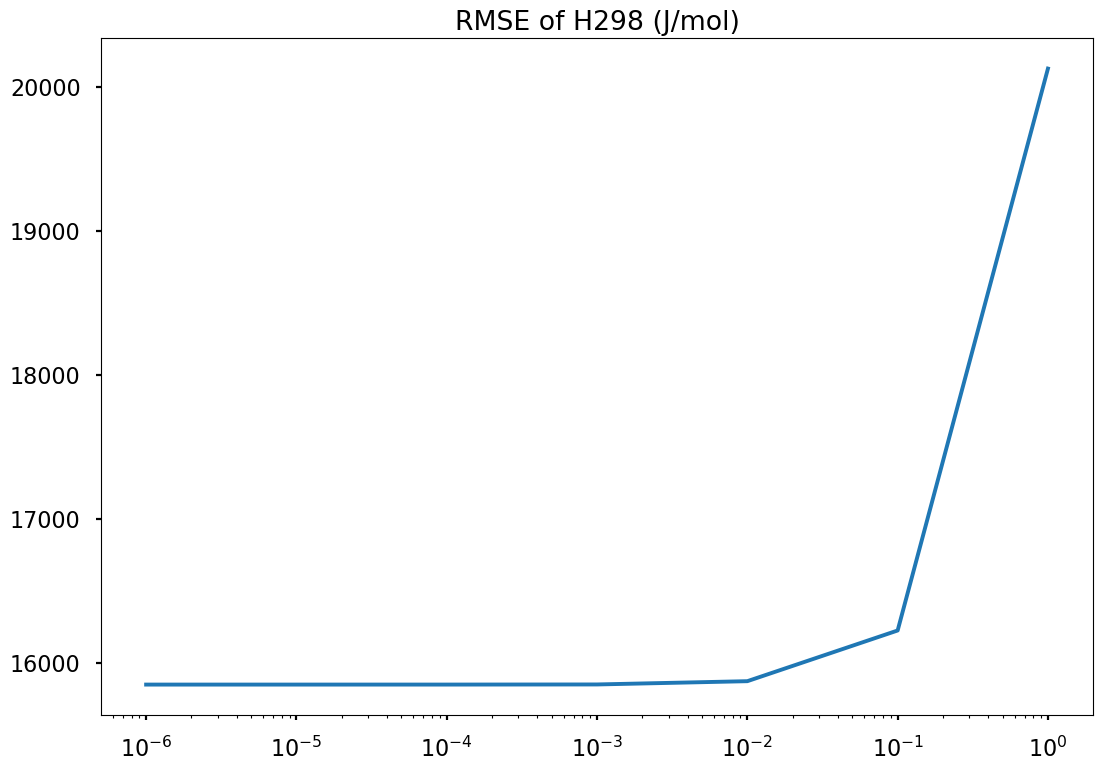

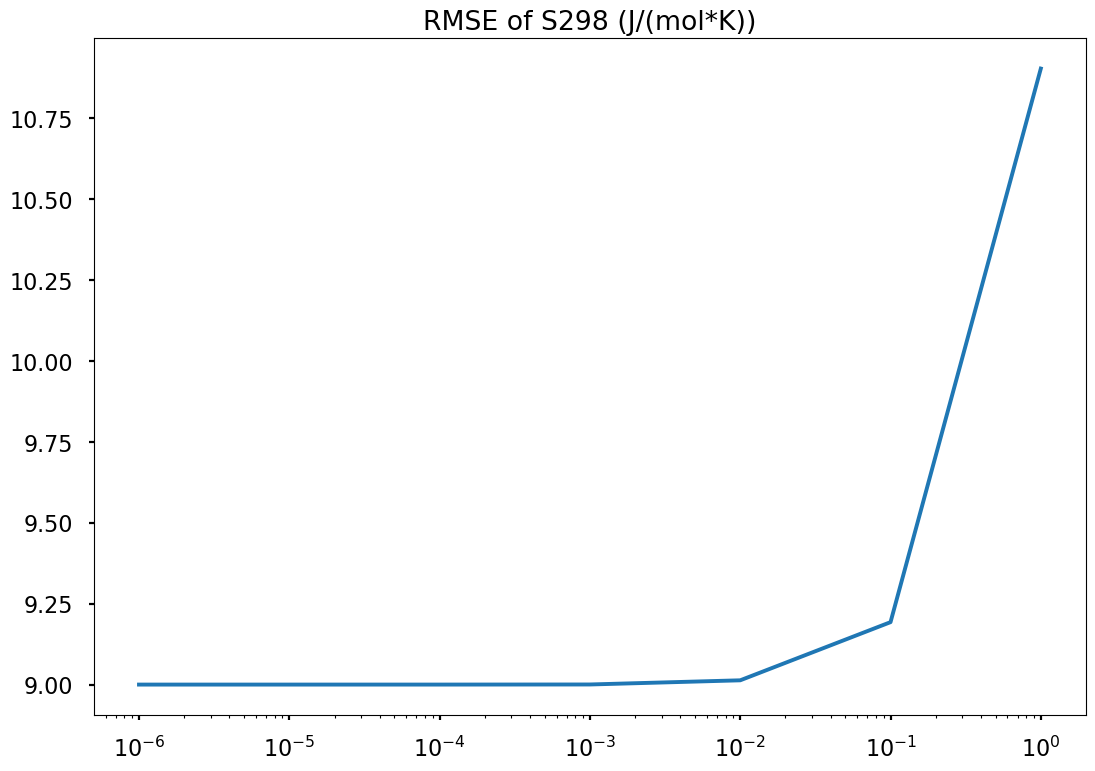

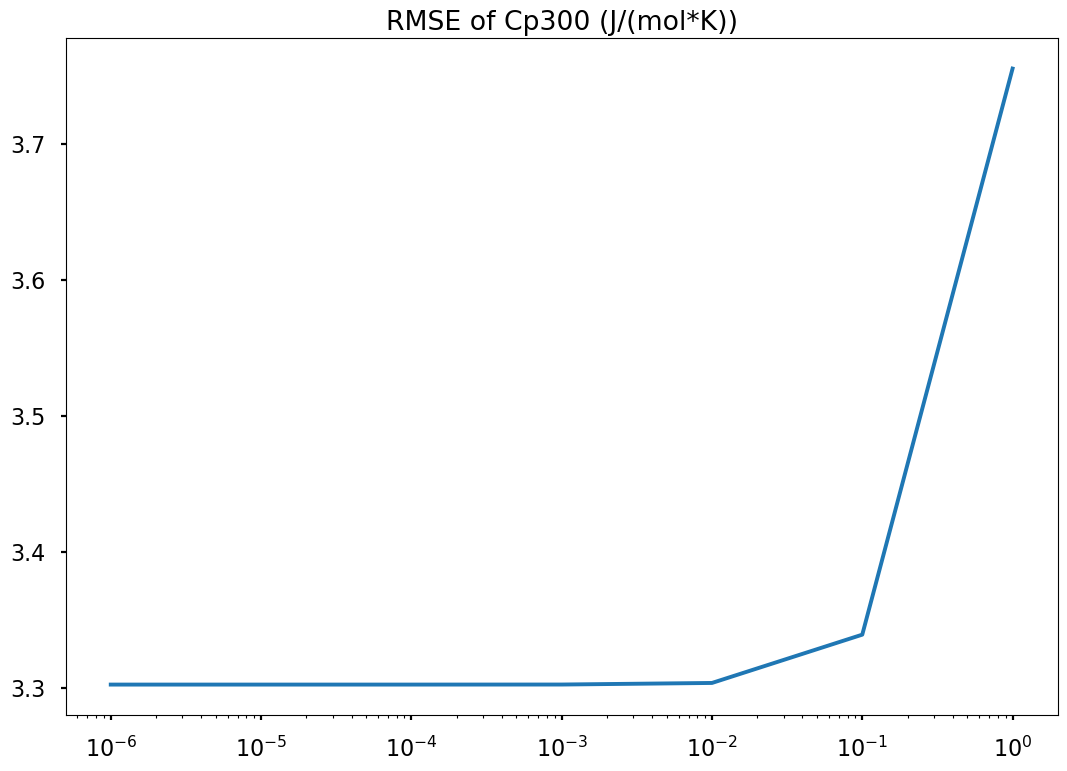

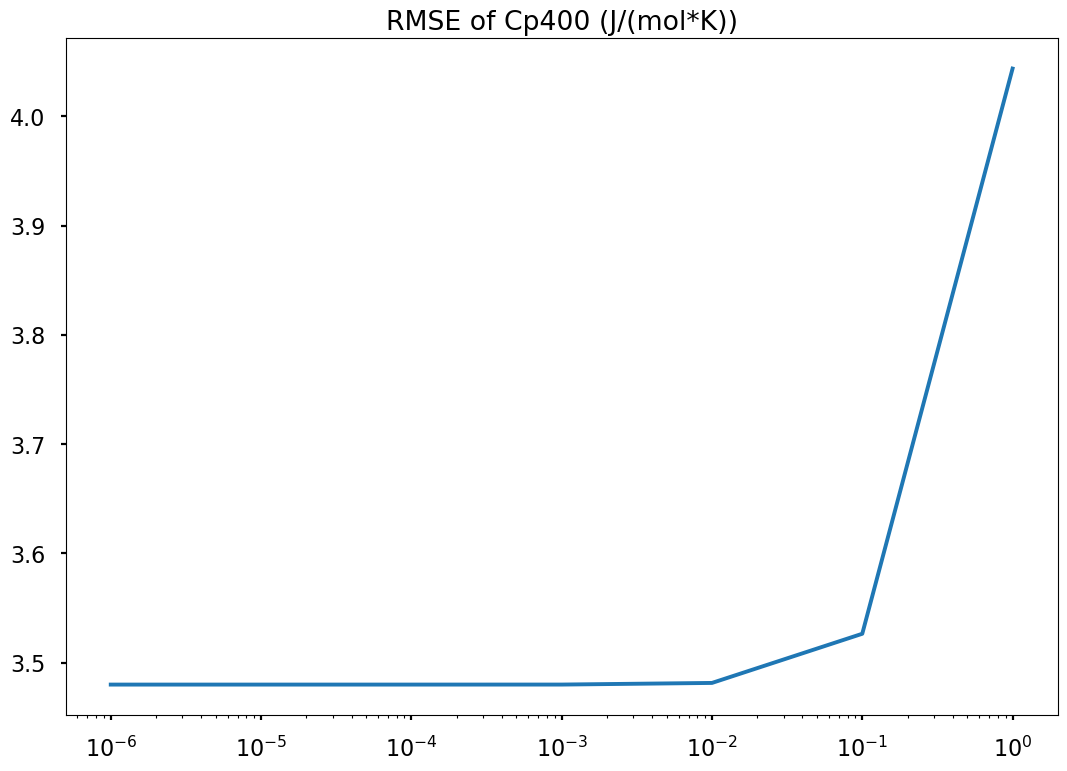

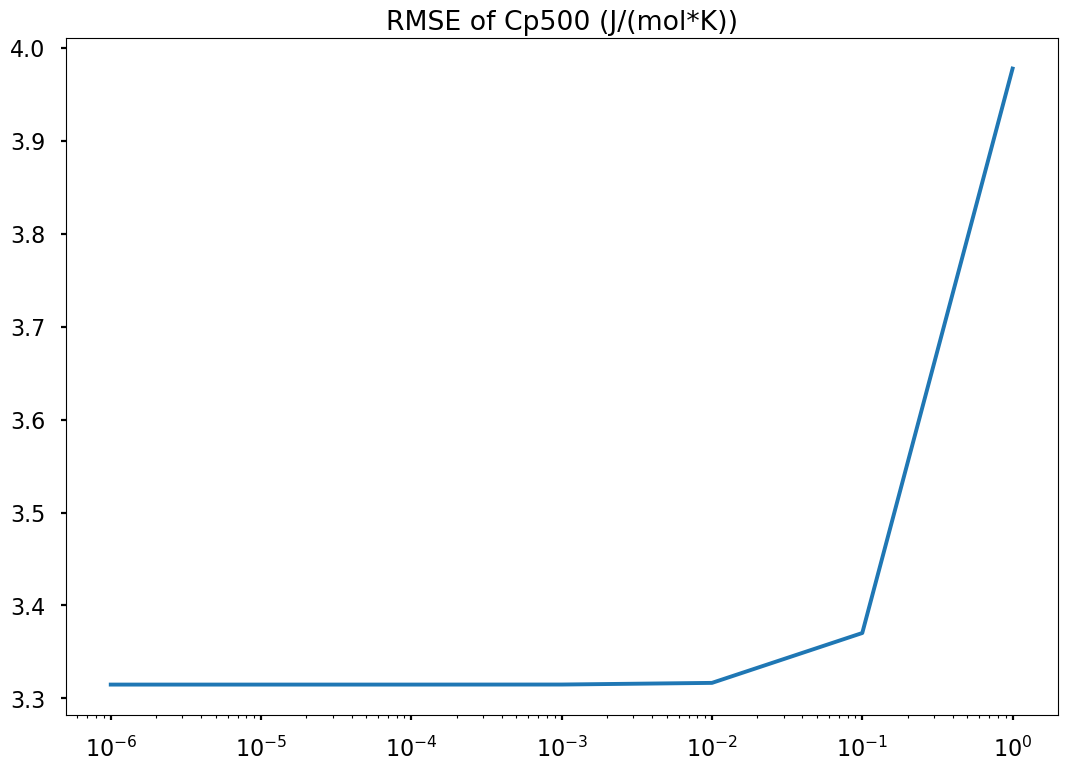

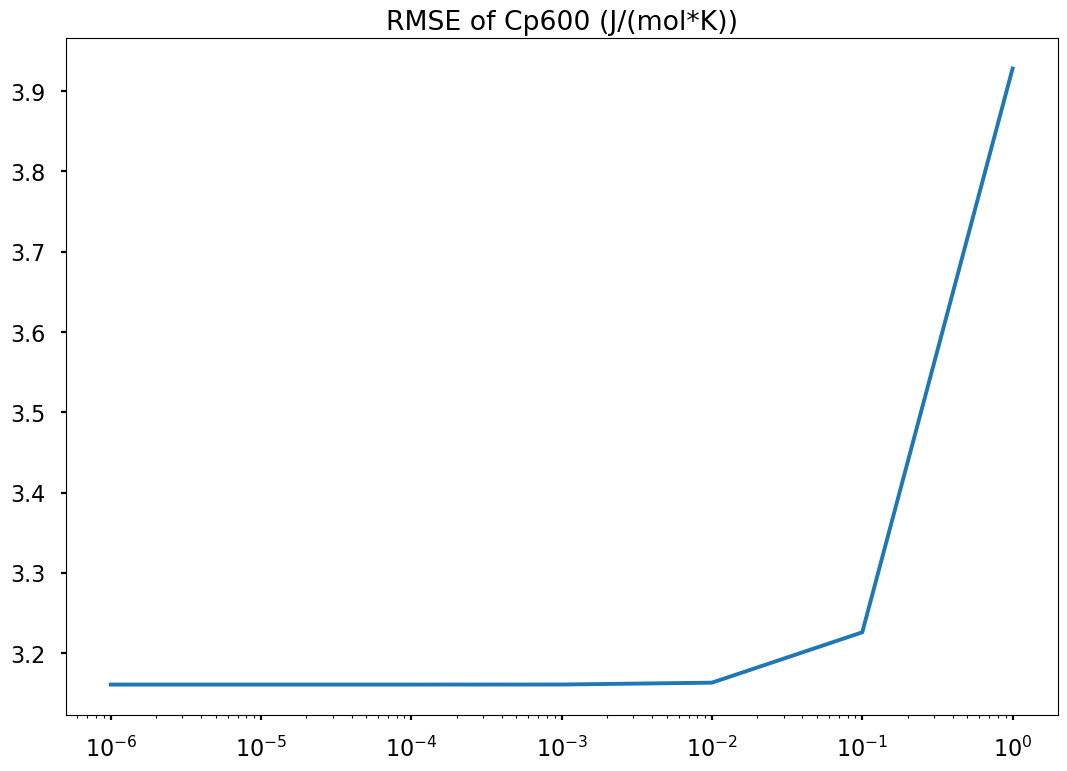

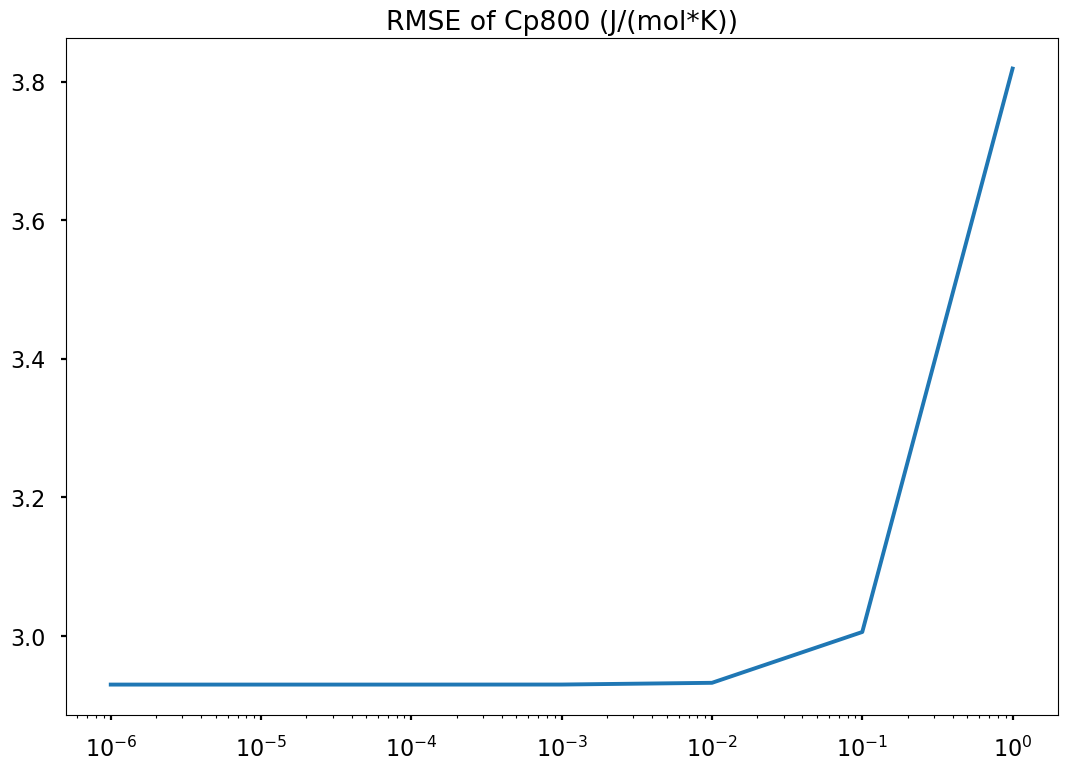

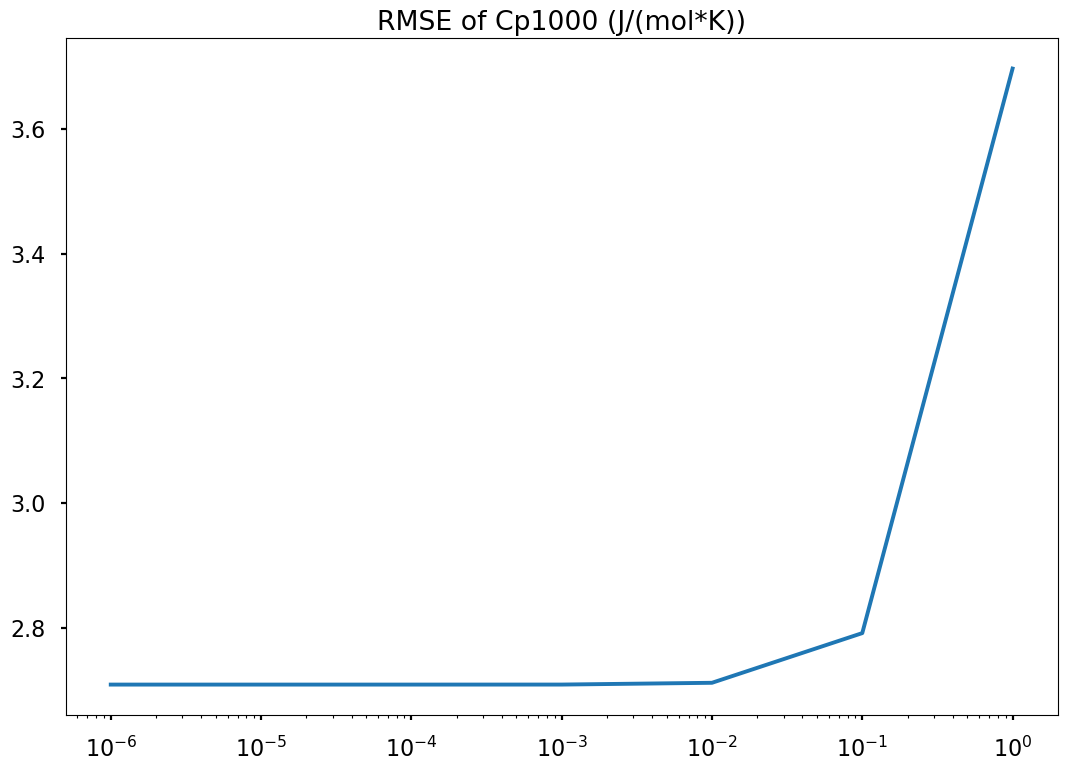

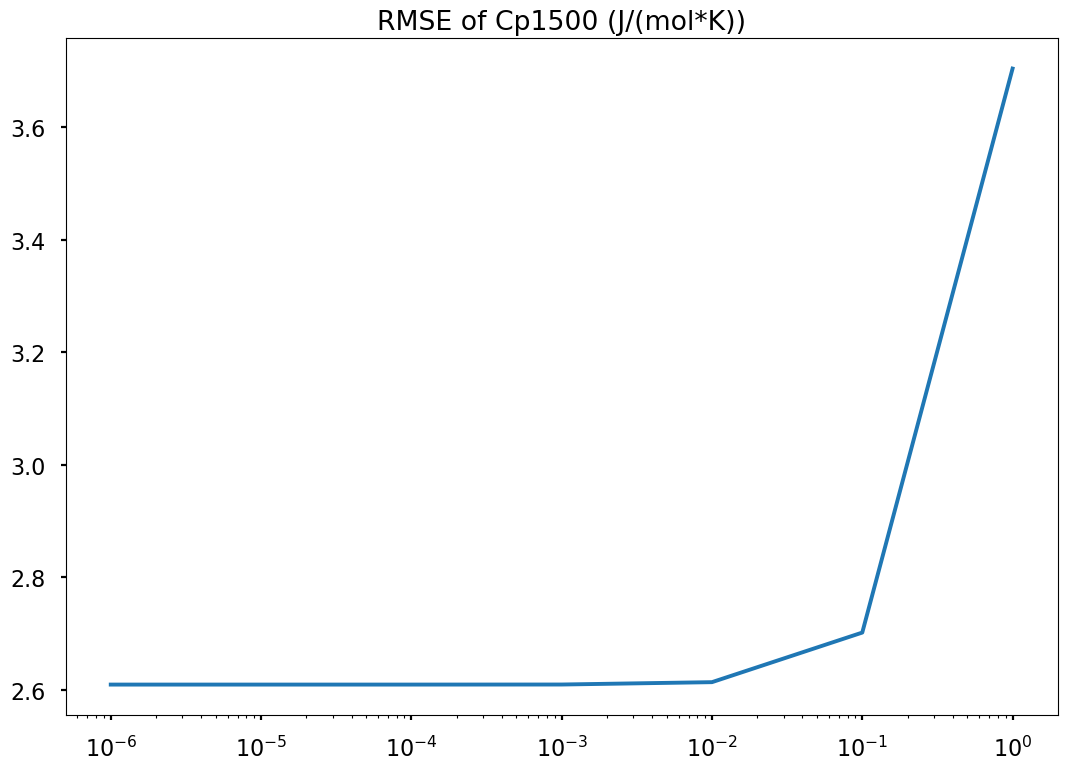

In [10]:
for ind,item in enumerate(group_data_items):
    plt.figure()
    cv = soln_dict["RidgeCV"].cv_values_
    rmse = [sum((cv[:,ind,alpha_ind])**0.5)/cv.shape[0] for alpha_ind in range(cv.shape[2])]
    plt.plot(soln_dict["RidgeCV"].alphas,rmse)
    plt.title(f"RMSE of {item[0]} ({item[1]})")
    plt.xscale("log")

## 2.5 Calculate uncertainty

In [11]:
b_pred = soln_dict["RidgeCV"].predict(A)

standard_error = dict()
for i in range(b.shape[1]):
    residuals = b[:,i] - b_pred[:,i]
    sigma_squared_hat = residuals.T @ residuals/(A.shape[0] - A.shape[1])
    #See https://arxiv.org/abs/1509.09169 Section 1.4.2 for derivation
    var_beta_hat = sigma_squared_hat * np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])) @ A.T @ A @ (np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1]))).T
    standard_error[i] = np.diagonal(var_beta_hat)**0.5

## 2.6 Write the fitted data to ThermoData format

In [12]:
fitted_group_data = dict()
x = soln_dict["RidgeCV"].coef_.T

for i, label in enumerate(missing_group_index_dict.keys()):
    if all(x[i,:]==0.0):
        group_label = label.split("_")[1]
        print(f"All fitted item for group {group_label} from species index {i} are zeros. {group_label} is a special group. Add {group_label} to special_list")
    H298, S298, Cpdata = x[i,0], x[i,1], x[i,2:9]
    H298_unc, S298_unc, Cpdata_unc = standard_error[0][i], standard_error[1][i], [standard_error[j][i] for j in range(2,9)]
    fitted_group_data[label] = ThermoData(
            Tdata=([300, 400, 500, 600, 800, 1000, 1500], "K"),
            Cpdata=(Cpdata, "J/(mol*K)", "+|-", Cpdata_unc),
            H298=(H298/1000, "kJ/mol", "+|-", H298_unc/1000),
            S298=(S298, "J/(mol*K)", "+|-", S298_unc),
            comment=f"fitted({label})",
        )

## 2.7 Calculate GA esitmated thermo using newly fitted groups

In [13]:
all_data["GAE with fitted GAV"]=list()

for spc_index, groups in enumerate(all_data["missing groups"]):
    
    GAE_without_estimated_GA = all_data["GAE without estimated GAV"][spc_index]
    
    fitted_thermo = deepcopy(GAE_without_estimated_GA)
    for group in groups:
        add_thermo_data_uncertainty(fitted_thermo,fitted_group_data[group])
        
    all_data["GAE with fitted GAV"].append(fitted_thermo)


# 3. Check quality of new groups

## 3.1 Look at parity plot for training error and uncertainty from fitting

Text(0.5, 1.0, 'RMSE: 4.4, MAE: 3.1 kcal/mol')

<Figure size 1000x1000 with 0 Axes>

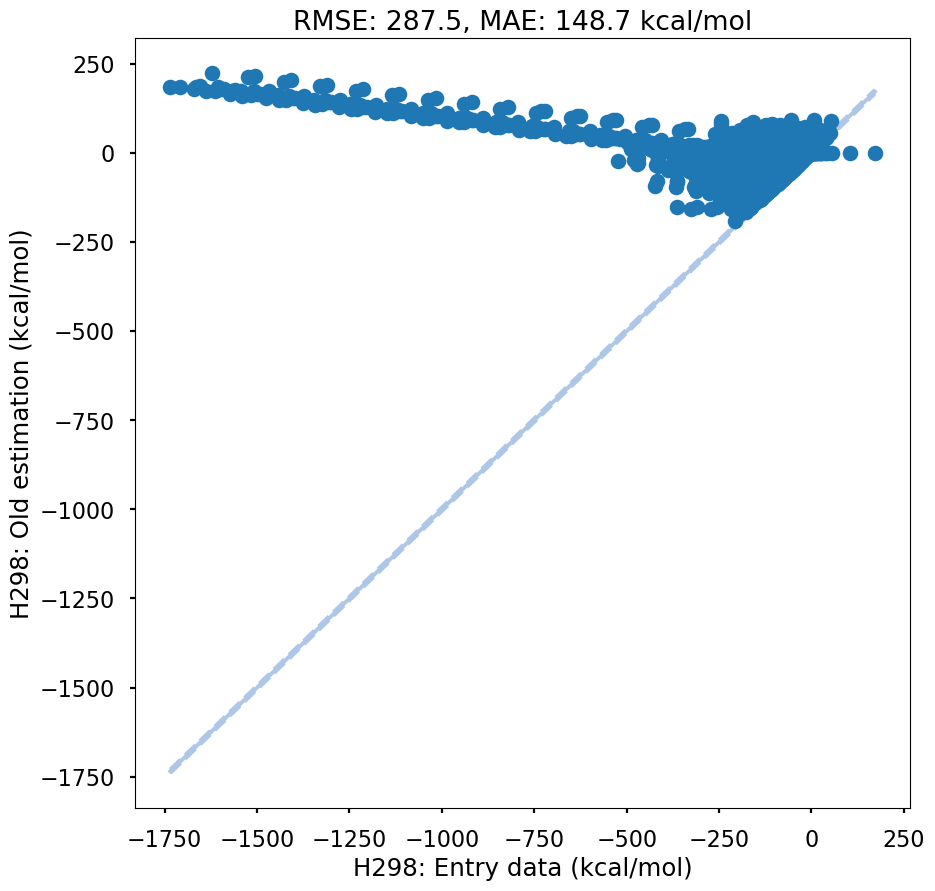

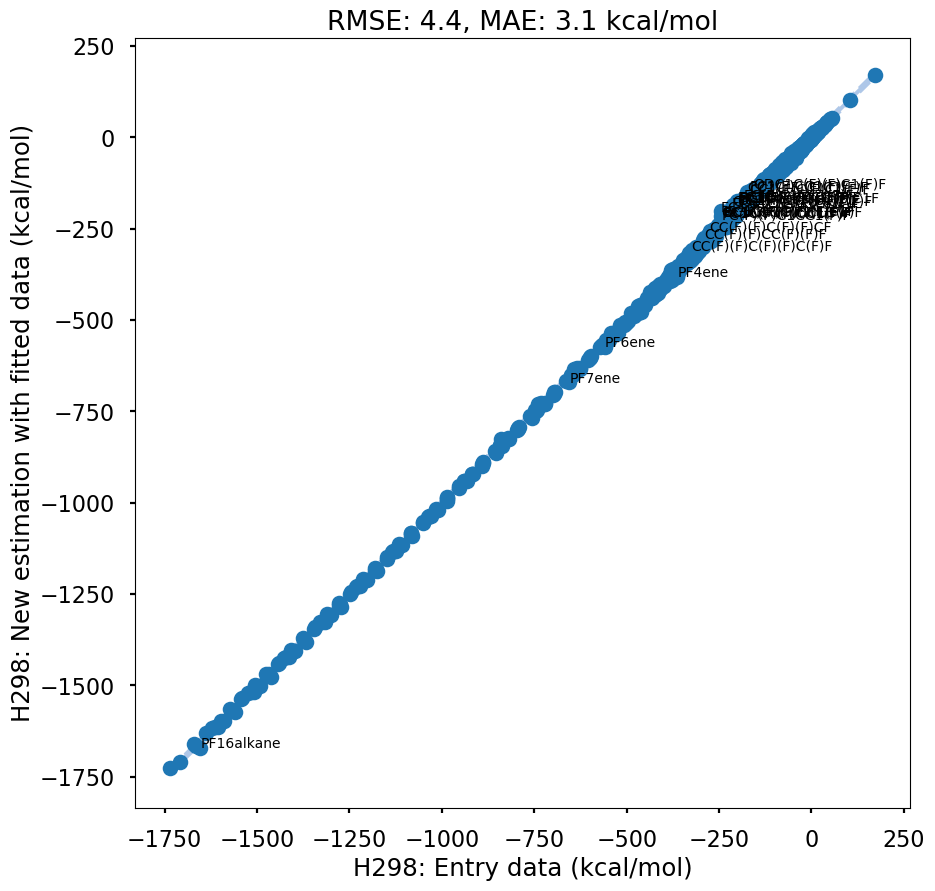

In [14]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.H298.value_si/4180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.H298.value_si/4180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.H298.value_si/4180)
    new_GAE_uncertainties.append(fitted_GAE.H298.uncertainty_si/4180)
    
    
plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: Old estimation (kcal/mol)")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>15:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: New estimation with fitted data (kcal/mol)")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')

Text(0.5, 1.0, 'RMSE: 2.5, MAE: 1.7 cal/(mol*K)')

<Figure size 1000x1000 with 0 Axes>

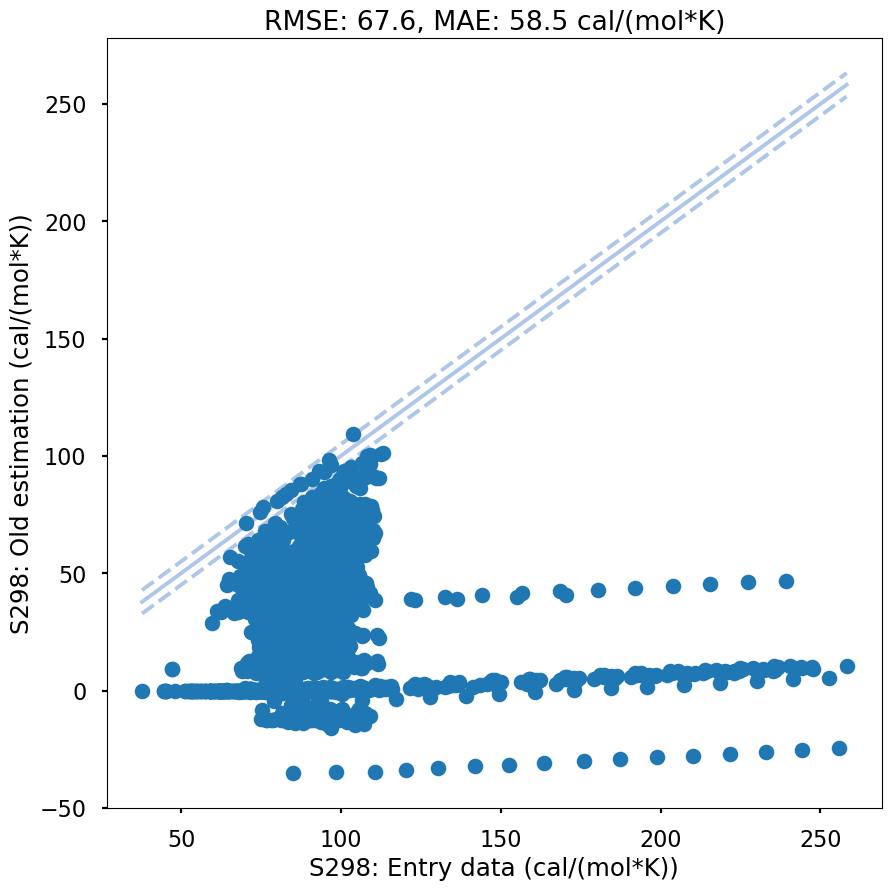

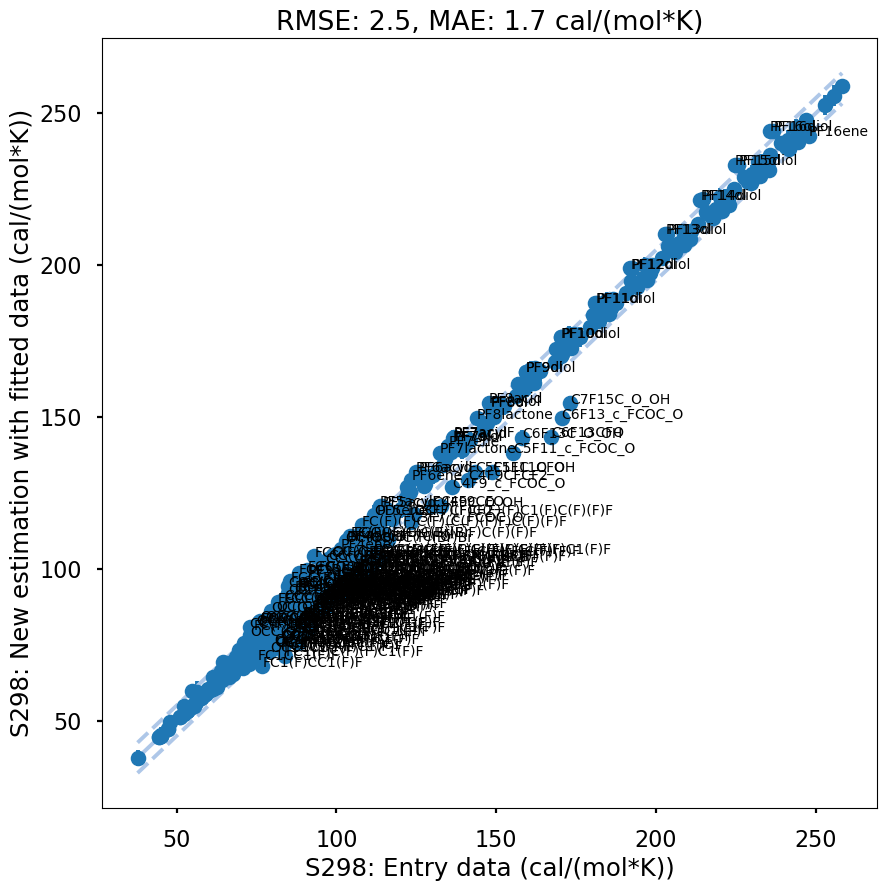

In [15]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()


for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.S298.value_si/4.180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.S298.value_si/4.180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.S298.value_si/4.180)
    new_GAE_uncertainties.append(fitted_GAE.S298.uncertainty_si/4.180)

plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: Old estimation (cal/(mol*K))")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>5:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: New estimation with fitted data (cal/(mol*K))")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')

# plt.figure()
# plt.hist(np.array(entry_values)-np.array(new_GAE_values),alpha=0.5,label="New GA estimation")
# plt.hist(np.array(entry_values)-np.array(old_GAE_values),alpha=0.5,label="Old GA estimation")
# plt.xlabel("S298 error (cal/mol-K)")
# plt.ylabel("Counts (-)")
# plt.legend()

## 3.2 Look at generalizability of the new groups by comparing the old estimation and the one-fold cross-validation of new estimation

/Users/khalil.nor/miniconda3/envs/rmg_env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/Users/khalil.nor/miniconda3/envs/rmg_env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,
/Users/khalil.nor/miniconda3/envs/rmg_env/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: Futur

<Figure size 1000x1000 with 0 Axes>

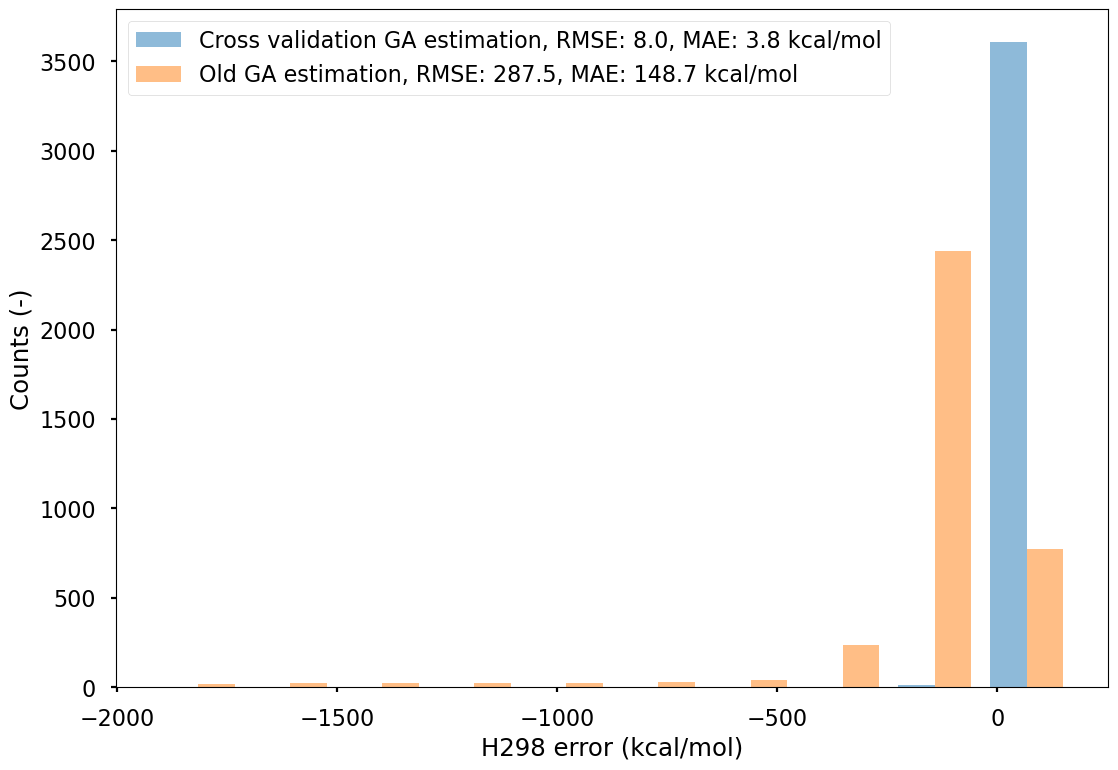

<Figure size 1000x1000 with 0 Axes>

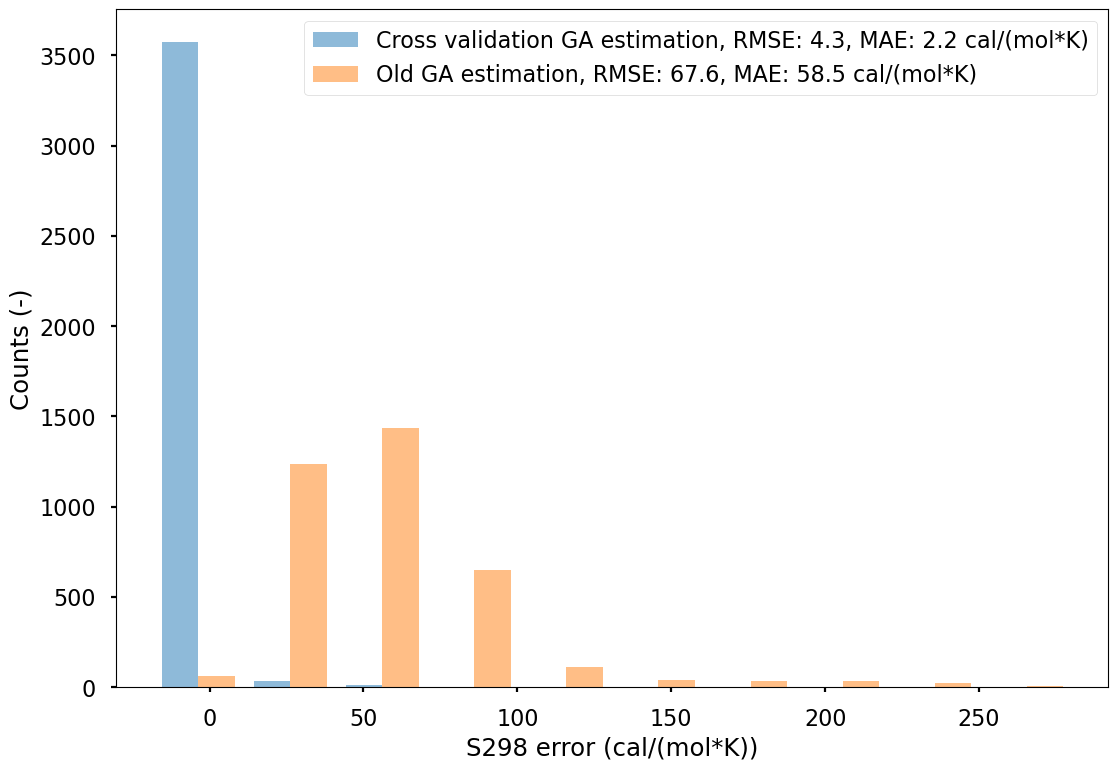

In [16]:
alpha = soln_dict["RidgeCV"].alpha_
all_data["cross validation estimation"]=list()
for skip_spc_index in range(spc_num):

    A = np.zeros((spc_num,grp_num))
    b = np.zeros((spc_num,len(group_data_items)))

    for spc_index, entry in enumerate(all_data["entry"]):
        if spc_index == skip_spc_index:
            pass
        else:
            groups = all_data["missing groups"][spc_index]
            for group in groups:
                A[spc_index, missing_group_index_dict[group]]+=1

            thermo_data = all_data["missing GAE"][spc_index]
            b[spc_index,0] = thermo_data.H298.value_si
            b[spc_index,1] = thermo_data.S298.value_si
            b[spc_index,2:9] = thermo_data.Cpdata.value_si

    soln = Ridge(alpha=alpha,fit_intercept=False,normalize=False, max_iter=1e5).fit(A,b)
    soln_dict["Ridge"]=soln

    b_pred = soln_dict["Ridge"].predict(A)

    standard_error = dict()
    for i in range(b.shape[1]):
        residuals = b[:,i] - b_pred[:,i]
        sigma_squared_hat = residuals.T @ residuals/(A.shape[0] - A.shape[1])
        var_beta_hat = sigma_squared_hat * np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])) @ A.T @ A @ (np.linalg.inv(A.T @ A + alpha*np.identity(A.shape[1])))
        standard_error[i] = np.diagonal(var_beta_hat)**0.5

    fitted_group_data_cv = dict()

    for i, label in enumerate(missing_group_index_dict.keys()):
        x = soln_dict["Ridge"].coef_.T
        H298, S298, Cpdata = x[i,0], x[i,1], x[i,2:9]
        H298_unc, S298_unc, Cpdata_unc = standard_error[0][i], standard_error[1][i], [standard_error[j][i] for j in range(2,len(group_data_items))]
        fitted_group_data_cv[label] = ThermoData(
                Tdata=([300, 400, 500, 600, 800, 1000, 1500], "K"),
                Cpdata=(Cpdata, "J/(mol*K)", "+|-", Cpdata_unc),
                H298=(H298/1000, "kJ/mol", "+|-", H298_unc/1000),
                S298=(S298, "J/(mol*K)", "+|-", S298_unc),
                comment=f"fitted({label})",
            )

    groups = all_data["missing groups"][skip_spc_index]

    GAE_without_estimated_GA = all_data["GAE without estimated GAV"][skip_spc_index]

    fitted_thermo = deepcopy(GAE_without_estimated_GA)
    for group in groups:
        add_thermo_data_uncertainty(fitted_thermo,fitted_group_data_cv[group])

    all_data["cross validation estimation"].append(fitted_thermo)

colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
cross_validation_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.H298.value_si/4180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.H298.value_si/4180)
    cross_validation_GAE = all_data["cross validation estimation"][spc_index]
    cross_validation_values.append(cross_validation_GAE.H298.value_si/4180)

plt.figure()
RMSE1 = mean_squared_error(entry_values,cross_validation_values,squared=False)
MAE1 = mean_absolute_error(entry_values,cross_validation_values)
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.hist([np.array(entry_values)-np.array(cross_validation_values), np.array(entry_values)-np.array(old_GAE_values)],alpha=0.5,label=[f"Cross validation GA estimation, RMSE: {RMSE1:.1f}, MAE: {MAE1:.1f} kcal/mol",f"Old GA estimation, RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol"])
plt.xlabel("H298 error (kcal/mol)")
plt.ylabel("Counts (-)")
plt.legend()

colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
cross_validation_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.S298.value_si/4.180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.S298.value_si/4.180)
    cross_validation_GAE = all_data["cross validation estimation"][spc_index]
    cross_validation_values.append(cross_validation_GAE.S298.value_si/4.180)
    
plt.figure()
RMSE1 = mean_squared_error(entry_values,cross_validation_values,squared=False)
MAE1 = mean_absolute_error(entry_values,cross_validation_values)
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.hist([np.array(entry_values)-np.array(cross_validation_values), np.array(entry_values)-np.array(old_GAE_values)],alpha=0.5,label=[f"Cross validation GA estimation, RMSE: {RMSE1:.1f}, MAE: {MAE1:.1f} cal/(mol*K)", f"Old GA estimation, RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)"])
plt.xlabel("S298 error (cal/(mol*K))")
plt.ylabel("Counts (-)")
plt.legend()

## 3.2 Check if there's bad fit
This block checks if there are any bad fit groups. User should expect this block prints out nothing. It this block prints out anything, user should not trust the fitted results and should open an issue or try to identify the reason of the poor fit. It uses following criteria to find bad fit:

- Error in H298 and S298 from the new estimation is worse than the old estimation. This is usually caused by special groups. Try identify the special groups and put in the `special_list`, and re-run the code. 

- Error in H298 from the new estimation `> n kcal/mol` or S298 `> n cal/(mol* K)`, where n is default to 5. Increase n at your own risk.

In [17]:
bad_fit_spc_index_list = list()
n=5
for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_thermo = all_data["entry thermo"][spc_index]
    diff = abs(entry_thermo.H298.value_si-all_data["GAE with estimated GAV"][spc_index].H298.value_si)
    diff_new = abs(entry_thermo.H298.value_si-all_data["GAE with fitted GAV"][spc_index].H298.value_si)
    if diff<diff_new:
        bad_fit_spc_index_list.append(spc_index)
    if diff_new>n*4.18*1000:
        bad_fit_spc_index_list.append(spc_index)
    diff = abs(entry_thermo.S298.value_si-all_data["GAE with estimated GAV"][spc_index].S298.value_si)
    diff_new = abs(entry_thermo.S298.value_si-all_data["GAE with fitted GAV"][spc_index].S298.value_si)
    if diff<diff_new:
        bad_fit_spc_index_list.append(spc_index)
    if diff_new>n*4.18:
        bad_fit_spc_index_list.append(spc_index)
        
bad_fit_spc_index_list = list(set(bad_fit_spc_index_list))
print(f"{len(bad_fit_spc_index_list)} out of {len(entries)} species have bad fits")

785 out of 3398 species have bad fits


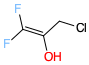

OC(CCl)=C(F)F
Entry
CHOFCl_G4
OC(CCl)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.312,138.929,152.946,164.259,181.298,192.546,205.872],'J/(mol*K)'), H298=(-543.947,'kJ/mol'), S298=(363.709,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.6653,91.502,100.983,109.276,121.76,130.236,140.619],'J/(mol*K)'), H298=(-184.179,'kJ/mol'), S298=(214.477,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsCClHH) + longDistanceInteraction_noncyclic(Cs(Cl)-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.1347,94.9909,105.248,112.167,122.446,129.365,138.259],'J/(mol*K)'), H298=(-235.041,'kJ/mol'), S298=(208.801,'J/(mol*K)'), comment="""Thermo g

FOOF
Entry
C1_C2_Fluorine
FOOF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.8071,68.0548,72.8029,75.8312,79.0229,80.5713,81.9991],'J/(mol*K)'), H298=(29.1088,'kJ/mol'), S298=(279.216,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-F1sO2s) + missing(O2s-F1sO2s)""")

missing
['O2sFO_O2s-F1sO2s', 'O2sFO_O2s-F1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.6533,66.0337,70.1314,73.37,77.1284,78.2658,80.1049],'J/(mol*K)','+|-',[1.43923,1.50448,1.41056,1.30975,1.13556,1.00838,1.94902]), H298=(61.6799,'kJ/mol','+|-',6.94737), S298=(277.284,'J/(mol*K)','+|-',3.95511), comment="""Therm

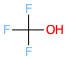

OC(F)(F)F
Entry
C1_C2_Fluorine
CF3OH
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([67.2353,78.9182,88.2639,95.4404,104.614,110.41,118.199],'J/(mol*K)'), H298=(-910.263,'kJ/mol'), S298=(290.064,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-F1sF1sF1sO2s)""")

missing
['O2s-CsH_O2s-CsH', 'CsFFFO_Cs-F1sF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([70.0524,80.8018,88.54,94.7362,103.878,109.744,118.278],'J/(mol*K)','+|-',[0.680999,0.711872,0.667433,0.619733,0.537312,0.477132,0.922215]), H298=(-883.622,'kJ/mol','+|-',3.28727), S298=(295.461,'J/(mol*K)','+|-',1.871

FC#CF
Entry
C1_C2_Fluorine
FCCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.5176,66.0402,69.2423,71.7175,75.7595,78.5088,82.5333],'J/(mol*K)'), H298=(4.60677,'kJ/mol'), S298=(252.968,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Ct-CtF1s) + missing(Ct-CtF1s)""")

missing
['CtCF_Ct-CtF1s', 'CtCF_Ct-CtF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.5594,64.2249,67.6367,69.5621,73.5564,76.4685,80.4818],'J/(mol*K)','+|-',[1.29865,1.35753,1.27278,1.18182,1.02464,0.909881,1.75865]), H298=(-1.31692,'kJ/mol','+|-',6.26877), S298=(252.974,'J/(mol*K)','+|-',3.56879), comment="""Thermo gro

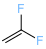

C=C(F)F
Entry
C1_C2_Fluorine
CH2CF2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.6445,70.6811,80.5262,88.3421,99.1291,106.714,117.807],'J/(mol*K)'), H298=(-350.152,'kJ/mol'), S298=(264.816,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cd-CdHH) + missing(Cd-CdF1sF1s)""")

missing
['Cds-CdsHH_Cd-CdHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.0312,72.2686,80.9104,88.1044,99.1535,107.21,118.816],'J/(mol*K)','+|-',[0.533291,0.557468,0.522667,0.485314,0.420769,0.373642,0.722187]), H298=(-317.62,'kJ/mol','+|-',2.57427), S298=(268.997,'J/(mol*K)','+|-',1.46552), co

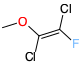

COC(Cl)=C(F)Cl
Entry
CHOFCl_G4
COC(Cl)DC(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.831,133.779,147.057,157.785,174.379,186.365,203.203],'J/(mol*K)'), H298=(-317.548,'kJ/mol'), S298=(378.876,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.755,107.17,115.106,120.689,127.653,131.355,133.509],'J/(mol*K)'), H298=(-285.4,'kJ/mol'), S298=(250.552,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-O2sHHH) + group(CdCClO) + group(CdCClF) + longDistanceInteraction_noncyclic(Cds(Val7)2=Cds(Val7))""")

missing
['Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.9363,104.682,113.331,119.236,127.036,131.175,134.098],'J/(mol*K)'), H298=(-302.701,'kJ/mol'), S298=(251.964,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-C

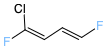

FC=CC=C(F)Cl
Entry
CHOFCl_G4
FCDCCDC(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.1,130.485,148.63,162.437,181.142,193.758,209.579],'J/(mol*K)'), H298=(-295.211,'kJ/mol'), S298=(352.904,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([79.4127,95.7069,107.783,116.301,128.65,136.867,148.199],'J/(mol*K)'), H298=(-123.755,'kJ/mol'), S298=(220.081,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + missing(Cd-CdF1sH) + group(CdCClF)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([79.4127,95.7069,107.783,116.301,128.65,136.867,148.199],'J/(mol*K)'), H298=(-123.755,'kJ/mol'), S298=(220.081,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + group(CdCClF)"""

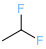

[CH]C(F)F
Entry
C1_C2_Fluorine
CHF2CH(S)
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.5936,70.6159,79.5935,87.0831,97.4626,104.759,115.182],'J/(mol*K)'), H298=(1.06794,'kJ/mol'), S298=(290.165,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-C2sF1sF1sH) + missing(C2s-CsH)""")

missing
['CsCFFH_Cs-C2sF1sF1sH', 'CsJ2_singlet-CsH_C2s-CsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.6453,71.2963,79.9342,87.1527,97.2383,104.254,114.679],'J/(mol*K)','+|-',[4.38421,4.58297,4.29688,3.98979,3.45917,3.07173,5.93714]), H298=(-6.00568,'kJ/mol','+|-',21.1632), S298=(292.28,'J/(mol*K)','+|-',12

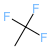

CC(F)(F)F
Entry
C1_C2_Fluorine
CH3CF3
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.8494,93.5769,106.623,117.169,132.149,142.632,158.016],'J/(mol*K)'), H298=(-752.13,'kJ/mol'), S298=(287.113,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([79.0543,94.2733,106.726,116.907,132.276,143.363,159.056],'J/(mol*K)','+|-',[0.346373,0.362076,0.339473,0.315212,0.27329,0.242681,0.469061]), H298=(-715.509,'kJ/mol','+|-',1.67199), S298=(296.194,'J/(mol*K)','+|-',0

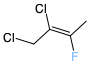

CC(F)=C(Cl)CCl
Entry
CHOFCl_G4
CC(F)DC(Cl)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([121.466,143.19,161.788,177.611,202.229,219.424,242.465],'J/(mol*K)'), H298=(-267.143,'kJ/mol'), S298=(354.669,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([70.1928,81.2349,89.7972,96.9718,107.92,115.298,124.197],'J/(mol*K)'), H298=(-43.9434,'kJ/mol'), S298=(212.569,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + group(CsCClHH) + longDistanceInteraction_noncyclic(Cs(Cl)-Cds(Cl)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7)) + group(CdCsCdCl) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7))""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdF1s)CdHHH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([70.1283,80.4282,88.855,95.9943,107.049,114.47

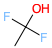

CC(O)(F)F
Entry
C1_C2_Fluorine
CH3CF2OH
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.9594,108.869,123.4,134.23,148.099,158.301,174.35],'J/(mol*K)'), H298=(-726.836,'kJ/mol'), S298=(303.274,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsHHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCFFO_Cs-CsF1sF1sO2s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.4421,107.385,120.33,131.041,147.542,159.247,176.027],'J/(mol*K)','+|-',[0.616603,0.644557,0.60432,0.561131,0.486503,0.432014,0.835009]), H298=(-697.876,'kJ/mol','+|-',2.97643)

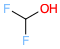

OC(F)F
Entry
C1_C2_Fluorine
CHF2OH
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.6421,76.2556,84.7123,90.8448,98.9081,104.865,114.193],'J/(mol*K)'), H298=(-673.574,'kJ/mol'), S298=(276.438,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-F1sF1sO2sH)""")

missing
['O2s-CsH_O2s-CsH', 'CsFFHO_Cs-F1sF1sO2sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.6437,74.08,81.1615,87.234,96.8862,103.662,114.036],'J/(mol*K)','+|-',[0.621793,0.649983,0.609407,0.565854,0.490598,0.43565,0.842038]), H298=(-651.365,'kJ/mol','+|-',3.00148), S298=(285.158,'J/(mol*K)','+|-',1.70873), co

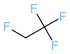

FCC(F)(F)F
Entry
C1_C3_hydrofluorocarbons_NIST
CH2F-CF3
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.6205,103.856,117.921,128.888,143.114,152.299,163.863],'J/(mol*K)'), H298=(-909.68,'kJ/mol'), S298=(315.707,'J/(mol*K)'), Cp0=(33.2579,'J/mol/K'), CpInf=(178.761,'J/mol/K'), E0=(-926.575,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0.320405,0.817955,0.961123,0.880159,0.633403,0.511573,1.05779],'J/(mol*K)'), H298=(27.811,'kJ/mol'), S298=(-0.856921,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F))""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.606

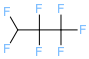

FC(F)C(F)(F)C(F)(F)F
Entry
C1_C3_hydrofluorocarbons_NIST
C3F7H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.199,161.883,181.39,196.398,216.054,227.963,241.806],'J/(mol*K)'), H298=(-1564.83,'kJ/mol'), S298=(398.988,'J/(mol*K)'), Cp0=(33.2579,'J/mol/K'), CpInf=(249.434,'J/mol/K'), E0=(-1589.46,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.93103,-3.91383,-1.9548,-1.14928,-1.13823,-0.273656,3.54172],'J/(mol*K)'), H298=(96.2185,'kJ/mol'), S298=(2.02541,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs

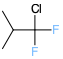

CC(C)C(F)(F)Cl
Entry
CHOFCl_G4
CC(C)C(F)(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.678,158.55,180.739,199.66,229.232,250.079,278.782],'J/(mol*K)'), H298=(-587.236,'kJ/mol'), S298=(363.469,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.8496,91.6375,101.693,109.344,120.211,126.579,132.913],'J/(mol*K)'), H298=(-482.721,'kJ/mol'), S298=(136.011,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsHHH) + missing(Cs-CsHHH) + group(CsCClFF)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.8496,91.6375,101.693,109.344,120.211,126.579,132.913],'J/(mol*K)'), H298=(-482.721,'kJ/mol'), S298=(136.011,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + group(CsCClFF)""")

GAE with fitte

CCC
Entry
C1_C3_hydrofluorocarbons_NIST
C3H8
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([73.9502,94.098,112.41,128.645,154.864,174.617,204.336],'J/(mol*K)'), H298=(-103.864,'kJ/mol'), S298=(270.144,'J/(mol*K)'), Cp0=(33.2579,'J/mol/K'), CpInf=(249.434,'J/mol/K'), E0=(-118.828,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([75.7027,94.3512,111.804,127.295,152.812,172.689,204.764],'J/(mol*K)','+|-',[0.460547,0.481427,0.451

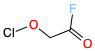

O=C(F)COCl
Entry
CHOFCl_G4
ODC(F)COCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.7108,111.109,121.049,129.372,141.978,150.399,160.801],'J/(mol*K)'), H298=(-423.043,'kJ/mol'), S298=(349.624,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.0154,69.1988,76.4306,81.8621,89.1866,93.7983,100.254],'J/(mol*K)'), H298=(-30.5041,'kJ/mol'), S298=(181.404,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCCl) + group(Cs-(Cds-O2d)OsHH) + missing(CO-CsF1sO2d)""")

missing
['COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.0154,69.1988,76.4306,81.8621,89.1866,93.7983,100.254],'J/(mol*K)'), H298=(-30.5041,'kJ/mol'), S298=(181.404,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCCl) + group(Cs-(Cds-O2d)OsHH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,

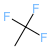

CC(F)(F)F
Entry
C1_C3_hydrofluorocarbons_NIST
CH3-CF3
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.39,94.049,106.992,117.441,132.322,142.741,157.517],'J/(mol*K)'), H298=(-753.924,'kJ/mol'), S298=(287.611,'J/(mol*K)'), Cp0=(33.2579,'J/mol/K'), CpInf=(178.761,'J/mol/K'), E0=(-769.648,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([79.0543,94.2733,106.726,116.907,132.276,143.363,159.056],'J/(mol*K)','+|-',[0.346373,0.362076,0.339473,0.315212,0.27329,0.24

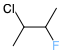

CC(F)C(C)Cl
Entry
CHOFCl_G4
CC(F)C(C)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.784,148.95,170.847,189.812,220.197,242.417,274.641],'J/(mol*K)'), H298=(-368.993,'kJ/mol'), S298=(345.001,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([73.5421,86.2383,95.6738,103.148,114.428,121.372,129.007],'J/(mol*K)'), H298=(-284.505,'kJ/mol'), S298=(110.652,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsCsCsClH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.7579,87.2355,96.3927,103.808,115.045,121.763,128.522],'J/(mol*K)'), H298=(-294.639,'kJ/mol'), S298=(107.226,'J/(mol*K)

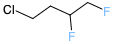

FCC(F)CCCl
Entry
CHOFCl_G4
FCC(F)CCCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.676,164.401,187.593,206.536,234.531,254.458,282.777],'J/(mol*K)'), H298=(-535.263,'kJ/mol'), S298=(382.07,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([75.0061,89.4817,100.979,110.229,123.938,132.966,144.344],'J/(mol*K)'), H298=(-286.9,'kJ/mol'), S298=(198.094,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsCsHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsClCsHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.2503,90.1179,100.858,109.733,123.264,132.084,142.866],'J/(mol*K)'), H298=(-301.232,'kJ/mol'), S298=(198.14,'J/(mol*K)'), comment=

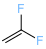

C=C(F)F
Entry
C1_C3_hydrofluorocarbons_NIST
CH2CF2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.4914,73.2633,84.0887,93.0517,106.066,114.332,123.416],'J/(mol*K)'), H298=(-351.062,'kJ/mol'), S298=(266.023,'J/(mol*K)'), Cp0=(33.2579,'J/mol/K'), CpInf=(133.032,'J/mol/K'), E0=(-364.356,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cd-CdHH) + missing(Cd-CdF1sF1s)""")

missing
['Cds-CdsHH_Cd-CdHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.0312,72.2686,80.9104,88.1044,99.1535,107.21,118.816],'J/(mol*K)','+|-',[0.533291,0.557468,0.522667,0.485314,0.420769,0.373642,0.72

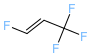

FC=CC(F)(F)F
Entry
C1_C3_hydrofluorocarbons_NIST
CHFCHCF3
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.8548,118.485,134.079,146.342,163.397,174.117,189.305],'J/(mol*K)'), H298=(-830.026,'kJ/mol'), S298=(342.678,'J/(mol*K)'), Cp0=(33.2579,'J/mol/K'), CpInf=(203.705,'J/mol/K'), E0=(-848.567,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sF1sF1s) + missing(Cd-CdCsH) + missing(Cd-CdF1sH)""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([100.127,117.594,131.802,143.351,160.276,171.712,186.871],'J/(mol*K)','+|-',

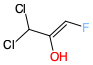

OC(=CF)C(Cl)Cl
Entry
CHOFCl_G4
OC(DCF)C(Cl)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.886,137.37,151.006,161.897,178.275,189.586,204.28],'J/(mol*K)'), H298=(-371.355,'kJ/mol'), S298=(382.204,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.8289,104.045,112.849,120.046,130.512,137.351,144.931],'J/(mol*K)'), H298=(-206.076,'kJ/mol'), S298=(245.326,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsCClClH) + longDistanceInteraction_noncyclic(Cs(Cl)2-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.618,109.309,118.885,124.937,133.487,138.699,143.918],'J/(mol*K)'), H298=(-249.447,'kJ/mol'), S298=(238.772,'J/(mol*K)'), comment="""Thermo gro

FC#CF
Entry
C1_C3_hydrofluorocarbons_NIST
C2F2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.0796,66.2995,69.377,71.7972,75.7253,78.4456,82.2795],'J/(mol*K)'), H298=(5.58989,'kJ/mol'), S298=(256.472,'J/(mol*K)'), Cp0=(29.1007,'J/mol/K'), CpInf=(87.302,'J/mol/K'), E0=(-8.84137,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Ct-CtF1s) + missing(Ct-CtF1s)""")

missing
['CtCF_Ct-CtF1s', 'CtCF_Ct-CtF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.5594,64.2249,67.6367,69.5621,73.5564,76.4685,80.4818],'J/(mol*K)','+|-',[1.29865,1.35753,1.27278,1.18182,1.02464,0.909881,1.75865]), H298=(-1.31692

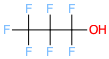

OC(F)(F)C(F)(F)C(F)(F)F
Entry
C1_C3_hydrofluorocarbons_NIST
C3F7OH
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([164.504,192.619,213.545,229.134,249.5,259.705,276.731],'J/(mol*K)'), H298=(-1766.16,'kJ/mol'), S298=(411.068,'J/(mol*K)'), Cp0=(33.2579,'J/mol/K'), CpInf=(270.22,'J/mol/K'), E0=(-1789.22,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.93103,-3.91383,-1.9548,-1.14928,-1.13823,-0.273656,3.54172],'J/(mol*K)'), H298=(96.2185,'kJ/mol'), S298=(2.02541,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1

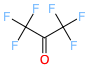

O=C(C(F)(F)F)C(F)(F)F
Entry
C1_C3_hydrofluorocarbons_NIST
C3F6O
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([141.336,161.761,176.327,186.762,200.153,207.786,216.553],'J/(mol*K)'), H298=(-1397.88,'kJ/mol'), S298=(393.648,'J/(mol*K)'), Cp0=(33.2579,'J/mol/K'), CpInf=(224.491,'J/mol/K'), E0=(-1418.58,'kJ/mol'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-COF1sF1sF1s) + missing(Cs-COF1sF1sF1s) + missing(CO-CsCsO2d)""")

missing
['CsCOFFF_Cs-(CsO2d)COF1sF1sF1s', 'CsCOFFF_Cs-(CsO2d)COF1sF1sF1s', 'Cds-OdCsCs_CO-CsCsO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.721,156.851,171.764,182.876,197.656

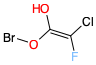

OC(OBr)=C(F)Cl
Entry
CHOFClBr_G4
OC(OBr)DC(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.726,128.065,136.881,144.055,154.362,160.602,166.673],'J/(mol*K)'), H298=(-326.056,'kJ/mol'), S298=(395.75,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.388,128.601,136.287,142.389,152.029,158.334,165.082],'J/(mol*K)'), H298=(-303.365,'kJ/mol'), S298=(389.321,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(O2sBrC) + group(Cds-CdsCsCs) + group(CdCClF) + longDistanceInteraction_noncyclic(Cd(Val7)2=CdOs)""")

missing
['Cds-CdsOsOs_Cd-CdO2sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.245,113.486,120.516,124.766,130.714,134.515,139.434],'J/(mol*K)'), H298=(-369.491,'kJ/mol'), S298=(435.307,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-

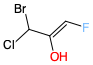

OC(=CF)C(Cl)Br
Entry
CHOFClBr_G4
OC(DCF)C(Cl)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.769,139.819,155.938,168.689,186.211,196.384,208.764],'J/(mol*K)'), H298=(-318.902,'kJ/mol'), S298=(394.685,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.3404,104.261,114.183,122.221,133.534,140.525,147.403],'J/(mol*K)'), H298=(-151.381,'kJ/mol'), S298=(255.342,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsBrCClH) + longDistanceInteraction_noncyclic(Cs(Val7)2-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.0686,111.695,121.079,127.041,135.535,140.462,145.437],'J/(mol*K)'), H298=(-208.729,'kJ/mol'), S298=(244.192,'J/(mol*K)'), comment="""The

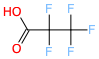

O=C(O)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF3acid
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.567,160.188,178.29,192.033,210.317,221.262,235.022],'J/(mol*K)'), H298=(-1407.04,'kJ/mol'), S298=(381.29,'J/(mol*K)'), Cp0=(18.7287,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([4.26076,3.69799,3.62377,2.99384,1.59794,0.855397,2.15483],'J/(mol*K)'), H298=(73.258,'kJ/mol'), S298=(0.607094,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COH) + missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-CO) + missing(CO-CsO2dO2s)""")

missing
['O2s-(Cds-O2d)H_O2s-(CsO2d)COH', 'CsCCFF_Cs-COCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'Cds-OdCsOs_CO-CsO2dO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(

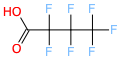

O=C(O)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF4acid
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([180.567,211.06,234.293,251.802,274.787,288.253,304.622],'J/(mol*K)'), H298=(-1809.74,'kJ/mol'), S298=(435.136,'J/(mol*K)'), Cp0=(27.1063,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.61706,-2.40918,-0.952814,-0.722261,-1.32892,-0.802559,3.81859],'J/(mol*K)'), H298=(120.038,'kJ/mol'), S298=(2.91806,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + missing(CO-CsO2dO2s)""")

missing
['O2s-(Cds-O2d)H_O2s-(

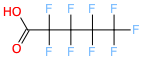

O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF5acid
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([221.017,259.973,289.476,311.516,339.896,355.945,374.654],'J/(mol*K)'), H298=(-2223.29,'kJ/mol'), S298=(478.329,'J/(mol*K)'), Cp0=(23.7178,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-4.07458,-5.20921,-3.03975,-2.48618,-2.91047,-1.85335,4.90522],'J/(mol*K)'), H298=(172.332,'kJ/mol'), S298=(6.12878,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + lo

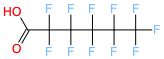

O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF6acid
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([264.408,311.675,347.073,373.199,406.255,424.579,445.297],'J/(mol*K)'), H298=(-2625.83,'kJ/mol'), S298=(525.241,'J/(mol*K)'), Cp0=(20.1729,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.5321,-8.00923,-5.12669,-4.25009,-4.49202,-2.90415,5.99184],'J/(mol*K)'), H298=(224.626,'kJ/mol'), S298=(9.33951,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF

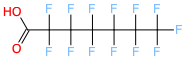

O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF7acid
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([305.233,360.007,401.935,433.475,473.953,496.019,519.828],'J/(mol*K)'), H298=(-3028.41,'kJ/mol'), S298=(570.84,'J/(mol*K)'), Cp0=(35.4532,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-8.98963,-10.8093,-7.21363,-6.01401,-6.07358,-3.95494,7.07847],'J/(mol*K)'), H298=(276.919,'kJ/mol'), S298=(12.5502,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDista

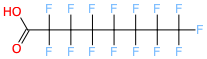

O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF8acid
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([348.543,412.126,460.135,495.725,540.458,564.316,589.821],'J/(mol*K)'), H298=(-3430.87,'kJ/mol'), S298=(617.106,'J/(mol*K)'), Cp0=(27.3638,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-11.4471,-13.6093,-9.30056,-7.77792,-7.65513,-5.00574,8.1651],'J/(mol*K)'), H298=(329.213,'kJ/mol'), S298=(15.761,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + lon

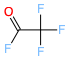

O=C(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF2acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.7711,103.449,113.998,122.033,132.676,138.913,146.685],'J/(mol*K)'), H298=(-996.595,'kJ/mol'), S298=(327.138,'J/(mol*K)'), Cp0=(22.7621,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-COF1sF1sF1s) + missing(CO-CsF1sO2d)""")

missing
['CsCOFFF_Cs-(F1sO2d)COF1sF1sF1s', 'COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.1343,102.928,113.606,121.703,132.405,138.873,146.612],'J/(mol*K)','+|-',[2.47033,2.58232,2.42112,2.24809,1.9491,1.7308,3.34534]), H298=(-1018.14,'kJ/mol','+|-',11.

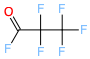

O=C(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF3acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.793,156.211,171.94,183.371,197.787,206.103,216.023],'J/(mol*K)'), H298=(-1402.41,'kJ/mol'), S298=(380.94,'J/(mol*K)'), Cp0=(19.1111,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([4.26076,3.69799,3.62377,2.99384,1.59794,0.855397,2.15483],'J/(mol*K)'), H298=(73.258,'kJ/mol'), S298=(0.607094,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-CO) + missing(CO-CsF1sO2d)""")

missing
['CsCCFF_Cs-COCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE

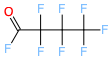

O=C(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF4acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([179.565,208.852,230.124,245.376,264.174,274.68,286.585],'J/(mol*K)'), H298=(-1805.14,'kJ/mol'), S298=(431.975,'J/(mol*K)'), Cp0=(18.7426,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.61706,-2.40918,-0.952814,-0.722261,-1.32892,-0.802559,3.81859],'J/(mol*K)'), H298=(120.038,'kJ/mol'), S298=(2.91806,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + missing(CO-CsF1sO2d)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCCFF_Cs-CO

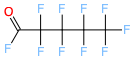

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF5acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([219.726,257.31,285.016,305.111,329.894,343.239,357.677],'J/(mol*K)'), H298=(-2212.78,'kJ/mol'), S298=(475.069,'J/(mol*K)'), Cp0=(20.119,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-4.07458,-5.20921,-3.03975,-2.48618,-2.91047,-1.85335,4.90522],'J/(mol*K)'), H298=(172.332,'kJ/mol'), S298=(6.12878,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteractio

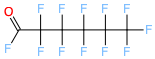

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF6acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([263.109,309.375,343.058,367.16,396.333,411.763,427.958],'J/(mol*K)'), H298=(-2615.34,'kJ/mol'), S298=(522.051,'J/(mol*K)'), Cp0=(11.9922,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.5321,-8.00923,-5.12669,-4.25009,-4.49202,-2.90415,5.99184],'J/(mol*K)'), H298=(224.626,'kJ/mol'), S298=(9.33951,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistan

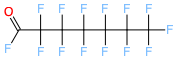

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF7acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([304.008,357.401,397.551,427.145,463.886,482.977,502.31],'J/(mol*K)'), H298=(-3017.76,'kJ/mol'), S298=(571.691,'J/(mol*K)'), Cp0=(32.8576,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-8.98963,-10.8093,-7.21363,-6.01401,-6.07358,-3.95494,7.07847],'J/(mol*K)'), H298=(276.919,'kJ/mol'), S298=(12.5502,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_non

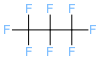

FC(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF3alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.231,171.565,190.703,204.9,222.77,232.354,242.911],'J/(mol*K)'), H298=(-1714.78,'kJ/mol'), S298=(390.308,'J/(mol*K)'), Cp0=(18.392,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.41771,-1.76262,0.267927,1.43944,1.90273,2.61778,5.80237],'J/(mol*K)'), H298=(101.204,'kJ/mol'), S298=(-1.20435,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([

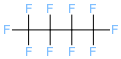

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF4alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([192.671,225.777,250.21,267.932,289.708,301.282,313.628],'J/(mol*K)'), H298=(-2115.5,'kJ/mol'), S298=(439.266,'J/(mol*K)'), Cp0=(17.5884,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-5.40454,-5.02763,-1.82266,-0.534652,-0.694912,0.503483,5.99682],'J/(mol*K)'), H298=(161.063,'kJ/mol'), S298=(0.840097,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-

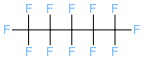

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF5alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([231.557,273.932,306.058,329.832,359.099,373.662,387.837],'J/(mol*K)'), H298=(-2522.41,'kJ/mol'), S298=(476.597,'J/(mol*K)'), Cp0=(21.5231,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-7.86206,-7.82766,-3.9096,-2.29857,-2.27646,-0.547312,7.08345],'J/(mol*K)'), H298=(213.357,'kJ/mol'), S298=(4.05082,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistance

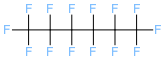

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF6alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([273.669,323.692,361.923,390.452,425.976,443.828,460.951],'J/(mol*K)'), H298=(-2924.75,'kJ/mol'), S298=(533.248,'J/(mol*K)'), Cp0=(29.5743,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-10.3196,-10.6277,-5.99653,-4.06248,-3.85802,-1.59811,8.17007],'J/(mol*K)'), H298=(265.651,'kJ/mol'), S298=(7.26155,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyc

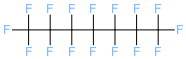

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF7alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([315.566,373.43,417.728,450.89,492.532,513.808,533.982],'J/(mol*K)'), H298=(-3327.45,'kJ/mol'), S298=(568.407,'J/(mol*K)'), Cp0=(33.2772,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-12.7771,-13.4277,-8.08347,-5.8264,-5.43957,-2.6489,9.2567],'J/(mol*K)'), H298=(317.944,'kJ/mol'), S298=(10.4723,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_nonc

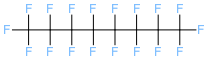

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF8alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([357.64,423.093,473.186,510.791,558.604,583.83,607.977],'J/(mol*K)'), H298=(-3729.72,'kJ/mol'), S298=(623.776,'J/(mol*K)'), Cp0=(36.1171,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-15.2346,-16.2277,-10.1704,-7.59032,-7.02112,-3.6997,10.3433],'J/(mol*K)'), H298=(370.238,'kJ/mol'), S298=(13.683,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteract

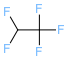

FC(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF2-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.0336,112.072,125.183,135.181,148.578,156.698,167.322],'J/(mol*K)'), H298=(-1083.75,'kJ/mol'), S298=(326.711,'J/(mol*K)'), Cp0=(10.6544,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.952312,-0.940249,-0.44155,-0.173174,-0.0885042,0.154087,1.51887],'J/(mol*K)'), H298=(42.3898,'kJ/mol'), S298=(1.23249,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.4111,115.909,128.141,137.541,150.657,159.101,168.647],'

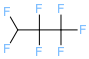

FC(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF3-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.389,159.026,178.344,193.231,212.969,224.189,237.755],'J/(mol*K)'), H298=(-1485.89,'kJ/mol'), S298=(382.835,'J/(mol*K)'), Cp0=(18.8693,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.93103,-3.91383,-1.9548,-1.14928,-1.13823,-0.273656,3.54172],'J/(mol*K)'), H298=(96.2185,'kJ/mol'), S298=(2.02541,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([

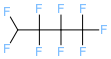

FC(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF4-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([181.891,214.596,239.204,257.446,280.634,293.526,308.406],'J/(mol*K)'), H298=(-1886.4,'kJ/mol'), S298=(430.751,'J/(mol*K)'), Cp0=(14.5369,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.38855,-6.71385,-4.04174,-2.9132,-2.71978,-1.32445,4.62835],'J/(mol*K)'), H298=(148.512,'kJ/mol'), S298=(5.23614,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + lo

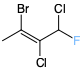

CC(Br)=C(Cl)C(F)Cl
Entry
CHOFClBr_G4
CC(Br)DC(Cl)C(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([138.408,160.105,177.802,192.664,215.814,232.016,253.684],'J/(mol*K)'), H298=(-222.402,'kJ/mol'), S298=(421.705,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.696,128.614,138.796,147.046,159.728,167.435,175.171],'J/(mol*K)'), H298=(-187.773,'kJ/mol'), S298=(299.07,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + group(CsCClFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7)) + group(CdCsCdCl) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7))""")

missing
['Cs-(Cds-Cds)HHH_Cs-(Br1sCd)CdHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([115.221,128.662,138.756,146.924,159.665,167.197,174.26

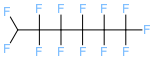

FC(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF6-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([262.082,311.353,349.752,378.99,416.479,436.073,456.246],'J/(mol*K)'), H298=(-2696.96,'kJ/mol'), S298=(514.898,'J/(mol*K)'), Cp0=(30.8202,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-11.3036,-12.3139,-8.21561,-6.44103,-5.88289,-3.42604,6.8016],'J/(mol*K)'), H298=(253.1,'kJ/mol'), S298=(11.6576,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-C

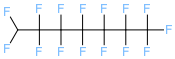

FC(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF7-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([304.108,361.142,405.512,439.301,482.851,505.95,529.38],'J/(mol*K)'), H298=(-3099.46,'kJ/mol'), S298=(560.316,'J/(mol*K)'), Cp0=(34.2819,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-13.7611,-15.1139,-10.3025,-8.20495,-7.46444,-4.47684,7.88823],'J/(mol*K)'), H298=(305.393,'kJ/mol'), S298=(14.8683,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncycl

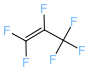

FC(F)=C(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF3ene
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.988,138.473,152.497,163.025,176.8,184.888,194.833],'J/(mol*K)'), H298=(-1111.52,'kJ/mol'), S298=(368.358,'J/(mol*K)'), Cp0=(26.1157,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.22461,-1.08955,-0.690637,-0.363734,-0.649873,-0.721417,-0.252932],'J/(mol*K)'), H298=(74.3471,'kJ/mol'), S298=(0.479018,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cds(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)2) + missing(Cd-CdCsF1s) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol

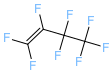

FC(F)=C(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF4ene
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([163.819,189.955,209.307,223.482,241.483,251.836,264.099],'J/(mol*K)'), H298=(-1519.47,'kJ/mol'), S298=(423.563,'J/(mol*K)'), Cp0=(24.9074,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.891744,-0.678874,0.205521,0.661222,0.398169,0.56235,3.00731],'J/(mol*K)'), H298=(104.468,'kJ/mol'), S298=(4.41178,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cd-CdCsF1s) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400

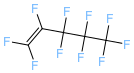

FC(F)=C(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF5ene
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([204.058,237.333,262.431,281.103,305.026,318.498,334.041],'J/(mol*K)'), H298=(-1933.86,'kJ/mol'), S298=(470.978,'J/(mol*K)'), Cp0=(34.1765,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.35012,-1.77408,-0.422845,-0.00105897,-0.629723,0.0434224,4.39559],'J/(mol*K)'), H298=(152.727,'kJ/mol'), S298=(3.12933,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CdCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + missing(Cd-CdCsF1s) + missing(Cd-CdF1sF1s) + longDistanceInterac

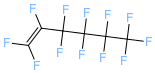

FC(F)=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF6ene
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([249.403,292.017,323.261,345.821,373.6,388.702,405.209],'J/(mol*K)'), H298=(-2334.81,'kJ/mol'), S298=(515.874,'J/(mol*K)'), Cp0=(20.3718,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.80764,-4.5741,-2.50978,-1.76497,-2.21127,-1.00737,5.48222],'J/(mol*K)'), H298=(205.021,'kJ/mol'), S298=(6.34005,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CdCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInter

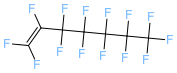

FC(F)=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF7ene
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([291.218,341.697,379.331,406.871,440.918,458.825,477.538],'J/(mol*K)'), H298=(-2737.19,'kJ/mol'), S298=(564.186,'J/(mol*K)'), Cp0=(29.9367,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.26517,-7.37413,-4.59672,-3.52889,-3.79283,-2.05817,6.56884],'J/(mol*K)'), H298=(257.315,'kJ/mol'), S298=(9.55078,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDi

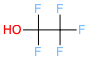

OC(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF2ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.703,130.722,144.732,154.99,168.225,176.276,186.907],'J/(mol*K)'), H298=(-1295.74,'kJ/mol'), S298=(340.438,'J/(mol*K)'), Cp0=(8.87778,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.952312,-0.940249,-0.44155,-0.173174,-0.0885042,0.154087,1.51887],'J/(mol*K)'), H298=(42.3898,'kJ/mol'), S298=(1.23249,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['O2s-CsH_O2s-CsH', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.701,136.903,

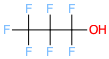

OC(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF3ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([150.154,177.403,197.958,213.266,232.961,244.209,257.743],'J/(mol*K)'), H298=(-1696.5,'kJ/mol'), S298=(394.713,'J/(mol*K)'), Cp0=(10.8745,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.93103,-3.91383,-1.9548,-1.14928,-1.13823,-0.273656,3.54172],'J/(mol*K)'), H298=(96.2185,'kJ/mol'), S298=(2.02541,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE

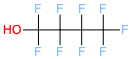

OC(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF4ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([198.871,233.96,259.628,278.163,301.172,314.05,328.858],'J/(mol*K)'), H298=(-2096.97,'kJ/mol'), S298=(441.94,'J/(mol*K)'), Cp0=(8.79654,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.38855,-6.71385,-4.04174,-2.9132,-2.71978,-1.32445,4.62835],'J/(mol*K)'), H298=(148.512,'kJ/mol'), S298=(5.23614,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing

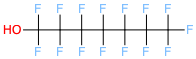

OC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF7ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([320.527,379.708,425.18,459.416,503.012,526.038,549.435],'J/(mol*K)'), H298=(-3315.62,'kJ/mol'), S298=(572.444,'J/(mol*K)'), Cp0=(32.8133,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-13.7611,-15.1139,-10.3025,-8.20495,-7.46444,-4.47684,7.88823],'J/(mol*K)'), H298=(305.393,'kJ/mol'), S298=(14.8683,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDista

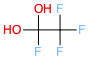

OC(O)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF2diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([115.961,136.912,152.545,164.149,179.399,188.859,202.04],'J/(mol*K)'), H298=(-1268.26,'kJ/mol'), S298=(339.477,'J/(mol*K)'), Cp0=(5.20608,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0.320405,0.817955,0.961123,0.880159,0.633403,0.511573,1.05779],'J/(mol*K)'), H298=(27.811,'kJ/mol'), S298=(-0.856921,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsF1sO2sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F))""")

missing
['O2s-CsH_O2s-CsH', 'O2s-CsH_O2s-CsH', 'CsCFOO_Cs-CsF1sO2sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,15

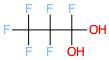

OC(O)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF3diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([159.009,188.811,210.516,226.201,246.053,257.902,273.13],'J/(mol*K)'), H298=(-1673.22,'kJ/mol'), S298=(389.718,'J/(mol*K)'), Cp0=(-5.10321,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.18691,-1.57637,-0.386261,0.10262,0.211261,0.66874,2.89122],'J/(mol*K)'), H298=(61.947,'kJ/mol'), S298=(2.04375,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sO2sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['O2s-CsH_O2s-CsH', 'O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCFOO_Cs-CsF1sO2sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H

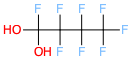

OC(O)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF4diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([201.589,239.388,267.548,288.252,314.456,329.21,346.538],'J/(mol*K)'), H298=(-2073.26,'kJ/mol'), S298=(437.248,'J/(mol*K)'), Cp0=(3.8598,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-5.16563,-4.54995,-1.89951,-0.873491,-0.838467,0.240997,4.91407],'J/(mol*K)'), H298=(115.776,'kJ/mol'), S298=(2.83666,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sO2sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missi

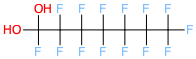

OC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF7diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([324.469,385.144,432.01,467.541,513.434,538.371,565.088],'J/(mol*K)'), H298=(-3303.9,'kJ/mol'), S298=(570.149,'J/(mol*K)'), Cp0=(31.6682,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-12.5382,-12.95,-8.16032,-6.16524,-5.58312,-2.91139,8.17395],'J/(mol*K)'), H298=(272.657,'kJ/mol'), S298=(12.4688,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2

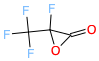

O=C1OC1(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF3lactone
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.714,137.64,152.343,163.095,176.8,184.839,194.742],'J/(mol*K)'), H298=(-988.263,'kJ/mol'), S298=(363.675,'J/(mol*K)'), Cp0=(10.8454,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.83868,-5.5079,-8.06274,-10.6936,-14.2274,-15.9123,-14.4608],'J/(mol*K)'), H298=(241.452,'kJ/mol'), S298=(156.853,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-COCsF1sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + missing(CO-CsO2dO2s) + longDistanceInteraction_cyclic(Cs(F)-CO) + ring(O2s-CO(O2d)-Cs(F))""")

missing
['O2s-Cs(Cds-O2d)_O2s-(CsF1s)(O2d)COCs', 'CsCCFO_Cs-COCsF1sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'Cds-OdCsOs_CO-CsO2dO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.15909,-6.32585,-9.02387,-11.5737

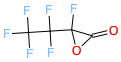

O=C1OC1(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF4lactone
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([159.288,186.638,207.18,222.386,241.701,252.464,264.886],'J/(mol*K)'), H298=(-1393.09,'kJ/mol'), S298=(419.036,'J/(mol*K)'), Cp0=(18.7398,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-5.346,-7.90222,-9.41013,-11.4711,-14.6495,-15.7552,-12.6274],'J/(mol*K)'), H298=(275.588,'kJ/mol'), S298=(159.753,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-COCsF1sO2s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + missing(CO-CsO2dO2s) + longDistanceInteraction_cyclic(Cs(F)-CO) + ring(O2s-CO(O2d)-Cs(F))""")

missing
['O2s-Cs(Cds-O2d)_O2s-(CsF1s)(O2d)COCs', 'CsCCFO_Cs-COCsF1sO2s', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'Cds-OdCsOs_CO-CsO2dO2s']

GAE without esti

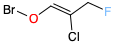

FCC(Cl)=COBr
Entry
CHOFClBr_G4
FCC(Cl)DCOBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([115.529,132.182,146.439,158.448,176.802,189.22,204.678],'J/(mol*K)'), H298=(-184.268,'kJ/mol'), S298=(408.747,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([81.8493,91.9831,100.221,106.896,116.7,122.707,129.821],'J/(mol*K)'), H298=(30.2184,'kJ/mol'), S298=(257.818,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + missing(Cs-CdF1sHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cds(Val7)) + group(CdCsCdCl) + longDistanceInteraction_noncyclic(Cd(Cl)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCFHH_Cs-CdF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.0412,97.7753,105.877,111.495,119.05,123.382,129.122],'J/(mol*K)'), H298=(1.27438,'kJ/mol'), S298=(248.221,'J/(mol*K)'), comment="""Thermo group 

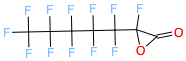

O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF7lactone
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([285.177,337.506,377.461,407.252,444.345,463.087,481.755],'J/(mol*K)'), H298=(-2614.64,'kJ/mol'), S298=(553.561,'J/(mol*K)'), Cp0=(29.2701,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-13.2398,-16.4759,-15.0973,-15.975,-18.8623,-18.2845,-8.43129],'J/(mol*K)'), H298=(434.005,'kJ/mol'), S298=(166.968,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-COCsF1sO2s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistan

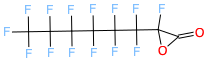

O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF8lactone
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([327.137,387.142,433.132,467.599,510.962,533.241,555.13],'J/(mol*K)'), H298=(-3017.03,'kJ/mol'), S298=(602.017,'J/(mol*K)'), Cp0=(35.1104,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-15.6973,-19.2759,-17.1842,-17.739,-20.4439,-19.3353,-7.34466],'J/(mol*K)'), H298=(486.298,'kJ/mol'), S298=(170.178,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-COCsF1sO2s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + long

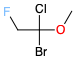

COC(Cl)(Br)CF
Entry
CHOFClBr_G4
COC(Cl)(Br)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.867,152.296,171.164,186.898,210.537,226.091,244.539],'J/(mol*K)'), H298=(-433.517,'kJ/mol'), S298=(355.141,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.3689,78.1908,82.938,86.8008,92.0352,94.4966,94.6817],'J/(mol*K)'), H298=(-134.479,'kJ/mol'), S298=(129.504,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(CsBrCClO) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsF1sHH) + missing(Cs-O2sHHH)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([73.0643,79.662,83.9532,87.6629,92.7006,94.835,93.7787],'J/(mol*K)'), H298=(-144.247,'kJ/mol'), S298=(126.987,'J/(mol*K)'), comment="""Thermo group additivity estimati

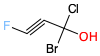

OC(Cl)(Br)C#CF
Entry
CHOFClBr_G4
OC(Cl)(Br)C#CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.304,135.317,141.729,146.996,154.825,159.955,166.544],'J/(mol*K)'), H298=(-64.8329,'kJ/mol'), S298=(385.144,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.3643,66.262,70.3732,73.1229,75.9906,76.545,73.6087],'J/(mol*K)'), H298=(-45.6466,'kJ/mol'), S298=(88.377,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(CsBrCClO) + missing(Ct-CsCt) + missing(Ct-CtF1s)""")

missing
['O2s-CsH_O2s-CsH', 'Ct-CtCs_Ct-CsCt', 'CtCF_Ct-CtF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.3643,66.262,70.3732,73.1229,75.9906,76.545,73.6087],'J/(mol*K)'), H298=(-45.6466,'kJ/mol'), S298=(88.377,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCClO)""")

GAE with fitted GAV
The

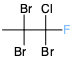

CC(Br)(Br)C(F)(Cl)Br
Entry
CHOFClBr_G4
CC(Br)(Br)C(F)(Cl)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([147.099,167.133,181.58,192.449,208.579,220.373,236.787],'J/(mol*K)'), H298=(-236.819,'kJ/mol'), S298=(435.861,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(257.749,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([122.512,134.619,142.843,148.859,156.896,160.918,162.431],'J/(mol*K)'), H298=(-192.432,'kJ/mol'), S298=(316.581,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + missing(Cs-CsHHH) + group(CsBrCClF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7)2)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.195,137.178,144.781,150.578,158.434,162.081,161.338],'J/(mol*K)'), H298=(-211.812,'kJ/mol'), S298=(311.799,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + gr

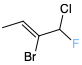

CC=C(Br)C(F)Cl
Entry
CHOFClBr_G4
CCDC(Br)C(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.467,143.983,161.948,177.323,201.476,218.598,242.064],'J/(mol*K)'), H298=(-205.99,'kJ/mol'), S298=(404.126,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([81.4669,92.4552,100.72,107.243,117.148,123.373,130.38],'J/(mol*K)'), H298=(-195.894,'kJ/mol'), S298=(239.327,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + group(CsCClFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + missing(Cd-CdCsH) + group(CdBrCsCd)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdH)CdHHH', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([83.607,93.8454,101.542,107.771,117.337,123.141,128.689],'J/(mol*K)'), H298=(-210.866,'kJ/mol'), S298=(237.445,'J/(mol*K)'), comment="""Thermo group additivi

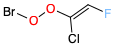

FC=C(Cl)OOBr
Entry
CHOFClBr_G4
FCDC(Cl)OOBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.604,138.058,146.041,152.347,160.953,165.628,168.856],'J/(mol*K)'), H298=(-87.2478,'kJ/mol'), S298=(390.579,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.0032,91.8351,94.7325,97.6618,102.637,104.344,104.985],'J/(mol*K)'), H298=(102.887,'kJ/mol'), S298=(269.188,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-Cd)) + group(O2sBrO) + group(CdCClO) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7))""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.3886,90.4922,93.8714,97.0114,102.385,104.339,105.773],'J/(mol*K)'), H298=(88.4478,'kJ/mol'), S298=(269.411,'J/(mol*K)'), comment="""

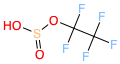

FC(C(F)(F)F)(OS(=O)O)F
Entry
NCSU_C2_C8_PFAS
PF2Sulfite
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([165.615,191.602,209.28,221.21,235.414,244.068,254.196],'J/(mol*K)'), H298=(-1539.47,'kJ/mol'), S298=(422.76,'J/(mol*K)'), Cp0=(4.19508,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.952312,-0.940249,-0.44155,-0.173174,-0.0885042,0.154087,1.51887],'J/(mol*K)'), H298=(42.3898,'kJ/mol'), S298=(1.23249,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(S4d-O2dO2sO2s) + missing(O2s-CsS4d) + missing(O2s-S4dH) + missing(O2d-S4d) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['S4d-OdOO_S4d-O2dO2sO2s', 'O2s-CS4_O2s-CsS4d', 'O2s-S_DeH_O2s-S4dH', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'),

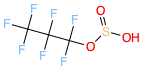

FC(C(C(F)(F)F)(F)F)(OS(=O)O)F
Entry
NCSU_C2_C8_PFAS
PF3Sulfite
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([203.918,237.388,261.102,277.777,298.284,310.278,323.578],'J/(mol*K)'), H298=(-1940.45,'kJ/mol'), S298=(480.613,'J/(mol*K)'), Cp0=(10.0266,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.93103,-3.91383,-1.9548,-1.14928,-1.13823,-0.273656,3.54172],'J/(mol*K)'), H298=(96.2185,'kJ/mol'), S298=(2.02541,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(S4d-O2dO2sO2s) + missing(O2s-CsS4d) + missing(O2s-S4dH) + missing(O2d-S4d) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['S4d-OdOO_S4d-O2dO2sO2

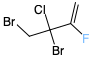

C=C(F)C(Cl)(Br)CBr
Entry
CHOFClBr_G4
CDC(F)C(Cl)(Br)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([140.535,163.726,182.045,196.638,218.172,233.263,254.557],'J/(mol*K)'), H298=(-164.792,'kJ/mol'), S298=(421.058,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.3936,109.562,119.858,127.799,139.084,146.174,153.602],'J/(mol*K)'), H298=(-31.8499,'kJ/mol'), S298=(259.662,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCCl) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + group(CsBrCsHH) + missing(Cd-CdCsF1s) + missing(Cd-CdHH)""")

missing
['CdCsCdF_Cd-CdCsF1s', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.229,112.423,121.695,129.19,139.938,146.279,151.007],'J/(mol*K)'), H298=(-56.5892,'kJ/mol'), S298=

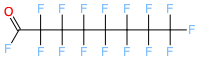

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF8acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([348.505,409.756,454.931,487.661,527.726,548.696,570.191],'J/(mol*K)'), H298=(-3419.7,'kJ/mol'), S298=(627.143,'J/(mol*K)'), Cp0=(24.2982,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-11.4471,-13.6093,-9.30056,-7.77792,-7.65513,-5.00574,8.1651],'J/(mol*K)'), H298=(329.213,'kJ/mol'), S298=(15.761,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteractio

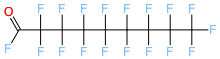

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF9acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([391.396,460.502,511.445,548.323,593.383,616.872,640.738],'J/(mol*K)'), H298=(-3822.6,'kJ/mol'), S298=(677.935,'J/(mol*K)'), Cp0=(25.3939,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-13.9047,-16.4093,-11.3875,-9.54184,-9.23668,-6.05653,9.25172],'J/(mol*K)'), H298=(381.507,'kJ/mol'), S298=(18.9717,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceI

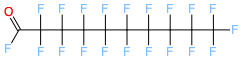

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF10acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([434.287,511.249,567.958,608.985,659.04,685.048,711.284],'J/(mol*K)'), H298=(-4225.5,'kJ/mol'), S298=(728.728,'J/(mol*K)'), Cp0=(26.4897,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-16.3622,-19.2093,-13.4744,-11.3058,-10.8182,-7.10733,10.3383],'J/(mol*K)'), H298=(433.8,'kJ/mol'), S298=(22.1824,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDist

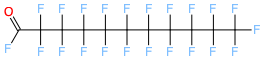

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF11acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([477.178,561.995,624.471,669.646,724.697,753.223,781.83],'J/(mol*K)'), H298=(-4628.4,'kJ/mol'), S298=(779.52,'J/(mol*K)'), Cp0=(27.5854,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-18.8197,-22.0094,-15.5614,-13.0697,-12.3998,-8.15812,11.425],'J/(mol*K)'), H298=(486.094,'kJ/mol'), S298=(25.3931,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + l

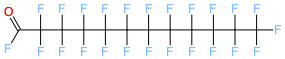

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF12acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([520.069,612.741,680.984,730.308,790.354,821.399,852.376],'J/(mol*K)'), H298=(-5031.3,'kJ/mol'), S298=(830.313,'J/(mol*K)'), Cp0=(28.6812,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-21.2772,-24.8094,-17.6483,-14.8336,-13.9813,-9.20892,12.5116],'J/(mol*K)'), H298=(538.388,'kJ/mol'), S298=(28.6039,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2

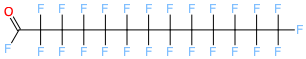

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF13acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([562.961,663.488,737.497,790.97,856.011,889.575,922.923],'J/(mol*K)'), H298=(-5434.2,'kJ/mol'), S298=(881.105,'J/(mol*K)'), Cp0=(29.7769,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-23.7348,-27.6094,-19.7353,-16.5975,-15.5629,-10.2597,13.5982],'J/(mol*K)'), H298=(590.682,'kJ/mol'), S298=(31.8146,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF

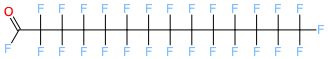

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF14acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([605.852,714.234,794.01,851.631,921.668,957.75,993.469],'J/(mol*K)'), H298=(-5837.1,'kJ/mol'), S298=(931.898,'J/(mol*K)'), Cp0=(30.8726,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-26.1923,-30.4094,-21.8222,-18.3614,-17.1444,-11.3105,14.6849],'J/(mol*K)'), H298=(642.975,'kJ/mol'), S298=(35.0253,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncycl

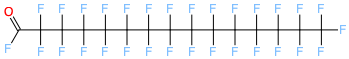

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF15acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([648.743,764.981,850.523,912.293,987.325,1025.93,1064.02],'J/(mol*K)'), H298=(-6240,'kJ/mol'), S298=(982.69,'J/(mol*K)'), Cp0=(31.9684,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-28.6498,-33.2095,-23.9091,-20.1253,-18.726,-12.3613,15.7715],'J/(mol*K)'), H298=(695.269,'kJ/mol'), S298=(38.236,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_non

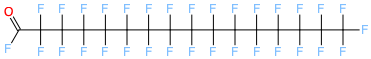

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF16acylF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([691.634,815.727,907.036,972.955,1052.98,1094.1,1134.56],'J/(mol*K)'), H298=(-6642.9,'kJ/mol'), S298=(1033.48,'J/(mol*K)'), Cp0=(33.0641,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-31.1073,-36.0095,-25.9961,-21.8893,-20.3075,-13.4121,16.8581],'J/(mol*K)'), H298=(747.563,'kJ/mol'), S298=(41.4468,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInte

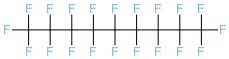

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF9alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([400.328,473.694,529.762,571.752,624.773,652.082,678.042],'J/(mol*K)'), H298=(-4121.8,'kJ/mol'), S298=(676.022,'J/(mol*K)'), Cp0=(39.3955,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-17.6922,-19.0278,-12.2573,-9.35423,-8.60267,-4.75049,11.43],'J/(mol*K)'), H298=(422.532,'kJ/mol'), S298=(16.8937,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistance

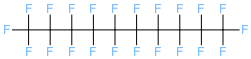

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF10alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([442.466,523.7,585.833,632.406,691.269,721.601,750.291],'J/(mol*K)'), H298=(-4520.58,'kJ/mol'), S298=(725.305,'J/(mol*K)'), Cp0=(43.5346,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-20.1497,-21.8278,-14.3443,-11.1181,-10.1842,-5.80129,12.5166],'J/(mol*K)'), H298=(474.826,'kJ/mol'), S298=(20.1045,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + lon

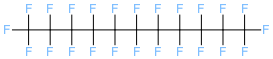

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF11alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([484.605,573.706,641.905,693.059,757.766,791.119,822.54],'J/(mol*K)'), H298=(-4919.36,'kJ/mol'), S298=(774.587,'J/(mol*K)'), Cp0=(47.6736,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-22.6072,-24.6278,-16.4312,-12.8821,-11.7658,-6.85208,13.6032],'J/(mol*K)'), H298=(527.119,'kJ/mol'), S298=(23.3152,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF

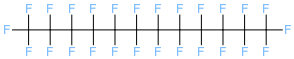

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF12alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([526.744,623.711,697.977,753.713,824.263,860.638,894.789],'J/(mol*K)'), H298=(-5318.14,'kJ/mol'), S298=(823.87,'J/(mol*K)'), Cp0=(51.8127,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-25.0647,-27.4278,-18.5182,-14.646,-13.3473,-7.90288,14.6898],'J/(mol*K)'), H298=(579.413,'kJ/mol'), S298=(26.5259,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-Cs

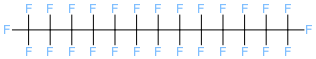

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF13alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([568.883,673.717,754.048,814.367,890.76,930.156,967.038],'J/(mol*K)'), H298=(-5716.92,'kJ/mol'), S298=(873.152,'J/(mol*K)'), Cp0=(55.9518,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-27.5222,-30.2279,-20.6051,-16.4099,-14.9289,-8.95367,15.7765],'J/(mol*K)'), H298=(631.707,'kJ/mol'), S298=(29.7366,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic

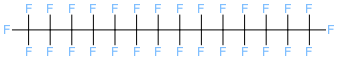

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF14alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([611.022,723.723,810.12,875.02,957.257,999.675,1039.29],'J/(mol*K)'), H298=(-6115.7,'kJ/mol'), S298=(922.435,'J/(mol*K)'), Cp0=(60.0909,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-29.9798,-33.0279,-22.692,-18.1738,-16.5104,-10.0045,16.8631],'J/(mol*K)'), H298=(684,'kJ/mol'), S298=(32.9474,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic

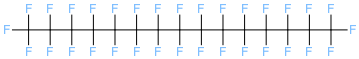

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF15alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([653.16,773.729,866.192,935.674,1023.75,1069.19,1111.54],'J/(mol*K)'), H298=(-6514.48,'kJ/mol'), S298=(971.718,'J/(mol*K)'), Cp0=(64.2299,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-32.4373,-35.8279,-24.779,-19.9377,-18.092,-11.0553,17.9497],'J/(mol*K)'), H298=(736.294,'kJ/mol'), S298=(36.1581,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteracti

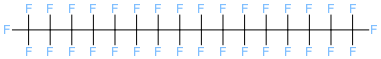

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF16alkane
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([695.299,823.735,922.263,996.328,1090.25,1138.71,1183.79],'J/(mol*K)'), H298=(-6913.26,'kJ/mol'), S298=(1021,'J/(mol*K)'), Cp0=(68.369,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-34.8948,-38.6279,-26.8659,-21.7016,-19.6735,-12.1061,19.0363],'J/(mol*K)'), H298=(788.588,'kJ/mol'), S298=(39.3688,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInt

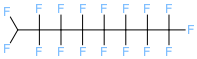

FC(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF8-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([346.714,411.778,462.067,500.146,548.876,574.241,599.617],'J/(mol*K)'), H298=(-3497.92,'kJ/mol'), S298=(615.548,'J/(mol*K)'), Cp0=(34.0246,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-16.2186,-17.914,-12.3895,-9.96886,-9.04599,-5.52763,8.97486],'J/(mol*K)'), H298=(357.687,'kJ/mol'), S298=(18.079,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_

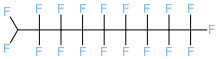

FC(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF9-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([388.779,461.834,518.263,560.956,615.493,643.75,671.613],'J/(mol*K)'), H298=(-3899.38,'kJ/mol'), S298=(664.305,'J/(mol*K)'), Cp0=(37.3379,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-18.6762,-20.714,-14.4764,-11.7328,-10.6275,-6.57842,10.0615],'J/(mol*K)'), H298=(409.981,'kJ/mol'), S298=(21.2898,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInter

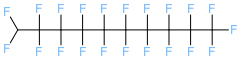

FC(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF10-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([430.844,511.89,574.459,621.766,682.109,713.258,743.608],'J/(mol*K)'), H298=(-4300.85,'kJ/mol'), S298=(713.063,'J/(mol*K)'), Cp0=(40.6511,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-21.1337,-23.514,-16.5634,-13.4967,-12.2091,-7.62922,11.1481],'J/(mol*K)'), H298=(462.275,'kJ/mol'), S298=(24.5005,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDista

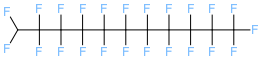

FC(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF11-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([472.908,561.946,630.655,682.576,748.726,782.767,815.603],'J/(mol*K)'), H298=(-4702.32,'kJ/mol'), S298=(761.82,'J/(mol*K)'), Cp0=(43.9644,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-23.5912,-26.314,-18.6503,-15.2606,-13.7906,-8.68001,12.2347],'J/(mol*K)'), H298=(514.568,'kJ/mol'), S298=(27.7112,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + lo

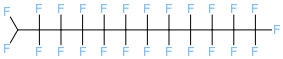

FC(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF12-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([514.973,612.002,686.851,743.386,815.342,852.276,887.598],'J/(mol*K)'), H298=(-5103.78,'kJ/mol'), S298=(810.578,'J/(mol*K)'), Cp0=(47.2776,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-26.0487,-29.1141,-20.7372,-17.0245,-15.3722,-9.73081,13.3214],'J/(mol*K)'), H298=(566.862,'kJ/mol'), S298=(30.9219,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-C

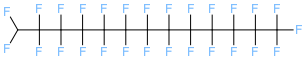

FC(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF13-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([557.038,662.058,743.047,804.196,881.959,921.784,959.594],'J/(mol*K)'), H298=(-5505.25,'kJ/mol'), S298=(859.335,'J/(mol*K)'), Cp0=(50.5908,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-28.5063,-31.9141,-22.8242,-18.7884,-16.9538,-10.7816,14.408],'J/(mol*K)'), H298=(619.156,'kJ/mol'), S298=(34.1327,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-

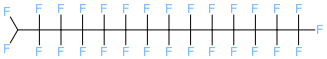

FC(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF14-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([599.102,712.114,799.243,865.006,948.575,991.293,1031.59],'J/(mol*K)'), H298=(-5906.72,'kJ/mol'), S298=(908.093,'J/(mol*K)'), Cp0=(53.9041,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-30.9638,-34.7141,-24.9111,-20.5524,-18.5353,-11.8324,15.4946],'J/(mol*K)'), H298=(671.449,'kJ/mol'), S298=(37.3434,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncycl

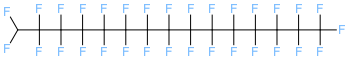

FC(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF15-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([641.167,762.17,855.44,925.816,1015.19,1060.8,1103.58],'J/(mol*K)'), H298=(-6308.18,'kJ/mol'), S298=(956.85,'J/(mol*K)'), Cp0=(57.2173,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-33.4213,-37.5141,-26.998,-22.3163,-20.1169,-12.8832,16.5812],'J/(mol*K)'), H298=(723.743,'kJ/mol'), S298=(40.5541,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncy

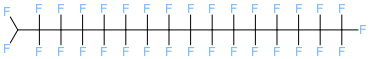

FC(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF16-1H
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([683.232,812.226,911.636,986.626,1081.81,1130.31,1175.58],'J/(mol*K)'), H298=(-6709.65,'kJ/mol'), S298=(1005.61,'J/(mol*K)'), Cp0=(60.5305,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-35.8788,-40.3142,-29.085,-24.0802,-21.6984,-13.934,17.6679],'J/(mol*K)'), H298=(776.037,'kJ/mol'), S298=(43.7649,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInterac

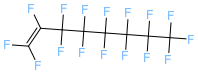

FC(F)=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF8ene
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([333.011,390.914,433.85,465.126,503.688,524.107,545.961],'J/(mol*K)'), H298=(-3158.4,'kJ/mol'), S298=(621.554,'J/(mol*K)'), Cp0=(29.7336,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-8.72269,-10.1742,-6.68366,-5.29281,-5.37438,-3.10896,7.65547],'J/(mol*K)'), H298=(309.608,'kJ/mol'), S298=(12.7615,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_no

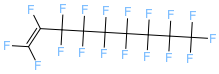

FC(F)=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF9ene
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([375.341,441.105,489.842,525.3,568.87,591.782,616.114],'J/(mol*K)'), H298=(-3569.79,'kJ/mol'), S298=(673.281,'J/(mol*K)'), Cp0=(30.8952,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-11.1802,-12.9742,-8.77059,-7.05672,-6.95593,-4.15976,8.7421],'J/(mol*K)'), H298=(361.902,'kJ/mol'), S298=(15.9722,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteracti

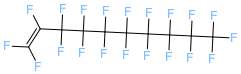

FC(F)=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF10ene
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([417.671,491.296,545.834,585.475,634.053,659.457,686.266],'J/(mol*K)'), H298=(-3981.18,'kJ/mol'), S298=(725.009,'J/(mol*K)'), Cp0=(32.0569,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-13.6377,-15.7742,-10.8575,-8.82064,-8.53748,-5.21055,9.82872],'J/(mol*K)'), H298=(414.196,'kJ/mol'), S298=(19.183,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistan

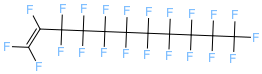

FC(F)=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF11ene
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([460.001,541.487,601.825,645.649,699.235,727.132,756.419],'J/(mol*K)'), H298=(-4392.58,'kJ/mol'), S298=(776.736,'J/(mol*K)'), Cp0=(33.2186,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-16.0953,-18.5742,-12.9445,-10.5846,-10.119,-6.26135,10.9153],'J/(mol*K)'), H298=(466.489,'kJ/mol'), S298=(22.3937,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + lon

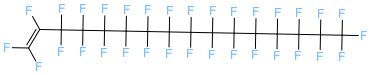

FC(F)=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF16ene
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([671.651,792.441,881.784,946.52,1025.15,1065.51,1107.18],'J/(mol*K)'), H298=(-6449.54,'kJ/mol'), S298=(1035.37,'J/(mol*K)'), Cp0=(39.0271,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-28.3829,-32.5744,-23.3792,-19.4041,-18.0268,-11.5153,16.3485],'J/(mol*K)'), H298=(727.958,'kJ/mol'), S298=(38.4473,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteract

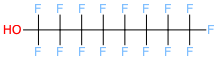

OC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF8ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([362.664,430.065,481.974,521.113,570.829,596.419,621.847],'J/(mol*K)'), H298=(-3721.07,'kJ/mol'), S298=(619.787,'J/(mol*K)'), Cp0=(36.8431,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-16.2186,-17.914,-12.3895,-9.96886,-9.04599,-5.52763,8.97486],'J/(mol*K)'), H298=(357.687,'kJ/mol'), S298=(18.079,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + lon

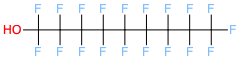

OC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF9ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([404.568,480.016,538.254,582.236,638.097,666.646,694.558],'J/(mol*K)'), H298=(-4125.73,'kJ/mol'), S298=(665.438,'J/(mol*K)'), Cp0=(41.9962,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-18.6762,-20.714,-14.4764,-11.7328,-10.6275,-6.57842,10.0615],'J/(mol*K)'), H298=(409.981,'kJ/mol'), S298=(21.2898,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF

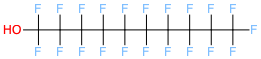

OC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF10ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([446.471,529.966,594.534,643.359,705.366,736.873,767.27],'J/(mol*K)'), H298=(-4530.39,'kJ/mol'), S298=(711.088,'J/(mol*K)'), Cp0=(47.1493,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-21.1337,-23.514,-16.5634,-13.4967,-12.2091,-7.62922,11.1481],'J/(mol*K)'), H298=(462.275,'kJ/mol'), S298=(24.5005,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-C

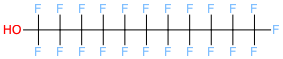

OC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF11ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([488.375,579.917,650.815,704.482,772.634,807.1,839.982],'J/(mol*K)'), H298=(-4935.05,'kJ/mol'), S298=(756.739,'J/(mol*K)'), Cp0=(52.3024,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-23.5912,-26.314,-18.6503,-15.2606,-13.7906,-8.68001,12.2347],'J/(mol*K)'), H298=(514.568,'kJ/mol'), S298=(27.7112,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(

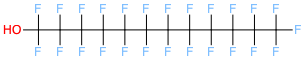

OC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF12ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([530.278,629.868,707.095,765.605,839.902,877.327,912.694],'J/(mol*K)'), H298=(-5339.71,'kJ/mol'), S298=(802.39,'J/(mol*K)'), Cp0=(57.4555,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-26.0487,-29.1141,-20.7372,-17.0245,-15.3722,-9.73081,13.3214],'J/(mol*K)'), H298=(566.862,'kJ/mol'), S298=(30.9219,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_n

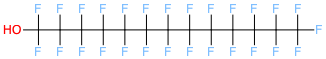

OC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF13ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([572.182,679.818,763.375,826.728,907.17,947.554,985.406],'J/(mol*K)'), H298=(-5744.37,'kJ/mol'), S298=(848.04,'J/(mol*K)'), Cp0=(62.6086,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-28.5063,-31.9141,-22.8242,-18.7884,-16.9538,-10.7816,14.408],'J/(mol*K)'), H298=(619.156,'kJ/mol'), S298=(34.1327,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteract

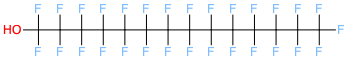

OC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF14ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([614.085,729.769,819.655,887.85,974.438,1017.78,1058.12],'J/(mol*K)'), H298=(-6149.03,'kJ/mol'), S298=(893.691,'J/(mol*K)'), Cp0=(67.7617,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-30.9638,-34.7141,-24.9111,-20.5524,-18.5353,-11.8324,15.4946],'J/(mol*K)'), H298=(671.449,'kJ/mol'), S298=(37.3434,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanc

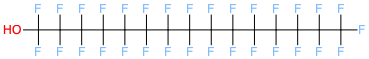

OC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF15ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([655.989,779.719,875.936,948.973,1041.71,1088.01,1130.83],'J/(mol*K)'), H298=(-6553.69,'kJ/mol'), S298=(939.342,'J/(mol*K)'), Cp0=(72.9148,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-33.4213,-37.5141,-26.998,-22.3163,-20.1169,-12.8832,16.5812],'J/(mol*K)'), H298=(723.743,'kJ/mol'), S298=(40.5541,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + long

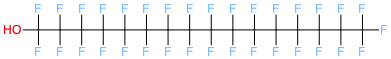

OC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF16ol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([697.893,829.67,932.216,1010.1,1108.97,1158.24,1203.54],'J/(mol*K)'), H298=(-6958.34,'kJ/mol'), S298=(984.992,'J/(mol*K)'), Cp0=(78.0679,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-35.8788,-40.3142,-29.085,-24.0802,-21.6984,-13.934,17.6679],'J/(mol*K)'), H298=(776.037,'kJ/mol'), S298=(43.7649,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + 

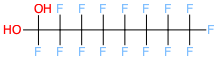

OC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF8diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([366.067,434.711,487.982,528.513,580.84,608.587,637.615],'J/(mol*K)'), H298=(-3715.24,'kJ/mol'), S298=(619.827,'J/(mol*K)'), Cp0=(38.4423,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-14.9957,-15.7501,-10.2473,-7.92915,-7.16468,-3.96218,9.26057],'J/(mol*K)'), H298=(324.951,'kJ/mol'), S298=(15.6796,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic

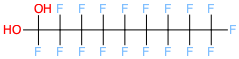

OC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF9diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([407.582,484.077,543.625,589.036,647.693,678.571,710.34],'J/(mol*K)'), H298=(-4123.46,'kJ/mol'), S298=(666.042,'J/(mol*K)'), Cp0=(45.3817,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-17.4532,-18.5501,-12.3342,-9.69307,-8.74623,-5.01298,10.3472],'J/(mol*K)'), H298=(377.244,'kJ/mol'), S298=(18.8903,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_no

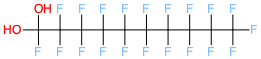

OC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF10diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([449.098,533.442,599.268,649.56,714.546,748.556,783.065],'J/(mol*K)'), H298=(-4531.68,'kJ/mol'), S298=(712.257,'J/(mol*K)'), Cp0=(52.3211,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-19.9108,-21.3501,-14.4211,-11.457,-10.3278,-6.06377,11.4338],'J/(mol*K)'), H298=(429.538,'kJ/mol'), S298=(22.101,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteract

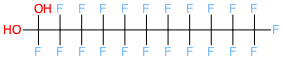

OC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF11diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([490.613,582.808,654.911,710.083,781.399,818.54,855.79],'J/(mol*K)'), H298=(-4939.9,'kJ/mol'), S298=(758.471,'J/(mol*K)'), Cp0=(59.2605,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-22.3683,-24.1501,-16.5081,-13.2209,-11.9093,-7.11457,12.5205],'J/(mol*K)'), H298=(481.832,'kJ/mol'), S298=(25.3117,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceI

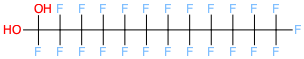

OC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF12diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([532.128,632.173,710.554,770.607,848.252,888.525,928.515],'J/(mol*K)'), H298=(-5348.13,'kJ/mol'), S298=(804.686,'J/(mol*K)'), Cp0=(66.1999,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-24.8258,-26.9501,-18.595,-14.9848,-13.4909,-8.16536,13.6071],'J/(mol*K)'), H298=(534.126,'kJ/mol'), S298=(28.5225,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + long

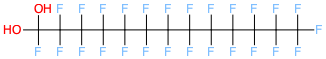

OC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF13diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([573.643,681.538,766.197,831.13,915.105,958.509,1001.24],'J/(mol*K)'), H298=(-5756.35,'kJ/mol'), S298=(850.901,'J/(mol*K)'), Cp0=(73.1393,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-27.2833,-29.7502,-20.6819,-16.7487,-15.0724,-9.21616,14.6937],'J/(mol*K)'), H298=(586.419,'kJ/mol'), S298=(31.7332,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2)

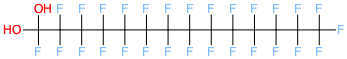

OC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF14diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([615.158,730.904,821.84,891.654,981.958,1028.49,1073.96],'J/(mol*K)'), H298=(-6164.57,'kJ/mol'), S298=(897.116,'J/(mol*K)'), Cp0=(80.0786,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-29.7409,-32.5502,-22.7689,-18.5126,-16.654,-10.267,15.7803],'J/(mol*K)'), H298=(638.713,'kJ/mol'), S298=(34.9439,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-

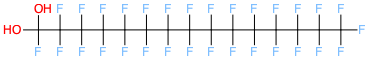

OC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF15diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([656.674,780.269,877.483,952.177,1048.81,1098.48,1146.69],'J/(mol*K)'), H298=(-6572.79,'kJ/mol'), S298=(943.33,'J/(mol*K)'), Cp0=(87.018,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-32.1984,-35.3502,-24.8558,-20.2766,-18.2355,-11.3177,16.867],'J/(mol*K)'), H298=(691.007,'kJ/mol'), S298=(38.1547,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF

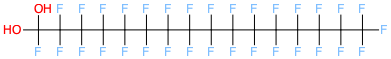

OC(O)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF16diol
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([698.189,829.635,933.126,1012.7,1115.66,1168.46,1219.41],'J/(mol*K)'), H298=(-6981.02,'kJ/mol'), S298=(989.545,'J/(mol*K)'), Cp0=(93.9574,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-34.6559,-38.1502,-26.9428,-22.0405,-19.8171,-12.3685,17.9536],'J/(mol*K)'), H298=(743.3,'kJ/mol'), S298=(41.3654,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyc

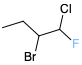

CCC(Br)C(F)Cl
Entry
CHOFClBr_G4
CCC(Br)C(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([144.819,168.324,188.584,205.958,233.368,252.983,280.71],'J/(mol*K)'), H298=(-331.337,'kJ/mol'), S298=(407.323,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.2541,103.837,114.192,122.407,134.468,141.867,149.562],'J/(mol*K)'), H298=(-260.458,'kJ/mol'), S298=(236.182,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsBrCsCsH) + missing(Cs-CsHHH) + group(CsCClFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.9495,105.308,115.207,123.269,135.134,142.205,148.659],'J/(mol*K)'), H298=(-270.226,'kJ/mol'), S298=(233.665,'J/(mol*K)'), comment="""Thermo group additivity estimat

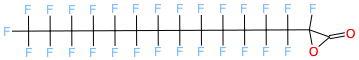

O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF15lactone
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([621.647,737.926,826.687,892.899,975.346,1016.2,1054.18],'J/(mol*K)'), H298=(-5886.14,'kJ/mol'), S298=(950.479,'J/(mol*K)'), Cp0=(51.4194,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-32.8999,-38.8761,-31.7928,-30.0864,-31.5148,-26.6909,0.261722],'J/(mol*K)'), H298=(852.354,'kJ/mol'), S298=(192.654,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-COCsF1sO2s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyc

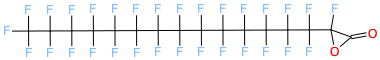

O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
NCSU_C2_C8_PFAS
PF16lactone
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([663.68,787.973,882.881,953.69,1041.84,1085.44,1125.78],'J/(mol*K)'), H298=(-6294.84,'kJ/mol'), S298=(999.652,'J/(mol*K)'), Cp0=(54.6778,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-35.3575,-41.6761,-33.8797,-31.8503,-33.0963,-27.7417,1.34835],'J/(mol*K)'), H298=(904.648,'kJ/mol'), S298=(195.864,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-COCsF1sO2s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_n

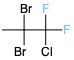

CC(Br)(Br)C(F)(F)Cl
Entry
CHOFClBr_G4
CC(Br)(Br)C(F)(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([140.339,159.073,174.486,187.356,206.757,219.626,235.391],'J/(mol*K)'), H298=(-488.879,'kJ/mol'), S298=(414.193,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(257.749,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.81,128.349,137.522,144.279,153.416,158.185,160.569],'J/(mol*K)'), H298=(-444.714,'kJ/mol'), S298=(297.728,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + missing(Cs-CsHHH) + group(CsCClFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7)2)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.493,130.909,139.46,145.997,154.954,159.348,159.476],'J/(mol*K)'), H298=(-464.094,'kJ/mol'), S298=(292.945,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + group(

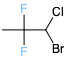

CC(F)(F)C(Cl)Br
Entry
CHOFClBr_G4
CC(F)(F)C(Cl)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.601,146.797,162.153,175.081,194.842,208.261,225.416],'J/(mol*K)'), H298=(-525.065,'kJ/mol'), S298=(390.578,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([53.0381,58.9648,64.5096,68.9426,75.459,79.8319,85.1898],'J/(mol*K)'), H298=(-17.5001,'kJ/mol'), S298=(195.125,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH) + group(CsBrCClH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([55.448,62.3161,67.4712,71.7163,77.8107,81.5148,84.6938],'J/(mol*K)'), H298=(-33.3065,'kJ/mol'), S298=(189.439,'J/(mo

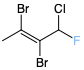

CC(Br)=C(Br)C(F)Cl
Entry
CHOFClBr_G4
CC(Br)DC(Br)C(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([140.296,161.179,178.645,193.479,216.512,232.542,253.818],'J/(mol*K)'), H298=(-173.307,'kJ/mol'), S298=(432.642,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.338,129.807,139.956,148.235,160.732,168.313,175.886],'J/(mol*K)'), H298=(-141.214,'kJ/mol'), S298=(308.107,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + group(CsCClFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cds(Br)=Cds(Br)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cds(Br)=Cds(Br))""")

missing
['Cs-(Cds-Cds)HHH_Cs-(Br1sCd)CdHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.879,130.063,140.056,148.059,160.54,167.913,174.794],'J/(m

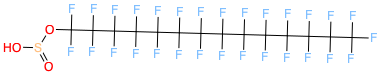

OS(=O)OC(C(C(C(C(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F
Entry
NCSU_C2_C8_PFAS
PF14Sulfite
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([666.213,791.986,885.929,954.569,1038.1,1078.95,1114.12],'J/(mol*K)'), H298=(-6435.51,'kJ/mol'), S298=(985.1,'J/(mol*K)'), Cp0=(20.7444,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-30.9638,-34.7141,-24.9111,-20.5524,-18.5353,-11.8324,15.4946],'J/(mol*K)'), H298=(671.449,'kJ/mol'), S298=(37.3434,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(S4d-O2dO2sO2s) + missing(O2s-CsS4d) + missing(O2s-S4dH) + missing(O2d-S4d) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F

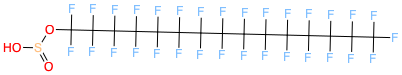

OS(=O)OC(C(C(C(C(C(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F
Entry
NCSU_C2_C8_PFAS
PF15Sulfite
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([708.201,842.227,942.445,1015.73,1104.94,1148.46,1185.71],'J/(mol*K)'), H298=(-6843.36,'kJ/mol'), S298=(1032.2,'J/(mol*K)'), Cp0=(22.126,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-33.4213,-37.5141,-26.998,-22.3163,-20.1169,-12.8832,16.5812],'J/(mol*K)'), H298=(723.743,'kJ/mol'), S298=(40.5541,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(S4d-O2dO2sO2s) + missing(O2s-CsS4d) + missing(O2s-S4dH) + missing(O2d-S4d) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncycl

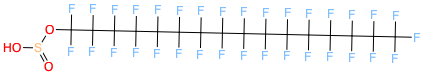

OS(=O)OC(C(C(C(C(C(C(C(C(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F
Entry
NCSU_C2_C8_PFAS
PF16Sulfite
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([750.188,892.468,998.961,1076.9,1171.79,1217.96,1257.3],'J/(mol*K)'), H298=(-7251.2,'kJ/mol'), S298=(1079.29,'J/(mol*K)'), Cp0=(23.5075,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-35.8788,-40.3142,-29.085,-24.0802,-21.6984,-13.934,17.6679],'J/(mol*K)'), H298=(776.037,'kJ/mol'), S298=(43.7649,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(S4d-O2dO2sO2s) + missing(O2s-CsS4d) + missing(O2s-S4dH) + missing(O2d-S4d) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_no

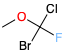

COC(F)(Cl)Br
Entry
CHOFClBr_G4
COC(F)(Cl)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.143,123.546,134.381,142.863,155.975,166.043,180.626],'J/(mol*K)'), H298=(-405.999,'kJ/mol'), S298=(370.788,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([80.6562,85.1133,89.0732,92.9498,99.7549,103.806,107.462],'J/(mol*K)'), H298=(-338.009,'kJ/mol'), S298=(248.804,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-O2sHHH) + group(CsBrClFO)""")

missing
['Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([80.6562,85.1133,89.0732,92.9498,99.7549,103.806,107.462],'J/(mol*K)'), H298=(-338.009,'kJ/mol'), S298=(248.804,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(CsBrClFO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,

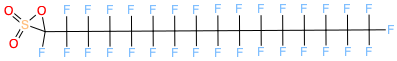

FC(C(C(C(C(C(C(C(C(C1(F)OS1(=O)=O)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)F
Entry
NCSU_C2_C8_PFAS
PF16Sultone
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([723.318,857.969,960.588,1037.06,1132.31,1179.51,1221.54],'J/(mol*K)'), H298=(-6777.75,'kJ/mol'), S298=(1056.78,'J/(mol*K)'), Cp0=(59.8049,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-25.8862,-20.5858,-1.61701,8.42741,12.4415,19.9654,50.7938],'J/(mol*K)'), H298=(936.183,'kJ/mol'), S298=(23.0591,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(S6dd-CsO2dO2dO2s) + missing(O2s-CsS6dd) + missing(O2d-S6dd) + missing(O2d-S6dd) + group(Cs-CsCsCsCs) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + 

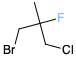

CC(F)(CCl)CBr
Entry
CHOFClBr_G4
CC(F)(CCl)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([144.124,171.156,192.661,210.853,238.926,258.279,283.637],'J/(mol*K)'), H298=(-346.467,'kJ/mol'), S298=(398.124,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([115.808,136.18,151.68,164.145,182.797,194.835,209.349],'J/(mol*K)'), H298=(-307.169,'kJ/mol'), S298=(279.635,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsClCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([118.239,138.174,153.118,165.465,

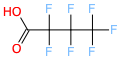

O=C(O)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C3F7C_O_OH
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([180.971,213.482,237.842,255.681,277.736,290.338,304.466],'J/(mol*K)'), H298=(-1860.35,'kJ/mol'), S298=(475.856,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.61706,-2.40918,-0.952814,-0.722261,-1.32892,-0.802559,3.81859],'J/(mol*K)'), H298=(120.038,'kJ/mol'), S298=(2.91806,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + missing(CO-CsO2dO2s)""")

missing
['O2s-(Cds-O2d)H_O2s-(CsO2d)COH', 'CsCsCsFF_Cs-Cs

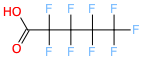

O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C4F9C_O_OH
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([227.379,265.49,294.363,315.679,342.089,357.054,373.591],'J/(mol*K)'), H298=(-2272.23,'kJ/mol'), S298=(542.752,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-4.07458,-5.20921,-3.03975,-2.48618,-2.91047,-1.85335,4.90522],'J/(mol*K)'), H298=(172.332,'kJ/mol'), S298=(6.12878,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncycl

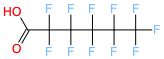

O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C5F11C_O_OH
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([284.989,329.211,361.131,383.943,412.133,427.781,445.003],'J/(mol*K)'), H298=(-2683.05,'kJ/mol'), S298=(599.724,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.5321,-8.00923,-5.12669,-4.25009,-4.49202,-2.90415,5.99184],'J/(mol*K)'), H298=(224.626,'kJ/mol'), S298=(9.33951,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceIntera

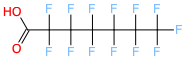

O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C6F13C_O_OH
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([338.879,390.115,425.598,450.233,480.72,497.396,515.74],'J/(mol*K)'), H298=(-3094.89,'kJ/mol'), S298=(660.836,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-8.98963,-10.8093,-7.21363,-6.01401,-6.07358,-3.95494,7.07847],'J/(mol*K)'), H298=(276.919,'kJ/mol'), S298=(12.5502,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF

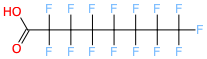

O=C(O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C7F15C_O_OH
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([390.552,449.64,488.835,515.305,548.608,566.38,586.048],'J/(mol*K)'), H298=(-3507.35,'kJ/mol'), S298=(724.063,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-11.4471,-13.6093,-9.30056,-7.77792,-7.65513,-5.00574,8.1651],'J/(mol*K)'), H298=(329.213,'kJ/mol'), S298=(15.761,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncycli

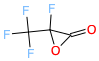

O=C1OC1(F)C(F)(F)F
Entry
PFCA_thermo
CF3_c_FCOC_O
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.812,137.752,152.489,163.298,177.159,185.258,194.772],'J/(mol*K)'), H298=(-1015.08,'kJ/mol'), S298=(366.666,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.83868,-5.5079,-8.06274,-10.6936,-14.2274,-15.9123,-14.4608],'J/(mol*K)'), H298=(241.452,'kJ/mol'), S298=(156.853,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-COCsF1sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + missing(CO-CsO2dO2s) + longDistanceInteraction_cyclic(Cs(F)-CO) + ring(O2s-CO(O2d)-Cs(F))""")

missing
['O2s-Cs(Cds-O2d)_O2s-(CsF1s)(O2d)COCs', 'CsCCFO_Cs-COCsF1sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'Cds-OdCsOs_CO-CsO2dO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.15909,-6.32585,-9.02387,-11.5737,-14.8608,-16.4239,-15.518

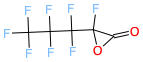

O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C3F7_c_FCOC_O
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([208.045,240.459,264.183,281.533,303.984,316.775,331.636],'J/(mol*K)'), H298=(-1837.9,'kJ/mol'), S298=(515.253,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-8.32472,-10.8758,-10.9234,-12.4472,-15.6992,-16.1829,-10.6045],'J/(mol*K)'), H298=(329.417,'kJ/mol'), S298=(160.546,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-COCsF1sO2s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + missing(CO-CsO2dO2s) + longDistanceInteraction_cyc

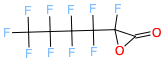

O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C4F9_c_FCOC_O
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([260.616,302.005,330.541,350.078,373.52,386.918,402.21],'J/(mol*K)'), H298=(-2249.38,'kJ/mol'), S298=(569.659,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-10.7822,-13.6758,-13.0103,-14.2111,-17.2808,-17.2337,-9.51792],'J/(mol*K)'), H298=(381.711,'kJ/mol'), S298=(163.757,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-COCsF1sO2s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)

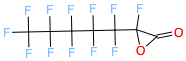

O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C5F11_c_FCOC_O
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([303.889,348.812,381.48,405.095,434.918,451.693,470.62],'J/(mol*K)'), H298=(-2654.35,'kJ/mol'), S298=(648.641,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-13.2398,-16.4759,-15.0973,-15.975,-18.8623,-18.2845,-8.43129],'J/(mol*K)'), H298=(434.005,'kJ/mol'), S298=(166.968,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-COCsF1sO2s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)

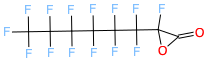

O=C1OC1(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C6F13_c_FCOC_O
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([355.584,407.11,443.952,470.23,503.2,521.449,541.759],'J/(mol*K)'), H298=(-3055.56,'kJ/mol'), S298=(712.529,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-15.6973,-19.2759,-17.1842,-17.739,-20.4439,-19.3353,-7.34466],'J/(mol*K)'), H298=(486.298,'kJ/mol'), S298=(170.178,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-COCsF1sO2s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(

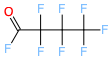

O=C(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C3F7CFO
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([176.284,203.895,224.722,240.17,259.804,271.025,283.821],'J/(mol*K)'), H298=(-1847.2,'kJ/mol'), S298=(485.147,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.61706,-2.40918,-0.952814,-0.722261,-1.32892,-0.802559,3.81859],'J/(mol*K)'), H298=(120.038,'kJ/mol'), S298=(2.91806,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + missing(CO-CsF1sO2d)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCCFF_Cs-COCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1

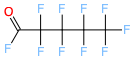

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C4F9CFO
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([221.989,255.773,281.099,299.846,323.797,337.35,352.701],'J/(mol*K)'), H298=(-2256.91,'kJ/mol'), S298=(554.276,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-4.07458,-5.20921,-3.03975,-2.48618,-2.91047,-1.85335,4.90522],'J/(mol*K)'), H298=(172.332,'kJ/mol'), S298=(6.12878,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + m

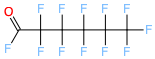

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C5F11CFO
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([271.925,312.115,341.52,362.91,390.09,405.313,422.434],'J/(mol*K)'), H298=(-2663.81,'kJ/mol'), S298=(621.212,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.5321,-8.00923,-5.12669,-4.25009,-4.49202,-2.90415,5.99184],'J/(mol*K)'), H298=(224.626,'kJ/mol'), S298=(9.33951,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs

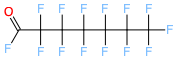

O=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C6F13CFO
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([315.685,364.45,395.869,417.682,450.049,472.794,487.945],'J/(mol*K)'), H298=(-3079.72,'kJ/mol'), S298=(698.725,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-8.98963,-10.8093,-7.21363,-6.01401,-6.07358,-3.95494,7.07847],'J/(mol*K)'), H298=(276.919,'kJ/mol'), S298=(12.5502,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missin

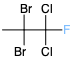

CC(Br)(Br)C(F)(Cl)Cl
Entry
CHOFClBr_G4
CC(Br)(Br)C(F)(Cl)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([145.748,163.693,178.409,190.671,209.093,221.252,236.078],'J/(mol*K)'), H298=(-289.726,'kJ/mol'), S298=(423.528,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(257.749,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.709,133.239,141.564,147.724,156.073,160.264,161.637],'J/(mol*K)'), H298=(-246.271,'kJ/mol'), S298=(307.483,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + missing(Cs-CsHHH) + group(CsCClClF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7)2)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.392,135.798,143.502,149.442,157.611,161.428,160.544],'J/(mol*K)'), H298=(-265.651,'kJ/mol'), S298=(302.7,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + gro

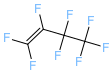

FC(F)=C(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C2F5CFCF2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([165.415,191.566,211.02,225.239,242.854,252.244,264.037],'J/(mol*K)'), H298=(-1568.54,'kJ/mol'), S298=(448.466,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.891744,-0.678874,0.205521,0.661222,0.398169,0.56235,3.00731],'J/(mol*K)'), H298=(104.468,'kJ/mol'), S298=(4.41178,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cd-CdCsF1s) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'),

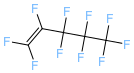

FC(F)=C(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C3F7CFCF2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([213.008,245.469,266.929,282.055,304.09,319.299,331.201],'J/(mol*K)'), H298=(-1980.61,'kJ/mol'), S298=(519.223,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.35012,-1.77408,-0.422845,-0.00105897,-0.629723,0.0434224,4.39559],'J/(mol*K)'), H298=(152.727,'kJ/mol'), S298=(3.12933,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CdCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + missing(Cd-CdCsF1s) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F)

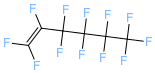

FC(F)=C(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
PFCA_thermo
C4F9CFCF2
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([275.321,299.792,321.023,339.228,367.393,383.605,124.974],'J/(mol*K)'), H298=(-2389.25,'kJ/mol'), S298=(590.324,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.80764,-4.5741,-2.50978,-1.76497,-2.21127,-1.00737,5.48222],'J/(mol*K)'), H298=(205.021,'kJ/mol'), S298=(6.34005,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CdCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2

OC#CF
Entry
CHOF_G4
OC#CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.4048,71.2161,75.6423,79.4689,85.598,90.107,96.9246],'J/(mol*K)'), H298=(-8.35777,'kJ/mol'), S298=(273.006,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(108.088,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CtH) + missing(Ct-CtO2s) + missing(Ct-CtF1s)""")

missing
['O2s-CtH_O2s-CtH', 'Ct-CtOs_Ct-CtO2s', 'CtCF_Ct-CtF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.7112,71.4146,75.7977,79.3602,85.5399,90.2636,97.2855],'J/(mol*K)','+|-',[5.12316,5.35542,5.0211,4.66226,4.0422,3.58946,6.93783]), H298=(-23.8709,'

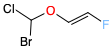

FC=COC(Cl)Br
Entry
CHOFClBr_G4
FCDCOC(Cl)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.348,139.329,155.449,168.261,186.017,196.4,208.722],'J/(mol*K)'), H298=(-277.65,'kJ/mol'), S298=(392.883,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.807,108.826,120.292,128.436,138.395,143.821,149.777],'J/(mol*K)'), H298=(-128.322,'kJ/mol'), S298=(240.973,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrClHO) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.3979,112.602,124.376,131.771,140.276,144.582,150.417],'J/(mol*K)'), H298=(-155.091,'kJ/mol'), S298=(234.723,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + gro

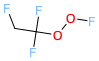

FCC(F)(F)OOF
Entry
CHOF_G4
FCC(F)(F)OOF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.807,149.769,164.935,176.378,191.593,200.8,212.218],'J/(mol*K)'), H298=(-675.21,'kJ/mol'), S298=(382.657,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([15.083,17.3969,19.3017,20.5264,22.5586,24.7819,25.6395],'J/(mol*K)'), H298=(-3.03633,'kJ/mol'), S298=(36.5426,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + missing(O2s-F1sO2s) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sHH)""")

missing
['O2sFO_O2s-F1sO2s', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([16.3176,18.033,19.2464,20.2506,22.2589,24.2672,24.2672],'J/(mol*K)'), H298=(-22.5936,'kJ/mol'), S298=(35.7314,'J/(mol*K)'), comment="""Thermo group 

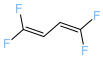

FC(F)=CC=C(F)F
Entry
CHOF_G4
FC(F)DCCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.18,141.142,156.149,168.238,186.167,197.687,210.646],'J/(mol*K)'), H298=(-672.562,'kJ/mol'), S298=(357.436,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3213,48.4507,56.484,62.0906,69.8728,75.2283,83.5126],'J/(mol*K)'), H298=(56.735,'kJ/mol'), S298=(53.3878,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + missing(Cd-CdF1sF1s) + missing(Cd-CdF1sF1s)""")

missing
['CdCFF_Cd-CdF1sF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3213,48.4507,56.484,62.0906,69.8728,75.2283,83.5126],'J/(mol*K)'), H298=(56.735,'kJ/mol'), S298=(53.3878,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-C

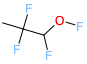

CC(F)(F)C(F)OF
Entry
CHOF_G4
CC(F)(F)C(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([138.871,161.122,178.488,192.992,214.853,229.324,246.788],'J/(mol*K)'), H298=(-774.2,'kJ/mol'), S298=(379.99,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.1774,75.703,83.9207,89.8899,98.0161,102.814,107.267],'J/(mol*K)'), H298=(-267.869,'kJ/mol'), S298=(183.959,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCFHO) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.412,76.3391,83.8654,89.6141,97.7164,102.299,105.894],'J/(mol*K)'), H298=(-287.427,'kJ/mol'), S298=(183.148,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(

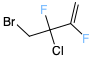

C=C(F)C(F)(Cl)CBr
Entry
CHOFClBr_G4
CDC(F)C(F)(Cl)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.818,158.311,177.328,192.483,215.937,232.275,253.832],'J/(mol*K)'), H298=(-385.083,'kJ/mol'), S298=(403.5,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.4335,105.241,115.637,123.789,135.641,143.177,151.28],'J/(mol*K)'), H298=(-257.428,'kJ/mol'), S298=(236.699,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCClF) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + group(CsBrCsHH) + missing(Cd-CdCsF1s) + missing(Cd-CdHH)""")

missing
['CdCsCdF_Cd-CdCsF1s', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.2689,108.102,117.474,125.179,136.495,143.282,148.685],'J/(mol*K)'), H298=(-282.167,'kJ/mol'), S298=(232

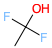

CC(O)(F)F
Entry
CHOF_G4
CC(O)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.2723,109.918,123.216,132.976,148.058,158.702,173.865],'J/(mol*K)'), H298=(-726.824,'kJ/mol'), S298=(305.398,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsHHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCFFO_Cs-CsF1sF1sO2s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.4421,107.385,120.33,131.041,147.542,159.247,176.027],'J/(mol*K)','+|-',[0.616603,0.644557,0.60432,0.561131,0.486503,0.432

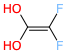

OC(O)=C(F)F
Entry
CHOF_G4
OC(O)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.8493,111.471,120.46,128.025,139.595,147.484,157.844],'J/(mol*K)'), H298=(-653.532,'kJ/mol'), S298=(337.079,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.3347,76.1542,81.7161,84.9208,88.8985,91.8956,96.5183],'J/(mol*K)'), H298=(-297.397,'kJ/mol'), S298=(167.617,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(O2s-(Cds-Cd)H) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['Cds-CdsOsOs_Cd-CdO2sO2s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.2,60.6,65.04,66.3,66.58,67.1,69.94],'J/(mol*K)'), H298=(-376.2,'kJ/mol'), S298=(212.6,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-

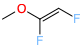

COC(F)=CF
Entry
CHOF_G4
COC(F)DCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.3199,114.52,128.66,141,160.796,175.274,196.184],'J/(mol*K)'), H298=(-467.041,'kJ/mol'), S298=(342.633,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([47.3846,54.8227,59.6289,62.9912,66.7296,68.4513,68.4976],'J/(mol*K)'), H298=(-273.672,'kJ/mol'), S298=(74.0764,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-O2sHHH) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['Cs-OsHHH_Cs-O2sHHH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.1875,54.1148,59.2226,62.679,66.5978,68.4315,69.0042],'J/(mol*K)'), H298=(-298.857,'kJ/mol'), S298=(72.4644,'J/(mol*K)'), comment="""Th

FC=COCF
Entry
CHOF_G4
FCDCOCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.3727,112.673,128.591,142.16,163.325,178.14,197.851],'J/(mol*K)'), H298=(-484.095,'kJ/mol'), S298=(340.285,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3531,46.5727,53.1413,57.5213,61.6931,63.7577,65.8456],'J/(mol*K)'), H298=(-88.638,'kJ/mol'), S298=(51.1009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sO2sHH) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CsFHHO_Cs-F1sO2sHH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cd

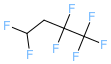

FC(F)CC(F)(F)C(F)(F)F
Entry
CHOF_G4
FC(F)CC(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([168.178,194.513,215.666,233.116,259.208,276.197,295.649],'J/(mol*K)'), H298=(-1585.02,'kJ/mol'), S298=(448.006,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.952312,-0.940249,-0.44155,-0.173174,-0.0885042,0.154087,1.51887],'J/(mol*K)'), H298=(42.3898,'kJ/mol'), S298=(1.23249,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE 

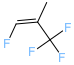

CC(=CF)C(F)(F)F
Entry
CHOF_G4
CC(DCF)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.983,147.31,166.1,181.235,204.751,221.469,244.377],'J/(mol*K)'), H298=(-851.699,'kJ/mol'), S298=(371.063,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + missing(Cs-CdF1sF1sF1s) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdCs)CdHHH', 'CsCdFFF_Cs-CdF1sF1sF1s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(C

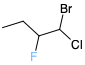

CCC(F)C(Cl)Br
Entry
CHOFClBr_G4
CCC(F)C(Cl)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([142.805,166.709,187.269,204.861,232.516,252.203,279.852],'J/(mol*K)'), H298=(-319.727,'kJ/mol'), S298=(409.507,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.2813,102.576,112.791,120.927,132.972,140.598,148.948],'J/(mol*K)'), H298=(-254.29,'kJ/mol'), S298=(241.187,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsHHH) + group(CsBrCClH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.9766,104.048,113.806,121.789,133.637,140.936,148.045],'J/(mol*K)'), H298=(-264.058,'kJ/mol'), S298=(238.67,'J/(mol*K)'), comment="""Thermo group additivity estimati

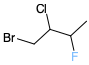

CC(F)C(Cl)CBr
Entry
CHOFClBr_G4
CC(F)C(Cl)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.526,173.179,194.118,211.828,239.135,257.964,282.907],'J/(mol*K)'), H298=(-332.726,'kJ/mol'), S298=(398.683,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.78,135.221,150.965,163.538,182.449,194.775,209.795],'J/(mol*K)'), H298=(-298.021,'kJ/mol'), S298=(273.061,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsCsCsClH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.212,137.215,152.403,164.

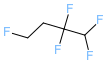

FCCC(F)(F)C(F)F
Entry
CHOF_G4
FCCC(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([149.396,174.766,195.987,213.951,241.753,260.989,286.21],'J/(mol*K)'), H298=(-1133.26,'kJ/mol'), S298=(419.969,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.45752,-2.80002,-2.08694,-1.76392,-1.58155,-1.05079,1.08663],'J/(mol*K)'), H298=(31.3737,'kJ/mol'), S298=(3.21073,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S2

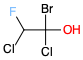

OC(Cl)(Br)C(F)Cl
Entry
CHOFClBr_G4
OC(Cl)(Br)C(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.978,141.72,152.081,160.575,172.956,180.669,188.792],'J/(mol*K)'), H298=(-454.105,'kJ/mol'), S298=(398.868,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([106.29,120.538,130.44,137.832,147.774,153.23,156.688],'J/(mol*K)'), H298=(-284.003,'kJ/mol'), S298=(259.503,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(CsBrCClO) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + group(CsCClFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['O2s-CsH_O2s-CsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.699,123.889,133.401,140.606,150.126,154.913,156.192],'J/(mol*K)'), H298=(-299.81,'kJ/mol'), S298=(253.816,'J/(mol*K)'), comment="""Thermo group additi

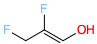

OC=C(F)CF
Entry
CHOF_G4
OCDC(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.593,123.149,139.151,152.075,171.707,184.867,201.062],'J/(mol*K)'), H298=(-522.22,'kJ/mol'), S298=(335.003,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.8301,52.9947,60.1267,64.6481,69.6856,73.2125,79.863],'J/(mol*K)'), H298=(-142.763,'kJ/mol'), S298=(139.138,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cd(F)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.474,57.3286,64.4858,68.0864,71.3644,73.549,78.7346],'J/(mol*K)'), H298=(-179.606,'kJ/mol'), S298=(132.241,'J/(mol*K)'), commen

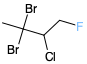

CC(Br)(Br)C(Cl)CF
Entry
CHOFClBr_G4
CC(Br)(Br)C(Cl)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([148.142,173.798,195.781,214.509,243.728,264.267,292.385],'J/(mol*K)'), H298=(-300.858,'kJ/mol'), S298=(430.291,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(332.579,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.9565,107.411,116.09,122.547,131.632,136.431,139.857],'J/(mol*K)'), H298=(-33.3097,'kJ/mol'), S298=(170.371,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + group(CsCsCsClH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.8677,109.879,117.824,124.07,132.914,137.159

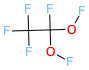

FOC(F)(OF)C(F)(F)F
Entry
CHOF_G4
FOC(F)(OF)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.257,175.533,187.749,196.93,209.063,215.095,217.18],'J/(mol*K)'), H298=(-970.326,'kJ/mol'), S298=(408.689,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.287,66.541,68.9889,71.101,75.059,77.4353,80.2889],'J/(mol*K)'), H298=(-29.7198,'kJ/mol'), S298=(280.84,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(O2sCF) + missing(Cs-CsF1sO2sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F))""")

missing
['CsCFOO_Cs-CsF1sO2sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.9666,65.723,68.0277,70.2208,74.4256,76.9238,79.2311],'J/(mol*K)'), H298=(-57.5308,'kJ/mol'), S298=(281.697,'J/(mol*K)'), comment="""Thermo group additivity es

O=CCOF
Entry
CHOF_G4
ODCCOF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.3023,103.368,113.668,122.369,135.757,144.956,157.052],'J/(mol*K)'), H298=(-184.222,'kJ/mol'), S298=(316.355,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.7333,67.2315,74.7839,80.4804,88.4128,93.4219,100.406],'J/(mol*K)'), H298=(-48.5654,'kJ/mol'), S298=(172.389,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(Cs-(Cds-O2d)OsHH) + missing(CO-CsO2dH)""")

missing
['Cds-OdCsH_CO-CsO2dH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.7333,67.2315,74.7839,80.4804,88.4128,93.4219,100.406],'J/(mol*K)'), H298=(-48.5654,'kJ/mol'), S298=(172.389,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(Cs-(Cds-O2d)OsHH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1

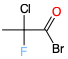

CC(F)(Cl)C(=O)Br
Entry
CHOFClBr_G4
CC(F)(Cl)C(DO)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.297,140.458,152.985,163.501,179.509,190.32,204.136],'J/(mol*K)'), H298=(-416.166,'kJ/mol'), S298=(390.612,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.5982,108.153,114.072,118.697,125.389,129.043,130.95],'J/(mol*K)'), H298=(-372.53,'kJ/mol'), S298=(263.095,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCClF) + longDistanceInteraction_noncyclic(Cs(Val7)2-CO) + missing(Cs-CsHHH) + group(COBrCsO)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.4069,104.791,111.516,117.002,124.979,129.288,131.047],'J/(mol*K)'), H298=(-394.942,'kJ/mol'), S298=(262.487,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCClF) + group(COBrCsO)""")

GAE wi

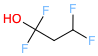

OC(F)(F)CC(F)F
Entry
CHOF_G4
OC(F)(F)CC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([131.78,155.521,174.787,190.153,211.731,225.699,245.002],'J/(mol*K)'), H298=(-1146.89,'kJ/mol'), S298=(387.323,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsHH) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsF1sF1sH)""")

missing
['O2s-CsH_O2s-CsH', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.706,158.617,176.368,190.643,211.938,226.178,244.592],'J/(mol*

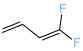

C=CC=C(F)F
Entry
CHOF_G4
CDCCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.2119,119.656,136.845,150.229,170.741,184.796,203.031],'J/(mol*K)'), H298=(-282.641,'kJ/mol'), S298=(320.315,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3213,48.4507,56.484,62.0906,69.8728,75.2283,83.5126],'J/(mol*K)'), H298=(56.735,'kJ/mol'), S298=(53.3878,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + missing(Cd-CdHH) + missing(Cd-CdF1sF1s)""")

missing
['Cds-CdsHH_Cd-CdHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3213,48.4507,56.484,62.0906,69.8728,75.2283,83.5126],'J/(mol*K)'), H298=(56.735,'kJ/mol'), S298=(53.3878,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)

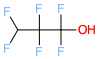

OC(F)(F)C(F)(F)C(F)F
Entry
CHOF_G4
OC(F)(F)C(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([156.543,180.131,197.5,210.382,227.836,239.237,253.688],'J/(mol*K)'), H298=(-1512.24,'kJ/mol'), S298=(420.423,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-4.91505,-5.60005,-4.17387,-3.52783,-3.1631,-2.10159,2.17325],'J/(mol*K)'), H298=(83.6674,'kJ/mol'), S298=(6.42145,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2)""")

missing
['O2s-CsH_O2s-CsH', 'Cs

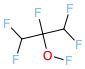

FOC(F)(C(F)F)C(F)F
Entry
CHOF_G4
FOC(F)(C(F)F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([157.053,181.98,200.825,215.031,234.063,245.682,258.571],'J/(mol*K)'), H298=(-1127.15,'kJ/mol'), S298=(421.532,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([28.5141,31.5893,34.1244,35.662,37.8123,39.4912,42.3602],'J/(mol*K)'), H298=(10.3492,'kJ/mol'), S298=(142.471,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sO2s) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCCFO_Cs-CsCsF1sO2s', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.

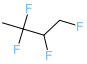

CC(F)(F)C(F)CF
Entry
CHOF_G4
CC(F)(F)C(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.143,170.683,191.591,209.386,237.102,256.525,282.933],'J/(mol*K)'), H298=(-934.402,'kJ/mol'), S298=(386.617,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.0498,40.4593,46.5116,50.8446,56.8002,60.818,66.2019],'J/(mol*K)'), H298=(-196.862,'kJ/mol'), S298=(49.9974,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F))""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.0729,55.8267,59.4

FC#CF
Entry
CHOF_G4
FC#CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.9195,65.383,68.5775,71.2791,75.4469,78.3297,82.2038],'J/(mol*K)'), H298=(6.94711,'kJ/mol'), S298=(250.353,'J/(mol*K)'), Cp0=(29.1007,'J/(mol*K)'), CpInf=(87.302,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Ct-CtF1s) + missing(Ct-CtF1s)""")

missing
['CtCF_Ct-CtF1s', 'CtCF_Ct-CtF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.5594,64.2249,67.6367,69.5621,73.5564,76.4685,80.4818],'J/(mol*K)','+|-',[1.29865,1.35753,1.27278,1.18182,1.02464,0.909881,1.75865]), H298=(-1.31692,'kJ/mol','+|-',6.26877), S298=(252.974,'

FC=COOF
Entry
CHOF_G4
FCDCOOF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.7505,109.727,121.363,130.951,145.044,153.948,163.531],'J/(mol*K)'), H298=(-113.921,'kJ/mol'), S298=(319.526,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.9271,39.4447,44.4081,48.9649,55.9834,59.6975,63.5853],'J/(mol*K)'), H298=(42.1238,'kJ/mol'), S298=(74.533,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-Cd)) + missing(O2s-F1sO2s) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['O2sFO_O2s-F1sO2s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.518,43.2207,48.4926,52.3,57.8647,60.4588,64.2244],'J/(mol*K)'), H298=(15.3553,'kJ/mol'), S298=(68.2829,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-C

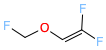

FCOC=C(F)F
Entry
CHOF_G4
FCOCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.694,123.592,138.97,151.955,171.879,185.446,202.498],'J/(mol*K)'), H298=(-675.584,'kJ/mol'), S298=(364.983,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.9243,46.6146,53.0237,57.4694,61.6257,63.8759,66.4527],'J/(mol*K)'), H298=(-79.866,'kJ/mol'), S298=(53.005,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sO2sHH) + group(Cds-CdsOsH) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CsFHHO_Cs-F1sO2sHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimation: grou

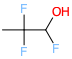

CC(F)(F)C(O)F
Entry
CHOF_G4
CC(F)(F)C(O)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.422,154.926,173.788,188.237,209.985,224.382,241.992],'J/(mol*K)'), H298=(-917.272,'kJ/mol'), S298=(352.813,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.1941,42.8415,49.9068,54.7795,60.8033,64.352,67.6511],'J/(mol*K)'), H298=(-239.104,'kJ/mol'), S298=(43.1107,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCFHO) + missing(Cs-CsHHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.4287,43.4776,49.8515,54.5037,60.5036,63.8374,66.2787],'J/(mol*K)'), H298=(-258.661,'kJ/mol'), S298=(42.2994,'J/(mol*K)'), comment="""Thermo group addi

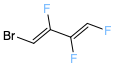

FC=C(F)C(F)=CBr
Entry
CHOFBr_G4
FCDC(F)C(F)DCBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.632,146.87,163.173,174.78,191.246,201.985,214.012],'J/(mol*K)'), H298=(-409.186,'kJ/mol'), S298=(382.369,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.2775,109.697,120.209,128.249,139.887,146.849,152.717],'J/(mol*K)'), H298=(-242.09,'kJ/mol'), S298=(249.293,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CdCCF) + longDistanceInteraction_noncyclic(Cds(F)-Cds(F)) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + group(CdCCF) + longDistanceInteraction_noncyclic(Cds(F)-Cds(F)) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + group(CdBrCH) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7))""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
Therm

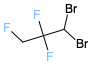

FCC(F)(F)C(Br)Br
Entry
CHOFBr_G4
FCC(F)(F)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([141.335,166.251,183.643,195.638,212.638,223.322,234.194],'J/(mol*K)'), H298=(-639.389,'kJ/mol'), S298=(413.964,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([54.1177,60.8587,67.2552,71.9657,78.3692,82.5662,87.7449],'J/(mol*K)'), H298=(46.0796,'kJ/mol'), S298=(206.857,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsF1sHH) + group(CsBrBrCsH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.7622,64.8461,70.1615,74.4635,80.4211,83.7344,85.8766],'J/(m

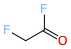

O=C(F)CF
Entry
CHOF_G4
ODC(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.6107,85.8523,95.6655,104.117,117.29,126.274,138.349],'J/(mol*K)'), H298=(-595.783,'kJ/mol'), S298=(307.027,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(153.818,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([3.20602,2.68978,2.20369,1.70451,1.10621,0.541372,0.834218],'J/(mol*K)'), H298=(12.0622,'kJ/mol'), S298=(-1.62542,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-COF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-CO) + missing(CO-CsF1sO2d)""")

missing
['CsCFHH_Cs-COF1sHH', 'COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.8704,88.8865,98.8229,106.89,119.041,127.456,139.008],'J/(mol*K)

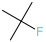

CC(C)(C)F
Entry
CHOF_G4
CC(C)(C)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.994,136.644,158.227,177.133,208.006,231.286,267.157],'J/(mol*K)'), H298=(-355.315,'kJ/mol'), S298=(315.296,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.0639,39.8079,42.5852,44.7546,47.9545,49.1612,48.5624],'J/(mol*K)'), H298=(-233.307,'kJ/mol'), S298=(-35.1077,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsHHH) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.0639,39.8079,42.5852,44.7546,47.9545,49.1612,48.5624],'J/(mol*K)'), H298=(-233.307,'kJ/mol'), S298=(-35.1077,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF)""")

GAE with fitted GAV
The

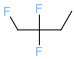

CCC(F)(F)CF
Entry
CHOF_G4
CCC(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.805,155.357,177.324,196.052,225.249,245.99,277.218],'J/(mol*K)'), H298=(-740.799,'kJ/mol'), S298=(374.633,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.2346,-0.636123,0.0552886,0.275793,0.299765,0.514653,1.37234],'J/(mol*K)'), H298=(19.5573,'kJ/mol'), S298=(0.811252,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,4

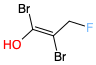

OC(Br)=C(Br)CF
Entry
CHOFBr_G4
OC(Br)DC(Br)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.533,146.313,159.8,170.665,186.695,196.886,207.973],'J/(mol*K)'), H298=(-278.47,'kJ/mol'), S298=(388.431,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.255,101.479,108.523,113.341,119.968,124.054,128.855],'J/(mol*K)'), H298=(-72.7525,'kJ/mol'), S298=(256.942,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cds(Val7)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cds(Br)=Cds(Br)) + group(CdBrCO) + longDistanceInteraction_noncyclic(Cds(Br)=Cds(Br))""")

missing
['CsCFHH_Cs-CdF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.6948,101.878,108.915,113.521,119.984,123.89,128.118],'J/(mol*K)'), H298=(-92.7617,

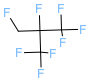

FCC(F)(C(F)(F)F)C(F)(F)F
Entry
CHOF_G4
FCC(F)(C(F)(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([175.284,207.622,231.642,248.828,271.758,286.65,303.26],'J/(mol*K)'), H298=(-1762.71,'kJ/mol'), S298=(443.281,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.9475,40.9256,45.7795,48.7966,51.9748,53.3756,54.9206],'J/(mol*K)'), H298=(-146.928,'kJ/mol'), S298=(-40.5362,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'C

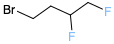

FCC(F)CCBr
Entry
CHOFBr_G4
FCC(F)CCBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.942,165.437,188.563,207.64,235.751,255.177,283.241],'J/(mol*K)'), H298=(-488.614,'kJ/mol'), S298=(397.522,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.7382,91.0754,102.466,111.619,125.138,134.096,145.133],'J/(mol*K)'), H298=(-240.068,'kJ/mol'), S298=(208.17,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsCsHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrCsHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.9824,91.7116,102.345,111.123,124.464,133.214,143.655],'J/(mol*K)'), H298=(-254.4,'kJ/mol'), S298=(208.216,'J/(mol*K)'), comment=

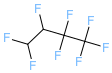

FC(F)C(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
FC(F)C(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([179.257,205.679,226.358,243.178,267.93,283.569,300.126],'J/(mol*K)'), H298=(-1735.56,'kJ/mol'), S298=(465.055,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.1071,39.5191,46.0043,50.4513,56.3377,60.605,67.6152],'J/(mol*K)'), H298=(-149.247,'kJ/mol'), S298=(52.0865,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286

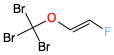

FC=COC(Br)(Br)Br
Entry
CHOFBr_G4
FCDCOC(Br)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.685,151.606,165.602,177.031,193.538,203.586,213.15],'J/(mol*K)'), H298=(-178.04,'kJ/mol'), S298=(441.945,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.001,123.781,133.652,140.504,148.527,152.369,154.966],'J/(mol*K)'), H298=(-29.4428,'kJ/mol'), S298=(300.957,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrBrBrO) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.592,127.557,137.736,143.839,150.409,153.13,155.606],'J/(mol*K)'), H298=(-56.2112,'kJ/mol'), S298=(294.707,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd

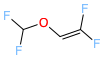

FC(F)=COC(F)F
Entry
CHOF_G4
FC(F)DCOC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.351,137.39,151.971,163.501,180.98,192.64,206.693],'J/(mol*K)'), H298=(-915.862,'kJ/mol'), S298=(381.731,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.9243,46.6146,53.0237,57.4694,61.6257,63.8759,66.4527],'J/(mol*K)'), H298=(-79.866,'kJ/mol'), S298=(53.005,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sF1sO2sH) + group(Cds-CdsOsH) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CsFFHO_Cs-F1sF1sO2sH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimati

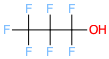

OC(F)(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
OC(F)(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([159.956,185.028,203.165,216.103,233.169,244.209,256.638],'J/(mol*K)'), H298=(-1741.42,'kJ/mol'), S298=(433.328,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.93103,-3.91383,-1.9548,-1.14928,-1.13823,-0.273656,3.54172],'J/(mol*K)'), H298=(96.2185,'kJ/mol'), S298=(2.02541,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCFFO_Cs-CsF1s

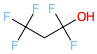

OC(F)(F)CC(F)(F)F
Entry
CHOF_G4
OC(F)(F)CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([142.099,164.642,181.272,195.118,215.896,229.564,245.991],'J/(mol*K)'), H298=(-1385.02,'kJ/mol'), S298=(406.34,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsHH) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsF1sF1sF1s)""")

missing
['O2s-CsH_O2s-CsH', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([141.607,166.5,184.499,198.59,219.035,232.307,248.267],'

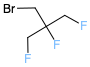

FCC(F)(CF)CBr
Entry
CHOFBr_G4
FCC(F)(CF)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([147.698,177.627,201.266,219.403,245.928,264.349,288.363],'J/(mol*K)'), H298=(-674.541,'kJ/mol'), S298=(410.502,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([73.8135,87.5184,98.1183,106.136,117.323,124.327,132.306],'J/(mol*K)'), H298=(-218.158,'kJ/mol'), S298=(127.211,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE with

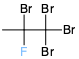

CC(F)(Br)C(Br)(Br)Br
Entry
CHOFBr_G4
CC(F)(Br)C(Br)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([151.034,167.771,181.739,193.282,210.359,221.305,233.696],'J/(mol*K)'), H298=(-179.58,'kJ/mol'), S298=(449.559,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.508,136.253,143.494,148.951,156.249,159.843,160.325],'J/(mol*K)'), H298=(-136.236,'kJ/mol'), S298=(332.964,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCF) + missing(Cs-CsHHH) + group(CsBrBrBrCs) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7)2)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.191,138.812,145.432,150.669,157.787,161.007,159.233],'J/(mol*K)'), H298=(-155.616,'kJ/mol'), S298=(328.181,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCF) + group(Cs

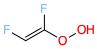

OOC(F)=CF
Entry
CHOF_G4
OOC(F)DCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.758,115.09,125.097,133.375,145.639,153.508,162.353],'J/(mol*K)'), H298=(-400.899,'kJ/mol'), S298=(333.336,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.9586,47.6948,50.8957,54.4348,61.0199,64.3911,66.2374],'J/(mol*K)'), H298=(-142.911,'kJ/mol'), S298=(97.5085,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-Cd)) + missing(O2s-O2sH) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['O2s-OsH_O2s-O2sH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.7615,46.9869,50.4894,54.1226,60.8881,64.3713,66.744],'J/(mol*K)'), H298=(-168.095,'kJ/mol'), S298=(95.8964,'J/(mol*K)'), comment=""

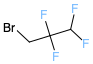

FC(F)C(F)(F)CBr
Entry
CHOFBr_G4
FC(F)C(F)(F)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([138.964,159.575,174.139,186.189,204.097,215.685,229.208],'J/(mol*K)'), H298=(-891.554,'kJ/mol'), S298=(391.382,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.3009,45.7087,52.9079,58.4244,66.3907,72.4032,82.2927],'J/(mol*K)'), H298=(17.4923,'kJ/mol'), S298=(164.712,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + group(CsBrCsHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.4538,49.98,56.01,61.0504,68.6377,73.7924,80.3031],'J/(mol*K)'), 

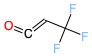

O=C=CC(F)(F)F
Entry
CHOF_G4
ODCDCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.3488,112.833,123.88,132.946,146.518,155.382,165.666],'J/(mol*K)'), H298=(-711.884,'kJ/mol'), S298=(336.05,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.83,50.1,55.5,60.05,67.09,72.13,79.55],'J/(mol*K)'), H298=(-17.6,'kJ/mol'), S298=(169.15,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2d-Cdd) + missing(Cs-CdF1sF1sF1s) + group(Cds-(Cdd-O2d)CsH) + missing(Cdd-CdO2d)""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.83,50.1,55.5,60.05,67.09,72.13,79.55],'J/(mol*K)'), H298=(-17.6,'kJ/mol'), S298=(169.15,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-(Cdd-O2d)CsH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],

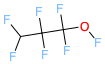

FOC(F)(F)C(F)(F)C(F)F
Entry
CHOF_G4
FOC(F)(F)C(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([167.017,191.975,208.526,220.538,237.955,248.692,259.113],'J/(mol*K)'), H298=(-1341.09,'kJ/mol'), S298=(444.184,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.0683,27.2615,29.84,31.5826,34.0497,36.3603,41.7888],'J/(mol*K)'), H298=(54.9021,'kJ/mol'), S298=(147.27,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsC

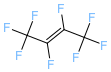

FC(=C(F)C(F)(F)F)C(F)(F)F
Entry
CHOF_G4
FC(DC(F)C(F)(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([157.649,182.625,201.753,216.493,237.074,249.883,262.854],'J/(mol*K)'), H298=(-1602.35,'kJ/mol'), S298=(442.548,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-5.04675,-3.43751,-1.61573,-0.558746,0.173584,0.814642,2.31973],'J/(mol*K)'), H298=(88.7712,'kJ/mol'), S298=(8.98896,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cds(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cds(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['Cs

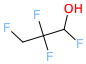

OC(F)C(F)(F)CF
Entry
CHOF_G4
OC(F)C(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.895,166.126,187.917,204.047,227.223,241.183,253.858],'J/(mol*K)'), H298=(-1080.64,'kJ/mol'), S298=(366.97,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([31.9595,42.2054,49.9621,55.0553,61.1031,64.8667,69.0234],'J/(mol*K)'), H298=(-219.547,'kJ/mol'), S298=(43.9219,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCFHO) + missing(Cs-CsF1sHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.4287,43.4776,49.8515,54.5037,60.5036,63.8374,66.2787],'J/(mol*K)'), H298=(-258.661,'kJ/mol'), S

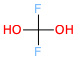

OC(O)(F)F
Entry
CHOF_G4
OC(O)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.9758,88.3192,97.7248,105.333,116.204,123.601,134.072],'J/(mol*K)'), H298=(-884.79,'kJ/mol'), S298=(310.676,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(149.66,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.3207,55.3819,61.8705,65.9465,70.2757,72.0769,71.2841],'J/(mol*K)'), H298=(-531.715,'kJ/mol'), S298=(60.1873,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + group(CsFFOO)""")

missing
['O2s-CsH_O2s-CsH', 'O2s-CsH_O2s-CsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.3207,55.3819,61.8705,65.9465,70.2757,72.0769,71.2841],'J/(mol*K)'), H298=(-531.715,'kJ/mol'), S298=(60.1873,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsFFOO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K')

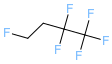

FCCC(F)(F)C(F)(F)F
Entry
CHOF_G4
FCCC(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([155.544,182.451,204.281,222.202,249.399,267.889,291.037],'J/(mol*K)'), H298=(-1366.34,'kJ/mol'), S298=(428.707,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.952312,-0.940249,-0.44155,-0.173174,-0.0885042,0.154087,1.51887],'J/(mol*K)'), H298=(42.3898,'kJ/mol'), S298=(1.23249,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitte

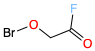

O=C(F)COBr
Entry
CHOFBr_G4
ODC(F)COBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.091,112.899,122.546,130.61,142.787,150.893,160.903],'J/(mol*K)'), H298=(-409.971,'kJ/mol'), S298=(364.407,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.3031,70.3003,77.467,82.7756,89.8474,94.2865,100.568],'J/(mol*K)'), H298=(-20.7003,'kJ/mol'), S298=(193.854,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + group(Cs-(Cds-O2d)OsHH) + missing(CO-CsF1sO2d)""")

missing
['COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.3031,70.3003,77.467,82.7756,89.8474,94.2865,100.568],'J/(mol*K)'), H298=(-20.7003,'kJ/mol'), S298=(193.854,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + group(Cs-(Cds-O2d)OsHH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500

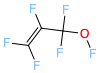

FOC(F)(F)C(F)=C(F)F
Entry
CHOF_G4
FOC(F)(F)C(F)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([145.482,169.023,183.464,193.575,207.628,215.485,220.71],'J/(mol*K)'), H298=(-971.029,'kJ/mol'), S298=(404.006,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.5642,35.0013,35.5458,36.2586,37.7213,38.779,40.4694],'J/(mol*K)'), H298=(27.7433,'kJ/mol'), S298=(141.952,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CdF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + missing(Cd-CdCsF1s) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CsCFFO_Cs-CdF1sF1sO2s', 'CdCsCdF_Cd-CdCsF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.

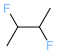

CC(F)C(C)F
Entry
CHOF_G4
CC(F)C(C)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([121.892,146.047,167.241,185.765,215.888,238.428,272.466],'J/(mol*K)'), H298=(-530.435,'kJ/mol'), S298=(351.98,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([69.813,82.827,92.7916,100.642,112.327,119.725,128.181],'J/(mol*K)'), H298=(-447.17,'kJ/mol'), S298=(98.4176,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.0572,83.4632,92.6706,100.146,111.653,118.843,126.703],'J/(mol*K)'), H298=(-461.503,'kJ/mol'), S298=(98.4629,'J/(mol*K)'), comment="""Therm

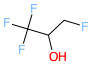

OC(CF)C(F)(F)F
Entry
CHOF_G4
OC(CF)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([135.559,165.311,184.815,198.387,218.283,230.982,245.524],'J/(mol*K)'), H298=(-1099.14,'kJ/mol'), S298=(368.543,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([23.2373,30.8401,35.649,39.3097,43.7504,45.7306,47.9549],'J/(mol*K)'), H298=(-12.9524,'kJ/mol'), S298=(-57.1766,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(Cs-CsCsOsH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-CsOs)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.99,29.03,34.22,37.78,41.96,44.27,47.11],'J/(mol*K)'), H298=(-25.1,'kJ/mol'), S298=(-52.05,'J/(mol*K)'), comment="""Thermo group additivity e

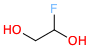

OCC(O)F
Entry
CHOF_G4
OCC(O)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.2956,118.58,140.269,156.375,177.829,191.077,203.863],'J/(mol*K)'), H298=(-624.99,'kJ/mol'), S298=(305.16,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.4287,43.4776,49.8515,54.5037,60.5036,63.8374,66.2787],'J/(mol*K)'), H298=(-258.661,'kJ/mol'), S298=(42.2994,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsO2sHH) + group(CsCFHO)""")

missing
['O2s-CsH_O2s-CsH', 'O2s-CsH_O2s-CsH', 'Cs-CsOsHH_Cs-CsO2sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.4287,43.4776,49.8515,54.5037,60.5036,63.8374,66.2787],'J/(mol*K)'), H298=(-258.661,'kJ/mol'), S298=(42.2994,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCFHO)""")

GAE with fitted GAV
ThermoData(Td

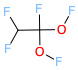

FOC(F)(OF)C(F)F
Entry
CHOF_G4
FOC(F)(OF)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([148.376,166.988,178.56,187.718,200.428,207.553,212.76],'J/(mol*K)'), H298=(-744.448,'kJ/mol'), S298=(400.663,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.732,65.0869,68.083,70.4966,74.7253,77.4384,80.6034],'J/(mol*K)'), H298=(-37.9735,'kJ/mol'), S298=(282.508,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(O2sCF) + missing(Cs-CsF1sO2sO2s) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCFOO_Cs-CsF1sO2sO2s', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.9666,65.723,68.0277,70.2208,74.4256,76.9238,79.2311],'J/(mol*K)'), H298=(-57.5308,'kJ/mol'), S298=(281.697,'J/(mol*K)'), comment="""Thermo group additivity estimatio

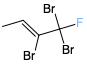

CC=C(Br)C(F)(Br)Br
Entry
CHOFBr_G4
CCDC(Br)C(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([148.193,167.76,183.282,196.281,216.314,230.082,247.93],'J/(mol*K)'), H298=(-119.431,'kJ/mol'), S298=(442.9,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([103.57,113.211,119.49,124.139,130.84,134.354,135.799],'J/(mol*K)'), H298=(-107.147,'kJ/mol'), S298=(292.57,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + group(CsBrBrCF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cds(Val7)) + missing(Cd-CdCsH) + group(CdBrCsCd)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdH)CdHHH', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([103.372,111.647,117.526,122.034,128.806,132.46,133.799],'J/(mol*K)'), H298=(-126.732,'kJ/mol'), S298=(292.555,'J/(mol*K)'), comment="""Thermo group additi

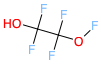

OC(F)(F)C(F)(F)OF
Entry
CHOF_G4
OC(F)(F)C(F)(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([141.662,160.029,171.96,181.534,195.117,203.11,210.134],'J/(mol*K)'), H298=(-1142.1,'kJ/mol'), S298=(398.386,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([28.5258,30.0615,31.9269,33.3465,35.6312,37.4111,40.7022],'J/(mol*K)'), H298=(2.60835,'kJ/mol'), S298=(144.059,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(O2sCF) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['O2s-CsH_O2s-CsH', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCFFO_Cs-CsF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.7654,

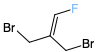

FC=C(CBr)CBr
Entry
CHOFBr_G4
FCDC(CBr)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.111,158.531,175.968,190.454,212.414,227.129,245.572],'J/(mol*K)'), H298=(-157.782,'kJ/mol'), S298=(401.553,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.5469,114.267,127.843,139.204,156.473,168.484,183.406],'J/(mol*K)'), H298=(13.0163,'kJ/mol'), S298=(277.801,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCHH) + group(CsBrCHH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.5469,114.267,127.843,139.204,156.473,168.484,183.406],'J/(mol*K)'), H298=(13.0163,'kJ/mol'), S298=(277.801,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCHH) + group(CsBrCHH) + group(Cds-CdsCsCs)""")

GAE with fitted GAV
Ther

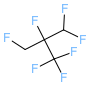

FCC(F)(C(F)F)C(F)(F)F
Entry
CHOF_G4
FCC(F)(C(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([169.952,198.218,220.034,236.965,260.959,276.835,296.803],'J/(mol*K)'), H298=(-1529.23,'kJ/mol'), S298=(439.405,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.3844,39.18,44.2963,47.1942,50.0932,51.6922,53.4068],'J/(mol*K)'), H298=(-159.611,'kJ/mol'), S298=(-37.6165,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without 

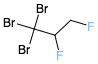

FCC(F)C(Br)(Br)Br
Entry
CHOFBr_G4
FCC(F)C(Br)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([141.629,160.1,175.531,188.297,207.205,219.331,232.916],'J/(mol*K)'), H298=(-374.341,'kJ/mol'), S298=(438.306,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.997,117.453,126.598,133.779,144.054,150.192,155.958],'J/(mol*K)'), H298=(-153.334,'kJ/mol'), S298=(295.01,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrBrBrCs) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.381,119.261,127.35,133.975,143.852,149.559,153.32],'J/(mol*K)'), H298=(-179.923,'kJ/mol'), S298=(291

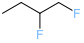

CCC(F)CF
Entry
CHOF_G4
CCC(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.038,142.635,164.528,183.781,214.933,238.05,272.383],'J/(mol*K)'), H298=(-507.246,'kJ/mol'), S298=(360.3,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.2844,41.0954,46.4563,50.5688,56.5004,60.3033,64.8296],'J/(mol*K)'), H298=(-216.419,'kJ/mol'), S298=(49.1862,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.0729,55.8267,59.4216,63.3516],'J/(mol*K)'), H298=(-230.751,'kJ/mol'), S298=(49.2315,'J/(

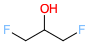

OC(CF)CF
Entry
CHOF_G4
OC(CF)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.804,146.316,167.21,182.42,205.076,220.159,238.953],'J/(mol*K)'), H298=(-637.543,'kJ/mol'), S298=(339.407,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.99,29.03,34.22,37.78,41.96,44.27,47.11],'J/(mol*K)'), H298=(-25.1,'kJ/mol'), S298=(-52.05,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(Cs-CsCsOsH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.99,29.03,34.22,37.78,41.96,44.27,47.11],'J/(mol*K)'), H298=(-25.1,'kJ/mol'), S298=(-52.05,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsOsH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,

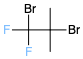

CC(C)(Br)C(F)(F)Br
Entry
CHOFBr_G4
CC(C)(Br)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([155.005,179.316,200.028,217.557,244.592,263.219,287.632],'J/(mol*K)'), H298=(-508.514,'kJ/mol'), S298=(407.285,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.291,111.773,118.98,124.675,133.227,137.684,139.366],'J/(mol*K)'), H298=(-417.334,'kJ/mol'), S298=(185.415,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCC) + missing(Cs-CsHHH) + missing(Cs-CsHHH) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.431,112.946,119.853,125.367,133.698,137.933,138.207],'J/(mol*K)'), H298=(-429.59,'kJ/mol'), S298=(181.788,'J/(mol*K)'), comment="""Thermo group additivity estim

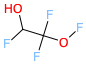

OC(F)C(F)(F)OF
Entry
CHOF_G4
OC(F)C(F)(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.88,156.977,170.493,180.452,194.292,202.105,208.224],'J/(mol*K)'), H298=(-916.476,'kJ/mol'), S298=(373.931,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.1774,75.703,83.9207,89.8899,98.0161,102.814,107.267],'J/(mol*K)'), H298=(-267.869,'kJ/mol'), S298=(183.959,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(O2sCF) + group(CsCFHO) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['O2s-CsH_O2s-CsH', 'CsCFFO_Cs-CsF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.412,76.3391,83.8654,89.6141,97.7164,102.299,105.894],'J/(mol*K)'), H298=(-287.427,'kJ/mol'), S298=(183.148,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(

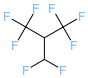

FC(F)C(C(F)(F)F)C(F)(F)F
Entry
CHOF_G4
FC(F)C(C(F)(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([170.437,202.43,227.248,245.82,269.575,284.472,302.234],'J/(mol*K)'), H298=(-1808.45,'kJ/mol'), S298=(448.112,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.4399,24.8748,32.2977,37.0426,42.0964,45.6049,51.3724],'J/(mol*K)'), H298=(32.4648,'kJ/mol'), S298=(-59.0058,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoDa

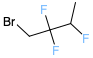

CC(F)C(F)(F)CBr
Entry
CHOFBr_G4
CC(F)C(F)(F)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([149.047,179.886,203.008,220.738,247.687,265.947,288.655],'J/(mol*K)'), H298=(-727.978,'kJ/mol'), S298=(403.623,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([75.0525,89.6042,101.385,110.537,124.099,133.39,145.93],'J/(mol*K)'), H298=(-225.076,'kJ/mol'), S298=(211.544,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrCsHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.9824,91.7116,102.345,111.123,124.464,133.214,143.655],'J/(mol*K)'), H298=(-254.4,'kJ/mol'), S298=(208.216,

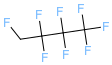

FCC(F)(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
FCC(F)(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([181.842,209.721,230.555,246.494,269.277,284.099,300.876],'J/(mol*K)'), H298=(-1736.99,'kJ/mol'), S298=(459.112,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-5.16563,-4.54995,-1.89951,-0.873491,-0.838467,0.240997,4.91407],'J/(mol*K)'), H298=(115.776,'kJ/mol'), S298=(2.83666,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsC

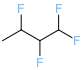

CC(F)C(F)C(F)F
Entry
CHOF_G4
CC(F)C(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([145.276,174.912,196.536,214.529,242.008,260.642,284.453],'J/(mol*K)'), H298=(-924.593,'kJ/mol'), S298=(383.157,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([68.5784,82.1909,92.8469,100.917,112.627,120.24,129.554],'J/(mol*K)'), H298=(-427.613,'kJ/mol'), S298=(99.2289,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.0572,83.4632,92.6706,100.146,111.653,118.843,126.703],'J/(mol*K)'), H2

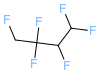

FCC(F)(F)C(F)C(F)F
Entry
CHOF_G4
FCC(F)(F)C(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([165.225,194.749,216.695,233.11,257.505,273.964,294.123],'J/(mol*K)'), H298=(-1306.58,'kJ/mol'), S298=(426.748,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([31.8248,39.8232,46.5012,50.9002,56.726,60.9655,67.4686],'J/(mol*K)'), H298=(-172.08,'kJ/mol'), S298=(51.6652,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCsCsFH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.07

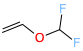

C=COC(F)F
Entry
CHOF_G4
CDCOC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.71,121.258,134.798,146.419,164.785,177.973,196.788],'J/(mol*K)'), H298=(-553.429,'kJ/mol'), S298=(337.238,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sF1sO2sH) + group(Cds-CdsOsH) + missing(Cd-CdHH)""")

missing
['CsFFHO_Cs-F1sF1sO2sH', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(Cds-CdsOsH)""")

GAE with

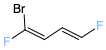

FC=CC=C(F)Br
Entry
CHOFBr_G4
FCDCCDC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.969,131.714,149.487,163.25,181.733,194.06,209.841],'J/(mol*K)'), H298=(-241.651,'kJ/mol'), S298=(363.722,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.2131,97.9324,109.602,117.81,129.704,137.59,148.415],'J/(mol*K)'), H298=(-72.4719,'kJ/mol'), S298=(231.843,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + missing(Cd-CdF1sH) + group(CdBrCF)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.2131,97.9324,109.602,117.81,129.704,137.59,148.415],'J/(mol*K)'), H298=(-72.4719,'kJ/mol'), S298=(231.843,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + group(CdBrCF)""")

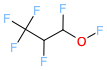

FOC(F)C(F)C(F)(F)F
Entry
CHOF_G4
FOC(F)C(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.746,171.553,191.161,206.54,227.89,240.951,255.998],'J/(mol*K)'), H298=(-1160.83,'kJ/mol'), S298=(424.32,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([100.017,118.253,131.283,141.063,154.85,163.114,171.782],'J/(mol*K)'), H298=(-476.035,'kJ/mol'), S298=(231.477,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCFHO) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F))""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([100.941,118.071,130.201,139.687,153.543,161.721,169.246],'J/(mol*K)'), H298=(-518.178,'kJ/mol

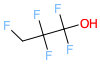

OC(F)(F)C(F)(F)CF
Entry
CHOF_G4
OC(F)(F)C(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([150.94,178.585,196.762,211.209,231.994,244.554,256.267],'J/(mol*K)'), H298=(-1308.05,'kJ/mol'), S298=(385.348,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.69212,-3.43615,-2.03165,-1.48812,-1.28179,-0.536142,2.45897],'J/(mol*K)'), H298=(50.931,'kJ/mol'), S298=(4.02198,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([

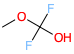

COC(O)(F)F
Entry
CHOF_G4
COC(O)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([100.001,115.24,129.027,140.915,159.82,173.479,192.827],'J/(mol*K)'), H298=(-862.757,'kJ/mol'), S298=(349.632,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.0207,68.7819,75.4505,80.4865,86.9857,90.3669,91.4541],'J/(mol*K)'), H298=(-630.315,'kJ/mol'), S298=(98.7973,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(O2s-CsH) + group(CsFFOO) + missing(Cs-O2sHHH)""")

missing
['O2s-CsH_O2s-CsH', 'Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.0207,68.7819,75.4505,80.4865,86.9857,90.3669,91.4541],'J/(mol*K)'), H298=(-630.315,'kJ/mol'), S298=(98.7973,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(CsFFOO)""")

GAE with fitted GAV
ThermoData(

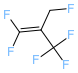

FCC(=C(F)F)C(F)(F)F
Entry
CHOF_G4
FCC(DC(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.79,161.444,181.155,197.413,221.359,236.551,253.105],'J/(mol*K)'), H298=(-1221.73,'kJ/mol'), S298=(368.658,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([13.9156,16.6008,19.1525,20.917,23.3719,24.5298,26.3426],'J/(mol*K)'), H298=(51.4707,'kJ/mol'), S298=(-55.6603,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)2) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CsCdFFF_Cs-CdF1sF1sF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)')

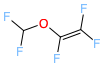

FC(F)=C(F)OC(F)F
Entry
CHOF_G4
FC(F)DC(F)OC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([131.351,149.718,163.535,174.236,189.798,200.009,211.744],'J/(mol*K)'), H298=(-1084.95,'kJ/mol'), S298=(399.989,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([48.8033,55.907,60.3838,63.5277,66.8005,68.3128,68.2404],'J/(mol*K)'), H298=(-258.942,'kJ/mol'), S298=(73.8538,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sF1sO2sH) + group(CdCFO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CsFFHO_Cs-F1sF1sO2sH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.1875,54.1148,59.2226,62.679,66.5978,68.4315,69.0042],'J/(mol*K)'), H298=(-298.857,'kJ/mol'), S298=(72.4644,'J/(mol*K)'), comment="""Thermo group additivity

OCCCF
Entry
CHOF_G4
OCCCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.801,134.31,157.348,174.573,199.04,215.179,235.204],'J/(mol*K)'), H298=(-441.632,'kJ/mol'), S298=(318.491,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsHH) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sHH)""")

missing
['O2s-CsH_O2s-CsH', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.49,127.011,145.185,160.707,185.353,203.51,231.04],'J/(mol*K)','+|-',[0.742351,0.776006,0.

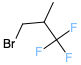

CC(CBr)C(F)(F)F
Entry
CHOFBr_G4
CC(CBr)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.02,172.048,193.36,211.397,239.223,258.415,283.742],'J/(mol*K)'), H298=(-771.958,'kJ/mol'), S298=(402.275,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.4492,75.084,86.0092,94.7316,107.591,115.842,127.038],'J/(mol*K)'), H298=(-31.5986,'kJ/mol'), S298=(108.483,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsHHH) + group(CsBrCsHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.4492,75.084,86.0092,94.7316,107.591,115.842,127.038],'J/(mol*K)'), H298=(-31.5986,'kJ/mol'), S298=(108.483,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + group(CsBrCsHH)""")

G

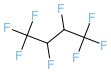

FC(C(F)C(F)(F)F)C(F)(F)F
Entry
CHOF_G4
FC(C(F)C(F)(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([179.164,209.775,231.162,246.812,269.866,284.693,300.886],'J/(mol*K)'), H298=(-1774.29,'kJ/mol'), S298=(445.69,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([70.4538,84.4629,94.7138,102.402,113.594,120.748,130.297],'J/(mol*K)'), H298=(-391.549,'kJ/mol'), S298=(96.7038,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F))""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'

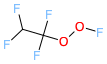

FOOC(F)(F)C(F)F
Entry
CHOF_G4
FOOC(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([145.901,163.221,176.24,186.746,201.575,210.184,217.176],'J/(mol*K)'), H298=(-878.054,'kJ/mol'), S298=(397.509,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([13.8601,15.233,17.1595,18.4866,20.6773,23.2164,25.3538],'J/(mol*K)'), H298=(8.78012,'kJ/mol'), S298=(38.9421,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + missing(O2s-F1sO2s) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['O2sFO_O2s-F1sO2s', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([16.3176,18.033,19.2464,20.2506,22.2589,24.2672,24.2672],'J/(mol*K)'), H298=(-22.5936,

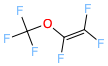

FC(F)=C(F)OC(F)(F)F
Entry
CHOF_G4
FC(F)DC(F)OC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.451,155.611,171.72,183.8,199.323,207.803,217.101],'J/(mol*K)'), H298=(-1318.84,'kJ/mol'), S298=(407.972,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.2829,54.0287,59.4989,63.2139,66.7786,68.4039,68.8749],'J/(mol*K)'), H298=(-253.372,'kJ/mol'), S298=(75.9291,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + group(CdCFO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CsFFFO_Cs-F1sF1sF1sO2s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.1875,54.1148,59.2226,62.679,66.5978,68.4315,69.0042],'J/(mol*K)'), H298=(-298.857,'kJ/mol'), S

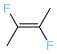

CC(F)=C(C)F
Entry
CHOF_G4
CC(F)DC(C)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.566,133.139,150.163,165.582,190.619,209.227,236.858],'J/(mol*K)'), H298=(-400.164,'kJ/mol'), S298=(372.107,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([1.19713,0.707891,0.406312,0.312251,0.131804,0.0198296,-0.50661],'J/(mol*K)'), H298=(25.1845,'kJ/mol'), S298=(1.61205,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + missing(Cs-CdHHH) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdF1s)CdHHH', 'Cs-(Cds-Cds)HHH_Cs-(CdF1s)CdHHH', 'CdCsCdF_Cd-CdCsF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'

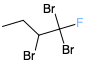

CCC(Br)C(F)(Br)Br
Entry
CHOFBr_G4
CCC(Br)C(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([164,189.295,208.68,224.09,247.716,264.72,288.445],'J/(mol*K)'), H298=(-245.399,'kJ/mol'), S298=(450.386,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.575,121.938,130.318,136.841,146.131,151.277,154.929],'J/(mol*K)'), H298=(-173.835,'kJ/mol'), S298=(292.402,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsBrCsCsH) + missing(Cs-CsHHH) + group(CsBrBrCF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.715,123.11,131.191,137.533,146.602,151.525,153.77],'J/(mol*K)'), H298=(-186.092,'kJ/mol'), S298=(288.775,'J/(mol*K)'), comment="""Thermo group additivity estimati

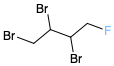

FCC(Br)C(Br)CBr
Entry
CHOFBr_G4
FCC(Br)C(Br)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([156.618,188.373,214.404,234.943,262.04,277.554,297.182],'J/(mol*K)'), H298=(-251.093,'kJ/mol'), S298=(439.063,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.422,141.799,158.967,172.332,191.225,202.889,216.19],'J/(mol*K)'), H298=(-30.458,'kJ/mol'), S298=(293.965,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCsCsH) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsBrCsCsH) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br)) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br))""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated

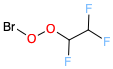

FC(F)C(F)OOBr
Entry
CHOFBr_G4
FC(F)C(F)OOBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.2,149.22,162.923,174.132,190.405,200.42,210.335],'J/(mol*K)'), H298=(-616.679,'kJ/mol'), S298=(412.261,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([88.4814,101.069,109.726,115.573,122.898,127.482,130.54],'J/(mol*K)'), H298=(-181.801,'kJ/mol'), S298=(239.549,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2sBrO) + group(CsCFHO) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.716,101.705,109.671,115.297,122.598,126.967,129.168],'J/(mol*K)'), H298=(-201.358,'kJ/mol'), S298=(238.738,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2sBrO)

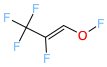

FOC=C(F)C(F)(F)F
Entry
CHOF_G4
FOCDC(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([130.708,149.946,164.361,175.215,190.06,199.688,211.699],'J/(mol*K)'), H298=(-815.188,'kJ/mol'), S298=(396.585,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([48.6648,55.9198,61.769,66.59,73.4486,78.0058,83.5197],'J/(mol*K)'), H298=(32.7203,'kJ/mol'), S298=(174.653,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cd(F)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([50.8573,59.8902,65.9796,70.0468,75.2872,78.4609,83.3802],'J/(mol*K)'), H298=(-20.2719,'kJ/mol'), S298=(166.789,'J/(m

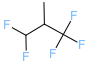

CC(C(F)F)C(F)(F)F
Entry
CHOF_G4
CC(C(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([147.404,174.967,196.857,214.318,241.252,260.308,286.166],'J/(mol*K)'), H298=(-1197.08,'kJ/mol'), S298=(400.202,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.4742,24.9304,30.573,34.469,39.4849,42.6723,47.6715],'J/(mol*K)'), H298=(4.04538,'kJ/mol'), S298=(-52.9187,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comm

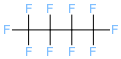

FC(F)(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
FC(F)(F)C(F)(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([196.281,230.983,255.982,273.063,293.241,305.069,315.182],'J/(mol*K)'), H298=(-2167.79,'kJ/mol'), S298=(467.785,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-5.40454,-5.02763,-1.82266,-0.534652,-0.694912,0.503483,5.99682],'J/(mol*K)'), H298=(161.063,'kJ/mol'), S298=(0.840097,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + missing(Cs-CsF1sF1sF1s)

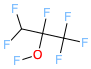

FOC(F)(C(F)F)C(F)(F)F
Entry
CHOF_G4
FOC(F)(C(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([164.197,193.146,212.886,225.964,243.759,254.412,263.501],'J/(mol*K)'), H298=(-1355,'kJ/mol'), S298=(426.954,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([29.5479,32.8698,35.604,37.0542,38.6778,40.1112,42.9819],'J/(mol*K)'), H298=(30.5978,'kJ/mol'), S298=(138.385,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sO2s) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCCFO_Cs-CsCsF1sO2s', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0

FOOF
Entry
CHOF_G4
FOOF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.9476,64.6477,69.9724,73.3341,77.7997,80.4583,82.9197],'J/(mol*K)'), H298=(34.9472,'kJ/mol'), S298=(280.625,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(78.9875,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-F1sO2s) + missing(O2s-F1sO2s)""")

missing
['O2sFO_O2s-F1sO2s', 'O2sFO_O2s-F1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.6533,66.0337,70.1314,73.37,77.1284,78.2658,80.1049],'J/(mol*K)','+|-',[1.43923,1.50448,1.41056,1.30975,1.13556,1.00838,1.94902]), H298=(61.6799,'kJ/mol','+|-',6.94737), S298=(277

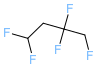

FCC(F)(F)CC(F)F
Entry
CHOF_G4
FCC(F)(F)CC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([158.429,184.35,204.862,222.08,248.271,265.906,288.078],'J/(mol*K)'), H298=(-1143.23,'kJ/mol'), S298=(408.791,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.2346,-0.636123,0.0552886,0.275793,0.299765,0.514653,1.37234],'J/(mol*K)'), H298=(19.5573,'kJ/mol'), S298=(0.811252,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsCsHH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData

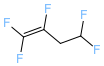

FC(F)=C(F)CC(F)F
Entry
CHOF_G4
FC(F)DC(F)CC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([135.301,157.434,176.075,191.641,215.095,230.613,249.313],'J/(mol*K)'), H298=(-972.779,'kJ/mol'), S298=(396.757,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([24.0378,30.4945,35.9721,40.5549,47.1472,52.0976,59.3184],'J/(mol*K)'), H298=(19.9995,'kJ/mol'), S298=(42.3926,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CsF1sF1sH) + missing(Cd-CdCsF1s) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CdCsCdF_Cd-CdCsF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), com

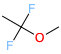

COC(C)(F)F
Entry
CHOF_G4
COC(C)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.515,139.93,158.897,174.633,197.97,214.139,237.722],'J/(mol*K)'), H298=(-703.324,'kJ/mol'), S298=(352.397,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.7,13.4,13.58,14.54,16.71,18.29,20.17],'J/(mol*K)'), H298=(-98.6,'kJ/mol'), S298=(38.61,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsHHH) + missing(Cs-O2sHHH)""")

missing
['CsCFFO_Cs-CsF1sF1sO2s', 'Cs-CsHHH_Cs-CsHHH', 'Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.7,13.4,13.58,14.54,16.71,18.29,20.17],'J/(mol*K)'), H298=(-98.6,'kJ/mol'), S298=(38.61,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,6

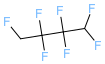

FCC(F)(F)C(F)(F)C(F)F
Entry
CHOF_G4
FCC(F)(F)C(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([172.259,199.668,221.755,239.812,266.098,282.371,298.768],'J/(mol*K)'), H298=(-1506.9,'kJ/mol'), S298=(446.094,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.14964,-6.23617,-4.11859,-3.25204,-2.86334,-1.58694,3.5456],'J/(mol*K)'), H298=(103.225,'kJ/mol'), S298=(7.23271,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyc

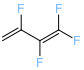

C=C(F)C(F)=C(F)F
Entry
CHOF_G4
CDC(F)C(F)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([121.183,143.594,158.583,170.498,188.049,199.188,211.384],'J/(mol*K)'), H298=(-623.751,'kJ/mol'), S298=(359.934,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.9121,69.6564,76.235,81.0371,87.4651,90.9204,92.5077],'J/(mol*K)'), H298=(-284.32,'kJ/mol'), S298=(92.6365,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CdCCF) + longDistanceInteraction_noncyclic(Cds(F)-Cds(F)) + group(CdCCF) + longDistanceInteraction_noncyclic(Cds(F)-Cds(F)) + missing(Cd-CdHH) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['Cds-CdsHH_Cd-CdHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.7948,68.0876,74.4193,79.7556,87.592,91.6288,92.2522],'J/(mol*K)'), H298=

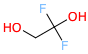

OCC(O)(F)F
Entry
CHOF_G4
OCC(O)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.121,134.858,152.202,164.211,181.412,192.1,203.217],'J/(mol*K)'), H298=(-864.685,'kJ/mol'), S298=(325.522,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sF1sO2s)""")

missing
['O2s-CsH_O2s-CsH', 'O2s-CsH_O2s-CsH', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCFFO_Cs-CsF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.677,128.537,142.083,153.101,169.795,181.188,196.895],'J/(mol*K)','+|-',[0.876

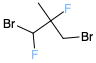

CC(F)(CBr)C(F)Br
Entry
CHOFBr_G4
CC(F)(CBr)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.769,182.482,205.55,223.761,249.267,266.383,289.781],'J/(mol*K)'), H298=(-479.721,'kJ/mol'), S298=(427.217,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.373,147.373,162.339,174.2,191.587,202.355,213.864],'J/(mol*K)'), H298=(-439.038,'kJ/mol'), S298=(308.115,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([130.285,149.841,164.073,175.722,192.869,203.083,212.476],'J/(mol*K)'), H298=(-458.93

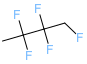

CC(F)(F)C(F)(F)CF
Entry
CHOF_G4
CC(F)(F)C(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.81,180.995,201.951,219.552,246.433,264.64,287.652],'J/(mol*K)'), H298=(-1150.94,'kJ/mol'), S298=(403.724,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.69212,-3.43615,-2.03165,-1.48812,-1.28179,-0.536142,2.45897],'J/(mol*K)'), H298=(50.931,'kJ/mol'), S298=(4.02198,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata

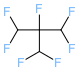

FC(F)C(F)(C(F)F)C(F)F
Entry
CHOF_G4
FC(F)C(F)(C(F)F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([172.62,203.824,227.413,244.703,267.514,282.445,300.071],'J/(mol*K)'), H298=(-1507.85,'kJ/mol'), S298=(441.105,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([31.3601,37.8995,42.751,45.582,48.8538,50.7051,52.6795],'J/(mol*K)'), H298=(-174.635,'kJ/mol'), S298=(-32.674,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.0639,39.8079,42.5852,

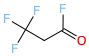

O=C(F)CC(F)(F)F
Entry
CHOF_G4
ODC(F)CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.843,130.98,146.979,160.209,179.76,192.237,206.9],'J/(mol*K)'), H298=(-1097.55,'kJ/mol'), S298=(375.555,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([29.8091,33.9336,38.0433,41.65,47.4371,51.9602,59.2891],'J/(mol*K)'), H298=(-14.4513,'kJ/mol'), S298=(38.802,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-CO) + missing(CO-CsF1sO2d)""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.91,30.8,34.98,38.91,45.56,50.73,58.93],'J/(mol*K)'), H298=(-21.5,'kJ/mol'), S298=(40.32,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH)"""

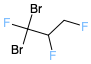

FCC(F)C(F)(Br)Br
Entry
CHOFBr_G4
FCC(F)C(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.451,155.558,171.522,184.73,204.301,216.865,231.016],'J/(mol*K)'), H298=(-600.346,'kJ/mol'), S298=(426.301,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([103.245,115.353,124.596,131.623,141.633,147.743,153.683],'J/(mol*K)'), H298=(-374.192,'kJ/mol'), S298=(273.363,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrBrCF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.629,117.161,125.348,131.819,141.43,147.109,151.045],'J/(mol*K)'), H298=(-400.78,'kJ/mol'), S298=(269.7

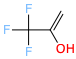

C=C(O)C(F)(F)F
Entry
CHOF_G4
CDC(O)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([112.872,131.942,145.903,157.565,175.275,187.172,202.101],'J/(mol*K)'), H298=(-792.829,'kJ/mol'), S298=(347.708,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.44,50.6533,54.6878,56.5762,58.5138,59.5111,61.7469],'J/(mol*K)'), H298=(-152.785,'kJ/mol'), S298=(54.7047,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdHH)""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.6206,49.379,53.6074,55.3252,57.7246,58.9469,60.7434],'J/(mol*K)'), H298=(-175.422,'kJ/mol'), S298=(54.7531,'J/(mol*K)'), comment="""Thermo group additivity est

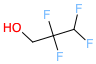

OCC(F)(F)C(F)F
Entry
CHOF_G4
OCC(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([143.956,168.212,184.019,196.933,216.306,229.075,244.744],'J/(mol*K)'), H298=(-1072.26,'kJ/mol'), S298=(380.256,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.45752,-2.80002,-2.08694,-1.76392,-1.58155,-1.05079,1.08663],'J/(mol*K)'), H298=(31.3737,'kJ/mol'), S298=(3.21073,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,

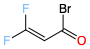

O=C(Br)C=C(F)F
Entry
CHOFBr_G4
ODC(Br)CDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([103.427,119.079,130.26,138.605,151.033,159.156,168.394],'J/(mol*K)'), H298=(-464.435,'kJ/mol'), S298=(363.757,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.2894,72.56,78.9981,84.3145,92.1361,97.2139,102.313],'J/(mol*K)'), H298=(-88.4338,'kJ/mol'), S298=(215.611,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COBrCO) + missing(Cd-CdF1sF1s)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.2894,72.56,78.9981,84.3145,92.1361,97.2139,102.313],'J/(mol*K)'), H298=(-88.4338,'kJ/mol'), S298=(215.611,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COBrCO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,80

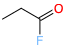

CCC(=O)F
Entry
CHOF_G4
CCC(DO)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.4694,103.82,117.544,130.363,151.484,167.393,191.506],'J/(mol*K)'), H298=(-460.183,'kJ/mol'), S298=(323.751,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.91,30.8,34.98,38.91,45.56,50.73,58.93],'J/(mol*K)'), H298=(-21.5,'kJ/mol'), S298=(40.32,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH) + missing(Cs-CsHHH) + missing(CO-CsF1sO2d)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.91,30.8,34.98,38.91,45.56,50.73,58.93],'J/(mol*K)'), H298=(-21.5,'kJ/mol'), S298=(40.32,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([

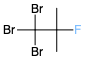

CC(C)(F)C(Br)(Br)Br
Entry
CHOFBr_G4
CC(C)(F)C(Br)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([159.516,182.958,201.361,216.779,242.12,260.769,287.271],'J/(mol*K)'), H298=(-247.209,'kJ/mol'), S298=(437.74,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([106.777,116.165,122.727,127.965,135.509,139.05,139.691],'J/(mol*K)'), H298=(-170.222,'kJ/mol'), S298=(210.716,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsHHH) + missing(Cs-CsHHH) + group(CsBrBrBrCs) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.917,117.337,123.6,128.656,135.98,139.299,138.531],'J/(mol*K)'), H298=(-182.478,'kJ/mol'), S298=(207.089,'J/(mol*K)'), comment="""Thermo group additivity estim

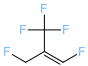

FC=C(CF)C(F)(F)F
Entry
CHOF_G4
FCDC(CF)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([131.4,154.904,174.213,189.955,212.994,228.046,248.718],'J/(mol*K)'), H298=(-1015.41,'kJ/mol'), S298=(392.781,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + missing(Cs-CdF1sF1sF1s) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CsCdFFF_Cs-CdF1sF1sF1s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-CdsCs

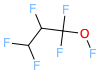

FOC(F)(F)C(F)C(F)F
Entry
CHOF_G4
FOC(F)(F)C(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([154.607,176.227,193.575,207.778,228.466,241.288,254.271],'J/(mol*K)'), H298=(-1141.83,'kJ/mol'), S298=(431.239,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.0427,73.3209,80.4597,85.7349,93.639,98.9128,105.712],'J/(mol*K)'), H298=(-220.402,'kJ/mol'), S298=(191.702,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(CsCsCsFH) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([66.5119,74.5931,80.3492,85.1833,93.0395,97.8835,102.967],'J/(mol*K)'), H298=(-259.517,'kJ/mol'), S298=(190.

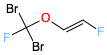

FC=COC(F)(Br)Br
Entry
CHOFBr_G4
FCDCOC(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.201,151.706,165.378,175.719,190.396,200.073,211.477],'J/(mol*K)'), H298=(-423.026,'kJ/mol'), S298=(424.595,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([106.741,120.826,130.735,137.626,145.758,149.861,153.251],'J/(mol*K)'), H298=(-272.852,'kJ/mol'), S298=(277.214,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrBrFO) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.332,124.602,134.82,140.961,147.639,150.622,153.89],'J/(mol*K)'), H298=(-299.62,'kJ/mol'), S298=(270.963,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) 

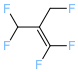

FCC(=C(F)F)C(F)F
Entry
CHOF_G4
FCC(DC(F)F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.786,154.995,173.024,188.241,211.595,227.539,247.966],'J/(mol*K)'), H298=(-976.915,'kJ/mol'), S298=(405.677,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + missing(Cs-CdF1sF1sH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CsCFFH_Cs-CdF1sF1sH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-CdsC

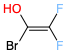

OC(Br)=C(F)F
Entry
CHOFBr_G4
OC(Br)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.2628,104.017,111.81,118.308,128.08,134.537,142.401],'J/(mol*K)'), H298=(-449.945,'kJ/mol'), S298=(354.688,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(153.818,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.2416,68.1485,72.1764,74.6861,77.3988,79.2966,81.4243],'J/(mol*K)'), H298=(-118.758,'kJ/mol'), S298=(183.117,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CdBrCO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(Val7)2=Cds(Val7))""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.423,65.6604,70.4012,73.2331,76.7818,79.1171,82.0128],'J/(mol*K)'), H298=(-136.059,'kJ/mol'), S298=(184.53,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CdBrCO)""

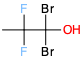

CC(F)(F)C(O)(Br)Br
Entry
CHOFBr_G4
CC(F)(F)C(O)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.047,172.243,187.671,200.534,219.866,232.626,248.092],'J/(mol*K)'), H298=(-645.636,'kJ/mol'), S298=(425.434,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.4392,64.2743,68.3116,70.92,73.8486,75.0124,74.321],'J/(mol*K)'), H298=(22.8808,'kJ/mol'), S298=(108.734,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + group(CsBrBrCO) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.8492,67.6256,71.2732,73.6936,76.2003,76.6952,73.825],'J/(mol*K)'), H298=(7.

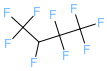

FC(C(F)(F)F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
FC(C(F)(F)F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([186.309,218.8,242.056,258.151,279.419,292.855,306.605],'J/(mol*K)'), H298=(-1974.05,'kJ/mol'), S298=(466.394,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.1409,40.7996,47.4838,51.8434,57.2032,61.225,68.2368],'J/(mol*K)'), H298=(-128.998,'kJ/mol'), S298=(48.0005,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData

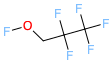

FOCC(F)(F)C(F)(F)F
Entry
CHOF_G4
FOCC(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([157.868,182.255,198.853,211.639,230.51,242.485,255.239],'J/(mol*K)'), H298=(-1169.81,'kJ/mol'), S298=(418.001,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.031,31.9213,33.5723,34.9372,37.1243,38.616,41.1344],'J/(mol*K)'), H298=(13.6244,'kJ/mol'), S298=(142.081,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.7654,'kJ/mol'), S298=(140.849,'J/(mol*K)'), co

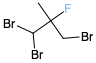

CC(F)(CBr)C(Br)Br
Entry
CHOFBr_G4
CC(F)(CBr)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([160.604,187.398,207.51,223.835,248.947,266.143,288.186],'J/(mol*K)'), H298=(-260.118,'kJ/mol'), S298=(447.423,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.369,152.166,167.023,178.746,195.731,205.959,216.13],'J/(mol*K)'), H298=(-226.339,'kJ/mol'), S298=(330.177,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsBrBrCsH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([135.28,154.634,168.757,180.268,197.013,206.688,214.742],'J/(mol*K)'), H298=(-24

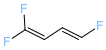

FC=CC=C(F)F
Entry
CHOF_G4
FCDCCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([106.157,128.956,145.662,158.984,179.031,192.236,207.784],'J/(mol*K)'), H298=(-472.423,'kJ/mol'), S298=(342.508,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3213,48.4507,56.484,62.0906,69.8728,75.2283,83.5126],'J/(mol*K)'), H298=(56.735,'kJ/mol'), S298=(53.3878,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + missing(Cd-CdF1sH) + missing(Cd-CdF1sF1s)""")

missing
['CdCFH_Cd-CdF1sH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3213,48.4507,56.484,62.0906,69.8728,75.2283,83.5126],'J/(mol*K)'), H298=(56.735,'kJ/mol'), S298=(53.3878,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cd

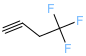

C#CCC(F)(F)F
Entry
CHOF_G4
C#CCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.378,130.356,145.177,157.306,175.908,188.614,205.082],'J/(mol*K)'), H298=(-484.604,'kJ/mol'), S298=(340.4,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([20.7108,27.447,33.1791,37.9907,45.4382,51.003,59.4128],'J/(mol*K)'), H298=(-19.7903,'kJ/mol'), S298=(43.0952,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CtCsHH) + missing(Cs-CsF1sF1sF1s) + missing(Ct-CsCt) + missing(Ct-CtH)""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'Ct-CtCs_Ct-CsCt', 'Ct-CtH_Ct-CtH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([20.7108,27.447,33.1791,37.9907,45.4382,51.003,59.4128],'J/(mol*K)'), H298=(-19.7903,'kJ/mol'), S298=(43.0952,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CtCsHH)""")

GAE with fitted G

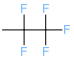

CC(F)(F)C(F)(F)F
Entry
CHOF_G4
CC(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.934,146.718,162.921,176.438,196.858,210.43,226.935],'J/(mol*K)'), H298=(-1171.53,'kJ/mol'), S298=(362.241,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.952312,-0.940249,-0.44155,-0.173174,-0.0885042,0.154087,1.51887],'J/(mol*K)'), H298=(42.3898,'kJ/mol'), S298=(1.23249,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,15

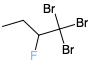

CCC(F)C(Br)(Br)Br
Entry
CHOFBr_G4
CCC(F)C(Br)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([158.914,182.703,202.91,219.955,246.115,264.024,287.459],'J/(mol*K)'), H298=(-229.138,'kJ/mol'), S298=(447.848,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.241,118.089,126.477,133.283,143.381,149.311,154.48],'J/(mol*K)'), H298=(-167.667,'kJ/mol'), S298=(295.055,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsHHH) + group(CsBrBrBrCs) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.381,119.261,127.35,133.975,143.852,149.559,153.32],'J/(mol*K)'), H298=(-179.923,'kJ/mol'), S298=(291.428,'J/(mol*K)'), comment="""Thermo group additivity es

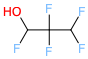

OC(F)C(F)(F)C(F)F
Entry
CHOF_G4
OC(F)C(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([148.817,172.292,188.699,201.98,221.766,234.574,249.122],'J/(mol*K)'), H298=(-1281.03,'kJ/mol'), S298=(404.597,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.7366,40.0415,47.8199,53.0156,59.2218,63.3012,68.7377],'J/(mol*K)'), H298=(-207.73,'kJ/mol'), S298=(46.3214,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + group(CsCFHO) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.4287,43.4776,49.8515,54.5037,60.50

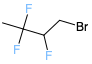

CC(F)(F)C(F)CBr
Entry
CHOFBr_G4
CC(F)(F)C(F)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([151.774,177.762,198.68,216.315,243.343,261.782,285.618],'J/(mol*K)'), H298=(-730.878,'kJ/mol'), S298=(408.217,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([75.5319,90.0783,101.682,110.739,124.148,133.338,145.512],'J/(mol*K)'), H298=(-224.709,'kJ/mol'), S298=(212.452,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.9824,91.7116,102.345,111.123,124.464,133.214,143.65

COC=CF
Entry
CHOF_G4
COCDCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.4968,107.386,121.38,133.659,153.744,168.89,191.963],'J/(mol*K)'), H298=(-270.789,'kJ/mol'), S298=(318.948,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3531,46.5727,53.1413,57.5213,61.6931,63.7577,65.8456],'J/(mol*K)'), H298=(-88.638,'kJ/mol'), S298=(51.1009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-O2sHHH) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['Cs-OsHHH_Cs-O2sHHH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd

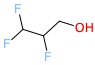

OCC(F)C(F)F
Entry
CHOF_G4
OCC(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.189,151.952,168.944,183.245,205.183,220.192,239.851],'J/(mol*K)'), H298=(-847.514,'kJ/mol'), S298=(368.558,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.294,41.0955,46.3906,50.3487,56.1265,59.9362,64.724],'J/(mol*K)'), H298=(-211.194,'kJ/mol'), S298=(50.0427,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(CsCsCsFH) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['O2s-CsH_O2s-CsH', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.0729,55.8267,59.4216,63.3516],'J/(mol*K)'), H298=(-230.751,'kJ/mol'), S298=(49.2315,'J/(mol*K)'), comment="""Thermo group addit

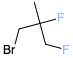

CC(F)(CF)CBr
Entry
CHOFBr_G4
CC(F)(CF)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.669,163.019,185.337,204.095,232.749,252.46,280.976],'J/(mol*K)'), H298=(-501.918,'kJ/mol'), S298=(395.322,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([75.0577,88.1545,97.9973,105.641,116.649,123.445,130.828],'J/(mol*K)'), H298=(-232.49,'kJ/mol'), S298=(127.256,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.5177,89.7879,98.595

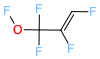

FC=C(F)C(F)(F)OF
Entry
CHOF_G4
FCDC(F)C(F)(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.829,158.978,172.473,182.968,197.987,206.959,215.022],'J/(mol*K)'), H298=(-790.557,'kJ/mol'), S298=(388.313,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.1456,33.9169,34.7909,35.7221,37.6504,38.9175,40.7267],'J/(mol*K)'), H298=(13.0124,'kJ/mol'), S298=(142.175,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CdF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CsCFFO_Cs-CdF1sF1sO2s', 'CdCsCdF_Cd-CdCsF1s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128

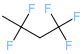

CC(F)(F)CC(F)(F)F
Entry
CHOF_G4
CC(F)(F)CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([148.017,175.463,196.804,214.753,242.399,261.383,285.978],'J/(mol*K)'), H298=(-1217.35,'kJ/mol'), S298=(401.848,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([144.834,173.697,197.317,216.428,244.526,263.569,28

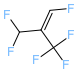

FC=C(C(F)F)C(F)(F)F
Entry
CHOF_G4
FCDC(C(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([145.135,167.854,185.546,199.629,220.671,235.079,253.304],'J/(mol*K)'), H298=(-1224.43,'kJ/mol'), S298=(415.926,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sF1sH) + missing(Cs-CdF1sF1sF1s) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'CsCdFFF_Cs-CdF1sF1sF1s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: gro

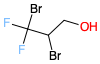

OCC(Br)C(F)(F)Br
Entry
CHOFBr_G4
OCC(Br)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([154.798,173.001,187.927,200.334,218.891,231.054,245.737],'J/(mol*K)'), H298=(-612.204,'kJ/mol'), S298=(433.511,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.954,115.439,124.737,132.064,142.556,148.511,153.293],'J/(mol*K)'), H298=(-421.401,'kJ/mol'), S298=(273.215,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(CsBrCsCsH) + missing(Cs-CsO2sHH) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['O2s-CsH_O2s-CsH', 'Cs-CsOsHH_Cs-CsO2sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.094,116.611,125.61,132.756,143.028,148.76,152.133],'J/(mol*K)'), H298=(-433.658,'kJ/mol'), S298=(269.588,'J/(mol*K)'), comment="""Thermo group additivity estima

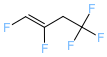

FC=C(F)CC(F)(F)F
Entry
CHOF_G4
FCDC(F)CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.727,158.418,178.352,193.458,215.718,231,250.379],'J/(mol*K)'), H298=(-1023.48,'kJ/mol'), S298=(398.001,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([20.0989,27.5318,34.3323,39.7046,47.0544,52.3273,60.2102],'J/(mol*K)'), H298=(10.8384,'kJ/mol'), S298=(44.6906,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.70

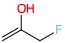

C=C(O)CF
Entry
CHOF_G4
CDC(O)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.0706,118.162,132.596,143.992,161.965,174.875,193.632],'J/(mol*K)'), H298=(-339.147,'kJ/mol'), S298=(314.277,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.657,49.7249,54.1354,56.6211,59.6179,60.7947,63.3129],'J/(mol*K)'), H298=(-155.526,'kJ/mol'), S298=(51.836,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdHH)""")

missing
['CsCFHH_Cs-CdF1sHH', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.6206,49.379,53.6074,55.3252,57.7246,58.9469,60.7434],'J/(mol*K)'), H298=(-175.422,'kJ/mol'), S298=(54.7531,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cd

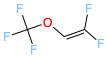

FC(F)=COC(F)(F)F
Entry
CHOF_G4
FC(F)DCOC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.857,142.504,159.527,172.337,188.816,199.299,211.869],'J/(mol*K)'), H298=(-1151.18,'kJ/mol'), S298=(390.719,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.9243,46.6146,53.0237,57.4694,61.6257,63.8759,66.4527],'J/(mol*K)'), H298=(-79.866,'kJ/mol'), S298=(53.005,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sF1sF1sO2s) + group(Cds-CdsOsH) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CsFFFO_Cs-F1sF1sF1sO2s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additi

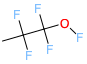

CC(F)(F)C(F)(F)OF
Entry
CHOF_G4
CC(F)(F)C(F)(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([150.012,173.688,189.961,203.33,223.032,235.572,249.562],'J/(mol*K)'), H298=(-987.483,'kJ/mol'), S298=(397.711,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([28.5258,30.0615,31.9269,33.3465,35.6312,37.4111,40.7022],'J/(mol*K)'), H298=(2.60835,'kJ/mol'), S298=(144.059,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCFFO_Cs-CsF1sF1sO2s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.7

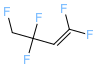

FCC(F)(F)C=C(F)F
Entry
CHOF_G4
FCC(F)(F)CDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.074,157.538,177.169,193.436,217.609,233.207,250.963],'J/(mol*K)'), H298=(-995.393,'kJ/mol'), S298=(358.035,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.2346,-0.636123,0.0552886,0.275793,0.299765,0.514653,1.37234],'J/(mol*K)'), H298=(19.5573,'kJ/mol'), S298=(0.811252,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sHH) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Td

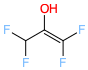

OC(=C(F)F)C(F)F
Entry
CHOF_G4
OC(DC(F)F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.863,145.188,157.928,168.503,184.279,194.554,206.681],'J/(mol*K)'), H298=(-912.967,'kJ/mol'), S298=(376.1,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.1966,45.8113,48.7389,51.7048,56.3356,59.3036,62.7889],'J/(mol*K)'), H298=(-118.301,'kJ/mol'), S298=(61.0562,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.6206,49.379,53.6074,55.3252,57.7246,58.9469,60.7434],'J/(mol*K)'), H298=(-175.422,'kJ/mol'), S298=(54.7531,'J

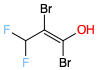

OC(Br)=C(Br)C(F)F
Entry
CHOFBr_G4
OC(Br)DC(Br)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.614,153.746,167.781,178.158,192.144,201.071,211.508],'J/(mol*K)'), H298=(-496.047,'kJ/mol'), S298=(421.318,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.1536,101.622,108.815,113.697,120.177,124.29,129.21],'J/(mol*K)'), H298=(-66.4073,'kJ/mol'), S298=(255.192,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cds(Br)=Cds(Br)) + group(CdBrCO) + longDistanceInteraction_noncyclic(Cds(Br)=Cds(Br))""")

missing
['CsCFFH_Cs-CdF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.6948,101.878,108.915,113.521,119.984,123.89,128.118],'J/(mol*K)'), H2

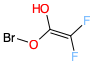

OC(OBr)=C(F)F
Entry
CHOFBr_G4
OC(OBr)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.439,127.579,135.506,141.973,152.019,158.743,166.669],'J/(mol*K)'), H298=(-491.745,'kJ/mol'), S298=(390.559,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([75.2878,81.7844,85.8931,89.1764,94.2559,97.6721,101.326],'J/(mol*K)'), H298=(-110.197,'kJ/mol'), S298=(223.632,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(O2sBrC) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['Cds-CdsOsOs_Cd-CdO2sO2s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.1531,66.2303,69.217,70.5556,71.9374,72.8765,74.7476],'J/(mol*K)'), H298=(-189,'kJ/mol'), S298=(268.614,'J/(mol*K)'), comment="""Thermo group additivity estimation

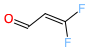

O=CC=C(F)F
Entry
CHOF_G4
ODCCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([88.0936,103.299,115.366,125.548,141.161,151.777,165.029],'J/(mol*K)'), H298=(-458.555,'kJ/mol'), S298=(315.978,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.2508,57.8637,65.5169,72.1788,83.0138,89.7036,94.9436],'J/(mol*K)'), H298=(-92.8856,'kJ/mol'), S298=(173.256,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(Cds-O2d(Cds-Cds)H) + missing(Cd-CdF1sF1s)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.2508,57.8637,65.5169,72.1788,83.0138,89.7036,94.9436],'J/(mol*K)'), H298=(-92.8856,'kJ/mol'), S298=(173.256,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(Cds-O2d(Cds-Cds)H)""")

GAE with fitted GAV
ThermoData(Tdata=([3

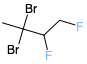

CC(Br)(Br)C(F)CF
Entry
CHOFBr_G4
CC(Br)(Br)C(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([157.021,182.213,203.275,220.952,247.823,265.892,288.514],'J/(mol*K)'), H298=(-463.82,'kJ/mol'), S298=(426.029,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.2274,103.999,113.207,120.041,129.531,134.783,139.031],'J/(mol*K)'), H298=(-195.975,'kJ/mol'), S298=(158.137,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.1669,106.107,114.101,120.407,129.522,134.24,136.65],'J/(mol*

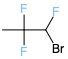

CC(F)(F)C(F)Br
Entry
CHOFBr_G4
CC(F)(F)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.383,144.14,159.637,172.709,192.764,206.47,224.256],'J/(mol*K)'), H298=(-694.024,'kJ/mol'), S298=(379.628,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([50.357,56.7021,62.5167,67.1435,73.9252,78.447,84.107],'J/(mol*K)'), H298=(-186.177,'kJ/mol'), S298=(183.983,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.7669,60.0534,65.4783,69.9172,76.2768,80.1299,83.611],'J/(mol*K)'), H298=(-201.983,'kJ/mol'), S298=(178.297,'J/(mol*K)'), c

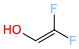

OC=C(F)F
Entry
CHOF_G4
OCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.5156,94.3473,102.226,108.768,119.065,126.437,137.076],'J/(mol*K)'), H298=(-486.237,'kJ/mol'), S298=(303.449,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(153.818,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.4543,53.5946,60.2837,64.6994,69.4157,72.9059,78.7027],'J/(mol*K)'), H298=(-144.066,'kJ/mol'), S298=(140.395,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(Cds-CdsOsH) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.474,57.3286,64.4858,68.0864,71.3644,73.549,78.7346],'J/(mol*K)'), H298=(-179.606,'kJ/mol'), S298=(132.241,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(Cds-CdsOsH)""")

GAE w

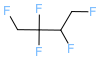

FCC(F)C(F)(F)CF
Entry
CHOF_G4
FCC(F)C(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([157.501,185.956,206.943,224.146,250.337,267.957,289.753],'J/(mol*K)'), H298=(-1099.54,'kJ/mol'), S298=(405.921,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([31.8152,39.8232,46.5669,51.1203,57.0999,61.3326,67.5743],'J/(mol*K)'), H298=(-177.305,'kJ/mol'), S298=(50.8087,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'

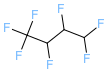

FC(F)C(F)C(F)C(F)(F)F
Entry
CHOF_G4
FC(F)C(F)C(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([169.249,197.264,218.885,235.707,259.75,275.861,296.4],'J/(mol*K)'), H298=(-1535.78,'kJ/mol'), S298=(446.387,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([68.8988,83.0089,93.808,101.798,113.26,120.751,130.611],'J/(mol*K)'), H298=(-399.802,'kJ/mol'), S298=(98.372,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F))""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.

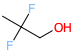

CC(F)(F)CO
Entry
CHOF_G4
CC(F)(F)CO
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.551,146.762,164.835,178.452,199.579,214.405,235.21],'J/(mol*K)'), H298=(-697.423,'kJ/mol'), S298=(336.819,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsO2sHH) + missing(Cs-CsHHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([112.904,135.735,154.901,170.939,195.286,212.451,238.218],'J/(mol*K)','+|-',[0.

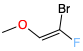

COC=C(F)Br
Entry
CHOFBr_G4
COCDC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.389,118.191,132.155,144.208,163.384,177.257,197.015],'J/(mol*K)'), H298=(-236.357,'kJ/mol'), S298=(362.878,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.8248,95.6562,105.236,112.191,120.453,125.261,130.425],'J/(mol*K)'), H298=(-221.75,'kJ/mol'), S298=(230.457,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-O2sHHH) + group(Cds-CdsOsH) + group(CdBrCF) + longDistanceInteraction_noncyclic(Cd(Val7)2=CdOs)""")

missing
['Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([83.8358,99.8303,110.344,116.576,123.406,126.881,131.387],'J/(mol*K)'), H298=(-244.613,'kJ/mol'), S298=(223.306,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + g

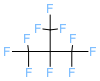

FC(F)(F)C(F)(C(F)(F)F)C(F)(F)F
Entry
CHOF_G4
FC(F)(F)C(F)(C(F)(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([193.562,226.722,251.716,270.185,293.152,304.915,316.93],'J/(mol*K)'), H298=(-2191.98,'kJ/mol'), S298=(451.118,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(324.264,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.4859,42.6154,48.9216,52.7524,56.0939,57.6247,60.0297],'J/(mol*K)'), H298=(-100.601,'kJ/mol'), S298=(-48.6865,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanc

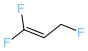

FCC=C(F)F
Entry
CHOF_G4
FCCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.1794,107.009,121.235,132.854,150.346,162.943,180.73],'J/(mol*K)'), H298=(-552.254,'kJ/mol'), S298=(332.912,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(203.705,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['CsCFHH_Cs-CdF1sHH', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.7816,108.128,121.78,133.459,151.496,164.206,181.371],'J/(mol*K)','+|-',[0.80861,0.845269,0.792502,0.735864,0.637998,0.5665

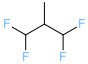

CC(C(F)F)C(F)F
Entry
CHOF_G4
CC(C(F)F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([144.422,169.396,190.451,208.333,236.095,255.458,281.654],'J/(mol*K)'), H298=(-956.145,'kJ/mol'), S298=(388.348,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sH)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH)"""

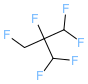

FCC(F)(C(F)F)C(F)F
Entry
CHOF_G4
FCC(F)(C(F)F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([169.211,202.034,223.393,240.287,264.904,280.212,296.145],'J/(mol*K)'), H298=(-1306.34,'kJ/mol'), S298=(419.853,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([31.3506,37.8995,42.8168,45.8021,49.2277,51.0722,52.7851],'J/(mol*K)'), H298=(-179.86,'kJ/mol'), S298=(-33.5305,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500

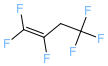

FC(F)=C(F)CC(F)(F)F
Entry
CHOF_G4
FC(F)DC(F)CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([143.029,168.904,188.795,203.65,224.189,238.032,255.078],'J/(mol*K)'), H298=(-1212.7,'kJ/mol'), S298=(415.698,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.5175,28.6161,35.0872,40.2411,47.1253,52.1888,59.9529],'J/(mol*K)'), H298=(25.5692,'kJ/mol'), S298=(44.468,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cd-CdCsF1s) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'

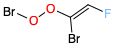

FC=C(Br)OOBr
Entry
CHOFBr_G4
FCDC(Br)OOBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.886,139.532,147.17,153.205,161.414,165.843,168.866],'J/(mol*K)'), H298=(-36.6657,'kJ/mol'), S298=(400.458,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([88.0513,93.0895,95.8417,98.6396,103.37,104.895,105.336],'J/(mol*K)'), H298=(153.239,'kJ/mol'), S298=(281.056,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-Cd)) + group(O2sBrO) + group(CdBrCO) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7))""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.4367,91.7465,94.9806,97.9892,103.118,104.89,106.125],'J/(mol*K)'), H298=(138.8,'kJ/mol'), S298=(281.279,'J/(mol*K)'), comment="""Thermo 

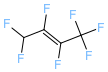

FC(=C(F)C(F)(F)F)C(F)F
Entry
CHOF_G4
FC(DC(F)C(F)(F)F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.928,177.646,195.862,210.128,230.803,244.132,258.776],'J/(mol*K)'), H298=(-1376.82,'kJ/mol'), S298=(435.349,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.95966,-1.01728,-0.233964,0.176216,0.458509,0.853058,2.5243],'J/(mol*K)'), H298=(73.5712,'kJ/mol'), S298=(5.01503,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cds(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cs-CdF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'CsCFFH_Cs-CdF1sF1sH', 'CdCsCdF_Cd-CdCs

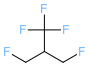

FCC(CF)C(F)(F)F
Entry
CHOF_G4
FCC(CF)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([152.472,179.125,200.147,217.855,244.954,263.378,286.901],'J/(mol*K)'), H298=(-1149.72,'kJ/mol'), S298=(400.517,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCs

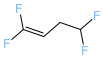

FC(F)=CCC(F)F
Entry
CHOF_G4
FC(F)DCCC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.648,147.546,166.296,182.173,206.665,223.517,245.329],'J/(mol*K)'), H298=(-807.691,'kJ/mol'), S298=(388.884,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CsF1sF1sH) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-

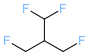

FCC(CF)C(F)F
Entry
CHOF_G4
FCC(CF)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([145.544,172.408,193.711,211.725,239.529,258.702,283.82],'J/(mol*K)'), H298=(-909.417,'kJ/mol'), S298=(389.84,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sH)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH)""")

GAE 

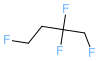

FCCC(F)(F)CF
Entry
CHOF_G4
FCCC(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([149.674,180.345,201.326,218.339,244.299,261.909,284.655],'J/(mol*K)'), H298=(-922.08,'kJ/mol'), S298=(383.266,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.2346,-0.636123,0.0552886,0.275793,0.299765,0.514653,1.37234],'J/(mol*K)'), H298=(19.5573,'kJ/mol'), S298=(0.811252,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([

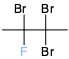

CC(F)(Br)C(C)(Br)Br
Entry
CHOFBr_G4
CC(F)(Br)C(C)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([165.551,188.124,207.271,223.501,248.607,265.996,289.061],'J/(mol*K)'), H298=(-270.396,'kJ/mol'), S298=(441.575,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.567,122.306,129.222,134.328,141.106,144.004,143.059],'J/(mol*K)'), H298=(-179.961,'kJ/mol'), S298=(198.105,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCF) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + group(CsBrBrCsCs) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([113.977,125.658,132.184,137.101,143.457,145.687,142.563],'J/(mol*K)'), H298=(-195.767,'kJ/mol'), S29

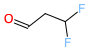

O=CCC(F)F
Entry
CHOF_G4
ODCCC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.6006,114.335,129.519,142.578,163.249,178.059,198.587],'J/(mol*K)'), H298=(-589.917,'kJ/mol'), S298=(349.246,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.91,30.8,34.98,38.91,45.56,50.73,58.93],'J/(mol*K)'), H298=(-21.5,'kJ/mol'), S298=(40.32,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH) + missing(Cs-CsF1sF1sH) + missing(CO-CsO2dH)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'Cds-OdCsH_CO-CsO2dH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.91,30.8,34.98,38.91,45.56,50.73,58.93],'J/(mol*K)'), H298=(-21.5,'kJ/mol'), S298=(40.32,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), 

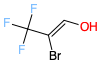

OC=C(Br)C(F)(F)F
Entry
CHOFBr_G4
OCDC(Br)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.214,147.155,163.197,174.556,191.038,201.44,212.173],'J/(mol*K)'), H298=(-779.703,'kJ/mol'), S298=(378.843,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.8698,89.5005,98.9716,105.49,113.976,119.271,126.076],'J/(mol*K)'), H298=(-95.7617,'kJ/mol'), S298=(209.523,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cds(Val7)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cd(Br)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.7458,93.5466,102.999,108.375,114.567,118.322,124.84],'J/(mol*K)'), H298=(-136.309,'kJ/mol'), S298=(204.247,'J/(mol*K)')

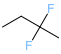

CCC(C)(F)F
Entry
CHOF_G4
CCC(C)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.817,145.37,166.856,185.579,215.881,238.39,271.963],'J/(mol*K)'), H298=(-579.648,'kJ/mol'), S298=(321.596,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.576,144.179,167.771,187.847,219.047,241.703,276.324],'J/(mol*K)','+|-',[0

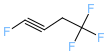

FC#CCC(F)(F)F
Entry
CHOF_G4
FC#CCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.927,136.849,151.527,163.691,182.097,194.354,209.223],'J/(mol*K)'), H298=(-602.492,'kJ/mol'), S298=(361.821,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([20.7108,27.447,33.1791,37.9907,45.4382,51.003,59.4128],'J/(mol*K)'), H298=(-19.7903,'kJ/mol'), S298=(43.0952,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CtCsHH) + missing(Cs-CsF1sF1sF1s) + missing(Ct-CsCt) + missing(Ct-CtF1s)""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'Ct-CtCs_Ct-CsCt', 'CtCF_Ct-CtF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([20.7108,27.447,33.1791,37.9907,45.4382,51.003,59.4128],'J/(mol*K)'), H298=(-19.7903,'kJ/mol'), S298=(43.0952,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CtCsHH)""")

GAE with fi

OC=CF
Entry
CHOF_G4
OCDCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([68.0008,82.521,94.7381,104.197,117.483,125.984,135.85],'J/(mol*K)'), H298=(-303.591,'kJ/mol'), S298=(278.013,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(153.818,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.8831,53.5527,60.4013,64.7513,69.4831,72.7877,78.0956],'J/(mol*K)'), H298=(-152.838,'kJ/mol'), S298=(138.491,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.474,57.3286,64.4858,68.0864,71.3644,73.549,78.7346],'J/(mol*K)'), H298=(-179.606,'kJ/mol'), S298=(132.241,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(Cds-CdsOsH)""")

GAE with fitted GA

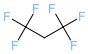

FC(F)(F)CC(F)(F)F
Entry
CHOF_G4
FC(F)(F)CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.652,152.749,170.244,183.41,203.146,216.168,231.351],'J/(mol*K)'), H298=(-1405.89,'kJ/mol'), S298=(375.603,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsF1sF1sF1s) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([130.22,153.388,170.895,184.456,203.769,216.422,231.296],'J/(mol*K)','+|-',[0.592029,0.61886

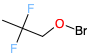

CC(F)(F)COBr
Entry
CHOFBr_G4
CC(F)(F)COBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.588,147.413,165.131,180.144,203.355,219.421,240.752],'J/(mol*K)'), H298=(-533.09,'kJ/mol'), S298=(393.005,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.5531,35.9303,36.697,37.4056,38.6474,39.3265,39.7776],'J/(mol*K)'), H298=(-0.900338,'kJ/mol'), S298=(162.314,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsO2sHH) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.5531,35.9303,36.697,37.4056,38.6474,39.3265,39.7776],'J/(mol*K)'), H298=(-0.900338,'kJ/mol'), S298=(162.314,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC)""")

GAE 

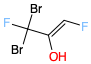

OC(=CF)C(F)(Br)Br
Entry
CHOFBr_G4
OC(DCF)C(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([144.736,160.798,171.626,180.445,193.164,200.97,209.246],'J/(mol*K)'), H298=(-456.991,'kJ/mol'), S298=(408.666,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.909,121.221,128.503,134.424,142.652,147.634,151.133],'J/(mol*K)'), H298=(-289.078,'kJ/mol'), S298=(280.742,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsBrBrCF) + longDistanceInteraction_noncyclic(Cs(Val7)3-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.721,124.809,132.62,137.071,143.328,146.635,148.437],'J/(mol*K)'), H298=(-345.451,'kJ/mol'), S298=(275.303,'J/(mol*K)'), comment="""T

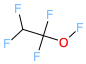

FOC(F)(F)C(F)F
Entry
CHOF_G4
FOC(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.568,135.809,148.969,158.342,171.6,180.207,189.71],'J/(mol*K)'), H298=(-928.274,'kJ/mol'), S298=(376.96,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([28.5258,30.0615,31.9269,33.3465,35.6312,37.4111,40.7022],'J/(mol*K)'), H298=(2.60835,'kJ/mol'), S298=(144.059,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.7654,'kJ/mol'), S298=(140.849,'J/(mol*K)'), comment="

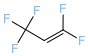

FC(F)=CC(F)(F)F
Entry
CHOF_G4
FC(F)DCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.317,124.109,139.808,151.549,167.27,177.728,190.361],'J/(mol*K)'), H298=(-1008.12,'kJ/mol'), S298=(359.073,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(203.705,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.23877,-2.68744,-1.7257,-1.09083,-0.895292,-0.908895,-0.267651],'J/(mol*K)'), H298=(8.20813,'kJ/mol'), S298=(-2.52345,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)2) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'

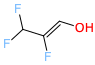

OC=C(F)C(F)F
Entry
CHOF_G4
OCDC(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.89,130.91,148.216,161.046,178.929,190.998,205.753],'J/(mol*K)'), H298=(-733.999,'kJ/mol'), S298=(355.359,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.8483,53.9002,60.772,65.0507,69.7889,73.2235,79.7133],'J/(mol*K)'), H298=(-136.245,'kJ/mol'), S298=(138.205,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cd(F)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.474,57.3286,64.4858,68.0864,71.3644,73.549,78.7346],'J/(mol*K)'), H298=(-179.606,'kJ/mol'), S298=(132.241,'J/(mol*K)

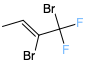

CC=C(Br)C(F)(F)Br
Entry
CHOFBr_G4
CCDC(Br)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.616,159.225,176.438,190.5,212.089,227.13,246.997],'J/(mol*K)'), H298=(-366.555,'kJ/mol'), S298=(428.578,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.9501,106.712,113.908,119.362,127.266,131.589,134.162],'J/(mol*K)'), H298=(-354.713,'kJ/mol'), S298=(273.383,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cds(Val7)) + missing(Cd-CdCsH) + group(CdBrCsCd)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdH)CdHHH', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.7519,105.148,111.945,117.257,125.232,129.695,132.163],'J/(mol*K)'), H298=(-374.298,'kJ/mol'), S298=(273.368,'J/(mol*K)'), comment="""Thermo group add

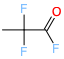

CC(F)(F)C(=O)F
Entry
CHOF_G4
CC(F)(F)C(DO)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([106.753,124.262,139.138,151.687,170.939,184.085,201.037],'J/(mol*K)'), H298=(-852.263,'kJ/mol'), S298=(348.106,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([2.31397,1.50465,1.00198,0.427023,-0.190688,-0.528904,0.276867],'J/(mol*K)'), H298=(23.8196,'kJ/mol'), S298=(0.892644,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + missing(Cs-CsHHH) + missing(CO-CsF1sO2d)""")

missing
['CsCCFF_Cs-COCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([1

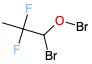

CC(F)(F)C(Br)OBr
Entry
CHOFBr_G4
CC(F)(F)C(Br)OBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([152.395,173.481,189.351,202.486,221.973,234.531,248.967],'J/(mol*K)'), H298=(-514.383,'kJ/mol'), S298=(422.84,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.3902,86.2226,92.6721,97.3408,103.492,106.727,108.971],'J/(mol*K)'), H298=(-13.866,'kJ/mol'), S298=(227.336,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + group(CsBrCHO) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.0855,87.6939,93.6873,98.2029,104.158,107.065,108.068],'J/(mol*K)'), H298=(-23.6335,'kJ/mol'), S298=(224.819,'J/(mol*K)'), comment="""Thermo group additivity e

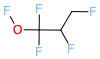

FCC(F)C(F)(F)OF
Entry
CHOF_G4
FCC(F)C(F)(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([143.073,164.874,183.043,198.052,220.219,234.347,249.862],'J/(mol*K)'), H298=(-934.465,'kJ/mol'), S298=(411.448,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.0331,73.3208,80.5255,85.955,94.013,99.2799,105.817],'J/(mol*K)'), H298=(-225.627,'kJ/mol'), S298=(190.846,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F))""")

missing
['CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([66.5119,74.5931,80.3492,85.1833,93.0395,97.8835,102.967],'J/(mol*K)'),

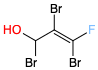

OC(Br)C(Br)=C(F)Br
Entry
CHOFBr_G4
OC(Br)C(Br)DC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([145.397,163.655,175.464,184.75,198.097,206.151,213.68],'J/(mol*K)'), H298=(-248.723,'kJ/mol'), S298=(439.124,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([122.62,138.767,149.911,158.176,169.647,175.831,180.277],'J/(mol*K)'), H298=(-85.4527,'kJ/mol'), S298=(310.771,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(CsBrCHO) + longDistanceInteraction_noncyclic(Cs(Br)-Cds(Br)) + group(CdBrCsCd) + group(CdBrCF) + longDistanceInteraction_noncyclic(Cds(Val7)2=Cds(Val7))""")

missing
['O2s-CsH_O2s-CsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([121.696,137.463,148.622,156.805,168.544,174.873,179.298],'J/(mol*K)'), H298=(-108.643,'kJ/mol'), S298=(312.966,'J/(mol*K)'), comment="""The

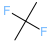

CC(C)(F)F
Entry
CHOF_G4
CC(C)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.0882,116.317,132.859,147.183,170.227,187.223,212.509],'J/(mol*K)'), H298=(-553.059,'kJ/mol'), S298=(305.945,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.6686,114.582,133.148,148.879,173.033,190.51,217.35],'J/(mol*K)','+|-',[0.331473,0.346501,0.32487,0.301653,0.261534,0.2

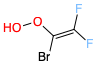

OOC(Br)=C(F)F
Entry
CHOFBr_G4
OOC(Br)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.536,128.464,137.262,144.422,154.714,160.946,166.986],'J/(mol*K)'), H298=(-367.617,'kJ/mol'), S298=(381.871,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([50.2856,54.0405,56.1832,58.8997,63.8991,66.2063,66.914],'J/(mol*K)'), H298=(76.2042,'kJ/mol'), S298=(119.16,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-Cd)) + missing(O2s-O2sH) + group(CdBrCO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(Val7)2=Cds(Val7))""")

missing
['O2s-OsH_O2s-O2sH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([47.467,51.5525,54.408,57.4467,63.2822,66.0269,67.5026],'J/(mol*K)'), H298=(58.9028,'kJ/mol'), S298=(120.572,'J/(mol*K)'), comment="""Thermo group additivity estimati

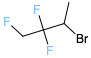

CC(Br)C(F)(F)CF
Entry
CHOFBr_G4
CC(Br)C(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([149.178,177.352,198.879,216.418,243.518,262.211,286.491],'J/(mol*K)'), H298=(-712.02,'kJ/mol'), S298=(409.157,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.6843,45.5735,51.2188,55.2002,60.6328,64.0137,68.3516],'J/(mol*K)'), H298=(13.2622,'kJ/mol'), S298=(71.5539,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCsCsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.6143,47.6809,52.1787,55.7865,60.9985,63.8374,66.0762],'J/(mol*K)'), H298=(-16.0

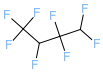

FC(F)C(F)(F)C(F)C(F)(F)F
Entry
CHOF_G4
FC(F)C(F)(F)C(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([180.2,211.426,234.736,251.696,273.542,287.518,303.644],'J/(mol*K)'), H298=(-1738.62,'kJ/mol'), S298=(452.516,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([31.6357,38.9398,45.8385,50.2527,55.7101,60.0201,67.8046],'J/(mol*K)'), H298=(-140.014,'kJ/mol'), S298=(49.9787,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + group(CsCsCsFH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF

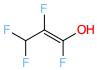

OC(F)=C(F)C(F)F
Entry
CHOF_G4
OC(F)DC(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([131.857,149.408,160.967,170.558,184.941,194.422,206.106],'J/(mol*K)'), H298=(-919.344,'kJ/mol'), S298=(373.805,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.8798,62.1502,67.2596,70.5207,74.8254,77.9172,82.3654],'J/(mol*K)'), H298=(-321.279,'kJ/mol'), S298=(161.181,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([51.7175,61.0948,66.4826,69.909,74.3878,77.4615,81.2542],'J/(m

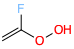

C=C(F)OO
Entry
CHOF_G4
CDC(F)OO
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.3314,106.729,115.704,123.331,135.219,143.591,155.325],'J/(mol*K)'), H298=(-237.689,'kJ/mol'), S298=(316.322,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.7615,46.9869,50.4894,54.1226,60.8881,64.3713,66.744],'J/(mol*K)'), H298=(-168.095,'kJ/mol'), S298=(95.8964,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-Cd)) + missing(O2s-O2sH) + group(CdCFO) + missing(Cd-CdHH)""")

missing
['O2s-OsH_O2s-O2sH', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.7615,46.9869,50.4894,54.1226,60.8881,64.3713,66.744],'J/(mol*K)'), H298=(-168.095,'kJ/mol'), S298=(95.8964,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-Cd)) + group(CdCFO)""")

GAE with fitted GAV
Ther

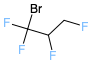

FCC(F)C(F)(F)Br
Entry
CHOFBr_G4
FCC(F)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.741,152.821,168.589,181.303,200.519,213.594,229.899],'J/(mol*K)'), H298=(-848.26,'kJ/mol'), S298=(403.88,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.6247,108.853,119.014,126.846,138.058,144.977,152.046],'J/(mol*K)'), H298=(-621.758,'kJ/mol'), S298=(254.175,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.0087,110.662,119.766,127.042,137.856,144.344,149.409],'J/(mol*K)'), H298=(-648.346,'kJ/mol'), S298=(250.594

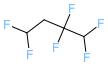

FC(F)CC(F)(F)C(F)F
Entry
CHOF_G4
FC(F)CC(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([163.055,188.939,209.419,226.145,251.709,269.199,291.447],'J/(mol*K)'), H298=(-1353.4,'kJ/mol'), S298=(437.618,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.45752,-2.80002,-2.08694,-1.76392,-1.58155,-1.05079,1.08663],'J/(mol*K)'), H298=(31.3737,'kJ/mol'), S298=(3.21073,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ

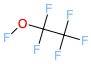

FOC(F)(F)C(F)(F)F
Entry
CHOF_G4
FOC(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.415,149.882,160.986,169.826,182.11,189.015,194.089],'J/(mol*K)'), H298=(-1157.26,'kJ/mol'), S298=(379.829,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.031,31.9213,33.5723,34.9372,37.1243,38.616,41.1344],'J/(mol*K)'), H298=(13.6244,'kJ/mol'), S298=(142.081,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.7654,'kJ/mol'), S298=(140.849,'J/(mol*K)'), comment="""Thermo group additivity estimation: gr

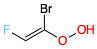

OOC(Br)=CF
Entry
CHOFBr_G4
OOC(Br)DCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.599,124.327,132.45,139.025,148.665,154.778,161.819],'J/(mol*K)'), H298=(-181.416,'kJ/mol'), S298=(359.986,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.0816,52.8955,55.2691,58.0971,63.5343,66.0321,66.7139],'J/(mol*K)'), H298=(73.3423,'kJ/mol'), S298=(120.349,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-Cd)) + missing(O2s-O2sH) + group(CdBrCO) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7))""")

missing
['O2s-OsH_O2s-O2sH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([47.467,51.5525,54.408,57.4467,63.2822,66.0269,67.5026],'J/(mol*K)'), H298=(58.9028,'kJ/mol'), S298=(120.572,'J/(mol*K)

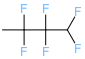

CC(F)(F)C(F)(F)C(F)F
Entry
CHOF_G4
CC(F)(F)C(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([161.413,188.461,209.814,226.895,252.299,269.711,292.082],'J/(mol*K)'), H298=(-1354.45,'kJ/mol'), S298=(426.897,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-4.91505,-5.60005,-4.17387,-3.52783,-3.1631,-2.10159,2.17325],'J/(mol*K)'), H298=(83.6674,'kJ/mol'), S298=(6.42145,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2)""")

missing
['CsCsCsFF_Cs-CsCsF1

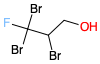

OCC(Br)C(F)(Br)Br
Entry
CHOFBr_G4
OCC(Br)C(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([161.28,179.351,193.616,205.407,222.865,234.093,247.076],'J/(mol*K)'), H298=(-362.819,'kJ/mol'), S298=(455.024,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.575,121.938,130.318,136.841,146.131,151.277,154.929],'J/(mol*K)'), H298=(-173.835,'kJ/mol'), S298=(292.402,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(CsBrCsCsH) + missing(Cs-CsO2sHH) + group(CsBrBrCF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['O2s-CsH_O2s-CsH', 'Cs-CsOsHH_Cs-CsO2sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.715,123.11,131.191,137.533,146.602,151.525,153.77],'J/(mol*K)'), H298=(-186.092,'kJ/mol'), S298=(288.775,'J/(mol*K)'), comment="""Thermo group additivity esti

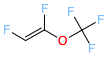

FC=C(F)OC(F)(F)F
Entry
CHOF_G4
FCDC(F)OC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.697,144.642,160.27,172.407,189.007,199.035,211.385],'J/(mol*K)'), H298=(-1139.13,'kJ/mol'), S298=(392.216,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.8643,52.9443,58.744,62.6774,66.7077,68.5425,69.1322],'J/(mol*K)'), H298=(-268.103,'kJ/mol'), S298=(76.1518,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CsFFFO_Cs-F1sF1sF1sO2s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.1875,54.1148,59.2226,62.679,66.5978,68.4315,69.0042],

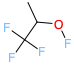

CC(OF)C(F)(F)F
Entry
CHOF_G4
CC(OF)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.855,155.215,172.583,187.185,209.494,224.611,243.743],'J/(mol*K)'), H298=(-795.074,'kJ/mol'), S298=(382.527,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([54.2206,63.7016,69.6629,74.4202,80.9632,84.1925,87.5704],'J/(mol*K)'), H298=(-41.7178,'kJ/mol'), S298=(83.6719,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(Cs-CsCsOsH) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-CsOs)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.9733,61.8915,68.2339,72.8904,79.1728,82.7319,86.7255],'J/(mol*K)'), H298=(-53.8654,'kJ/mol'), S298=(88.7985,'J/(mol*K)'), comment="""Thermo group additivity estimatio

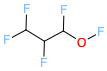

FOC(F)C(F)C(F)F
Entry
CHOF_G4
FOC(F)C(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([142.274,167.207,187.306,203.329,225.83,239.379,254.729],'J/(mol*K)'), H298=(-932.179,'kJ/mol'), S298=(405.203,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.4618,116.798,130.377,140.459,154.517,163.117,172.096],'J/(mol*K)'), H298=(-484.288,'kJ/mol'), S298=(233.145,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCFHO) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([100.941,118.071,130.201,139.687,153.543,161.721,169.246],'J/(mol*K)'), H298=(-518.178,'kJ/mol'), S29

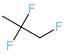

CC(F)(F)[C]F
Entry
CHOF_G4
CC(F)(F)[C]F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.5204,113.923,126.129,136.48,152.507,163.633,178.504],'J/(mol*K)'), H298=(-338.627,'kJ/mol'), S298=(333.857,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-C2sCsF1sF1s) + missing(Cs-CsHHH) + missing(C2s-CsF1s)""")

missing
['CsCCFF_Cs-C2sCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CJ2_singlet-FCs_C2s-CsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.161,118.856,129.091,136.295,146.234,154.791,170.306],'J/(mol*K)','+|-',[2.61567,2.73425,2.56356,2.38035

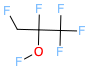

FCC(F)(OF)C(F)(F)F
Entry
CHOF_G4
FCC(F)(OF)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([159.05,183.806,201.12,215.137,235.318,247.516,258.822],'J/(mol*K)'), H298=(-1154.59,'kJ/mol'), S298=(408.321,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.0595,33.0433,35.096,36.4865,38.5199,39.8552,42.1513],'J/(mol*K)'), H298=(13.3779,'kJ/mol'), S298=(139.946,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F))""")

missing
['CsCCFO_Cs-CsCsF1sO2s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37

FCCCCBr
Entry
CHOFBr_G4
FCCCCBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.923,157.548,178.671,196.794,225.424,245.972,275.328],'J/(mol*K)'), H298=(-291.329,'kJ/mol'), S298=(382.679,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.4538,49.98,56.01,61.0504,68.6377,73.7924,80.3031],'J/(mol*K)'), H298=(-23.649,'kJ/mol'), S298=(158.984,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + missing(Cs-CsF1sHH) + group(CsBrCsHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.4538,49.98,56.01,61.0504,68.6377,73.7924,80.3031],'J/(mol*K)'), H298=(-23.649,'kJ/mol'), S298=(158.984,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCsHH)""")

GAE with fitted GAV
Ther

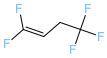

FC(F)=CCC(F)(F)F
Entry
CHOF_G4
FC(F)DCCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.696,155.919,176.998,193.198,215.699,231.078,250.859],'J/(mol*K)'), H298=(-1056.17,'kJ/mol'), S298=(395.614,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CsF1sF1sF1s) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: grou

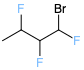

CC(F)C(F)C(F)Br
Entry
CHOFBr_G4
CC(F)C(F)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([149.921,179.966,202.284,219.916,246.867,265.129,287.945],'J/(mol*K)'), H298=(-681.942,'kJ/mol'), S298=(407.939,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.885,141.409,157.255,169.697,187.938,199.516,212.695],'J/(mol*K)'), H298=(-639.386,'kJ/mol'), S298=(279.231,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsHHH) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.824,143.517,158.149,170.063,187.93,198.973,210.314],'J/(mol*K)'), H298=(-663.486,'kJ/mol'

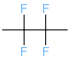

CC(F)(F)C(C)(F)F
Entry
CHOF_G4
CC(F)(F)C(C)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.969,174.519,194.853,212.054,238.746,257.361,282.614],'J/(mol*K)'), H298=(-994.31,'kJ/mol'), S298=(370.926,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.45752,-2.80002,-2.08694,-1.76392,-1.58155,-1.05079,1.08663],'J/(mol*K)'), H298=(31.3737,'kJ/mol'), S298=(3.21073,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S29

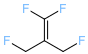

FCC(CF)=C(F)F
Entry
CHOF_G4
FCC(CF)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.619,154.366,170.995,185.151,207.22,222.723,243.999],'J/(mol*K)'), H298=(-762.06,'kJ/mol'), S298=(375.869,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + missing(Cs-CdF1sHH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CsCFHH_Cs-CdF1sHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-CdsCsCs)""")

GA

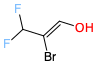

OC=C(Br)C(F)F
Entry
CHOFBr_G4
OCDC(Br)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.87,134.374,150.44,163.515,182.358,193.984,207.742],'J/(mol*K)'), H298=(-541.286,'kJ/mol'), S298=(373.939,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([72.5315,86.5464,96.1862,102.858,111.753,117.61,125.769],'J/(mol*K)'), H298=(-100.374,'kJ/mol'), S298=(211.39,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cd(Br)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCFFH_Cs-CdF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.7458,93.5466,102.999,108.375,114.567,118.322,124.84],'J/(mol*K)'), H298=(-136.309,'kJ/mol'), S298=(204.247,'J/(mol*K)'), comment="""

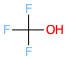

OC(F)(F)F
Entry
CHOF_G4
OC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([67.5773,79.7323,88.8826,95.4652,105,111.182,118.361],'J/(mol*K)'), H298=(-910.234,'kJ/mol'), S298=(290.998,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(128.874,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-F1sF1sF1sO2s)""")

missing
['O2s-CsH_O2s-CsH', 'CsFFFO_Cs-F1sF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([70.0524,80.8018,88.54,94.7362,103.878,109.744,118.278],'J/(mol*K)','+|-',[0.680999,0.711872,0.667433,0.619733,0.537312,0.477132,0.922215]), H298=(-883.622,'kJ/mol','+|

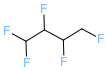

FCC(F)C(F)C(F)F
Entry
CHOF_G4
FCC(F)C(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([152.388,181.844,205.916,225.139,251.826,268.603,291.424],'J/(mol*K)'), H298=(-1095.32,'kJ/mol'), S298=(409.63,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([67.3343,81.5548,92.9679,101.413,113.301,121.121,131.032],'J/(mol*K)'), H298=(-413.281,'kJ/mol'), S298=(99.1836,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,

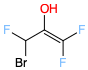

OC(=C(F)F)C(F)Br
Entry
CHOFBr_G4
OC(DC(F)F)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.05,148.707,163.718,175.148,190.647,200.241,211.439],'J/(mol*K)'), H298=(-676.351,'kJ/mol'), S298=(403.041,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.2304,102.041,112.072,120.37,131.933,139.258,146.928],'J/(mol*K)'), H298=(-311.286,'kJ/mol'), S298=(246.104,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.3875,109.432,119.086,125.242,134.001,139.077,144.354],'J/(mol*K)'), H298=(-377.406,'kJ/mol'), S298=(233.05,'J/(mol*K)'), comment="""

OC=CCF
Entry
CHOF_G4
OCDCCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.1736,111.751,126.304,138.824,158.684,173.017,193.593],'J/(mol*K)'), H298=(-332.915,'kJ/mol'), S298=(319.565,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.474,57.3286,64.4858,68.0864,71.3644,73.549,78.7346],'J/(mol*K)'), H298=(-179.606,'kJ/mol'), S298=(132.241,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sHH) + missing(Cd-CdCsH) + group(Cds-CdsOsH)""")

missing
['CsCFHH_Cs-CdF1sHH', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.474,57.3286,64.4858,68.0864,71.3644,73.549,78.7346],'J/(mol*K)'), H298=(-179.606,'kJ/mol'), S298=(132.241,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(Cds-CdsOsH)""")

GAE with fitted GA

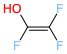

OC(F)=C(F)F
Entry
CHOF_G4
OC(F)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([87.0742,98.7368,107.452,114.723,125.666,132.897,141.615],'J/(mol*K)'), H298=(-666.592,'kJ/mol'), S298=(326.804,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(153.818,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([54.3333,62.887,67.6438,70.7577,74.5905,77.3428,80.4904],'J/(mol*K)'), H298=(-323.142,'kJ/mol'), S298=(161.244,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CdCFO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([51.7175,61.0948,66.4826,69.909,74.3878,77.4615,81.2542],'J/(mol*K)'), H298=(-363.057,'kJ/mol'), S298=(159.854,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CdCFO)""")

GAE wi

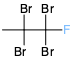

CC(Br)(Br)C(F)(Br)Br
Entry
CHOFBr_G4
CC(Br)(Br)C(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([151.567,169.278,182.795,193.893,210.511,221.359,233.862],'J/(mol*K)'), H298=(-183.215,'kJ/mol'), S298=(442.431,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.056,137.245,144.84,150.362,157.762,161.343,162.085],'J/(mol*K)'), H298=(-139.972,'kJ/mol'), S298=(331.766,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + missing(Cs-CsHHH) + group(CsBrBrCF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7)2)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.739,139.805,146.779,152.08,159.3,162.506,160.992],'J/(mol*K)'), H298=(-159.352,'kJ/mol'), S298=(326.983,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + group(C

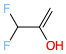

C=C(O)C(F)F
Entry
CHOF_G4
CDC(O)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.216,123.198,137.905,150.277,169.364,182.511,199.665],'J/(mol*K)'), H298=(-556.272,'kJ/mol'), S298=(336.088,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.2164,49.5454,52.9409,55.0918,58.2843,59.9467,62.8209],'J/(mol*K)'), H298=(-153.842,'kJ/mol'), S298=(52.902,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdHH)""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.6206,49.379,53.6074,55.3252,57.7246,58.9469,60.7434],'J/(mol*K)'), H298=(-175.422,'kJ/mol'), S298=(54.7531,'J/(mol*K)'), comment="""Thermo group additivity estimation: g

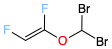

FC=C(F)OC(Br)Br
Entry
CHOFBr_G4
FCDC(F)OC(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.267,144.786,158.31,169.484,185.996,196.529,208.114],'J/(mol*K)'), H298=(-402.794,'kJ/mol'), S298=(438.964,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([103.604,117.931,128.041,135.465,145.023,149.857,152.571],'J/(mol*K)'), H298=(-263.15,'kJ/mol'), S298=(280.387,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrBrHO) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.407,117.223,127.635,135.153,144.892,149.837,153.078],'J/(mol*K)'), H298=(-288.334,'kJ/mol'), S298=(278.775,'J/(mol*K)'), comment="""Thermo g

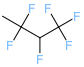

CC(F)(F)C(F)C(F)(F)F
Entry
CHOF_G4
CC(F)(F)C(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([162.557,189.225,209.68,226.786,252.637,269.837,290.858],'J/(mol*K)'), H298=(-1379.38,'kJ/mol'), S298=(415.812,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.0932,41.7399,47.9254,52.0166,57.2917,61.0709,66.718],'J/(mol*K)'), H298=(-171.388,'kJ/mol'), S298=(46.768,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCsCsFH) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.33

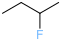

CCC(C)F
Entry
CHOF_G4
CCC(C)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([112.055,135.663,156.701,175.385,206.495,230.511,268.094],'J/(mol*K)'), H298=(-332.162,'kJ/mol'), S298=(332.216,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.0729,55.8267,59.4216,63.3516],'J/(mol*K)'), H298=(-230.751,'kJ/mol'), S298=(49.2315,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.0729,55.8267,59.4216,63.3516],'J/(mol*K)'), H298=(-230.751,'kJ/mol'), S298=(49.2315,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH)""")

GAE with fitted GAV
Th

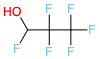

OC(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
OC(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([157.596,183.101,199.435,212.537,231.356,242.733,253.719],'J/(mol*K)'), H298=(-1510.31,'kJ/mol'), S298=(409.712,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.2418,41.9012,49.4653,54.6063,60.7148,64.5061,69.17],'J/(mol*K)'), H298=(-196.714,'kJ/mol'), S298=(44.3431,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCFHO) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.4287,43.4776,49.8515,54.5037,60.5036,63.8374,66.2787],'J/(mol*K)'), H298=(-

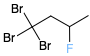

CC(F)CC(Br)(Br)Br
Entry
CHOFBr_G4
CC(F)CC(Br)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([154.296,179.397,200.669,218.561,245.865,264.343,287.733],'J/(mol*K)'), H298=(-236.089,'kJ/mol'), S298=(448.248,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.381,119.261,127.35,133.975,143.852,149.559,153.32],'J/(mol*K)'), H298=(-179.923,'kJ/mol'), S298=(291.428,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + group(CsBrBrBrCs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.381,119.261,127.35,133.975,143.852,149.559,153.32],'J/(mol*K)'), H298=(-179.923,'kJ/mol'), S298=(291.428,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + group(CsBrBrBrCs)""")

GAE w

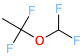

CC(F)(F)OC(F)F
Entry
CHOF_G4
CC(F)(F)OC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([131.44,156.846,174.728,189.389,211.497,226.158,244.019],'J/(mol*K)'), H298=(-1142.86,'kJ/mol'), S298=(381.417,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.7,13.4,13.58,14.54,16.71,18.29,20.17],'J/(mol*K)'), H298=(-98.6,'kJ/mol'), S298=(38.61,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsHHH) + missing(Cs-F1sF1sO2sH)""")

missing
['CsCFFO_Cs-CsF1sF1sO2s', 'Cs-CsHHH_Cs-CsHHH', 'CsFFHO_Cs-F1sF1sO2sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.7,13.4,13.58,14.54,16.71,18.29,20.17],'J/(mol*K)'), H298=(-98.6,'kJ/mol'), S298=(38.61,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs)""")

GAE with fitted GAV
ThermoData(Tdata=

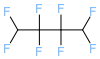

FC(F)C(F)(F)C(F)(F)C(F)F
Entry
CHOF_G4
FC(F)C(F)(F)C(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([183.249,210.622,231.142,247.067,270.213,285.061,301.186],'J/(mol*K)'), H298=(-1711.52,'kJ/mol'), S298=(463.211,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-7.37257,-8.40007,-6.26081,-5.29175,-4.74466,-3.15238,3.25988],'J/(mol*K)'), H298=(135.961,'kJ/mol'), S298=(9.63218,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-C

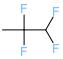

CC(F)(F)C(F)F
Entry
CHOF_G4
CC(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.797,139.825,155.358,168.541,188.983,203.208,222.327],'J/(mol*K)'), H298=(-937.591,'kJ/mol'), S298=(352.457,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.45752,-2.80002,-2.08694,-1.76392,-1.58155,-1.05079,1.08663],'J/(mol*K)'), H298=(31.3737,'kJ/mol'), S298=(3.21073,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoDat

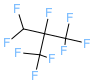

FC(F)C(F)(C(F)(F)F)C(F)(F)F
Entry
CHOF_G4
FC(F)C(F)(C(F)(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([187.428,220.082,244.285,261.652,283.162,296.284,309.999],'J/(mol*K)'), H298=(-1964.81,'kJ/mol'), S298=(456.218,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.9147,40.5785,46.8611,50.1521,52.6645,54.2547,56.6874],'J/(mol*K)'), H298=(-117.713,'kJ/mol'), S298=(-44.5153,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + longDistanceInteracti

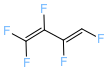

FC=C(F)C(F)=C(F)F
Entry
CHOF_G4
FCDC(F)C(F)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.454,153.187,166.413,177.275,193.178,203.169,213.931],'J/(mol*K)'), H298=(-783.873,'kJ/mol'), S298=(383.896,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.1092,70.3643,76.6413,81.3493,87.5969,90.9403,92.0011],'J/(mol*K)'), H298=(-259.135,'kJ/mol'), S298=(94.2485,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CdCCF) + longDistanceInteraction_noncyclic(Cds(F)-Cds(F)) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + group(CdCCF) + longDistanceInteraction_noncyclic(Cds(F)-Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CdCFH_Cd-CdF1sH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600

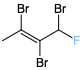

CC(Br)=C(Br)C(F)Br
Entry
CHOFBr_G4
CC(Br)DC(Br)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([143.196,162.899,179.731,193.931,215.696,230.508,249.25],'J/(mol*K)'), H298=(-122.216,'kJ/mol'), S298=(449.738,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([118.769,132.232,142.406,150.67,162.874,170.075,176.914],'J/(mol*K)'), H298=(-89.0345,'kJ/mol'), S298=(320.965,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cds(Br)=Cds(Br)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cds(Br)=Cds(Br))""")

missing
['Cs-(Cds-Cds)HHH_Cs-(Br1sCd)CdHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.311,132.489,142.506,150.494,162.681,169.675,175.822],'J/(mol*

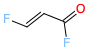

O=C(F)C=CF
Entry
CHOF_G4
ODC(F)CDCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([85.2337,100.224,113.272,124.274,140.405,150.495,164.274],'J/(mol*K)'), H298=(-518.224,'kJ/mol'), S298=(322.34,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.6959,65.2961,72.6975,78.9661,88.145,94.2629,101.95],'J/(mol*K)'), H298=(-330.455,'kJ/mol'), S298=(192.876,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COCFO) + missing(Cd-CdF1sH)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.6959,65.2961,72.6975,78.9661,88.145,94.2629,101.95],'J/(mol*K)'), H298=(-330.455,'kJ/mol'), S298=(192.876,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COCFO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'

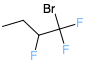

CCC(F)C(F)(F)Br
Entry
CHOFBr_G4
CCC(F)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([147.127,173.079,194.24,211.644,238.309,257.396,284.387],'J/(mol*K)'), H298=(-703.435,'kJ/mol'), S298=(416.349,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.8688,109.489,118.893,126.35,137.385,144.095,150.568],'J/(mol*K)'), H298=(-636.09,'kJ/mol'), S298=(254.221,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsHHH) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.0087,110.662,119.766,127.042,137.856,144.344,149.409],'J/(mol*K)'), H298=(-648.346,'kJ/mol'), S298=(250.594,'J/(mol*K)'), comment="""Thermo group additivity estimati

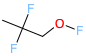

CC(F)(F)COF
Entry
CHOF_G4
CC(F)(F)COF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.073,147.813,165.381,180.271,203.306,219.249,240.292],'J/(mol*K)'), H298=(-568.696,'kJ/mol'), S298=(371.559,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.7654,'kJ/mol'), S298=(140.849,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsO2sHH) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.7654,'kJ/mol'), S298=(140.849,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF)""")

GAE with 

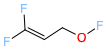

FOCC=C(F)F
Entry
CHOF_G4
FOCCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.567,126.117,141.792,154.914,174.754,187.934,203.745],'J/(mol*K)'), H298=(-403.549,'kJ/mol'), S298=(367.767,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.4054,61.5638,68.8247,74.8166,84.1573,90.6782,99.8651],'J/(mol*K)'), H298=(-57.0492,'kJ/mol'), S298=(181.852,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(Cs-(Cds-Cds)OsHH) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.4054,61.5638,68.8247,74.8166,84.1573,90.6782,99.8651],'J/(mol*K)'), H298=(-57.0492,'kJ/mol'), S298=(181.852,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(Cs-(Cds-Cds)OsHH)""")

GAE with 

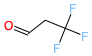

O=CCC(F)(F)F
Entry
CHOF_G4
ODCCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.503,123.902,139.726,152.267,170.889,184.075,202.001],'J/(mol*K)'), H298=(-834.281,'kJ/mol'), S298=(352.642,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([29.8091,33.9336,38.0433,41.65,47.4371,51.9602,59.2891],'J/(mol*K)'), H298=(-14.4513,'kJ/mol'), S298=(38.802,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-CO) + missing(CO-CsO2dH)""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'Cds-OdCsH_CO-CsO2dH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.91,30.8,34.98,38.91,45.56,50.73,58.93],'J/(mol*K)'), H298=(-21.5,'kJ/mol'), S298=(40.32,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH)""")



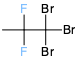

CC(F)(F)C(Br)(Br)Br
Entry
CHOFBr_G4
CC(F)(F)C(Br)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([143.558,161.281,176.129,188.452,206.817,218.732,232.471],'J/(mol*K)'), H298=(-427.354,'kJ/mol'), S298=(425.338,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([70.1696,74.9703,79.0763,82.1835,86.4876,88.9744,91.0615],'J/(mol*K)'), H298=(70.2084,'kJ/mol'), S298=(246.979,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + group(CsBrBrBrCs) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([72.8526,77.5295,81.0148,83.9018,88.0255,90.1376,89.9686],'J/(mol*K)'), H298=(50.8285,'kJ/mol'), S298=(242.197,'J/(mol*K)'), comment="""Thermo group additivity estima

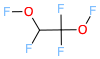

FOC(F)C(F)(F)OF
Entry
CHOF_G4
FOC(F)C(F)(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.516,158.286,173.684,184.195,198.018,206.586,214.788],'J/(mol*K)'), H298=(-762.819,'kJ/mol'), S298=(400.436,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.1607,108.565,117.935,125,135.229,141.276,146.882],'J/(mol*K)'), H298=(-296.635,'kJ/mol'), S298=(324.808,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(O2sCF) + group(CsCFHO) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCFFO_Cs-CsF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.3953,109.201,117.879,124.725,134.929,140.761,145.51],'J/(mol*K)'), H298=(-316.192,'kJ/mol'), S298=(323.996,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(O2sCF) +

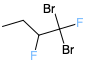

CCC(F)C(F)(Br)Br
Entry
CHOFBr_G4
CCC(F)C(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.361,177.729,198.449,215.949,242.862,261.346,285.656],'J/(mol*K)'), H298=(-454.356,'kJ/mol'), S298=(437.353,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.489,115.989,124.475,131.127,140.959,146.861,152.205],'J/(mol*K)'), H298=(-388.524,'kJ/mol'), S298=(273.408,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsHHH) + group(CsBrBrCF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.629,117.161,125.348,131.819,141.43,147.109,151.045],'J/(mol*K)'), H298=(-400.78,'kJ/mol'), S298=(269.781,'J/(mol*K)'), comment="""Thermo group additivity esti

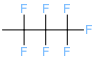

CC(F)(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
CC(F)(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([173.355,198.982,219.068,235.739,260.576,276.678,295.196],'J/(mol*K)'), H298=(-1584.41,'kJ/mol'), S298=(434.588,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.93103,-3.91383,-1.9548,-1.14928,-1.13823,-0.273656,3.54172],'J/(mol*K)'), H298=(96.2185,'kJ/mol'), S298=(2.02541,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHH

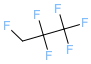

FCC(F)(F)C(F)(F)F
Entry
CHOF_G4
FCC(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.583,155.008,172.529,185.98,204.24,216.261,231.86],'J/(mol*K)'), H298=(-1324.41,'kJ/mol'), S298=(389.765,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.18691,-1.57637,-0.386261,0.10262,0.211261,0.66874,2.89122],'J/(mol*K)'), H298=(61.947,'kJ/mol'), S298=(2.04375,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV


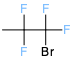

CC(F)(F)C(F)(F)Br
Entry
CHOFBr_G4
CC(F)(F)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.173,153.505,169.207,182.273,201.828,214.609,229.557],'J/(mol*K)'), H298=(-903.611,'kJ/mol'), S298=(390.665,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.797,66.371,71.4924,75.2511,80.4915,83.759,87.1498],'J/(mol*K)'), H298=(-398.215,'kJ/mol'), S298=(206.145,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.4801,68.9301,73.4309,76.9693,82.0294,84.9222,86.0569],'J/(mol*K)'), H298=(-417.595,'kJ/mol'), S298=(201.362,'J/(mol*K)'), comment="""Thermo group additivity estimation: gr

C=COCF
Entry
CHOF_G4
CDCOCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.5153,111.948,126.954,139.802,160.016,174.41,194.54],'J/(mol*K)'), H298=(-313.923,'kJ/mol'), S298=(318.867,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sO2sHH) + group(Cds-CdsOsH) + missing(Cd-CdHH)""")

missing
['CsFHHO_Cs-F1sO2sHH', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(Cds-CdsOsH)""")

GAE with fitted GAV

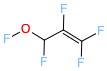

FOC(F)C(F)=C(F)F
Entry
CHOF_G4
FOC(F)C(F)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.979,152.431,167.054,178.989,196.203,206.641,216.354],'J/(mol*K)'), H298=(-756.013,'kJ/mol'), S298=(391.12,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([66.9747,77.5733,84.7521,90.3597,98.1215,102.605,106.898],'J/(mol*K)'), H298=(-237.436,'kJ/mol'), S298=(185.184,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(CsCFHO) + longDistanceInteraction_noncyclic(Cs(F)-Cds(F)) + missing(Cd-CdCsF1s) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CdCsCdF_Cd-CdCsF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.412,76.3391,83.8654,89.6141,97.7164,102.299,105.894],'J/(mol*K)'), H298=(-287.427,'kJ/mol'), S298=(183.148,'J/(mol*K)'

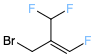

FC=C(CBr)C(F)F
Entry
CHOFBr_G4
FCDC(CBr)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([138.498,161.143,178.469,192.98,214.98,229.703,247.919],'J/(mol*K)'), H298=(-576.476,'kJ/mol'), S298=(403.428,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.3507,66.7775,74.3606,80.606,90.3702,96.9613,105.008],'J/(mol*K)'), H298=(28.1395,'kJ/mol'), S298=(112.332,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCHH) + missing(Cs-CdF1sF1sH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.3507,66.7775,74.3606,80.606,90.3702,96.9613,105.008],'J/(mol*K)'), H298=(28.1395,'kJ/mol'), S298=(112.332,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCHH) + group(Cds-CdsCsCs)""")

GAE with fi

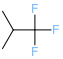

CC(C)C(F)(F)F
Entry
CHOF_G4
CC(C)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.06,153.318,175.748,194.947,225.135,246.616,276.627],'J/(mol*K)'), H298=(-800.709,'kJ/mol'), S298=(356.676,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsHHH) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH)""")

GAE

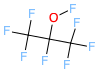

FOC(F)(C(F)(F)F)C(F)(F)F
Entry
CHOF_G4
FOC(F)(C(F)(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([173.668,204.052,223.535,236.063,253.038,262.498,268.415],'J/(mol*K)'), H298=(-1580.84,'kJ/mol'), S298=(431.589,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([31.111,34.6153,37.0871,38.6565,40.5593,41.7946,44.4957],'J/(mol*K)'), H298=(43.281,'kJ/mol'), S298=(135.465,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3)""")

missing
['CsCCFO_Cs-CsCsF1sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([3

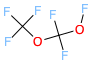

FOC(F)(F)OC(F)(F)F
Entry
CHOF_G4
FOC(F)(F)OC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.779,168.388,181.515,190.977,204.135,211.497,216.467],'J/(mol*K)'), H298=(-1357.27,'kJ/mol'), S298=(405.713,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.004,101.643,109.464,115.597,124.199,128.829,131.07],'J/(mol*K)'), H298=(-659.081,'kJ/mol'), S298=(239.646,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(O2sCF) + group(CsFFOO) + missing(Cs-F1sF1sF1sO2s)""")

missing
['CsFFFO_Cs-F1sF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.004,101.643,109.464,115.597,124.199,128.829,131.07],'J/(mol*K)'), H298=(-659.081,'kJ/mol'), S298=(239.646,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(O2sCF) + group(CsFFOO)""")

GAE with fitted

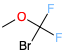

COC(F)(F)Br
Entry
CHOFBr_G4
COC(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.374,115.778,127.934,138.205,154.012,164.873,179.128],'J/(mol*K)'), H298=(-614.175,'kJ/mol'), S298=(360.191,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.0379,81.2741,85.9624,90.4491,97.7361,101.933,105.975],'J/(mol*K)'), H298=(-546.033,'kJ/mol'), S298=(242.877,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-O2sHHH) + group(CsBrFFO)""")

missing
['Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.0379,81.2741,85.9624,90.4491,97.7361,101.933,105.975],'J/(mol*K)'), H298=(-546.033,'kJ/mol'), S298=(242.877,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(CsBrFFO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,10

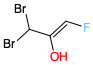

OC(=CF)C(Br)Br
Entry
CHOFBr_G4
OC(DCF)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.865,140.983,153.649,164.243,180.256,190.936,204.206],'J/(mol*K)'), H298=(-277.282,'kJ/mol'), S298=(400.736,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.9359,108.289,116.724,123.606,133.445,139.634,145.899],'J/(mol*K)'), H298=(-112.223,'kJ/mol'), S298=(265.653,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsBrBrCH) + longDistanceInteraction_noncyclic(Cs(Br)2-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.7535,112.533,121.622,127.374,135.328,140.02,144.371],'J/(mol*K)'), H298=(-155.373,'kJ/mol'), S298=(260.542,'J/(mol*K)'), comment="""Thermo g

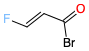

O=C(Br)C=CF
Entry
CHOFBr_G4
ODC(Br)CDCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.3162,105.195,116.933,126.775,141.705,151.682,163.838],'J/(mol*K)'), H298=(-266.062,'kJ/mol'), S298=(346.656,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.2894,72.56,78.9981,84.3145,92.1361,97.2139,102.313],'J/(mol*K)'), H298=(-88.4338,'kJ/mol'), S298=(215.611,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COBrCO) + missing(Cd-CdF1sH)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.2894,72.56,78.9981,84.3145,92.1361,97.2139,102.313],'J/(mol*K)'), H298=(-88.4338,'kJ/mol'), S298=(215.611,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COBrCO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,15

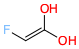

OC(O)=CF
Entry
CHOF_G4
OC(O)DCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.613,105.474,116.39,125.03,138.102,146.828,157.651],'J/(mol*K)'), H298=(-481.596,'kJ/mol'), S298=(308.798,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.7635,76.1123,81.8337,84.9727,88.9659,91.7774,95.9112],'J/(mol*K)'), H298=(-306.169,'kJ/mol'), S298=(165.713,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(O2s-(Cds-Cd)H) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['Cds-CdsOsOs_Cd-CdO2sO2s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.2,60.6,65.04,66.3,66.58,67.1,69.94],'J/(mol*K)'), H298=(-376.2,'kJ/mol'), S298=(212.6,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group

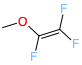

COC(F)=C(F)F
Entry
CHOF_G4
COC(F)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.504,124.821,138.823,150.768,169.441,182.588,200.497],'J/(mol*K)'), H298=(-648.024,'kJ/mol'), S298=(361.111,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([48.8033,55.907,60.3838,63.5277,66.8005,68.3128,68.2404],'J/(mol*K)'), H298=(-258.942,'kJ/mol'), S298=(73.8538,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-O2sHHH) + group(CdCFO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['Cs-OsHHH_Cs-O2sHHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.1875,54.1148,59.2226,62.679,66.5978,68.4315,69.0042],'J/(mol*K)'), H298=(-298.857,'kJ/mol'), S298=(72.4644,'J/(mol*K)'), comment="""Thermo group additivity estimation: g

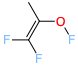

CC(OF)=C(F)F
Entry
CHOF_G4
CC(OF)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.265,128.692,143.862,156.323,174.981,187.746,205.228],'J/(mol*K)'), H298=(-408.469,'kJ/mol'), S298=(360.096,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.9841,48.2065,50.8992,53.8986,59.6986,63.2157,65.3571],'J/(mol*K)'), H298=(19.4527,'kJ/mol'), S298=(97.4559,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CdHHH) + group(Cds-CdsCsOs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdO2s)CdHHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.0039,51.9406,55.1012,57.2856,61.6473,63.8588,65.389],'J/(mol*K)'), H298=(-16.0879,'kJ/mol'), S298=(89.3016,'J/(mol*K)'), comment="""Thermo group additivity estimat

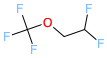

FC(F)COC(F)(F)F
Entry
CHOF_G4
FC(F)COC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([130.827,154.223,173.653,189.658,213.345,228.761,247.803],'J/(mol*K)'), H298=(-1317.37,'kJ/mol'), S298=(414.301,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.7,13.4,13.58,14.54,16.71,18.29,20.17],'J/(mol*K)'), H298=(-98.6,'kJ/mol'), S298=(38.61,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sF1sH) + missing(Cs-F1sF1sF1sO2s)""")

missing
['Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsFFFO_Cs-F1sF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.7,13.4,13.58,14.54,16.71,18.29,20.17],'J/(mol*K)'), H298=(-98.6,'kJ/mol'), S298=(38.61,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs)""")

GAE with fitted GAV
ThermoDa

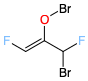

FC=C(OBr)C(F)Br
Entry
CHOFBr_G4
FCDC(OBr)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.856,149.41,161.875,172.214,187.634,197.637,209.068],'J/(mol*K)'), H298=(-308.957,'kJ/mol'), S298=(433.723,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.6124,107.629,116.367,124.678,137.358,144.917,151.128],'J/(mol*K)'), H298=(-132.859,'kJ/mol'), S298=(300.214,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.341,115.063,123.263,129.498,139.359,144.853,149.162],'J/(mol*K)'), H298=(-190.206,'kJ/mol'), S298=(289.064,'J/(mol*K)'), comment="""Thermo group

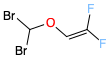

FC(F)=COC(Br)Br
Entry
CHOFBr_G4
FC(F)DCOC(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([130.28,150.055,165.328,177.168,193.705,203.847,213.641],'J/(mol*K)'), H298=(-418.607,'kJ/mol'), S298=(424.846,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.1438,109.723,121.436,129.943,139.92,145.282,150.526],'J/(mol*K)'), H298=(-69.3432,'kJ/mol'), S298=(259.316,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrBrHO) + group(Cds-CdsOsH) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.1636,113.457,125.638,133.33,141.868,145.925,150.558],'J/(mol*K)'), H298=(-104.884,'kJ/mol'), S298=(251.161,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-

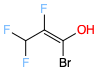

OC(Br)=C(F)C(F)F
Entry
CHOFBr_G4
OC(Br)DC(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.68,154.982,165.856,174.815,188.11,196.725,207.085],'J/(mol*K)'), H298=(-695.836,'kJ/mol'), S298=(394.555,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.0028,67.3509,71.633,74.1829,77.3398,79.5582,82.8418],'J/(mol*K)'), H298=(-105.026,'kJ/mol'), S298=(184.021,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7)) + group(CdBrCO) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7))""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.423,65.6604,70.4012,73.2331,76.7818,79.1171,

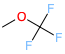

COC(F)(F)F
Entry
CHOF_G4
COC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.9074,106.248,120.147,131.58,148.466,160.487,177.589],'J/(mol*K)'), H298=(-890.226,'kJ/mol'), S298=(325.075,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.7,13.4,13.58,14.54,16.71,18.29,20.17],'J/(mol*K)'), H298=(-98.6,'kJ/mol'), S298=(38.61,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-O2sHHH) + missing(Cs-F1sF1sF1sO2s)""")

missing
['Cs-OsHHH_Cs-O2sHHH', 'CsFFFO_Cs-F1sF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.7,13.4,13.58,14.54,16.71,18.29,20.17],'J/(mol*K)'), H298=(-98.6,'kJ/mol'), S298=(38.61,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([88.4

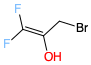

OC(CBr)=C(F)F
Entry
CHOFBr_G4
OC(CBr)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.713,140.246,154.272,165.363,182.119,193.23,206.473],'J/(mol*K)'), H298=(-499.013,'kJ/mol'), S298=(374.743,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([80.7738,93.7867,103.237,111.353,123.338,131.436,141.449],'J/(mol*K)'), H298=(-141.892,'kJ/mol'), S298=(226.493,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsBrCHH) + longDistanceInteraction_noncyclic(Cs(Br)-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([79.8168,96.8683,107.09,113.923,123.828,130.469,139.142],'J/(mol*K)'), H298=(-190.546,'kJ/mol'), S298=(220.222,'J/(mol*K)'), comment="""Thermo g

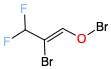

FC(F)C(Br)=COBr
Entry
CHOFBr_G4
FC(F)C(Br)DCOBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.997,143.452,157.933,169.813,187.146,197.953,209.268],'J/(mol*K)'), H298=(-354.997,'kJ/mol'), S298=(426.576,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.4846,92.1767,100.363,107.114,117.11,123.386,130.577],'J/(mol*K)'), H298=(86.8255,'kJ/mol'), S298=(267.404,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + missing(Cs-CdF1sF1sH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cd(Br)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCFFH_Cs-CdF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([87.6989,99.1768,107.176,112.63,119.924,124.098,129.648],'J/(mol*K)'), H298=(50.8905,'kJ/mol'), S298=(260.261,'J/(mol*K)'), comment="""Th

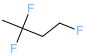

CC(F)(F)CCF
Entry
CHOF_G4
CC(F)(F)CCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.329,167.624,188.848,205.834,232.442,251.326,278.075],'J/(mol*K)'), H298=(-754.459,'kJ/mol'), S298=(362.657,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.128,155.686,179.399,199.199,229.336,250.583,281.733],'J/(mol*K)','

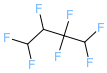

FC(F)C(F)C(F)(F)C(F)F
Entry
CHOF_G4
FC(F)C(F)C(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([174.076,202.236,223.661,240.129,263.434,278.931,298.215],'J/(mol*K)'), H298=(-1507.41,'kJ/mol'), S298=(448.123,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.6019,37.6593,44.3589,48.8605,54.8447,59.4001,67.1829],'J/(mol*K)'), H298=(-160.263,'kJ/mol'), S298=(54.0647,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,50

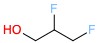

OCC(F)CF
Entry
CHOF_G4
OCC(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.157,143.477,161.162,176.09,199.206,215.262,236.832],'J/(mol*K)'), H298=(-634.64,'kJ/mol'), S298=(346.842,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.2844,41.0954,46.4563,50.5688,56.5004,60.3033,64.8296],'J/(mol*K)'), H298=(-216.419,'kJ/mol'), S298=(49.1862,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F))""")

missing
['O2s-CsH_O2s-CsH', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.0729,55.8267,59.4216,63.3516],'J/(mol*K)'), H298=(-230.751,'kJ/mol'), S298=(49.2315,'J/(m

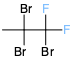

CC(Br)(Br)C(F)(F)Br
Entry
CHOFBr_G4
CC(Br)(Br)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([144.1,162.558,177.942,190.632,209.329,221.19,234.057],'J/(mol*K)'), H298=(-432.456,'kJ/mol'), S298=(425.571,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([118.435,130.746,139.259,145.585,154.187,158.577,160.448],'J/(mol*K)'), H298=(-387.538,'kJ/mol'), S298=(312.579,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + missing(Cs-CsHHH) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7)2)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([121.118,133.305,141.197,147.304,155.725,159.741,159.356],'J/(mol*K)'), H298=(-406.918,'kJ/mol'), S298=(307.796,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + group(CsB

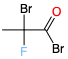

CC(F)(Br)C(=O)Br
Entry
CHOFBr_G4
CC(F)(Br)C(DO)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.222,142.267,154.766,165.227,181.069,191.671,204.961],'J/(mol*K)'), H298=(-365.389,'kJ/mol'), S298=(400.337,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.122,111.314,117.026,121.335,127.292,130.422,131.832],'J/(mol*K)'), H298=(-320.456,'kJ/mol'), S298=(275.763,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCF) + longDistanceInteraction_noncyclic(Cs(Val7)2-CO) + missing(Cs-CsHHH) + group(COBrCsO)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.9303,107.951,114.47,119.64,126.882,130.667,131.929],'J/(mol*K)'), H298=(-342.868,'kJ/mol'), S298=(275.155,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCF) + group(COBrCsO)""")

GAE wit

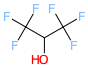

OC(C(F)(F)F)C(F)(F)F
Entry
CHOF_G4
OC(C(F)(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([156.439,180.185,195.738,208.435,227.008,238.669,251.297],'J/(mol*K)'), H298=(-1546,'kJ/mol'), S298=(405.618,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([23.9715,32.768,38.2291,42.6253,47.6205,49.5008,51.5644],'J/(mol*K)'), H298=(15.6197,'kJ/mol'), S298=(-65.9725,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(Cs-CsCsOsH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-CsOs) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-CsOs) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,80

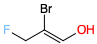

OC=C(Br)CF
Entry
CHOFBr_G4
OCDC(Br)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.694,125.587,142.06,154.743,173.836,186.924,203.47],'J/(mol*K)'), H298=(-323.893,'kJ/mol'), S298=(360.053,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([72.6329,86.4035,95.8937,102.501,111.544,117.374,125.414],'J/(mol*K)'), H298=(-106.719,'kJ/mol'), S298=(213.14,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cds(Val7)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cd(Br)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCFHH_Cs-CdF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.7458,93.5466,102.999,108.375,114.567,118.322,124.84],'J/(mol*K)'), H298=(-136.309,'kJ/mol'), S298=(204.247,'J/(mol*K)'), comment="""Thermo gro

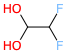

OC(O)C(F)F
Entry
CHOF_G4
OC(O)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.292,133.22,148.68,159.812,176.282,186.917,199.306],'J/(mol*K)'), H298=(-833.14,'kJ/mol'), S298=(333.126,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.966,29.7064,36.861,39.9572,43.137,46.2332,46.2332],'J/(mol*K)'), H298=(-66.944,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + group(Cs-CsOsOsH) + missing(Cs-CsF1sF1sH)""")

missing
['O2s-CsH_O2s-CsH', 'O2s-CsH_O2s-CsH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.966,29.7064,36.861,39.9572,43.137,46.2332,46.2332],'J/(mol*K)'), H298=(-66.944,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsOsOsH)""")

GAE with fitted GAV
The

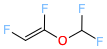

FC=C(F)OC(F)F
Entry
CHOF_G4
FCDC(F)OC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.802,137.311,150.99,162.464,179.89,191.569,205.921],'J/(mol*K)'), H298=(-904.213,'kJ/mol'), S298=(385.256,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([47.3846,54.8227,59.6289,62.9912,66.7296,68.4513,68.4976],'J/(mol*K)'), H298=(-273.672,'kJ/mol'), S298=(74.0764,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sF1sO2sH) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CsFFHO_Cs-F1sF1sO2sH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.1875,54.1148,59.2226,62.679,66.5978,68.4315,69.0042],'J/(mol*K)'), H298=(-298.857,'kJ/mol'), S298=(72.4644,'J/(mol*K

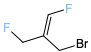

FC=C(CF)CBr
Entry
CHOFBr_G4
FCDC(CF)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.2,149.943,167.878,183.03,206.432,222.582,243.761],'J/(mol*K)'), H298=(-359.537,'kJ/mol'), S298=(385.467,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.3507,66.7775,74.3606,80.606,90.3702,96.9613,105.008],'J/(mol*K)'), H298=(28.1395,'kJ/mol'), S298=(112.332,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + group(CsBrCHH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.3507,66.7775,74.3606,80.606,90.3702,96.9613,105.008],'J/(mol*K)'), H298=(28.1395,'kJ/mol'), S298=(112.332,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCHH) + group(Cds-CdsCsCs)""")

GAE with fitted GAV
Th

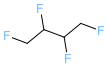

FCC(F)C(F)CF
Entry
CHOF_G4
FCC(F)C(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([144.5,178.695,202.729,220.937,248.235,266.175,287.605],'J/(mol*K)'), H298=(-875.643,'kJ/mol'), S298=(379.227,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([67.3247,81.5547,93.0337,101.633,113.675,121.488,131.137],'J/(mol*K)'), H298=(-418.506,'kJ/mol'), S298=(98.3271,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F))""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GA

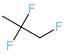

CC(F)(F)CF
Entry
CHOF_G4
CC(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.174,125.298,142.252,156.739,179.457,195.543,217.78],'J/(mol*K)'), H298=(-721.687,'kJ/mol'), S298=(337.154,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.2346,-0.636123,0.0552886,0.275793,0.299765,0.514653,1.37234],'J/(mol*K)'), H298=(19.5573,'kJ/mol'), S298=(0.811252,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.2

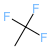

CC(F)(F)F
Entry
CHOF_G4
CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.4589,94.6312,107.213,117.155,132.591,143.403,158.089],'J/(mol*K)'), H298=(-751.749,'kJ/mol'), S298=(287.843,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([79.0543,94.2733,106.726,116.907,132.276,143.363,159.056],'J/(mol*K)','+|-',[0.346373,0.362076,0.339473,0.315212,0.27329,0.242681,0.469061]), H298=(-715.509,'kJ/m

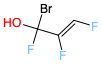

OC(F)(Br)C(F)=CF
Entry
CHOFBr_G4
OC(F)(Br)C(F)DCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([135.096,150.849,162.682,172.452,186.895,196.166,206.912],'J/(mol*K)'), H298=(-674.578,'kJ/mol'), S298=(404.463,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([53.0474,61.5915,66.5685,69.9835,73.646,74.9795,73.5487],'J/(mol*K)'), H298=(-192.465,'kJ/mol'), S298=(84.965,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(CsBrCFO) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['O2s-CsH_O2s-CsH', 'CdCsCdF_Cd-CdCsF1s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([53.9903,62.2738,66.9837,70.1996,73.7033,74.

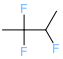

CC(F)C(C)(F)F
Entry
CHOF_G4
CC(F)C(C)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.594,157.71,179.346,197.887,227.105,247.976,277.398],'J/(mol*K)'), H298=(-764.238,'kJ/mol'), S298=(365.31,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.294,41.0955,46.3906,50.3487,56.1265,59.9362,64.724],'J/(mol*K)'), H298=(-211.194,'kJ/mol'), S298=(50.0427,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.0729,55.8267,59.4216,63.3516],'J/(mol*K)'), H298=(-230.751,'kJ/mol'), S298=(49.2315,'J/(mol*K)'), comment="""Thermo group a

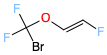

FC=COC(F)(F)Br
Entry
CHOFBr_G4
FCDCOC(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.568,143.326,158.736,170.625,186.724,196.546,209.407],'J/(mol*K)'), H298=(-684.162,'kJ/mol'), S298=(405.895,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.691,114.447,125.524,133.43,142.719,147.401,151.65],'J/(mol*K)'), H298=(-536.071,'kJ/mol'), S298=(255.368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrFFO) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([100.282,118.223,129.608,136.765,144.6,148.162,152.289],'J/(mol*K)'), H298=(-562.839,'kJ/mol'), S298=(249.118,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + gro

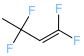

CC(F)(F)C=C(F)F
Entry
CHOF_G4
CC(F)(F)CDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([121.86,146.493,166.299,181.907,205.692,222.459,245.003],'J/(mol*K)'), H298=(-817.271,'kJ/mol'), S298=(372.662,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + missing(Cs-CsHHH) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.555,150.737,168.638,183.368,205.73,221.488,239.541],'J/(mol*K)

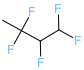

CC(F)(F)C(F)C(F)F
Entry
CHOF_G4
CC(F)(F)C(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.924,178.659,199.634,217.306,244.359,262.786,286.553],'J/(mol*K)'), H298=(-1143.81,'kJ/mol'), S298=(409.398,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.0594,40.4593,46.4459,50.6244,56.4262,60.4509,66.0963],'J/(mol*K)'), H298=(-191.637,'kJ/mol'), S298=(50.854,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCsCsFH) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.0729,55.8267,59.4216,63.3516],'J/(mol*K)'), H298=(-230.

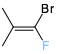

CC(C)=C(F)Br
Entry
CHOFBr_G4
CC(C)DC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.716,128.738,146.459,162.302,187.964,207.028,235.342],'J/(mol*K)'), H298=(-178.744,'kJ/mol'), S298=(363.584,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.0462,68.7699,73.9961,77.727,84.0984,87.8008,91.5129],'J/(mol*K)'), H298=(-85.9444,'kJ/mol'), S298=(125.319,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + missing(Cs-CdHHH) + group(Cds-CdsCsCs) + group(CdBrCF)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdCs)CdHHH', 'Cs-(Cds-Cds)HHH_Cs-(CdCs)CdHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.0462,68.7699,73.9961,77.727,84.0984,87.8008,91.5129],'J/(mol*K)'), H298=(-85.9444,'kJ/mol'), S298=(125.319,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-CdsCsCs) + group(CdBrC

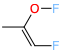

CC(=CF)OF
Entry
CHOF_G4
CC(DCF)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.775,120.841,136.241,148.594,167.766,181.349,199.832],'J/(mol*K)'), H298=(-215.815,'kJ/mol'), S298=(340.853,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.413,48.1646,51.0167,53.9505,59.7661,63.0974,64.7499],'J/(mol*K)'), H298=(10.6806,'kJ/mol'), S298=(95.5518,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CdHHH) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdO2s)CdHHH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.0039,51.9406,55.1012,57.2856,61.6473,63.8588,65.389],'J/(mol*K)'), H298=(-16.0879,'kJ/mol'), S298=(89.3016,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O

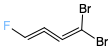

FC=C=C=C(Br)Br
Entry
CHOFBr_G4
FCDCDCDC(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.346,122.539,132.361,140.531,152.756,160.753,170.193],'J/(mol*K)'), H298=(210.796,'kJ/mol'), S298=(389.114,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.323,123.654,133.194,141.227,153.113,161.069,170.638],'J/(mol*K)'), H298=(227.177,'kJ/mol'), S298=(390.907,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CdCddFH) + group(CdBrBrCdd) + group(Cdd-CdsCds) + group(Cdd-CdsCds)""")

missing
['Cdd-(Cdd-Cd)Cds_Cdd-(Cd)(F1sH)CdCdd', 'Cdd-(Cdd-Cd)Cds_Cdd-(Br1sBr1s)(Cd)CdCdd']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.6877,86.8347,93.864,99.3865,108.762,115.045,122.941],'J/(mol*K)'), H298=(-59.0086,'kJ/mol'), S298=(340.699,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CdCddFH) +

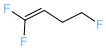

FCCC=C(F)F
Entry
CHOF_G4
FCCCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.984,138.151,156.794,172.785,197.999,215.973,240.831],'J/(mol*K)'), H298=(-579.255,'kJ/mol'), S298=(370.12,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CsF1sHH) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH)""

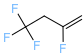

C=C(F)CC(F)(F)F
Entry
CHOF_G4
CDC(F)CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([122.823,146.675,166.625,182.879,206.33,222.449,245.198],'J/(mol*K)'), H298=(-857.41,'kJ/mol'), S298=(380.572,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9017,26.8239,33.926,39.3923,46.9226,52.3075,60.7168],'J/(mol*K)'), H298=(-14.3461,'kJ/mol'), S298=(43.0786,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cd-CdCsF1s) + missing(Cd-CdHH)""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), commen

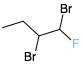

CCC(Br)C(F)Br
Entry
CHOFBr_G4
CCC(Br)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([141.215,167.179,188.767,206.731,234.293,253.897,282.148],'J/(mol*K)'), H298=(-279.252,'kJ/mol'), S298=(418.964,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.6859,106.263,116.642,124.842,136.61,143.629,150.59],'J/(mol*K)'), H298=(-208.278,'kJ/mol'), S298=(249.039,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsBrCsCsH) + missing(Cs-CsHHH) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.3812,107.734,117.657,125.704,137.275,143.967,149.687],'J/(mol*K)'), H298=(-218.046,'kJ/mol'), S298=(246.522,'J/(mol*K)'), comment="""Thermo group additivity estimation

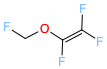

FCOC(F)=C(F)F
Entry
CHOF_G4
FCOC(F)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([118.472,135.969,150.615,162.76,180.837,192.547,206.083],'J/(mol*K)'), H298=(-854.072,'kJ/mol'), S298=(380.762,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([48.8033,55.907,60.3838,63.5277,66.8005,68.3128,68.2404],'J/(mol*K)'), H298=(-258.942,'kJ/mol'), S298=(73.8538,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sO2sHH) + group(CdCFO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CsFHHO_Cs-F1sO2sHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.1875,54.1148,59.2226,62.679,66.5978,68.4315,69.0042],'J/(mol*K)'), H298=(-298.857,'kJ/mol'), S298=(72.4644,'J/(mol*K)'), comment="""Thermo group additivity estimation

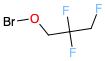

FCC(F)(F)COBr
Entry
CHOFBr_G4
FCC(F)(F)COBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([143.324,166.967,183.861,197.667,218.387,231.983,247.927],'J/(mol*K)'), H298=(-697.899,'kJ/mol'), S298=(410.775,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.3185,35.2941,36.7523,37.6814,38.9472,39.8411,41.15],'J/(mol*K)'), H298=(18.6569,'kJ/mol'), S298=(163.125,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.5531,35.9303,36.697,37.4056,38.6474,39.3265,39.7776],'J/(mol*K)'), H298=(-0.900338,'kJ/mol'), S298=(162.314,'J/(mol*K)'), comment="""Thermo

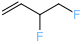

C=CC(F)CF
Entry
CHOF_G4
CDCC(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.713,131.973,150.427,166.369,191.81,210.307,236.919],'J/(mol*K)'), H298=(-381.781,'kJ/mol'), S298=(317.219,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.297,39.1482,44.8517,49.4592,55.7406,59.9983,63.8334],'J/(mol*K)'), H298=(-203.474,'kJ/mol'), S298=(50.379,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cd-CdCsH) + missing(Cd-CdHH)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'Cds-CdsCsH_Cd-CdCsH', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.5412,39.7844,44.7307,48.9633,55.0669,59.1166,62.3554],'J/(mol*K)'), H298=(-217.806,'kJ/mol'), S298=(50.4243,'J/(mo

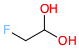

OC(O)CF
Entry
CHOF_G4
OC(O)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.6653,121.999,138.457,150.742,169.178,181.438,196.484],'J/(mol*K)'), H298=(-612.939,'kJ/mol'), S298=(313.862,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.966,29.7064,36.861,39.9572,43.137,46.2332,46.2332],'J/(mol*K)'), H298=(-66.944,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + group(Cs-CsOsOsH) + missing(Cs-CsF1sHH)""")

missing
['O2s-CsH_O2s-CsH', 'O2s-CsH_O2s-CsH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.966,29.7064,36.861,39.9572,43.137,46.2332,46.2332],'J/(mol*K)'), H298=(-66.944,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsOsOsH)""")

GAE with fitted GAV
ThermoData

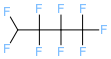

FC(F)C(F)(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
FC(F)C(F)(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([190.849,220.546,242.267,258.215,279.32,292.352,306.447],'J/(mol*K)'), H298=(-1940.95,'kJ/mol'), S298=(475.177,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.38855,-6.71385,-4.04174,-2.9132,-2.71978,-1.32445,4.62835],'J/(mol*K)'), H298=(148.512,'kJ/mol'), S298=(5.23614,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2

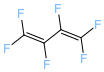

FC(F)=C(F)C(F)=C(F)F
Entry
CHOF_G4
FC(F)DC(F)C(F)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.778,157.003,171.603,182.221,197.281,207.126,218.166],'J/(mol*K)'), H298=(-970.552,'kJ/mol'), S298=(406.226,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.5278,71.4486,77.3962,81.8859,87.6678,90.8017,91.7438],'J/(mol*K)'), H298=(-244.404,'kJ/mol'), S298=(94.0259,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CdCCF) + longDistanceInteraction_noncyclic(Cds(F)-Cds(F)) + group(CdCCF) + longDistanceInteraction_noncyclic(Cds(F)-Cds(F)) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F)) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CdCFF_Cd-CdF1sF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.7948,6

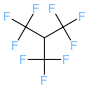

FC(F)(F)C(C(F)(F)F)C(F)(F)F
Entry
CHOF_G4
FC(F)(F)C(C(F)(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([177.613,211.499,237.11,255.703,280.407,296.545,314.994],'J/(mol*K)'), H298=(-2042.38,'kJ/mol'), S298=(436.003,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(332.579,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.4561,25.4576,33.4524,39.0386,45.1923,48.978,55.0292],'J/(mol*K)'), H298=(41.3238,'kJ/mol'), S298=(-61.5089,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3)""")

missin

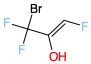

OC(=CF)C(F)(F)Br
Entry
CHOFBr_G4
OC(DCF)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([135.393,152.967,164.633,174.231,188.365,197.376,207.676],'J/(mol*K)'), H298=(-702.288,'kJ/mol'), S298=(398.202,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.289,114.721,122.922,129.647,139.078,144.869,149.497],'J/(mol*K)'), H298=(-536.644,'kJ/mol'), S298=(261.554,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.101,118.309,127.038,132.294,139.754,143.869,146.8],'J/(mol*K)'), H298=(-593.017,'kJ/mol'), S298=(256.115,'J/(mol*K)'), comment="""Ther

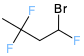

CC(F)(F)CC(F)Br
Entry
CHOFBr_G4
CC(F)(F)CC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([147.4,172.319,192.846,210.134,237.307,256.645,283.335],'J/(mol*K)'), H298=(-728.035,'kJ/mol'), S298=(422.205,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.7669,60.0534,65.4783,69.9172,76.2768,80.1299,83.611],'J/(mol*K)'), H298=(-201.983,'kJ/mol'), S298=(178.297,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + group(CsBrCFH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.7669,60.0534,65.4783,69.9172,76.2768,80.1299,83.611],'J/(mol*K)'), H298=(-201.983,'kJ/mol'), S298=(178.297,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCFH)""")



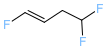

FC=CCC(F)F
Entry
CHOF_G4
FCDCCC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.247,138.47,157.014,172.915,197.974,215.83,240.558],'J/(mol*K)'), H298=(-604.505,'kJ/mol'), S298=(369.443,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CsF1sF1sH) + missing(Cd-CdCsH) + missing(Cd-CdF1sH)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH)"""

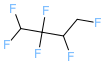

FCC(F)C(F)(F)C(F)F
Entry
CHOF_G4
FCC(F)C(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([160.006,187.903,210.041,227.623,253.014,270.029,292.92],'J/(mol*K)'), H298=(-1298.97,'kJ/mol'), S298=(432.032,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.5923,37.6593,44.4247,49.0806,55.2186,59.7672,67.2886],'J/(mol*K)'), H298=(-165.488,'kJ/mol'), S298=(53.2082,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estima

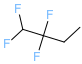

CCC(F)(F)C(F)F
Entry
CHOF_G4
CCC(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([144.867,168.983,189.673,207.324,234.932,254.424,281.361],'J/(mol*K)'), H298=(-956.4,'kJ/mol'), S298=(389.475,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.45752,-2.80002,-2.08694,-1.76392,-1.58155,-1.05079,1.08663],'J/(mol*K)'), H298=(31.3737,'kJ/mol'), S298=(3.21073,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,

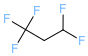

FC(F)CC(F)(F)F
Entry
CHOF_G4
FC(F)CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.214,141.306,159.513,174.121,194.627,208.218,226.889],'J/(mol*K)'), H298=(-1167.28,'kJ/mol'), S298=(374.795,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.318,145.506,162.764,176.509,196.671,210.294,227.621],'J/(mol*K)','+|-',[0.579424,0.605693,0.5678

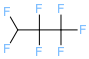

FC(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
FC(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([141.852,165.258,182.875,195.817,212.734,223.684,236.599],'J/(mol*K)'), H298=(-1527.76,'kJ/mol'), S298=(407.637,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.93103,-3.91383,-1.9548,-1.14928,-1.13823,-0.273656,3.54172],'J/(mol*K)'), H298=(96.2185,'kJ/mol'), S298=(2.02541,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE withou

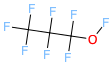

FOC(F)(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
FOC(F)(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([176.552,203.14,219.477,231.348,247.971,257.423,264.306],'J/(mol*K)'), H298=(-1571.39,'kJ/mol'), S298=(446.576,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([27.0523,28.9477,32.0591,33.9611,36.0746,38.1882,43.1573],'J/(mol*K)'), H298=(67.4531,'kJ/mol'), S298=(142.874,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(CsF2-CsF2-CsF2) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFF_Cs-CsF1sF1

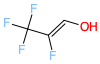

OC=C(F)C(F)(F)F
Entry
CHOF_G4
OCDC(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([122.72,145.683,160.567,172.038,188.65,198.849,209.071],'J/(mol*K)'), H298=(-971.787,'kJ/mol'), S298=(359.959,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.2815,53.3583,60.2751,64.6296,69.5258,73.0939,78.8742],'J/(mol*K)'), H298=(-126.614,'kJ/mol'), S298=(140.104,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cd(F)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.474,57.3286,64.4858,68.0864,71.3644,73.549,78.7346],'J/(mol*K)'), H298=(-179.606,'kJ/mol'), S298=(132.24

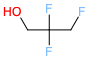

OCC(F)(F)CF
Entry
CHOF_G4
OCC(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([135.69,161.034,176.954,189.431,208.64,221.921,240.099],'J/(mol*K)'), H298=(-863.882,'kJ/mol'), S298=(359.494,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.2346,-0.636123,0.0552886,0.275793,0.299765,0.514653,1.37234],'J/(mol*K)'), H298=(19.5573,'kJ/mol'), S298=(0.811252,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,

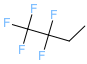

CCC(F)(F)C(F)(F)F
Entry
CHOF_G4
CCC(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([150.417,175.883,197.238,215.253,242.888,261.759,286.107],'J/(mol*K)'), H298=(-1191.13,'kJ/mol'), S298=(398.855,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.952312,-0.940249,-0.44155,-0.173174,-0.0885042,0.154087,1.51887],'J/(mol*K)'), H298=(42.3898,'kJ/mol'), S298=(1.23249,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV

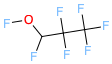

FOC(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
FOC(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([160.235,187.18,206.96,220.985,238.705,249.826,261.591],'J/(mol*K)'), H298=(-1363.1,'kJ/mol'), S298=(427.308,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([63.2251,74.7628,83.4791,89.7167,97.9276,102.968,108.785],'J/(mol*K)'), H298=(-225.479,'kJ/mol'), S298=(185.192,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCFHO) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.412,76.3391,83.8654,89.6141,97.7164,102.299,105.894],'J/(mol*K)'), H298=(-287.427,'kJ/mol'), S298

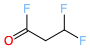

O=C(F)CC(F)F
Entry
CHOF_G4
ODC(F)CC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.019,122.532,137.752,150.668,170.659,184.468,202.323],'J/(mol*K)'), H298=(-858.895,'kJ/mol'), S298=(367.928,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.91,30.8,34.98,38.91,45.56,50.73,58.93],'J/(mol*K)'), H298=(-21.5,'kJ/mol'), S298=(40.32,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH) + missing(Cs-CsF1sF1sH) + missing(CO-CsF1sO2d)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.91,30.8,34.98,38.91,45.56,50.73,58.93],'J/(mol*K)'), H298=(-21.5,'kJ/mol'), S298=(40.32,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500]

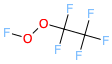

FOOC(F)(F)C(F)(F)F
Entry
CHOF_G4
FOOC(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([149.689,167.92,180.803,191.09,205.308,213.175,218.366],'J/(mol*K)'), H298=(-1108.33,'kJ/mol'), S298=(414.188,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([15.3653,17.0928,18.8048,20.0774,22.1704,24.4213,25.7861],'J/(mol*K)'), H298=(19.7962,'kJ/mol'), S298=(36.9639,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + missing(O2s-F1sO2s) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['O2sFO_O2s-F1sO2s', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([16.3176,18.033,19.2464,20.2506,22.2589,24.2672,24.2672],'J/(mol*K)'), H298=(-22.5936,'kJ/mol'), S298=(35.7314,'J/(mol*K)'), co

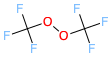

FC(F)(F)OOC(F)(F)F
Entry
CHOF_G4
FC(F)(F)OOC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.994,160.818,176.768,187.545,202.627,211.552,218.862],'J/(mol*K)'), H298=(-1459.45,'kJ/mol'), S298=(394.626,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.6352,36.0661,38.4928,40.5011,44.5178,48.5344,48.5344],'J/(mol*K)'), H298=(-45.1872,'kJ/mol'), S298=(71.4627,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + missing(Cs-F1sF1sF1sO2s) + missing(Cs-F1sF1sF1sO2s)""")

missing
['CsFFFO_Cs-F1sF1sF1sO2s', 'CsFFFO_Cs-F1sF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.6352,36.0661,38.4928,40.5011,44.5178,48.5344,48.5344],'J/(mol*K)'), H298=(-45.1872,'kJ/mol'), S298=(71.4627,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group

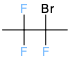

CC(F)(F)C(C)(F)Br
Entry
CHOFBr_G4
CC(F)(F)C(C)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.837,178.949,198.969,215.945,242.229,260.481,284.954],'J/(mol*K)'), H298=(-744.595,'kJ/mol'), S298=(402.347,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.9285,57.9313,61.4561,63.9934,67.4098,69.1861,69.76],'J/(mol*K)'), H298=(-190.638,'kJ/mol'), S298=(91.6707,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + group(CsBrCCF) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([55.3384,61.2826,64.4177,66.767,69.7615,70.869,69.264],'J/(mol*K)'), H298=(-

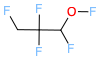

FCC(F)(F)C(F)OF
Entry
CHOF_G4
FCC(F)(F)C(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([148.463,174.765,193.533,207.078,226.887,239.708,253.877],'J/(mol*K)'), H298=(-931.847,'kJ/mol'), S298=(400.536,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.9428,75.0669,83.976,90.1657,98.3159,103.329,108.639],'J/(mol*K)'), H298=(-248.312,'kJ/mol'), S298=(184.77,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCFHO) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.412,76.3391,83.8654,89.6141,97.7164,102.299,105.894],'J/(mol*K)'), H298=(-287.427,'kJ/mol'), S298=(183.148,'J/(mol*K)

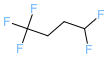

FC(F)CCC(F)(F)F
Entry
CHOF_G4
FC(F)CCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([148.849,175.599,197.486,215.434,242.5,261.364,287.191],'J/(mol*K)'), H298=(-1204.33,'kJ/mol'), S298=(412.588,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([147.225,175.102,197.387,215.477,242.686,261.487,286.595]

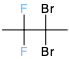

CC(F)(F)C(C)(Br)Br
Entry
CHOFBr_G4
CC(F)(F)C(C)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([157.805,181.211,201.164,218.108,244.394,262.683,287.112],'J/(mol*K)'), H298=(-518.47,'kJ/mol'), S298=(417.978,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.2284,61.0237,64.8045,67.5607,71.344,73.1354,73.7947],'J/(mol*K)'), H298=(26.4831,'kJ/mol'), S298=(112.12,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + group(CsBrBrCsCs) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.6383,64.375,67.7662,70.3343,73.6957,74.8183,73.2987],'J/(mol*K)'), H2

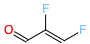

O=CC(F)=CF
Entry
CHOF_G4
ODCC(F)DCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([85.4137,100.135,112.648,123.21,139.418,150.481,164.644],'J/(mol*K)'), H298=(-419.906,'kJ/mol'), S298=(317.591,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.3141,66.3885,74.7571,81.6562,92.124,98.2439,102.745],'J/(mol*K)'), H298=(-264.354,'kJ/mol'), S298=(184.181,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CdCCF) + longDistanceInteraction_noncyclic(Cd(F)-CO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + group(Cds-O2d(Cds-Cds)H) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.5682,70.7375,78.2965,84.6466,94.5898,99.788,100.1],'J/(mol*K)'), H298=(-294.229,'kJ/mol'), S298=(185.158,'J/(mol*K)'), com

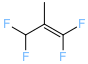

CC(=C(F)F)C(F)F
Entry
CHOF_G4
CC(DC(F)F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.006,149.968,167.798,182.899,206.233,222.375,243.831],'J/(mol*K)'), H298=(-808.841,'kJ/mol'), S298=(379.315,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + missing(Cs-CdF1sF1sH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdCs)CdHHH', 'CsCFFH_Cs-CdF1sF1sH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group

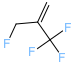

C=C(CF)C(F)(F)F
Entry
CHOF_G4
CDC(CF)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.297,150.563,168.378,183.473,206.806,222.953,244.383],'J/(mol*K)'), H298=(-835.913,'kJ/mol'), S298=(372.53,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + missing(Cs-CdF1sF1sF1s) + group(Cds-CdsCsCs) + missing(Cd-CdHH)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CsCdFFF_Cs-CdF1sF1sF1s', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-CdsCsC

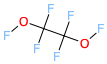

FOC(F)(F)C(F)(F)OF
Entry
CHOF_G4
FOC(F)(F)C(F)(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([159.021,179.497,190.515,198.946,210.073,215.601,217.615],'J/(mol*K)'), H298=(-972.016,'kJ/mol'), S298=(403.432,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.5091,62.923,65.9408,68.4569,72.844,75.873,80.3177],'J/(mol*K)'), H298=(-26.157,'kJ/mol'), S298=(284.908,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(O2sCF) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['CsCFFO_Cs-CsF1sF1sO2s', 'CsCFFO_Cs-CsF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.9666,65.723,68.0277,70.2208,74.4256,76.9238,79.2311],'J/(mol*K)'), H298=(-57.5308,'kJ/mol'), S298=(281.6

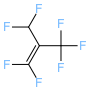

FC(F)=C(C(F)F)C(F)(F)F
Entry
CHOF_G4
FC(F)DC(C(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([149.178,172.341,191.474,207.089,229.651,243.452,257.195],'J/(mol*K)'), H298=(-1420.57,'kJ/mol'), S298=(426.557,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([13.9156,16.6008,19.1525,20.917,23.3719,24.5298,26.3426],'J/(mol*K)'), H298=(51.4707,'kJ/mol'), S298=(-55.6603,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sF1sH) + missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)2) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s)""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'CsCdFFF_Cs-CdF1sF1sF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'

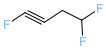

FC#CCC(F)F
Entry
CHOF_G4
FC#CCC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.72,125.983,140.872,153.498,173.037,186.566,204.419],'J/(mol*K)'), H298=(-358.607,'kJ/mol'), S298=(355.121,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([20.7108,27.447,33.1791,37.9907,45.4382,51.003,59.4128],'J/(mol*K)'), H298=(-19.7903,'kJ/mol'), S298=(43.0952,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CtCsHH) + missing(Cs-CsF1sF1sH) + missing(Ct-CsCt) + missing(Ct-CtF1s)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'Ct-CtCs_Ct-CsCt', 'CtCF_Ct-CtF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([20.7108,27.447,33.1791,37.9907,45.4382,51.003,59.4128],'J/(mol*K)'), H298=(-19.7903,'kJ/mol'), S298=(43.0952,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CtCsHH)""")

GAE with fitted GAV
Th

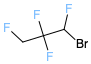

FCC(F)(F)C(F)Br
Entry
CHOFBr_G4
FCC(F)(F)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.92,162.066,177.798,190.363,208.658,220.016,231.796],'J/(mol*K)'), H298=(-856.037,'kJ/mol'), S298=(394.169,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.1224,56.0659,62.572,67.4193,74.2249,78.9617,85.4793],'J/(mol*K)'), H298=(-166.62,'kJ/mol'), S298=(184.794,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsF1sHH) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.7669,60.0534,65.4783,69.9172,76.2768,80.1299,83.611],'J/(mol*K)')

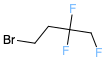

FCC(F)(F)CCBr
Entry
CHOFBr_G4
FCC(F)(F)CCBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([148.728,173.412,194.436,212.228,239.679,258.629,283.757],'J/(mol*K)'), H298=(-714.039,'kJ/mol'), S298=(422.507,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.2192,49.3438,56.0652,61.3262,68.9374,74.307,81.6754],'J/(mol*K)'), H298=(-4.09174,'kJ/mol'), S298=(159.795,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsCsHH) + missing(Cs-CsF1sHH) + group(CsBrCsHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.4538,49.98,56.01,61.0504,68.6377,73.7924,80.3031],'J/(mol*K)'), H298=(-23.649,'kJ/mol'), S298=(158.984,'J/(mol*K)'), comment="""Thermo g

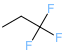

CCC(F)(F)F
Entry
CHOF_G4
CCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.882,122.775,140.037,154.8,177.983,194.43,217.185],'J/(mol*K)'), H298=(-772.539,'kJ/mol'), S298=(327.825,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.961,123.87,141.349,155.876,178.29,194.556,218.03],'J/(mol*K)','+|-',[0.526288,0.550148,0.515804,0.478941,0.415244,

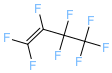

FC(F)=C(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
FC(F)DC(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([165.761,191.741,210.864,224.8,242.433,252.585,264.29],'J/(mol*K)'), H298=(-1568.54,'kJ/mol'), S298=(448.466,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.891744,-0.678874,0.205521,0.661222,0.398169,0.56235,3.00731],'J/(mol*K)'), H298=(104.468,'kJ/mol'), S298=(4.41178,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cd-CdCsF1s) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without est

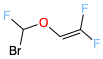

FC(F)=COC(F)Br
Entry
CHOFBr_G4
FC(F)DCOC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.041,144.8,160.313,172.417,189.18,199.509,211.364],'J/(mol*K)'), H298=(-655.906,'kJ/mol'), S298=(404.232,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.6381,105.635,117.38,125.991,136.402,142.313,149.086],'J/(mol*K)'), H298=(-305.523,'kJ/mol'), S298=(235.874,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrFHO) + group(Cds-CdsOsH) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.6578,109.369,121.582,129.378,138.35,142.956,149.118],'J/(mol*K)'), H298=(-341.063,'kJ/mol'), S298=(227.72,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) +

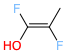

CC(F)=C(O)F
Entry
CHOF_G4
CC(F)DC(O)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([103.624,119.799,133.526,145.305,163.908,177.251,196.241],'J/(mol*K)'), H298=(-532.189,'kJ/mol'), S298=(337.672,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.9146,61.8027,66.8889,70.2212,74.5196,77.4813,80.7476],'J/(mol*K)'), H298=(-337.872,'kJ/mol'), S298=(161.466,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdHHH) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdF1s)CdHHH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([51.7175,61.0948,66.4826,69.909,74.3878,77.4615,81.2542],'J/(mol*K)'), H298=(-363.057,'kJ/mol'), S298=(159.854,'J

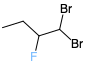

CCC(F)C(Br)Br
Entry
CHOFBr_G4
CCC(F)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([144.271,168.011,188.428,205.893,233.34,252.866,280.233],'J/(mol*K)'), H298=(-271.357,'kJ/mol'), S298=(419.981,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.5955,105.106,115.482,123.674,135.582,142.818,150.131],'J/(mol*K)'), H298=(-210.268,'kJ/mol'), S298=(252.107,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsHHH) + group(CsBrBrCsH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.2908,106.578,116.497,124.536,136.248,143.156,149.228],'J/(mol*K)'), H298=(-220.035,'kJ/mol'), S298=(249.59,'J/(mol*K)'), comment="""Thermo group additivity estimatio

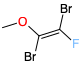

COC(Br)=C(F)Br
Entry
CHOFBr_G4
COC(Br)DC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.198,135.577,148.658,159.709,176.705,188.372,203.627],'J/(mol*K)'), H298=(-217.139,'kJ/mol'), S298=(406.883,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.6035,110.65,118.034,123.175,129.44,132.629,134.077],'J/(mol*K)'), H298=(-183.764,'kJ/mol'), S298=(274.183,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-O2sHHH) + group(CdBrCO) + group(CdBrCF) + longDistanceInteraction_noncyclic(Cds(Val7)2=Cds(Val7))""")

missing
['Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.7848,108.162,116.259,121.722,128.823,132.449,134.665],'J/(mol*K)'), H298=(-201.066,'kJ/mol'), S298=(275.595,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds

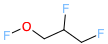

FCC(F)COF
Entry
CHOF_G4
FCC(F)COF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.592,146.378,164.897,180.528,204.519,220.903,241.932],'J/(mol*K)'), H298=(-515.567,'kJ/mol'), S298=(349.426,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.2677,73.957,80.4702,85.6792,93.7132,98.7652,104.445],'J/(mol*K)'), H298=(-245.184,'kJ/mol'), S298=(190.035,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F))""")

missing
['Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([66.5119,74.5931,80.3492,85.1833,93.0395,97.8835,102.967],'J/(mol*K)'), H298=(-259.517,'kJ/mol'), S298=(190.08,'J/(mol*K)'), comment="""T

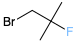

CC(C)(F)CBr
Entry
CHOFBr_G4
CC(C)(F)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.211,151.854,173.224,191.673,221.102,242.534,273.786],'J/(mol*K)'), H298=(-328.912,'kJ/mol'), S298=(368.134,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.3019,88.7907,97.8763,105.145,115.976,122.563,129.35],'J/(mol*K)'), H298=(-246.822,'kJ/mol'), S298=(127.302,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + missing(Cs-CsHHH) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.5177,89.7879,98.5951,105.805,116.592,122.954,128.866],'J/(mol*K)'), H298=(-256.956,'kJ/mol'), S298=(123.876,'J/(mol*K)'),

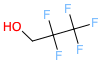

OCC(F)(F)C(F)(F)F
Entry
CHOF_G4
OCC(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.228,167.971,184.159,197.621,217.917,231.351,247.5],'J/(mol*K)'), H298=(-1302.8,'kJ/mol'), S298=(400.288,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.952312,-0.940249,-0.44155,-0.173174,-0.0885042,0.154087,1.51887],'J/(mol*K)'), H298=(42.3898,'kJ/mol'), S298=(1.23249,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
Ther

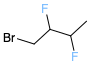

CC(F)C(F)CBr
Entry
CHOFBr_G4
CC(F)C(F)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.903,166.98,189.856,208.152,236.571,256.464,282.995],'J/(mol*K)'), H298=(-502.242,'kJ/mol'), S298=(390.603,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.051,131.81,148.083,161.032,180.348,193.127,208.969],'J/(mol*K)'), H298=(-460.686,'kJ/mol'), S298=(260.827,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([113.511,133.443,148.681,161.196,180.291,192.63

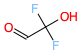

O=CC(O)(F)F
Entry
CHOF_G4
ODCC(O)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.1369,112.299,127.127,137.758,152.666,161.374,168.226],'J/(mol*K)'), H298=(-766.677,'kJ/mol'), S298=(314.512,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([2.31397,1.50465,1.00198,0.427023,-0.190688,-0.528904,0.276867],'J/(mol*K)'), H298=(23.8196,'kJ/mol'), S298=(0.892644,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-COF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + missing(CO-CsO2dH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCFFO_Cs-COF1sF1sO2s', 'Cds-OdCsH_CO-CsO2dH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.3506,1

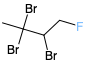

CC(Br)(Br)C(Br)CF
Entry
CHOFBr_G4
CC(Br)(Br)C(Br)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([163.957,188.331,208.753,225.826,251.613,268.762,289.783],'J/(mol*K)'), H298=(-252.083,'kJ/mol'), S298=(444.504,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.8056,109.011,117.907,124.547,133.529,138.064,140.643],'J/(mol*K)'), H298=(14.7606,'kJ/mol'), S298=(176.543,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsCs) + longDistanceInteraction_noncyclic(Cs(Br)2-Cs(Br)) + group(CsBrCsCsH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([100.253,112.056,119.945,126.121,134.694,138.656,139.

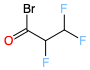

O=C(Br)C(F)C(F)F
Entry
CHOFBr_G4
ODC(Br)C(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.531,140.748,154.365,165.698,182.677,193.807,207.021],'J/(mol*K)'), H298=(-764.757,'kJ/mol'), S298=(413.049,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.1044,88.5064,97.0416,103.816,113.594,119.97,127.227],'J/(mol*K)'), H298=(-322.61,'kJ/mol'), S298=(238.781,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCFH) + longDistanceInteraction_noncyclic(Cs(F)-CO) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(COBrCsO)""")

missing
['CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.133,86.4527,94.7827,101.836,112.188,118.914,125.02],'J/(mol*K)'), H298=(-354.23,'kJ/mol'), S298=(239.595,'J/(mol*K)'), comment="""Thermo group additivity estimat

FC=CC=CF
Entry
CHOF_G4
FCDCCDCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.4413,117.296,135.429,149.629,171.166,185.696,203.781],'J/(mol*K)'), H298=(-269.921,'kJ/mol'), S298=(316.562,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3213,48.4507,56.484,62.0906,69.8728,75.2283,83.5126],'J/(mol*K)'), H298=(56.735,'kJ/mol'), S298=(53.3878,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + missing(Cd-CdF1sH) + missing(Cd-CdF1sH)""")

missing
['CdCFH_Cd-CdF1sH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3213,48.4507,56.484,62.0906,69.8728,75.2283,83.5126],'J/(mol*K)'), H298=(56.735,'kJ/mol'), S298=(53.3878,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H)""")



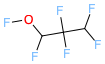

FOC(F)C(F)(F)C(F)F
Entry
CHOF_G4
FOC(F)C(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([151.098,176.096,195.452,210.33,230.504,242.716,257.16],'J/(mol*K)'), H298=(-1133,'kJ/mol'), S298=(421.461,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.7199,72.903,81.8337,88.126,96.4346,101.763,108.353],'J/(mol*K)'), H298=(-236.496,'kJ/mol'), S298=(187.17,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + group(CsCFHO) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.412,76.3391,83.8654,89.6141,97.7164,102.299,105.894],'J/(mol*

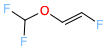

FC=COC(F)F
Entry
CHOF_G4
FCDCOC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.691,128.969,142.89,154.641,172.687,185.048,201.179],'J/(mol*K)'), H298=(-724.053,'kJ/mol'), S298=(361.074,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3531,46.5727,53.1413,57.5213,61.6931,63.7577,65.8456],'J/(mol*K)'), H298=(-88.638,'kJ/mol'), S298=(51.1009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sF1sO2sH) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CsFFHO_Cs-F1sF1sO2sH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimation: grou

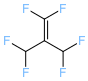

FC(F)=C(C(F)F)C(F)F
Entry
CHOF_G4
FC(F)DC(C(F)F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([150.462,172.852,189.822,203.069,222.696,236.197,253.563],'J/(mol*K)'), H298=(-1187.26,'kJ/mol'), S298=(424.61,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sF1sH) + missing(Cs-CdF1sF1sH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s)""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'CsCFFH_Cs-CdF1sF1sH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group

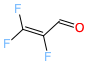

O=CC(F)=C(F)F
Entry
CHOF_G4
ODCC(F)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.809,110.291,122.459,132.589,147.749,157.63,168.905],'J/(mol*K)'), H298=(-606.463,'kJ/mol'), S298=(339.636,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.7328,67.4728,75.512,82.1927,92.1948,98.1053,102.488],'J/(mol*K)'), H298=(-249.623,'kJ/mol'), S298=(183.958,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CdCCF) + longDistanceInteraction_noncyclic(Cd(F)-CO) + group(Cds-O2d(Cds-Cds)H) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.5682,70.7375,78.2965,84.6466,94.5898,99.788,100.1],'J/(mol*K)'), H298=(-294.229,'kJ/mol'), S298=(185.158,'J/(mol*K)'), comment="""Thermo group additivity estimatio

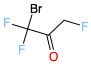

O=C(CF)C(F)(F)Br
Entry
CHOFBr_G4
ODC(CF)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.869,142.138,155.153,166.007,182.505,193.569,207.15],'J/(mol*K)'), H298=(-725.493,'kJ/mol'), S298=(412.35,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([69.6758,74.8666,77.9033,80.0257,83.0154,84.3908,85.8681],'J/(mol*K)'), H298=(-374.48,'kJ/mol'), S298=(204.274,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-COF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-CO) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-CO) + missing(CO-CsCsO2d)""")

missing
['CsCFHH_Cs-COF1sHH', 'Cds-OdCsCs_CO-CsCsO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.4801,68.9301,73.4309,76.9693,82.0294,84.9222,86.0569],'J/(mol*K)'), H298=(-417.595,'kJ/mol'), S298=(201.362,'J/(mol*K)'), comment="""The

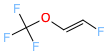

FC=COC(F)(F)F
Entry
CHOF_G4
FCDCOC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([112.742,132.656,148.921,161.857,179.696,191.098,206.473],'J/(mol*K)'), H298=(-959.136,'kJ/mol'), S298=(373.639,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.3531,46.5727,53.1413,57.5213,61.6931,63.7577,65.8456],'J/(mol*K)'), H298=(-88.638,'kJ/mol'), S298=(51.1009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sF1sF1sO2s) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CsFFFO_Cs-F1sF1sF1sO2s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estim

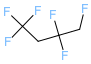

FCC(F)(F)CC(F)(F)F
Entry
CHOF_G4
FCC(F)(F)CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([164.197,193.487,214.318,231.402,256.955,273.623,292.955],'J/(mol*K)'), H298=(-1383.8,'kJ/mol'), S298=(417.078,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.2346,-0.636123,0.0552886,0.275793,0.299765,0.514653,1.37234],'J/(mol*K)'), H298=(19.5573,'kJ/mol'), S298=(0.811252,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsCsHH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV

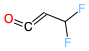

O=C=CC(F)F
Entry
CHOF_G4
ODCDCC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([85.8678,100.591,112.312,121.768,136.499,146.855,160.763],'J/(mol*K)'), H298=(-470.652,'kJ/mol'), S298=(330.723,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.83,50.1,55.5,60.05,67.09,72.13,79.55],'J/(mol*K)'), H298=(-17.6,'kJ/mol'), S298=(169.15,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2d-Cdd) + missing(Cs-CdF1sF1sH) + group(Cds-(Cdd-O2d)CsH) + missing(Cdd-CdO2d)""")

missing
['CsCFFH_Cs-CdF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.83,50.1,55.5,60.05,67.09,72.13,79.55],'J/(mol*K)'), H298=(-17.6,'kJ/mol'), S298=(169.15,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-(Cdd-O2d)CsH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpd

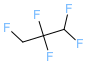

FCC(F)(F)C(F)F
Entry
CHOF_G4
FCC(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.762,151.164,167.323,180.283,199.879,212.896,228.499],'J/(mol*K)'), H298=(-1094.42,'kJ/mol'), S298=(375.049,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-3.69212,-3.43615,-2.03165,-1.48812,-1.28179,-0.536142,2.45897],'J/(mol*K)'), H298=(50.931,'kJ/mol'), S298=(4.02198,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'

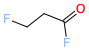

O=C(F)CCF
Entry
CHOF_G4
ODC(F)CCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.0073,111.932,126.645,139.475,160.075,175.157,196.841],'J/(mol*K)'), H298=(-636.946,'kJ/mol'), S298=(349.695,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.91,30.8,34.98,38.91,45.56,50.73,58.93],'J/(mol*K)'), H298=(-21.5,'kJ/mol'), S298=(40.32,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH) + missing(Cs-CsF1sHH) + missing(CO-CsF1sO2d)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.91,30.8,34.98,38.91,45.56,50.73,58.93],'J/(mol*K)'), H298=(-21.5,'kJ/mol'), S298=(40.32,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpd

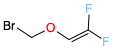

FC(F)=COCBr
Entry
CHOFBr_G4
FC(F)DCOCBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.473,129.185,144.801,157.722,176.952,189.517,204.847],'J/(mol*K)'), H298=(-446.237,'kJ/mol'), S298=(391.034,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.4761,94.1339,106.955,116.448,128.19,135.389,145.104],'J/(mol*K)'), H298=(-104.099,'kJ/mol'), S298=(218.029,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrHHO) + group(Cds-CdsOsH) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.4959,97.868,111.157,119.835,130.138,136.032,145.136],'J/(mol*K)'), H298=(-139.639,'kJ/mol'), S298=(209.875,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + g

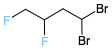

FCC(F)CC(Br)Br
Entry
CHOFBr_G4
FCC(F)CC(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.031,180.267,203.086,222.025,250.248,268.549,289.603],'J/(mol*K)'), H298=(-472.468,'kJ/mol'), S298=(389.194,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.0466,105.942,116.618,125.032,136.921,144.038,150.706],'J/(mol*K)'), H298=(-205.703,'kJ/mol'), S298=(249.545,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsCsHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrBrCsH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.2908,106.578,116.497,124.536,136.248,143.156,149.228],'J/(mol*K)'), H298=(-220.035,'kJ/mol'), S298=(249.59,'J/(mol*K)

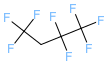

FC(F)(F)CC(F)(F)C(F)(F)F
Entry
CHOF_G4
FC(F)(F)CC(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([178.256,207.553,229.26,245.281,267.37,282.159,300.191],'J/(mol*K)'), H298=(-1822.79,'kJ/mol'), S298=(454.494,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.952312,-0.940249,-0.44155,-0.173174,-0.0885042,0.154087,1.51887],'J/(mol*K)'), H298=(42.3898,'kJ/mol'), S298=(1.23249,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sF1sF1s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'

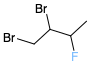

CC(F)C(Br)CBr
Entry
CHOFBr_G4
CC(F)C(Br)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([141.948,169.929,193.179,212.099,239.466,258.183,284.766],'J/(mol*K)'), H298=(-291.421,'kJ/mol'), S298=(411.372,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.359,137.123,153.464,166.434,185.45,197.567,211.841],'J/(mol*K)'), H298=(-252.738,'kJ/mol'), S298=(277.418,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsBrCsCsH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br)) + missing(Cs-CsHHH) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.597,139.392,154.524,166.91,185.463

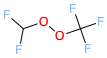

FC(F)OOC(F)(F)F
Entry
CHOF_G4
FC(F)OOC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.819,153.664,167.676,178.458,194.204,203.985,213.716],'J/(mol*K)'), H298=(-1230.98,'kJ/mol'), S298=(392.009,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.6352,36.0661,38.4928,40.5011,44.5178,48.5344,48.5344],'J/(mol*K)'), H298=(-45.1872,'kJ/mol'), S298=(71.4627,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + missing(Cs-F1sF1sO2sH) + missing(Cs-F1sF1sF1sO2s)""")

missing
['CsFFHO_Cs-F1sF1sO2sH', 'CsFFFO_Cs-F1sF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.6352,36.0661,38.4928,40.5011,44.5178,48.5344,48.5344],'J/(mol*K)'), H298=(-45.1872,'kJ/mol'), S298=(71.4627,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs)

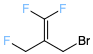

FCC(CBr)=C(F)F
Entry
CHOFBr_G4
FCC(CBr)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.266,161.437,179.144,193.683,215.751,230.525,248.635],'J/(mol*K)'), H298=(-560.337,'kJ/mol'), S298=(401.016,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.3507,66.7775,74.3606,80.606,90.3702,96.9613,105.008],'J/(mol*K)'), H298=(28.1395,'kJ/mol'), S298=(112.332,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + group(CsBrCHH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.3507,66.7775,74.3606,80.606,90.3702,96.9613,105.008],'J/(mol*K)'), H298=(28.1395,'kJ/mol'), S298=(112.332,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCHH) + group(Cds-CdsCsCs)""")

GAE with 

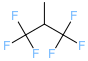

CC(C(F)(F)F)C(F)(F)F
Entry
CHOF_G4
CC(C(F)(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([154.905,184.075,205.62,223.255,250.108,268.175,290.494],'J/(mol*K)'), H298=(-1435.41,'kJ/mol'), S298=(407.217,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.4823,25.2219,31.1503,35.467,41.0328,44.3588,49.4999],'J/(mol*K)'), H298=(8.47486,'kJ/mol'), S298=(-54.1702,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K

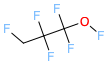

FCC(F)(F)C(F)(F)OF
Entry
CHOF_G4
FCC(F)(F)C(F)(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([158.154,181.991,198.117,211.005,229.911,241.79,254.246],'J/(mol*K)'), H298=(-1138.96,'kJ/mol'), S298=(417.307,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([27.2912,29.4254,31.9822,33.6223,35.931,37.9257,42.0745],'J/(mol*K)'), H298=(22.1656,'kJ/mol'), S298=(144.87,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.11

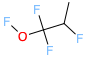

CC(F)C(F)(F)OF
Entry
CHOF_G4
CC(F)C(F)(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.101,160.176,177.309,191.497,213.067,227.551,245.435],'J/(mol*K)'), H298=(-771.127,'kJ/mol'), S298=(383.642,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.2773,73.957,80.4044,85.4591,93.3392,98.3981,104.339],'J/(mol*K)'), H298=(-239.959,'kJ/mol'), S298=(190.891,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(CsCsCsFH) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsHHH)""")

missing
['CsCFFO_Cs-CsF1sF1sO2s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([66.5119,74.5931,80.3492,85.1833,93.0395,97.8835,102.967],'J/(mol*K)'), H298=(-259.517,'kJ/mol'), S298=(190.08,'J/(mol*K)'), comment="""Thermo group additivity estimation: g

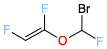

FC=C(F)OC(F)Br
Entry
CHOFBr_G4
FCDC(F)OC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.727,146.784,159.394,169.171,183.824,193.969,207.17],'J/(mol*K)'), H298=(-640.58,'kJ/mol'), S298=(412.007,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.0985,113.843,123.985,131.513,141.506,146.889,151.131],'J/(mol*K)'), H298=(-499.329,'kJ/mol'), S298=(256.946,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrFHO) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.9013,113.136,123.579,131.2,141.374,146.869,151.638],'J/(mol*K)'), H298=(-524.514,'kJ/mol'), S298=(255.334,'J/(mol*K)'), comment="""Thermo group 

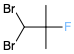

CC(C)(F)C(Br)Br
Entry
CHOFBr_G4
CC(C)(F)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([142.2,166.85,187.963,205.94,233.969,253.653,280.591],'J/(mol*K)'), H298=(-294.013,'kJ/mol'), S298=(413.539,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.1308,103.183,111.732,118.356,127.71,132.557,135.342],'J/(mol*K)'), H298=(-212.824,'kJ/mol'), S298=(167.768,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsHHH) + missing(Cs-CsHHH) + group(CsBrBrCsH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.8261,104.654,112.747,119.218,128.376,132.896,134.439],'J/(mol*K)'), H298=(-222.591,'kJ/mol'), S298=(165.251,'J/(mol*K)'), comment="""Thermo group additivity estimation: g

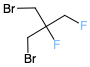

FCC(F)(CBr)CBr
Entry
CHOFBr_G4
FCC(F)(CBr)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([147.92,177.229,202.077,222.749,252.993,271.396,292.93],'J/(mol*K)'), H298=(-471.808,'kJ/mol'), S298=(427.823,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.296,137.137,153.288,166.031,184.67,196.847,211.616],'J/(mol*K)'), H298=(-246.005,'kJ/mol'), S298=(289.666,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated G

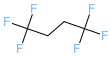

FC(F)(F)CCC(F)(F)F
Entry
CHOF_G4
FC(F)(F)CCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([155.308,186.055,209.685,227.432,253.394,271.093,293.186],'J/(mol*K)'), H298=(-1452.11,'kJ/mol'), S298=(412.245,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + missing(Cs-CsF1sF1sF1s) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([154.126,182.985,205.518,223.425,249.783,267.

O=C=CCF
Entry
CHOF_G4
ODCDCCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([79.0275,92.5374,104.144,114.087,129.743,140.905,156.535],'J/(mol*K)'), H298=(-250.445,'kJ/mol'), S298=(310.252,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.83,50.1,55.5,60.05,67.09,72.13,79.55],'J/(mol*K)'), H298=(-17.6,'kJ/mol'), S298=(169.15,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2d-Cdd) + missing(Cs-CdF1sHH) + group(Cds-(Cdd-O2d)CsH) + missing(Cdd-CdO2d)""")

missing
['CsCFHH_Cs-CdF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.83,50.1,55.5,60.05,67.09,72.13,79.55],'J/(mol*K)'), H298=(-17.6,'kJ/mol'), S298=(169.15,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-(Cdd-O2d)CsH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.7

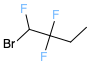

CCC(F)(F)C(F)Br
Entry
CHOFBr_G4
CCC(F)(F)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([150.636,174.539,194.964,212.311,239.243,258.028,283.434],'J/(mol*K)'), H298=(-713.538,'kJ/mol'), S298=(414.714,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([50.357,56.7021,62.5167,67.1435,73.9252,78.447,84.107],'J/(mol*K)'), H298=(-186.177,'kJ/mol'), S298=(183.983,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.7669,60.0534,65.4783,69.9172,76.2768,80.1299,83.611],'J/(mol*K)'), H298=(-

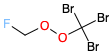

FCOOC(Br)(Br)Br
Entry
CHOFBr_G4
FCOOC(Br)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([140.053,157.004,170.897,182.127,198.044,207.384,215.419],'J/(mol*K)'), H298=(-238.492,'kJ/mol'), S298=(440.815,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.283,113.274,119.003,123.484,131.352,137.145,137.655],'J/(mol*K)'), H298=(14.008,'kJ/mol'), S298=(321.319,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + missing(Cs-F1sO2sHH) + group(CsBrBrBrO)""")

missing
['CsFHHO_Cs-F1sO2sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.283,113.274,119.003,123.484,131.352,137.145,137.655],'J/(mol*K)'), H298=(14.008,'kJ/mol'), S298=(321.319,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + group(CsBrBrBrO)""")

GAE with fitted

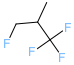

CC(CF)C(F)(F)F
Entry
CHOF_G4
CC(CF)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.663,162.033,185.137,204.208,232.559,252.713,281.755],'J/(mol*K)'), H298=(-976.826,'kJ/mol'), S298=(382.852,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH)"""

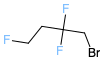

FCCC(F)(F)CBr
Entry
CHOFBr_G4
FCCC(F)(F)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.486,179.98,200.97,218.645,245.67,264.02,287.397],'J/(mol*K)'), H298=(-717.174,'kJ/mol'), S298=(411.47,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.7585,48.5087,54.9948,60.1883,67.9722,73.454,81.2061],'J/(mol*K)'), H298=(-13.8815,'kJ/mol'), S298=(161.501,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsF1sHH) + group(CsBrCsHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.4538,49.98,56.01,61.0504,68.6377,73.7924,80.3031],'J/(mol*K)'), H298=(-23.649,'kJ/mol'), S298=(158.984,'J/(mol*K)'), comment="""Thermo 

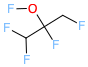

FCC(F)(OF)C(F)F
Entry
CHOF_G4
FCC(F)(OF)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.438,172.634,193.155,208.747,228.787,240.726,255.307],'J/(mol*K)'), H298=(-924.144,'kJ/mol'), S298=(399.89,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([28.5045,31.5892,34.1902,35.8821,38.1863,39.8583,42.4659],'J/(mol*K)'), H298=(5.12419,'kJ/mol'), S298=(141.614,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCCFO_Cs-CsCsF1sO2s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38

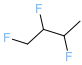

CC(F)C(F)CF
Entry
CHOF_G4
CC(F)C(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.203,158.093,180.318,199.289,228.988,249.974,278.94],'J/(mol*K)'), H298=(-706.568,'kJ/mol'), S298=(367.063,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([68.5689,82.1909,92.9126,101.138,113.001,120.607,129.659],'J/(mol*K)'), H298=(-432.838,'kJ/mol'), S298=(98.3724,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.0572,83.4632,92.6706,100.146,111

CCCCF
Entry
CHOF_G4
CCCCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.484,130.774,153.331,173.332,205.976,230.516,267.71],'J/(mol*K)'), H298=(-310.77,'kJ/mol'), S298=(343.228,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.162,135.455,158.055,177.615,209.115,232.762,269.146],'J/(mol*K)','+|-',[0.662027,0.6920

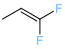

CC=C(F)F
Entry
CHOF_G4
CCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([81.2494,97.0553,110.835,122.775,141.914,155.911,176.145],'J/(mol*K)'), H298=(-375.354,'kJ/mol'), S298=(306.222,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(203.705,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdH)CdHHH', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.3454,97.7313,111.679,123.631,142.34,156.151,176.278],'J/(mol*K)','+|-',[1.18595,1.23972,1.16233,1.07926,0.935723,

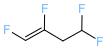

FC=C(F)CC(F)F
Entry
CHOF_G4
FCDC(F)CC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.736,147.89,166.219,181.805,206.016,222.861,245.093],'J/(mol*K)'), H298=(-781.061,'kJ/mol'), S298=(391.943,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([22.6192,29.4101,35.2172,40.0184,47.0763,52.2361,59.5756],'J/(mol*K)'), H298=(5.26866,'kJ/mol'), S298=(42.6153,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CsF1sF1sH) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CdCsCdF_Cd-CdCsF1s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ

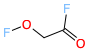

O=C(F)COF
Entry
CHOF_G4
ODC(F)COF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.7162,107.883,119.055,127.742,140.265,148.987,160.578],'J/(mol*K)'), H298=(-443.879,'kJ/mol'), S298=(341.987,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.7333,67.2315,74.7839,80.4804,88.4128,93.4219,100.406],'J/(mol*K)'), H298=(-48.5654,'kJ/mol'), S298=(172.389,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(Cs-(Cds-O2d)OsHH) + missing(CO-CsF1sO2d)""")

missing
['COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.7333,67.2315,74.7839,80.4804,88.4128,93.4219,100.406],'J/(mol*K)'), H298=(-48.5654,'kJ/mol'), S298=(172.389,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(Cs-(Cds-O2d)OsHH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,60

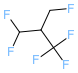

FCC(C(F)F)C(F)(F)F
Entry
CHOF_G4
FCC(C(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([158.425,184.81,205.97,223.295,249.716,267.803,290.809],'J/(mol*K)'), H298=(-1362.94,'kJ/mol'), S298=(425.813,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.4742,24.9304,30.573,34.469,39.4849,42.6723,47.6715],'J/(mol*K)'), H298=(4.04538,'kJ/mol'), S298=(-52.9187,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), c

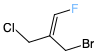

FC=C(CCl)CBr
Entry
CHOFClBr_G4
FCDC(CCl)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.617,157.625,175.153,189.592,211.489,226.18,244.715],'J/(mol*K)'), H298=(-202.049,'kJ/mol'), S298=(392.01,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.8648,112.389,126.001,137.448,155.092,167.38,182.524],'J/(mol*K)'), H298=(-31.4788,'kJ/mol'), S298=(266.38,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCClHH) + group(CsBrCHH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.8648,112.389,126.001,137.448,155.092,167.38,182.524],'J/(mol*K)'), H298=(-31.4788,'kJ/mol'), S298=(266.38,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCClHH) + group(CsBrCHH) + group(Cds-CdsCsCs)""")

GAE with fitted GAV
Thermo

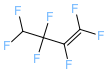

FC(F)=C(F)C(F)(F)C(F)F
Entry
CHOF_G4
FC(F)DC(F)C(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([160.781,184.314,201.644,214.708,233.18,245.325,259.501],'J/(mol*K)'), H298=(-1337.01,'kJ/mol'), S298=(441.573,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0.123386,-0.660276,-0.554984,-0.615691,-1.07304,-0.733717,1.94049],'J/(mol*K)'), H298=(87.8824,'kJ/mol'), S298=(4.31464,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cd-CdCsF1s) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH', 'CdCsCdF_Cd-CdCsF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated 

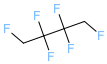

FCC(F)(F)C(F)(F)CF
Entry
CHOF_G4
FCC(F)(F)C(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([159.648,188.593,210.589,227.43,252.806,270.216,292.347],'J/(mol*K)'), H298=(-1305.54,'kJ/mol'), S298=(425.3,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-4.92672,-4.07227,-1.97636,-1.21233,-0.982022,-0.021489,3.83131],'J/(mol*K)'), H298=(70.4883,'kJ/mol'), S298=(4.83323,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
Thermo

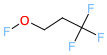

FOCCC(F)(F)F
Entry
CHOF_G4
FOCCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([130.895,153.812,172.492,187.643,209.802,224.436,244.597],'J/(mol*K)'), H298=(-798.456,'kJ/mol'), S298=(391.961,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.7654,'kJ/mol'), S298=(140.849,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsHH) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.7654,'kJ/mol'), S298=(140.849,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF)""")

GAE

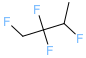

CC(F)C(F)(F)CF
Entry
CHOF_G4
CC(F)C(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([148.668,177.7,198.05,214.97,241.057,259.068,283.144],'J/(mol*K)'), H298=(-926.716,'kJ/mol'), S298=(380.891,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.0594,40.4593,46.4459,50.6244,56.4262,60.4509,66.0963],'J/(mol*K)'), H298=(-191.637,'kJ/mol'), S298=(50.854,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.0729,55.8267,59.4216,63.3516],'J/(mol*K)'), H298=(-230.751,'kJ/mol'),

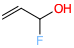

C=CC(O)F
Entry
CHOF_G4
CDCC(O)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.6693,114.428,128.724,140.971,160.283,174.103,193.746],'J/(mol*K)'), H298=(-354.196,'kJ/mol'), S298=(316.869,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.4287,43.4776,49.8515,54.5037,60.5036,63.8374,66.2787],'J/(mol*K)'), H298=(-258.661,'kJ/mol'), S298=(42.2994,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(CsCFHO) + missing(Cd-CdCsH) + missing(Cd-CdHH)""")

missing
['O2s-CsH_O2s-CsH', 'Cds-CdsCsH_Cd-CdCsH', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.4287,43.4776,49.8515,54.5037,60.5036,63.8374,66.2787],'J/(mol*K)'), H298=(-258.661,'kJ/mol'), S298=(42.2994,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCFHO)""")

GAE with fitted GAV
ThermoDat

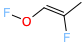

CC(F)=COF
Entry
CHOF_G4
CC(F)DCOF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.117,119.239,134.688,147.771,167.97,181.906,200.198],'J/(mol*K)'), H298=(-230.322,'kJ/mol'), S298=(304.749,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.2664,56.1142,61.8951,66.7117,73.4059,77.6996,82.7411],'J/(mol*K)'), H298=(6.49662,'kJ/mol'), S298=(173.039,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CdHHH) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cd(F)=CdOs) + group(Cds-CdsOsH)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdF1s)CdHHH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([50.8573,59.8902,65.9796,70.0468,75.2872,78.4609,83.3802],'J/(mol*K)'), H298=(-20.2719,'kJ/mol'), S298=(166.789,'J/(mol*K)'), comment="""Thermo group additivity estimation: gro

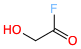

O=C(F)CO
Entry
CHOF_G4
ODC(F)CO
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.2414,100.946,113.377,123.184,137.918,147.594,158.898],'J/(mol*K)'), H298=(-580.039,'kJ/mol'), S298=(306.757,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.75,34.37,40.77,45.37,51.2,54.96,60.79],'J/(mol*K)'), H298=(-19.8,'kJ/mol'), S298=(31.54,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(Cs-(Cds-O2d)OsHH) + missing(CO-CsF1sO2d)""")

missing
['O2s-CsH_O2s-CsH', 'COCsFO_CO-CsF1sO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.75,34.37,40.77,45.37,51.2,54.96,60.79],'J/(mol*K)'), H298=(-19.8,'kJ/mol'), S298=(31.54,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)OsHH)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([85

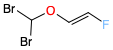

FC=COC(Br)Br
Entry
CHOFBr_G4
FCDCOC(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.528,140.284,156.213,168.919,186.8,197.625,209.84],'J/(mol*K)'), H298=(-227.044,'kJ/mol'), S298=(402.398,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.5727,109.681,121.553,129.995,139.987,145.163,149.919],'J/(mol*K)'), H298=(-78.1152,'kJ/mol'), S298=(257.411,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrBrHO) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.1636,113.457,125.638,133.33,141.868,145.925,150.558],'J/(mol*K)'), H298=(-104.884,'kJ/mol'), S298=(251.161,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group

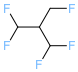

FCC(C(F)F)C(F)F
Entry
CHOF_G4
FCC(C(F)F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([154.971,181.59,202.246,219.605,246.251,264.445,287.759],'J/(mol*K)'), H298=(-1125.78,'kJ/mol'), S298=(410.145,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sH)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(mol*K)'), H298=(-7.9496,'kJ/mol'), S298=(-50.5009,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH

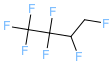

FCC(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
FCC(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([170.91,198.182,219.301,236.045,260.829,277.324,296.967],'J/(mol*K)'), H298=(-1533.34,'kJ/mol'), S298=(441.43,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([32.0975,39.5191,46.0701,50.6714,56.7117,60.9721,67.7208],'J/(mol*K)'), H298=(-154.472,'kJ/mol'), S298=(51.2299,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600

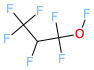

FOC(F)(F)C(F)C(F)(F)F
Entry
CHOF_G4
FOC(F)(F)C(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([164.685,192.348,210.441,223.009,240.883,251.556,260.812],'J/(mol*K)'), H298=(-1372.6,'kJ/mol'), S298=(432.358,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([65.0765,74.6014,81.9393,87.127,94.5045,99.5327,106.334],'J/(mol*K)'), H298=(-200.154,'kJ/mol'), S298=(187.616,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(CsCsCsFH) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCFFO_Cs-CsF1sF1sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([66.5119,74.5931,80.3492,85.1833,93.0395,97.88

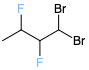

CC(F)C(F)C(Br)Br
Entry
CHOFBr_G4
CC(F)C(F)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([152.846,181.259,204.483,223.275,250.328,267.452,290.234],'J/(mol*K)'), H298=(-465.973,'kJ/mol'), S298=(426.527,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.88,146.202,161.938,174.243,192.083,203.121,214.961],'J/(mol*K)'), H298=(-426.687,'kJ/mol'), S298=(301.293,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsHHH) + group(CsBrBrCsH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.819,148.309,162.832,174.609,192.074,202.578,212.58],'J/(mol*K)'), H298=(-450.787,'kJ/m

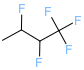

CC(F)C(F)C(F)(F)F
Entry
CHOF_G4
CC(F)C(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.895,175.566,198.603,216.73,243.354,262.117,287.482],'J/(mol*K)'), H298=(-1155.89,'kJ/mol'), S298=(400.985,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([70.1334,83.645,93.7527,101.522,112.961,120.236,129.239],'J/(mol*K)'), H298=(-419.359,'kJ/mol'), S298=(97.5607,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.0572,83.4632,92.6706,100.146,111.653,118.843,126.703],'J/(mol

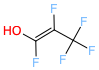

OC(F)=C(F)C(F)(F)F
Entry
CHOF_G4
OC(F)DC(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.937,154.842,167.628,177.942,192.799,201.845,210.853],'J/(mol*K)'), H298=(-1150.46,'kJ/mol'), S298=(382.645,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.7927,59.73,65.8779,69.7857,74.5405,77.8787,82.1608],'J/(mol*K)'), H298=(-306.079,'kJ/mol'), S298=(165.155,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cds(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=(

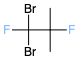

CC(C)(F)C(F)(Br)Br
Entry
CHOFBr_G4
CC(C)(F)C(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.28,177.249,197.718,215.088,242.005,260.706,285.669],'J/(mol*K)'), H298=(-477.151,'kJ/mol'), S298=(430.085,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.024,114.065,120.725,125.809,133.087,136.6,137.416],'J/(mol*K)'), H298=(-391.08,'kJ/mol'), S298=(189.069,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsHHH) + missing(Cs-CsHHH) + group(CsBrBrCF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.164,115.237,121.598,126.501,133.558,136.849,136.256],'J/(mol*K)'), H298=(-403.336,'kJ/mol'), S298=(185.442,'J/(mol*K)'), comment="""Thermo group additivity estimat

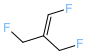

FC=C(CF)CF
Entry
CHOF_G4
FCDC(CF)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.468,141.425,159.425,174.801,198.907,215.994,239.809],'J/(mol*K)'), H298=(-559.576,'kJ/mol'), S298=(366.449,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + missing(Cs-CdF1sHH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CsCFHH_Cs-CdF1sHH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-CdsCsCs)""")

GAE with f

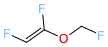

FC=C(F)OCF
Entry
CHOF_G4
FCDC(F)OCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.927,125.822,140.637,152.865,171.272,183.924,201.712],'J/(mol*K)'), H298=(-674.25,'kJ/mol'), S298=(366.733,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([47.3846,54.8227,59.6289,62.9912,66.7296,68.4513,68.4976],'J/(mol*K)'), H298=(-273.672,'kJ/mol'), S298=(74.0764,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sO2sHH) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CsFHHO_Cs-F1sO2sHH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.1875,54.1148,59.2226,62.679,66.5978,68.4315,69.0042],'J/(mol*K)'), H298=(-298.857,'kJ/mol'), S298=(72.4644,'J/(mol*K)'), comm

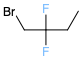

CCC(F)(F)CBr
Entry
CHOFBr_G4
CCC(F)(F)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([142.313,169.545,190.39,208.045,235.399,254.426,280.149],'J/(mol*K)'), H298=(-537.469,'kJ/mol'), S298=(388.848,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.7585,48.5087,54.9948,60.1883,67.9722,73.454,81.2061],'J/(mol*K)'), H298=(-13.8815,'kJ/mol'), S298=(161.501,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrCsHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.4538,49.98,56.01,61.0504,68.6377,73.7924,80.3031],'J/(mol*K)'), H298=(-23.649,'kJ/mol'), S298=(158.984,'J/(mol*K)'), comment="""Thermo g

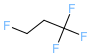

FCCC(F)(F)F
Entry
CHOF_G4
FCCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.181,130.411,148.594,163.037,185.063,200.69,221.959],'J/(mol*K)'), H298=(-947.814,'kJ/mol'), S298=(355.181,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sF1s)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([113.514,135.377,152.977,167.228,188.579,203.435,223.439],'J/(mol*K)','+|-',[0.547852,0.57269,0.536939,0.498565,

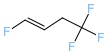

FC=CCC(F)(F)F
Entry
CHOF_G4
FCDCCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.92,147.945,167.353,182.749,206.105,222.668,245.198],'J/(mol*K)'), H298=(-850.002,'kJ/mol'), S298=(377.253,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CsF1sF1sF1s) + missing(Cd-CdCsH) + missing(Cd-CdF1sH)""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-C

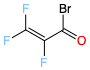

O=C(Br)C(F)=C(F)F
Entry
CHOFBr_G4
ODC(Br)C(F)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([115.821,130.099,140.513,148.95,160.951,168.033,174.116],'J/(mol*K)'), H298=(-606.698,'kJ/mol'), S298=(378.818,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([72.7713,82.1691,88.9932,94.3284,101.317,105.616,109.857],'J/(mol*K)'), H298=(-245.171,'kJ/mol'), S298=(226.313,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CdCCF) + longDistanceInteraction_noncyclic(Cd(F)-CO) + group(COBrCO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.6067,85.4338,91.7778,96.7823,103.712,107.298,107.469],'J/(mol*K)'), H298=(-289.778,'kJ/mol'), S298=(227.513,'J/(mol*K)'), comment="""Thermo group additivity estim

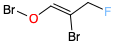

FCC(Br)=COBr
Entry
CHOFBr_G4
FCC(Br)DCOBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.529,133.803,147.777,159.557,177.585,189.811,205.095],'J/(mol*K)'), H298=(-137.07,'kJ/mol'), S298=(417.703,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.586,92.0337,100.071,106.757,116.902,123.15,130.221],'J/(mol*K)'), H298=(80.4803,'kJ/mol'), S298=(269.154,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + missing(Cs-CdF1sHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cds(Val7)) + group(CdBrCsCd) + longDistanceInteraction_noncyclic(Cd(Br)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCFHH_Cs-CdF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([87.6989,99.1768,107.176,112.63,119.924,124.098,129.648],'J/(mol*K)'), H298=(50.8905,'kJ/mol'), S298=(260.261,'J/(mol*K)'), comment="""Thermo group ad

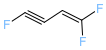

FC#CC=C(F)F
Entry
CHOF_G4
FC#CCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.2394,113.109,124.242,133.531,147.56,156.878,168.172],'J/(mol*K)'), H298=(-218.285,'kJ/mol'), S298=(338.736,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([29.4135,39.0367,42.886,51.6306,57.279,60.6262,66.0235],'J/(mol*K)'), H298=(146.356,'kJ/mol'), S298=(53.597,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-CdsCtH) + missing(Cd-CdF1sF1s) + group(Ct-Ct(Cds-Cds)) + missing(Ct-CtF1s)""")

missing
['CdCFF_Cd-CdF1sF1s', 'CtCF_Ct-CtF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([29.4135,39.0367,42.886,51.6306,57.279,60.6262,66.0235],'J/(mol*K)'), H298=(146.356,'kJ/mol'), S298=(53.597,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-CdsCtH) + group(Ct-Ct(Cds-Cds))""")

GAE with fitted 

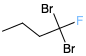

CCCC(F)(Br)Br
Entry
CHOFBr_G4
CCCC(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([143.191,168.164,188.639,205.679,232.434,252.09,280.892],'J/(mol*K)'), H298=(-270.851,'kJ/mol'), S298=(404.025,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([70.1004,75.4296,79.0127,81.7462,85.6038,87.6879,87.6937],'J/(mol*K)'), H298=(-170.029,'kJ/mol'), S298=(220.55,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + group(CsBrBrCF)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([70.1004,75.4296,79.0127,81.7462,85.6038,87.6879,87.6937],'J/(mol*K)'), H298=(-170.029,'kJ/mol'), S298=(220.55,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCF)""")

GAE with

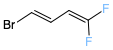

FC(F)=CC=CBr
Entry
CHOFBr_G4
FC(F)DCCDCBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.45,130.306,148.548,162.967,182.104,194.324,210.154],'J/(mol*K)'), H298=(-263.322,'kJ/mol'), S298=(364.454,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([72.4907,88.2332,100.352,109.188,122.113,131.013,144.253],'J/(mol*K)'), H298=(99.2562,'kJ/mol'), S298=(210.045,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + missing(Cd-CdF1sF1s) + group(CdBrCH)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([72.4907,88.2332,100.352,109.188,122.113,131.013,144.253],'J/(mol*K)'), H298=(99.2562,'kJ/mol'), S298=(210.045,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + group(CdBr

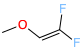

COC=C(F)F
Entry
CHOF_G4
COCDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.1415,110.946,126.016,139.017,159.709,174.678,195.916],'J/(mol*K)'), H298=(-462.249,'kJ/mol'), S298=(344.427,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.9243,46.6146,53.0237,57.4694,61.6257,63.8759,66.4527],'J/(mol*K)'), H298=(-79.866,'kJ/mol'), S298=(53.005,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-O2sHHH) + group(Cds-CdsOsH) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['Cs-OsHHH_Cs-O2sHHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O

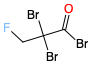

O=C(Br)C(Br)(Br)CF
Entry
CHOFBr_G4
ODC(Br)C(Br)(Br)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([139.292,154.863,167.691,178.216,193.56,203.09,212.82],'J/(mol*K)'), H298=(-311.954,'kJ/mol'), S298=(444.791,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.435,112.001,118.489,123.129,129.377,132.905,135.356],'J/(mol*K)'), H298=(-89.8476,'kJ/mol'), S298=(300.287,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCC) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Br)2-CO) + missing(Cs-CsF1sHH) + group(COBrCsO)""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.104,110.515,116.952,122.078,128.97,132.761,133.954],'J/(mol*K)'), H298=(-113.341,'kJ/mol'), S298=(301.097,'J/(mol*K)'), comment="""Thermo group additiv

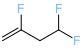

C=C(F)CC(F)F
Entry
CHOF_G4
CDC(F)CC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.512,138.649,157.204,173.109,198.157,215.98,240.569],'J/(mol*K)'), H298=(-615.094,'kJ/mol'), S298=(372.168,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CsF1sF1sH) + missing(Cd-CdCsF1s) + missing(Cd-CdHH)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CdCsCdF_Cd-CdCsF1s', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.4221,28.7022,34.8109,39.7062,46.9445,52.2163,60.0822],'J/(mol*K)'), H298=(-19.9158,'kJ/mol'), S298=(41.0032,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)Cs

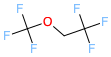

FC(F)(F)COC(F)(F)F
Entry
CHOF_G4
FC(F)(F)COC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([140.129,164.879,184.929,200.982,223.623,237.279,253.024],'J/(mol*K)'), H298=(-1556.48,'kJ/mol'), S298=(420.441,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([15.9473,15.2101,15.009,16.0697,18.5004,19.7506,21.0149],'J/(mol*K)'), H298=(-86.4524,'kJ/mol'), S298=(33.4834,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-CsOs) + missing(Cs-F1sF1sF1sO2s)""")

missing
['Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsFFFO_Cs-F1sF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.7,13.4,13.58,14.54,16.71,18.29,20.17],'J/(mol*K)'), H298=(-98.6,'kJ/mol'), S298=(38.61,'J/(mol*K)'), comment="""Thermo

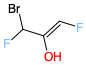

OC(=CF)C(F)Br
Entry
CHOFBr_G4
OC(DCF)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.716,138.372,154.354,166.28,182.661,193.697,207.329],'J/(mol*K)'), H298=(-483.521,'kJ/mol'), S298=(382.812,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([88.6593,101.999,112.19,120.422,132,139.14,146.32],'J/(mol*K)'), H298=(-320.058,'kJ/mol'), S298=(244.2,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.3875,109.432,119.086,125.242,134.001,139.077,144.354],'J/(mol*K)'), H298=(-377.406,'kJ/mol'), S298=(233.05,'J/(mol*K)'), comment="""Thermo group additi

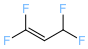

FC(F)=CC(F)F
Entry
CHOF_G4
FC(F)DCC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([103.736,118.935,131.835,142.703,159.331,170.63,184.997],'J/(mol*K)'), H298=(-772.291,'kJ/mol'), S298=(351.196,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(203.705,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sF1sH) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.091,117.846,131.267,142.517,159.499,171.055,185.605],'J/(mol*K)','+|-',[0.86209,0.901174,0.844917,0.784533,0.68

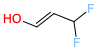

OC=CC(F)F
Entry
CHOF_G4
OCDCC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.752,120.812,135.436,147.856,167.133,180.549,198.469],'J/(mol*K)'), H298=(-558.628,'kJ/mol'), S298=(336.844,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.474,57.3286,64.4858,68.0864,71.3644,73.549,78.7346],'J/(mol*K)'), H298=(-179.606,'kJ/mol'), S298=(132.241,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sH) + missing(Cd-CdCsH) + group(Cds-CdsOsH)""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.474,57.3286,64.4858,68.0864,71.3644,73.549,78.7346],'J/(mol*K)'), H298=(-179.606,'kJ/mol'), S298=(132.241,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(Cds-CdsOsH)""")

GAE with

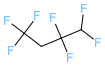

FC(F)C(F)(F)CC(F)(F)F
Entry
CHOF_G4
FC(F)C(F)(F)CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([175.796,201.915,221.443,237.64,261.762,277.398,295.442],'J/(mol*K)'), H298=(-1592.39,'kJ/mol'), S298=(442.363,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.45752,-2.80002,-2.08694,-1.76392,-1.58155,-1.05079,1.08663],'J/(mol*K)'), H298=(31.3737,'kJ/mol'), S298=(3.21073,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsCsHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sF1s)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H

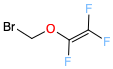

FC(F)=C(F)OCBr
Entry
CHOFBr_G4
FC(F)DC(F)OCBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([135.835,153.306,165.017,174.644,188.79,197.771,207.962],'J/(mol*K)'), H298=(-624.386,'kJ/mol'), S298=(401.324,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([88.3552,103.426,114.315,122.506,133.365,139.826,146.892],'J/(mol*K)'), H298=(-283.174,'kJ/mol'), S298=(238.878,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrHHO) + group(CdCFO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([85.7394,101.634,113.154,121.657,133.162,139.944,147.656],'J/(mol*K)'), H298=(-323.09,'kJ/mol'), S298=(237.488,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd))

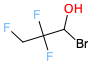

OC(Br)C(F)(F)CF
Entry
CHOFBr_G4
OC(Br)C(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([145.469,168.671,185.319,198.999,219.492,232.895,248.529],'J/(mol*K)'), H298=(-841.454,'kJ/mol'), S298=(408.517,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.6025,49.6562,56.0304,60.211,65.1448,67.9148,70.5654],'J/(mol*K)'), H298=(6.59164,'kJ/mol'), S298=(65.8331,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsBrCHO) + missing(Cs-CsF1sHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.5324,51.7636,56.9903,60.7973,65.5106,67.7385,68.29],'J/(mol*K)'), H298=(-22.7332,'kJ/

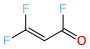

O=C(F)C=C(F)F
Entry
CHOF_G4
ODC(F)CDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.6136,109.103,122.861,133.82,148.42,157.271,168.631],'J/(mol*K)'), H298=(-716.377,'kJ/mol'), S298=(335.072,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.6959,65.2961,72.6975,78.9661,88.145,94.2629,101.95],'J/(mol*K)'), H298=(-330.455,'kJ/mol'), S298=(192.876,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COCFO) + missing(Cd-CdF1sF1s)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.6959,65.2961,72.6975,78.9661,88.145,94.2629,101.95],'J/(mol*K)'), H298=(-330.455,'kJ/mol'), S298=(192.876,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COCFO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,

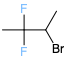

CC(Br)C(C)(F)F
Entry
CHOFBr_G4
CC(Br)C(C)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.406,162.063,183.786,202.297,231.195,251.523,279.395],'J/(mol*K)'), H298=(-550.812,'kJ/mol'), S298=(390.284,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.9189,46.2096,51.1635,54.9244,60.3331,63.499,66.9793],'J/(mol*K)'), H298=(-6.29504,'kJ/mol'), S298=(70.7426,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCsCsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.6143,47.6809,52.1787,55.7865,60.9985,63.8374,66.0762],'J/(mol*K)'), H298=(-16.0626,'kJ/mol'), S298=(68.2256,'J/(mol*K)'), comment="""

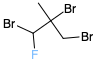

CC(Br)(CBr)C(F)Br
Entry
CHOFBr_G4
CC(Br)(CBr)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([165.151,189.704,209.711,226.464,251.844,268.826,290.012],'J/(mol*K)'), H298=(-263.787,'kJ/mol'), S298=(441.429,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([131.454,151.305,166.555,178.688,196.521,207.501,218.592],'J/(mol*K)'), H298=(-220.269,'kJ/mol'), S298=(317.776,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCC) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br)) + missing(Cs-CsHHH) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br)) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([135.172,154.049,167.911,179.365,196.583,206.933,216.064],'J/(mol*K)'), H298=(-237.627,

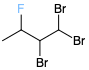

CC(F)C(Br)C(Br)Br
Entry
CHOFBr_G4
CC(F)C(Br)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([157.379,184.325,206.804,225.369,252.806,270.355,290.115],'J/(mol*K)'), H298=(-256.405,'kJ/mol'), S298=(439.89,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([131.458,151.214,166.638,178.749,196.081,206.402,216.572],'J/(mol*K)'), H298=(-215.952,'kJ/mol'), S298=(319.699,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsBrCsCsH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrBrCsH) + longDistanceInteraction_noncyclic(Cs(Br)2-Cs(Br))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.905,154.259,168.675,180.323,197.246,206.993,215.304],'J/(mol*K)'), H298=(-2

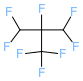

FC(F)C(F)(C(F)F)C(F)(F)F
Entry
CHOF_G4
FC(F)C(F)(C(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([182.881,213.989,236.405,252.304,274.233,288.448,304.078],'J/(mol*K)'), H298=(-1735.95,'kJ/mol'), S298=(449.176,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([31.8727,39.0065,44.8042,47.7619,50.2511,51.9481,54.2374],'J/(mol*K)'), H298=(-142.391,'kJ/mol'), S298=(-39.1778,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1

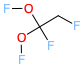

FCC(F)(OF)OF
Entry
CHOF_G4
FCC(F)(OF)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.758,158.499,170.507,179.856,193.098,200.905,208.115],'J/(mol*K)'), H298=(-545.301,'kJ/mol'), S298=(379.882,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([60.7225,65.0869,68.1488,70.7167,75.0993,77.8055,80.7091],'J/(mol*K)'), H298=(-43.1985,'kJ/mol'), S298=(281.652,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + group(O2sCF) + missing(Cs-CsF1sO2sO2s) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F))""")

missing
['CsCFOO_Cs-CsF1sO2sO2s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([61.9666,65.723,68.0277,70.2208,74.4256,76.9238,79.2311],'J/(mol*K)'), H298=(-57.5308,'kJ/mol'), S298=(281.697,'J/(mol*K)'), co

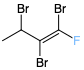

CC(Br)C(Br)=C(F)Br
Entry
CHOFBr_G4
CC(Br)C(Br)DC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([147.163,169.251,186.228,199.675,219.814,233.591,251.091],'J/(mol*K)'), H298=(-119.967,'kJ/mol'), S298=(442.745,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.797,134.665,144.814,152.774,164.148,170.884,176.594],'J/(mol*K)'), H298=(-72.1044,'kJ/mol'), S298=(320.995,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCH) + longDistanceInteraction_noncyclic(Cs(Br)-Cds(Br)) + missing(Cs-CsHHH) + group(CdBrCsCd) + group(CdBrCF) + longDistanceInteraction_noncyclic(Cds(Val7)2=Cds(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.872,133.361,143.525,151.403,163.045,169.926,175.615],'J/(mol*K)'), H298=(-95.2945,'kJ/mol'), S298=(323.19,'J/(mol*K)'), comment="

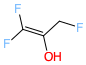

OC(CF)=C(F)F
Entry
CHOF_G4
OC(CF)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([118.683,137.823,151.259,162.387,179.104,190.13,203.524],'J/(mol*K)'), H298=(-699.74,'kJ/mol'), S298=(351.784,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.6373,45.9908,49.9334,53.234,57.6692,60.1516,63.281],'J/(mol*K)'), H298=(-119.985,'kJ/mol'), S298=(59.9903,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.6206,49.379,53.6074,55.3252,57.7246,58.9469,60.7434],'J/(mol*K)'), H298=(-175.422,'kJ/mol'), S298=(54.7531,'J/(mol*K)'), c

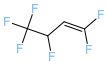

FC(F)=CC(F)C(F)(F)F
Entry
CHOF_G4
FC(F)DCC(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([145.819,172.059,191.642,205.942,226.327,239.906,255.937],'J/(mol*K)'), H298=(-1227.26,'kJ/mol'), S298=(409.957,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.8616,40.6024,45.6918,49.8434,55.7003,59.6281,63.4132],'J/(mol*K)'), H298=(-189.995,'kJ/mol'), S298=(49.5674,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCFH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.5412,39.7844,44.7307,48.9633,55.0669,59.1166,62.3554],'J/(mol*K)'), H298=(-217.806,'kJ/mol'), S298=(50.4243,'J/(mol*K)'), comme

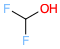

OC(F)F
Entry
CHOF_G4
OC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.5756,75.8094,84.3469,90.4826,99.5021,105.703,114.171],'J/(mol*K)'), H298=(-673.167,'kJ/mol'), S298=(277.594,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(128.874,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-F1sF1sO2sH)""")

missing
['O2s-CsH_O2s-CsH', 'CsFFHO_Cs-F1sF1sO2sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.6437,74.08,81.1615,87.234,96.8862,103.662,114.036],'J/(mol*K)','+|-',[0.621793,0.649983,0.609407,0.565854,0.490598,0.43565,0.842038]), H298=(-651.365,'kJ/mol','+|-',3.001

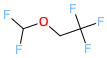

FC(F)OCC(F)(F)F
Entry
CHOF_G4
FC(F)OCC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.526,159.441,180.425,196.739,218.356,232.17,249.865],'J/(mol*K)'), H298=(-1322.11,'kJ/mol'), S298=(404.566,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([15.9473,15.2101,15.009,16.0697,18.5004,19.7506,21.0149],'J/(mol*K)'), H298=(-86.4524,'kJ/mol'), S298=(33.4834,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-CsOs) + missing(Cs-F1sF1sO2sH)""")

missing
['Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsFFHO_Cs-F1sF1sO2sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.7,13.4,13.58,14.54,16.71,18.29,20.17],'J/(mol*K)'), H298=(-98.6,'kJ/mol'), S298=(38.61,'J/(mol*K)'), comment="""Thermo group addi

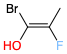

CC(F)=C(O)Br
Entry
CHOFBr_G4
CC(F)DC(O)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.966,123.74,137.272,148.819,166.894,179.68,197.497],'J/(mol*K)'), H298=(-313.054,'kJ/mol'), S298=(366.309,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([59.0376,67.0034,71.2623,73.8835,77.034,79.1224,81.2241],'J/(mol*K)'), H298=(-121.619,'kJ/mol'), S298=(184.307,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdHHH) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7)) + group(CdBrCO) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7))""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdF1s)CdHHH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.423,65.6604,70.4012,73.2331,76.7818,79.1171,82.0128],'J/(mol*K)'), H298=(-136.059,'kJ/mol'), S2

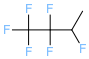

CC(F)C(F)(F)C(F)(F)F
Entry
CHOF_G4
CC(F)C(F)(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([163.234,190.147,210.596,227.681,253.487,270.635,291.49],'J/(mol*K)'), H298=(-1368.8,'kJ/mol'), S298=(414.956,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.3417,40.1552,45.949,50.1755,56.038,60.0903,66.2428],'J/(mol*K)'), H298=(-168.804,'kJ/mol'), S298=(51.2752,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.0729,55.8267,59.4216,63.3516],'J/(mol*K)'), H29

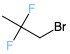

CC(F)(F)CBr
Entry
CHOFBr_G4
CC(F)(F)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.066,131.133,147.506,161.441,183.149,198.367,219.091],'J/(mol*K)'), H298=(-516.52,'kJ/mol'), S298=(362.875,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.7585,48.5087,54.9948,60.1883,67.9722,73.454,81.2061],'J/(mol*K)'), H298=(-13.8815,'kJ/mol'), S298=(161.501,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrCsHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.4538,49.98,56.01,61.0504,68.6377,73.7924,80.3031],'J/(mol*K)'), H298=(-23.649,'kJ/mol'), S298=(158.984,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCsHH)"""

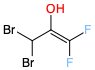

OC(=C(F)F)C(Br)Br
Entry
CHOFBr_G4
OC(DC(F)F)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.822,150.865,165.33,177.069,193.857,203.881,212.905],'J/(mol*K)'), H298=(-463.009,'kJ/mol'), S298=(425.973,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.507,108.331,116.607,123.554,133.377,139.752,146.506],'J/(mol*K)'), H298=(-103.451,'kJ/mol'), S298=(267.557,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsBrBrCH) + longDistanceInteraction_noncyclic(Cs(Br)2-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.7535,112.533,121.622,127.374,135.328,140.02,144.371],'J/(mol*K)'), H298=(-155.373,'kJ/mol'), S298=(260.542,'J/(mol*K)'), comment=""

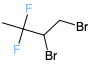

CC(F)(F)C(Br)CBr
Entry
CHOFBr_G4
CC(F)(F)C(Br)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([155.847,181.522,202.063,219.383,245.928,264.02,287.219],'J/(mol*K)'), H298=(-518.558,'kJ/mol'), S298=(429.523,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([80.3505,94.917,106.833,116.159,129.574,138.198,148.907],'J/(mol*K)'), H298=(-22.3528,'kJ/mol'), S298=(227.279,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + group(CsBrCsCsH) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br)) + missing(Cs-CsHHH) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br))""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.0681,97.6608,108.189,116.837,129.636,137.63,146.379

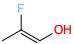

CC(F)=CO
Entry
CHOF_G4
CC(F)DCO
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.3275,114.371,130.503,143.127,162.665,176.304,194.867],'J/(mol*K)'), H298=(-348.264,'kJ/mol'), S298=(309.556,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.8831,53.5527,60.4013,64.7513,69.4831,72.7877,78.0956],'J/(mol*K)'), H298=(-152.838,'kJ/mol'), S298=(138.491,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdHHH) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cd(F)=CdOs) + group(Cds-CdsOsH)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdF1s)CdHHH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([44.474,57.3286,64.4858,68.0864,71.3644,73.549,78.7346],'J/(mol*K)'), H298=(-179.606,'kJ/mol'), S298=(132.241,'J/(mol*K)'), comment="""Thermo group additivity estimatio

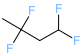

CC(F)(F)CC(F)F
Entry
CHOF_G4
CC(F)(F)CC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([147.843,173.612,193.867,211.059,237.735,256.343,281.665],'J/(mol*K)'), H298=(-977.403,'kJ/mol'), S298=(386.453,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.932,165.815,189.186,208.48,237.428,257.441,285.915],'J/(

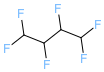

FC(F)C(F)C(F)C(F)F
Entry
CHOF_G4
FC(F)C(F)C(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([162.669,194.598,219.365,237.742,261.986,277.939,297.108],'J/(mol*K)'), H298=(-1313.13,'kJ/mol'), S298=(418.667,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([67.3438,81.5548,92.9022,101.193,112.927,120.754,130.926],'J/(mol*K)'), H298=(-408.056,'kJ/mol'), S298=(100.04,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.0572,

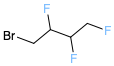

FCC(F)C(F)CBr
Entry
CHOFBr_G4
FCC(F)C(F)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([148.303,177.709,201.17,219.398,245.879,264.375,288.892],'J/(mol*K)'), H298=(-668.433,'kJ/mol'), S298=(411.489,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.807,131.174,148.204,161.528,181.022,194.009,210.447],'J/(mol*K)'), H298=(-446.354,'kJ/mol'), S298=(260.782,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoD

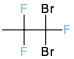

CC(F)(F)C(F)(Br)Br
Entry
CHOFBr_G4
CC(F)(F)C(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([139.045,157.63,173.088,185.896,204.927,217.204,231.175],'J/(mol*K)'), H298=(-654.348,'kJ/mol'), S298=(418.367,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([67.4174,72.8704,77.0742,80.0279,84.0659,86.5246,88.7866],'J/(mol*K)'), H298=(-150.649,'kJ/mol'), S298=(225.332,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + group(CsBrBrCF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([70.1004,75.4296,79.0127,81.7462,85.6038,87.6879,87.6937],'J/(mol*K)'), H298=(-170.029,'kJ/mol'), S298=(220.55,'J/(mol*K)'), comment="""Thermo group additivity estimation

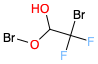

OC(OBr)C(F)(F)Br
Entry
CHOFBr_G4
OC(OBr)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([149.568,169.102,179.306,187.2,198.176,204.418,209.744],'J/(mol*K)'), H298=(-642.239,'kJ/mol'), S298=(413.172,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.28,134.77,147.104,154.922,165.307,171.962,174.176],'J/(mol*K)'), H298=(-483.994,'kJ/mol'), S298=(306.596,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(O2sBrC) + group(Cs-CsOsOsH) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-CsOs)""")

missing
['O2s-CsH_O2s-CsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([118.999,134.567,146.989,154.332,163.814,170.482,172.068],'J/(mol*K)'), H298=(-485.439,'kJ/mol'), S298=(313.175,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + group(Cs-CsO

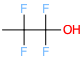

CC(F)(F)C(O)(F)F
Entry
CHOF_G4
CC(F)(F)C(O)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.789,157.048,174.147,188.49,210.308,224.99,243.356],'J/(mol*K)'), H298=(-1151.48,'kJ/mol'), S298=(372.135,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.45752,-2.80002,-2.08694,-1.76392,-1.58155,-1.05079,1.08663],'J/(mol*K)'), H298=(31.3737,'kJ/mol'), S298=(3.21073,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsHHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCFFO_Cs-CsF1sF1sO2s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,

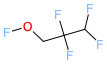

FOCC(F)(F)C(F)F
Entry
CHOF_G4
FOCC(F)(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([151.871,178.385,196.264,209.557,229.045,241.27,253.848],'J/(mol*K)'), H298=(-942.014,'kJ/mol'), S298=(400.783,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([28.5258,30.0615,31.9269,33.3465,35.6312,37.4111,40.7022],'J/(mol*K)'), H298=(2.60835,'kJ/mol'), S298=(144.059,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.765

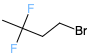

CC(F)(F)CCBr
Entry
CHOFBr_G4
CC(F)(F)CCBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([138.844,163.862,184.845,202.763,230.845,250.744,278.537],'J/(mol*K)'), H298=(-543.206,'kJ/mol'), S298=(397.037,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.4538,49.98,56.01,61.0504,68.6377,73.7924,80.3031],'J/(mol*K)'), H298=(-23.649,'kJ/mol'), S298=(158.984,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + group(CsBrCsHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.4538,49.98,56.01,61.0504,68.6377,73.7924,80.3031],'J/(mol*K)'), H298=(-23.649,'kJ/mol'), S298=(158.984,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCsHH)""")

GAE with f

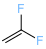

C=C(F)F
Entry
CHOF_G4
CDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.2633,70.751,80.2535,87.6065,99.0213,107.003,117.738],'J/(mol*K)'), H298=(-349.421,'kJ/mol'), S298=(264.546,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(133.032,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cd-CdHH) + missing(Cd-CdF1sF1s)""")

missing
['Cds-CdsHH_Cd-CdHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.0312,72.2686,80.9104,88.1044,99.1535,107.21,118.816],'J/(mol*K)','+|-',[0.533291,0.557468,0.522667,0.485314,0.420769,0.373642,0.722187]), H298=(-317.62,'kJ/mol','+|-',2.574

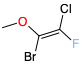

COC(Br)=C(F)Cl
Entry
CHOFClBr_G4
COC(Br)DC(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([118.408,134.132,147.487,158.752,176.035,187.85,203.203],'J/(mol*K)'), H298=(-268.145,'kJ/mol'), S298=(395.983,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.8031,108.425,116.216,121.667,128.386,131.905,133.861],'J/(mol*K)'), H298=(-235.048,'kJ/mol'), S298=(262.42,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-O2sHHH) + group(CdBrCO) + group(CdCClF) + longDistanceInteraction_noncyclic(Cds(Val7)2=Cds(Val7))""")

missing
['Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.9844,105.937,114.44,120.214,127.769,131.726,134.449],'J/(mol*K)'), H298=(-252.349,'kJ/mol'), S298=(263.833,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cd

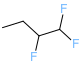

CCC(F)C(F)F
Entry
CHOF_G4
CCC(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.289,153.87,175.541,194.297,224.226,245.974,277.158],'J/(mol*K)'), H298=(-729.441,'kJ/mol'), S298=(376.991,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.294,41.0955,46.3906,50.3487,56.1265,59.9362,64.724],'J/(mol*K)'), H298=(-211.194,'kJ/mol'), S298=(50.0427,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsHHH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([35.5286,41.7316,46.3353,50.0729,55.8267,59.4216,63.3516],'J/(mol*K)'), H298=(-230.751,'kJ/mol'), S298=(49.2315,'J/(mol*K)'), comment="""Thermo group addi

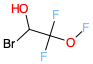

OC(Br)C(F)(F)OF
Entry
CHOFBr_G4
OC(Br)C(F)(F)OF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([143.058,161.458,172.877,182.013,194.848,202.277,208.705],'J/(mol*K)'), H298=(-678.868,'kJ/mol'), S298=(403.829,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([72.8204,83.1539,89.989,95.0456,102.058,105.862,108.809],'J/(mol*K)'), H298=(-41.731,'kJ/mol'), S298=(205.87,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(O2sCF) + group(CsBrCHO) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['O2s-CsH_O2s-CsH', 'CsCFFO_Cs-CsF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.5157,84.6251,91.0041,95.9077,102.723,106.2,107.906],'J/(mol*K)'), H298=(-51.4986,'kJ/mol'), S298=(203.353,'J/(mol*K)'), comment="""Thermo group additivity estimatio

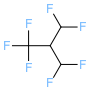

FC(F)C(C(F)F)C(F)(F)F
Entry
CHOF_G4
FC(F)C(C(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([164.246,193.496,216.749,235.093,260.772,276.723,296.875],'J/(mol*K)'), H298=(-1574.45,'kJ/mol'), S298=(441.88,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.953,24.7569,31.1467,35.2568,40.0167,43.2953,48.6077],'J/(mol*K)'), H298=(16.0404,'kJ/mol'), S298=(-55.3365,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFH_Cs-CsF1sF1sH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/(

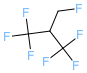

FCC(C(F)(F)F)C(F)(F)F
Entry
CHOF_G4
FCC(C(F)(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([162.072,191.064,214.225,232.598,258.553,274.884,295.779],'J/(mol*K)'), H298=(-1598.79,'kJ/mol'), S298=(434.002,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.4823,25.2219,31.1503,35.467,41.0328,44.3588,49.4999],'J/(mol*K)'), H298=(8.47486,'kJ/mol'), S298=(-54.1702,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)3)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CsCsFFF_Cs-CsF1sF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([18.9954,25.104,29.9993,33.6812,38.953,42.0492,46.7353],'J/

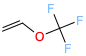

C=COC(F)(F)F
Entry
CHOF_G4
CDCOC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.261,126.698,141.441,153.741,172.603,185.457,201.836],'J/(mol*K)'), H298=(-790.732,'kJ/mol'), S298=(347.312,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-F1sF1sF1sO2s) + group(Cds-CdsOsH) + missing(Cd-CdHH)""")

missing
['CsFFFO_Cs-F1sF1sF1sO2s', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.944,50.3486,57.2258,60.8564,63.5744,64.519,66.4846],'J/(mol*K)'), H298=(-115.406,'kJ/mol'), S298=(44.8508,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(Cds-CdsOsH)"""

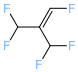

FC=C(C(F)F)C(F)F
Entry
CHOF_G4
FCDC(C(F)F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.36,158.778,176.632,191.639,214.519,229.954,249.189],'J/(mol*K)'), H298=(-988.808,'kJ/mol'), S298=(406.375,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sF1sH) + missing(Cs-CdF1sF1sH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'CsCFFH_Cs-CdF1sF1sH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-CdsCs

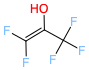

OC(=C(F)F)C(F)(F)F
Entry
CHOF_G4
OC(DC(F)F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.352,145.683,160.446,171.692,187.019,196.766,209.712],'J/(mol*K)'), H298=(-1142.92,'kJ/mol'), S298=(402.67,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.1815,44.2318,48.76,52.0983,55.6698,57.9591,61.4473],'J/(mol*K)'), H298=(-109.037,'kJ/mol'), S298=(60.3355,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-CdOs) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)2) + group(Cds-CdsCsOs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.6206,49.379,53.6074,55.3252,57.7246,58.9469,6

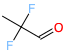

CC(F)(F)C=O
Entry
CHOF_G4
CC(F)(F)CDO
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.542,118.66,132.611,144.63,163.726,177.528,197.265],'J/(mol*K)'), H298=(-598.844,'kJ/mol'), S298=(336.796,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([2.31397,1.50465,1.00198,0.427023,-0.190688,-0.528904,0.276867],'J/(mol*K)'), H298=(23.8196,'kJ/mol'), S298=(0.892644,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-COCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-CO) + missing(Cs-CsHHH) + missing(CO-CsO2dH)""")

missing
['CsCCFF_Cs-COCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'Cds-OdCsH_CO-CsO2dH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([103.17,120

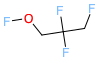

FCC(F)(F)COF
Entry
CHOF_G4
FCC(F)(F)COF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([143.01,168.426,185.339,199.039,219.318,232.332,247.177],'J/(mol*K)'), H298=(-735.184,'kJ/mol'), S298=(385.245,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([29.7487,32.2254,34.0692,35.3862,37.5126,38.9765,40.9879],'J/(mol*K)'), H298=(-9.20811,'kJ/mol'), S298=(141.66,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([30.9833,32.8615,34.0139,35.1104,37.2128,38.4619,39.6155],'J/(mol*K)'), H298=(-28.7654,'kJ/mol'), S298=(140.849,'J/(mol*K)'), comment="""Thermo gro

FC=COCBr
Entry
CHOFBr_G4
FCDCOCBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.731,119.318,134.539,147.598,168.035,182.212,200.25],'J/(mol*K)'), H298=(-253.959,'kJ/mol'), S298=(374.692,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.905,94.092,107.073,116.5,128.257,135.271,144.497],'J/(mol*K)'), H298=(-112.871,'kJ/mol'), S298=(216.125,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrHHO) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.4959,97.868,111.157,119.835,130.138,136.032,145.136],'J/(mol*K)'), H298=(-139.639,'kJ/mol'), S298=(209.875,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrHHO) +

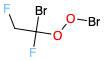

FCC(F)(Br)OOBr
Entry
CHOFBr_G4
FCC(F)(Br)OOBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([145.707,161.444,172.765,181.985,195.251,203.296,211.095],'J/(mol*K)'), H298=(-374.548,'kJ/mol'), S298=(430.66,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.582,119.03,125.788,130.131,135.133,137.519,136.156],'J/(mol*K)'), H298=(-165.55,'kJ/mol'), S298=(280.427,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2sBrO) + group(CsBrCFO) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsF1sHH)""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.278,120.501,126.803,130.993,135.798,137.857,135.253],'J/(mol*K)'), H298=(-175.318,'kJ/mol'), S298=(277.91,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(

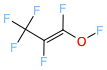

FOC(F)=C(F)C(F)(F)F
Entry
CHOF_G4
FOC(F)DC(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([138.671,158.517,173.322,184.562,200.252,209.957,219.388],'J/(mol*K)'), H298=(-999.172,'kJ/mol'), S298=(410.536,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([56.176,62.2915,67.3717,71.7461,78.4632,82.7906,86.8063],'J/(mol*K)'), H298=(-146.744,'kJ/mol'), S298=(199.703,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCF) + missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cds(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.1

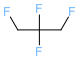

FCC(F)(F)CF
Entry
CHOF_G4
FCC(F)(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.902,146.834,164.336,177.114,196.292,208.99,224.682],'J/(mol*K)'), H298=(-888.716,'kJ/mol'), S298=(343.39,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-2.4692,-1.27225,0.110577,0.551587,0.59953,1.02931,2.74469],'J/(mol*K)'), H298=(39.1145,'kJ/mol'), S298=(1.6225,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cs-CsF1sHH) + missing(Cs-CsF1sHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300

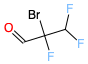

O=CC(F)(Br)C(F)F
Entry
CHOFBr_G4
ODCC(F)(Br)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.374,151.379,164.625,175.113,190.674,200.649,211.575],'J/(mol*K)'), H298=(-731.7,'kJ/mol'), S298=(398.402,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.1197,61.2939,64.0121,65.689,67.8199,68.9418,69.6637],'J/(mol*K)'), H298=(-168.226,'kJ/mol'), S298=(92.2792,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCF) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + longDistanceInteraction_noncyclic(Cs(Val7)2-CO) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(CO-CsO2dH)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'Cds-OdCsH_CO-CsO2dH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([55.3384,61.2826,64.4177,66.767,69.7615,70.869,69.264],'J/(mol*K)'), H

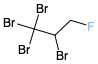

FCC(Br)C(Br)(Br)Br
Entry
CHOFBr_G4
FCC(Br)C(Br)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([150.824,166.743,179.985,191.311,208.558,220.118,233.93],'J/(mol*K)'), H298=(-161.759,'kJ/mol'), S298=(459.126,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.29,121.632,129.828,136.187,145.391,151.047,156.725],'J/(mol*K)'), H298=(58.9743,'kJ/mol'), S298=(317.378,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCsCsH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsBrBrBrCs) + longDistanceInteraction_noncyclic(Cs(Br)3-Cs(Br))""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.467,125.21,133.193,139.688,149.024,153.975,156.045],'J/(mol*K)'), H298=(34.7659,'kJ/mol')

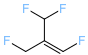

FC=C(CF)C(F)F
Entry
CHOF_G4
FCDC(CF)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.86,154.318,171.434,185.921,208.285,223.747,244.377],'J/(mol*K)'), H298=(-777.412,'kJ/mol'), S298=(382.931,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + missing(Cs-CdF1sF1sH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CsCFFH_Cs-CdF1sF1sH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.1544,19.2882,20.8782,22.0078,24.2672,25.4387,26.6102],'J/(mol*K)'), H298=(43.2626,'kJ/mol'), S298=(-53.1368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-CdsCsCs)""")

G

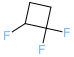

FC1CCC1(F)F
Entry
CHOF_G4
FC1CCC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.38,131.774,154.163,172.436,200.838,220.675,247.181],'J/(mol*K)'), H298=(-601.232,'kJ/mol'), S298=(335.409,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([9.63492,18.4474,26.8038,33.1817,42.9552,50.3961,61.4639],'J/(mol*K)'), H298=(-94.4829,'kJ/mol'), S298=(188.44,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs-Cs-Cs(F)(F)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([9.63492,18.4474,26.8038,33.1817,42.9552,50.3961,61.4639],'J/(mol*K)'), H298=(

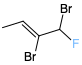

CC=C(Br)C(F)Br
Entry
CHOFBr_G4
CCDC(Br)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.66,146.739,164.281,179.29,202.859,219.559,242.448],'J/(mol*K)'), H298=(-155.011,'kJ/mol'), S298=(414.422,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([83.8987,94.8811,103.17,109.677,119.29,125.135,131.408],'J/(mol*K)'), H298=(-143.714,'kJ/mol'), S298=(252.184,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + missing(Cd-CdCsH) + group(CdBrCsCd)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdH)CdHHH', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.0387,96.2713,103.992,110.205,119.479,124.902,129.717],'J/(mol*K)'), H298=(-158.686,'kJ/mol'), S298=(250.302,'J/(mol*K)'), comment="""Thermo group additivity

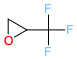

FC(F)(F)C1CO1
Entry
CHOF_G4
FC(F)(F)C1CO1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.1524,121.51,138.878,153.153,175.05,189.956,208.739],'J/(mol*K)'), H298=(-734.822,'kJ/mol'), S298=(337.03,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([19.6765,25.5909,31.944,37.052,45.1081,51.5599,62.3251],'J/(mol*K)'), H298=(24.6513,'kJ/mol'), S298=(138.948,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(Cs-CsCsOsH) + missing(Cs-CsO2sHH) + missing(Cs-CsF1sF1sF1s) + ring(O2s-Cs-Cs(C-FFF))""")

missing
['Cs-CsOsHH_Cs-CsO2sHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([19.6765,25.5909,31.944,37.052,45.1081,51.5599,62.3251],'J/(mol*K)'), H298=(24.6513,'kJ/mol'), S298=(138.948,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group

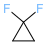

FC1(F)CC1
Entry
CHOF_G4
FC1(F)CC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.6413,97.3371,113.837,126.748,146.848,161.052,180.474],'J/(mol*K)'), H298=(-339.928,'kJ/mol'), S298=(283.068,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(207.862,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-18.0014,-15.7389,-13.6463,-12.637,-10.8754,-8.91242,-5.63062],'J/(mol*K)'), H298=(167.076,'kJ/mol'), S298=(145.365,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + ring(Cs-Cs(F)(F)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-18.0014,-15.7389,-13.6463,-12.637,-10.8754,-8.91242,-5.63062],'J/(mol*K)'), H298=(167.076,'kJ/mol'), S298=(145.365,'J/(mol*K)'), comment="""Thermo group additivity estimation: ring(Cs-Cs(

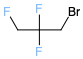

FCC(F)(F)CBr
Entry
CHOFBr_G4
FCC(F)(F)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.066,151.311,167.518,180.382,199.491,211.838,226.164],'J/(mol*K)'), H298=(-683.634,'kJ/mol'), S298=(375.601,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.5239,47.8726,55.0501,60.4641,68.272,73.9686,82.5785],'J/(mol*K)'), H298=(5.67581,'kJ/mol'), S298=(162.312,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsF1sHH) + group(CsBrCsHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([42.4538,49.98,56.01,61.0504,68.6377,73.7924,80.3031],'J/(mol*K)'), H298=(-23.649,'kJ/mol'), S298=(158.984,'J/(mol*K)'), comment=""

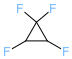

FC1C(F)C1(F)F
Entry
CHOF_G4
FC1C(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.4393,118.173,133.146,144.936,162.913,175.04,189.932],'J/(mol*K)'), H298=(-657.982,'kJ/mol'), S298=(331.86,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(207.862,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([50.6974,62.1276,73.2266,82.8574,97.1858,107.513,123.296],'J/(mol*K)'), H298=(-204.199,'kJ/mol'), S298=(270.185,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs(F)-Cs-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=

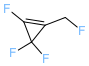

FCC1=C(F)C1(F)F
Entry
CHOF_G4
FCC1DC(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.577,131.462,148.236,162.177,182.766,195.837,212.773],'J/(mol*K)'), H298=(-519.007,'kJ/mol'), S298=(375.093,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.86284,6.8523,8.84257,11.3063,15.2873,17.546,23.0005],'J/(mol*K)'), H298=(327.845,'kJ/mol'), S298=(105.022,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCdF1sF1s) + missing(Cs-CdF1sHH) + group(Cds-CdsCsCs) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cds(F)) + ring(Cs-Cd(C)-Cd(F))""")

missing
['CsCCFF_Cs-CdCdF1sF1s', 'CsCFHH_Cs-CdF1sHH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.86284,6.8523,8.84257,11.3063,15.2873,17.546,23.0005],'J/(mol*K)'), H298=(327.845,'kJ/mol'), S298=(105.022,'J/(

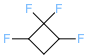

FC1CC(F)C1(F)F
Entry
CHOF_G4
FC1CC(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.32,141.892,164.668,182.476,208.879,227.434,252.156],'J/(mol*K)'), H298=(-777.909,'kJ/mol'), S298=(348.949,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.9299,59.0264,72.2914,82.4051,97.7093,109.058,125.693],'J/(mol*K)'), H298=(-301.9,'kJ/mol'), S298=(243.796,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs-Cs-Cs(F)(F)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.92

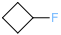

FC1CCC1
Entry
CHOF_G4
FC1CCC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([81.9836,108.041,131.73,151.664,182.702,205.357,237.973],'J/(mol*K)'), H298=(-180.872,'kJ/mol'), S298=(293.871,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([12.3287,20.4579,27.7749,33.9712,43.753,50.7848,59.3875],'J/(mol*K)'), H298=(-128.745,'kJ/mol'), S298=(182.405,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + ring(Cs(F)-Cs-Cs-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([12.3287,20.4579,27.7749,33.9712,43.753,50.7848,59.3875],'J/(mol*K)'), H298=(-128.745,'kJ/mol'), S298=(182.405,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) +

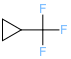

FC(F)(F)C1CC1
Entry
CHOF_G4
FC(F)(F)C1CC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([106.279,133.987,156.33,174.253,201.99,221.295,247.035],'J/(mol*K)'), H298=(-639.367,'kJ/mol'), S298=(333.439,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.4915,12.6079,18.6913,23.4265,30.6045,35.9846,43.7157],'J/(mol*K)'), H298=(128.183,'kJ/mol'), S298=(94.4869,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + missing(Cs-CsF1sF1sF1s) + ring(Cs-Cs(C-FFF)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.4915,12.6079,18.6913,23.4265,30.6045,35.9846,43.7157],'J/(mol*K)'), H298=(128.183,'kJ/mol'), S298=(94.4869,'J/(mol*K)'), comment="""Thermo group additivity estimatio

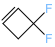

FC1(F)C=CC1
Entry
CHOF_G4
FC1(F)CDCC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.4573,108.788,127.817,143.285,166.86,182.976,203.809],'J/(mol*K)'), H298=(-266.843,'kJ/mol'), S298=(302.964,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([6.24784,15.3754,23.5529,29.6305,38.9832,45.925,57.6917],'J/(mol*K)'), H298=(96.0349,'kJ/mol'), S298=(168.999,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + group(Cs-(Cds-Cds)CsHH) + missing(Cd-CdCsH) + missing(Cd-CdCsH) + ring(Cd-Cs-Cs(F)(F)-Cd)""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'Cds-CdsCsH_Cd-CdCsH', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([6.24784,15.3754,23.5529,29.6305,38.9832,45.925,57.6917],'J/(mol*K)'), H298=(96.0349,'kJ/mol'), S298=(168.999,'J/(mol*K)'), comment="""Thermo group additivity estimatio

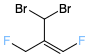

FC=C(CF)C(Br)Br
Entry
CHOFBr_G4
FCDC(CF)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([138.512,160.368,178.755,194.087,217.112,232.233,249.974],'J/(mol*K)'), H298=(-320.95,'kJ/mol'), S298=(420.89,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.2873,82.4424,88.8933,94.0563,101.87,106.512,110.238],'J/(mol*K)'), H298=(63.312,'kJ/mol'), S298=(152.652,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + group(CsBrBrCH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.2873,82.4424,88.8933,94.0563,101.87,106.512,110.238],'J/(mol*K)'), H298=(63.312,'kJ/mol'), S298=(152.652,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCH) + group(Cds-CdsCsCs)""")

GAE with fitt

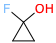

OC1(F)CC1
Entry
CHOF_G4
OC1(F)CC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([83.8263,105.117,123.321,138.184,161.083,177.082,198.954],'J/(mol*K)'), H298=(-320.209,'kJ/mol'), S298=(298.904,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-17.0646,-17.6075,-15.9538,-14.3767,-11.6537,-9.32814,-5.12201],'J/(mol*K)'), H298=(152.887,'kJ/mol'), S298=(143.159,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sO2s) + missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + ring(Cs-Cs(F)(O2)-Cs)""")

missing
['O2s-CsH_O2s-CsH', 'CsCCFO_Cs-CsCsF1sO2s', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-17.0646,-17.6075,-15.9538,-14.3767,-11.6537,-9.32814,-5.12201],'J/(mol*K)'), H298=(152.887,'kJ/mol'), S298=(143.159,'J/(mol*K)'), comment="""Thermo g

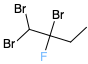

CCC(F)(Br)C(Br)Br
Entry
CHOFBr_G4
CCC(F)(Br)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([165.62,188.143,207.257,223.369,248.062,264.925,286.871],'J/(mol*K)'), H298=(-252.23,'kJ/mol'), S298=(451.401,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.691,122.777,131.618,138.457,147.831,152.921,155.637],'J/(mol*K)'), H298=(-179.922,'kJ/mol'), S298=(292.029,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsBrCCF) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH) + group(CsBrBrCsH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([113.101,126.129,134.579,141.231,150.183,154.603,155.141],'J/(mol*K)'), H298=(-195.728,'kJ/mol'), S298=(2

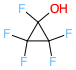

OC1(F)C(F)(F)C1(F)F
Entry
CHOF_G4
OC1(F)C(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.739,150.447,165.127,177.166,194.85,205.997,217.861],'J/(mol*K)'), H298=(-1019.91,'kJ/mol'), S298=(375.577,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-21.1153,-22.4671,-20.4605,-18.2034,-14.478,-10.2703,-0.0639148],'J/(mol*K)'), H298=(335.449,'kJ/mol'), S298=(162.557,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sO2s) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + ring(Cs-Cs(F)(F)-Cs(O2))""")

mis

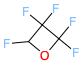

FC1OC(F)(F)C1(F)F
Entry
CHOF_G4
FC1OC(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.756,140.997,159.109,172.211,191.288,203.815,218.086],'J/(mol*K)'), H298=(-1158.6,'kJ/mol'), S298=(365.077,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([23.8663,32.4559,41.3839,48.3087,59.2806,68.0004,82.627],'J/(mol*K)'), H298=(-216.425,'kJ/mol'), S298=(226.945,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-CsCsF1sF1s) + group(CsCFHO) + missing(Cs-CsF1sF1sO2s) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + ring(Cs-Cs(F)(F)-O2s-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCFFO_Cs-CsF1sF1sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K')

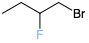

CCC(F)CBr
Entry
CHOFBr_G4
CCC(F)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.393,149.115,170.776,189.624,219.881,241.894,274.091],'J/(mol*K)'), H298=(-305.613,'kJ/mol'), S298=(384.703,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.7665,90.7144,101.626,110.463,123.848,132.824,144.139],'J/(mol*K)'), H298=(-244.267,'kJ/mol'), S298=(211.641,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.9824,91.7116,102.345,111.123,124.464,133.214,143.655],'J/(mol*K)'), H298=(-254.4,'kJ/mol'), S298=(208.216,'J/(mol*K)'),

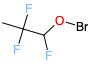

CC(F)(F)C(F)OBr
Entry
CHOFBr_G4
CC(F)(F)C(F)OBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([145.322,169.343,185.872,199.477,219.682,232.729,247.813],'J/(mol*K)'), H298=(-748.321,'kJ/mol'), S298=(398.254,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([67.7472,78.7718,86.6038,92.1851,99.4507,103.678,107.429],'J/(mol*K)'), H298=(-240.004,'kJ/mol'), S298=(205.425,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsCFHO) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([68.9818,79.4079,86.5486,91.9093,99.151,103.164,106.056],'J/(mol*K)'), H298=(-259.561,'kJ/mol'), S298=(204.613,'J/(mol*K)'), comment="""Thermo group additivity estimatio

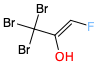

OC(=CF)C(Br)(Br)Br
Entry
CHOFBr_G4
OC(DCF)C(Br)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([144.665,161.952,173.367,181.22,192.127,200.086,210.633],'J/(mol*K)'), H298=(-227.481,'kJ/mol'), S298=(428.242,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([113.009,122.513,129.273,134.527,141.838,146.544,150.415],'J/(mol*K)'), H298=(-57.3798,'kJ/mol'), S298=(308.126,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsBrBrBrCd) + longDistanceInteraction_noncyclic(Cs(Br)3-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([113.471,127.71,135.189,139.416,145.043,147.935,149.968],'J/(mol*K)'), H298=(-112.886,'kJ/mol'), S298=(300.322,'J/(mol*K)'), comment=""

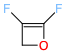

FC1=C(F)OC1
Entry
CHOF_G4
FC1DC(F)OC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([79.1167,96.5819,110.614,121.679,138.539,150.014,164.543],'J/(mol*K)'), H298=(-304.134,'kJ/mol'), S298=(302.832,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([48.7624,62.2307,73.6138,82.721,96.738,106.751,119.822],'J/(mol*K)'), H298=(-126.944,'kJ/mol'), S298=(254.477,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(Cs-(Cds-Cds)OsHH) + missing(Cd-CdCsF1s) + group(CdCFO) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cd-Cd(F)-Cs-O2s)""")

missing
['CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([48.7624,62.2307,73.6138,82.721,96.738,106.751,119.822],'J/(mol*K)'), H298=(-126.944,'kJ/mol'), S298=(254.477,'J/(mol*K)'), c

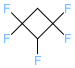

FC1C(F)(F)CC1(F)F
Entry
CHOF_G4
FC1C(F)(F)CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.615,155.106,176.941,193.568,218.748,235.85,257.116],'J/(mol*K)'), H298=(-1002.37,'kJ/mol'), S298=(365.664,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([8.40126,17.2948,25.9561,32.3323,41.8826,49.6367,62.3417],'J/(mol*K)'), H298=(-71.1489,'kJ/mol'), S298=(194.565,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + ring(Cs-Cs-Cs(F)(F)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,50

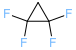

FC1(F)CC1(F)F
Entry
CHOF_G4
FC1(F)CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.7475,119.651,134.799,146.504,164.162,175.866,189.899],'J/(mol*K)'), H298=(-698.319,'kJ/mol'), S298=(321.053,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(207.862,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-19.5026,-18.1231,-15.7873,-14.4133,-12.2847,-9.74976,-4.37302],'J/(mol*K)'), H298=(234.039,'kJ/mol'), S298=(149.117,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + ring(Cs-Cs(F)(F)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-19.5026,-18.1231,-15.7873,-14.4133,-12.2847,-9.74976,-4.37302],

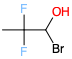

CC(F)(F)C(O)Br
Entry
CHOFBr_G4
CC(F)(F)C(O)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([135.24,158.68,175.309,189.143,210.09,224.109,241.732],'J/(mol*K)'), H298=(-678.338,'kJ/mol'), S298=(384.994,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.8371,50.2924,55.9751,59.9352,64.8451,67.4002,69.193],'J/(mol*K)'), H298=(-12.9656,'kJ/mol'), S298=(65.0218,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + group(CsBrCHO) + missing(Cs-CsHHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.5324,51.7636,56.9903,60.7973,65.5106,67.7385,68.29],'J/(mol*K)'), H298=(-22.7332,'kJ/mol'), S298=(62.5048,'J/(mol*K)'), comment="""Thermo grou

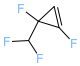

FC1=CC1(F)C(F)F
Entry
CHOF_G4
FC1DCC1(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.611,133.72,151.13,164.301,183.481,196.634,213.251],'J/(mol*K)'), H298=(-536.673,'kJ/mol'), S298=(362.635,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([23.9259,28.5983,32.2256,34.5848,38.2977,40.3439,42.0721],'J/(mol*K)'), H298=(71.9308,'kJ/mol'), S298=(118.367,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cd-CdCsF1s) + missing(Cd-CdCsH) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + ring(Cs-Cd(F)-Cd)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CdCsCdF_Cd-CdCsF1s', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([25.1605,29.2344,32.1703,34.309,37.9979,39.8292,40.6998],'J/(mol*K)'), H298=(52

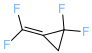

FC(F)=C1CC1(F)F
Entry
CHOF_G4
FC(F)DC1CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([110.702,133.109,150.756,164.066,183.43,196.681,213.333],'J/(mol*K)'), H298=(-573.52,'kJ/mol'), S298=(354.477,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([25.7672,36.1556,45.379,52.0927,62.3137,69.9061,83.5816],'J/(mol*K)'), H298=(233.737,'kJ/mol'), S298=(138.915,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CdCsF1sF1s) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s) + ring(Cs-Cs(F)(F)-Cd(Cd))""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([25.7672,36.1556,45.379,52.0927,62.3137,69.9061,83.5816],'J/(mol*K)'), H298=(233.737,'kJ/mol'), S298=(138.915,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(

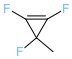

CC1(F)C(F)=C1F
Entry
CHOF_G4
CC1(F)C(F)DC1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([106.337,125.327,141.16,154.565,175.25,189.5,208.09],'J/(mol*K)'), H298=(-299.201,'kJ/mol'), S298=(339.741,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([22.4421,26.4529,29.7445,32.3205,36.3421,38.493,40.9293],'J/(mol*K)'), H298=(110.554,'kJ/mol'), S298=(124.893,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsHHH) + missing(Cd-CdCsF1s) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cs-Cd(F)-Cd)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CdCsCdF_Cd-CdCsF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata

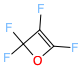

FC1=C(F)C(F)(F)O1
Entry
CHOF_G4
FC1DC(F)C(F)(F)O1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.406,119.833,132.325,142.128,156.414,165.26,174.047],'J/(mol*K)'), H298=(-726.851,'kJ/mol'), S298=(337.272,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([24.4931,29.1667,34.0934,38.4914,45.8854,51.6362,59.7187],'J/(mol*K)'), H298=(-65.901,'kJ/mol'), S298=(224.363,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-CdF1sF1sO2s) + missing(Cd-CdCsF1s) + group(CdCFO) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cds(F)) + ring(O2s-Cd-Cd-Cs(F)(F))""")

missing
['CsCFFO_Cs-CdF1sF1sO2s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([24.4931,29.1667,34.0934,38.4914,45.8

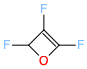

FC1=C(F)C(F)O1
Entry
CHOF_G4
FC1DC(F)C(F)O1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.8494,107.536,120.593,131.091,146.872,157.231,169.208],'J/(mol*K)'), H298=(-506.257,'kJ/mol'), S298=(327.775,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.9284,71.0021,81.968,90.861,104.146,113.255,124.083],'J/(mol*K)'), H298=(-330.302,'kJ/mol'), S298=(282.283,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsCFHO) + missing(Cd-CdCsF1s) + group(CdCFO) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cd-Cd-O2s-Cs(F))""")

missing
['CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.9284,71.0021,81.968,90.861,104.146,113.255,124.083],'J/(mol*K)'), H298=(-330.3

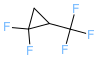

FC(F)(F)C1CC1(F)F
Entry
CHOF_G4
FC(F)(F)C1CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.421,156.052,178.091,194.678,219.545,236.415,257.298],'J/(mol*K)'), H298=(-1011.47,'kJ/mol'), S298=(375.222,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.108324,6.86193,14.2936,19.8553,27.6631,33.7189,44.154],'J/(mol*K)'), H298=(168.077,'kJ/mol'), S298=(96.1395,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sF1sF1s) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.108324,6.86193,14.2936,19.8553,27.6631,33.7189,44.154],'J/(mol*K)'), H298=(168.077,'kJ/mol'), S298=(96.1395,'J/(mol*K)'), comment="""Thermo gro

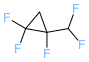

FC(F)C1(F)CC1(F)F
Entry
CHOF_G4
FC(F)C1(F)CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.222,156.633,178.207,194.624,218.951,235.695,257.039],'J/(mol*K)'), H298=(-931.373,'kJ/mol'), S298=(379.288,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([13.381,19.0676,25.2386,29.7666,35.7442,40.4059,47.8969],'J/(mol*K)'), H298=(-0.725464,'kJ/mol'), S298=(118.832,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.61

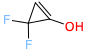

OC1=CC1(F)F
Entry
CHOF_G4
OC1DCC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.1796,104.362,117.863,127.758,142.524,152.403,164.746],'J/(mol*K)'), H298=(-318.604,'kJ/mol'), S298=(307.99,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([29.6076,40.621,46.5879,48.5947,50.7289,52.2031,55.6582],'J/(mol*K)'), H298=(48.2964,'kJ/mol'), S298=(201.546,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdCdF1sF1s) + group(Cds-CdsCsOs) + missing(Cd-CdCsH) + ring(Cd-Cd-Cs(F)(F))""")

missing
['CsCCFF_Cs-CdCdF1sF1s', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([29.6076,40.621,46.5879,48.5947,50.7289,52.2031,55.6582],'J/(mol*K)'), H298=(48.2964,'kJ/mol'), S298=(201.546,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + gr

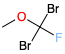

COC(F)(Br)Br
Entry
CHOFBr_G4
COC(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([112.276,126.335,136.601,144.503,156.864,166.665,180.927],'J/(mol*K)'), H298=(-352.426,'kJ/mol'), S298=(375.81,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.0879,87.6534,91.174,94.6448,100.775,104.393,107.575],'J/(mol*K)'), H298=(-282.814,'kJ/mol'), S298=(264.723,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-O2sHHH) + group(CsBrBrFO)""")

missing
['Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.0879,87.6534,91.174,94.6448,100.775,104.393,107.575],'J/(mol*K)'), H298=(-282.814,'kJ/mol'), S298=(264.723,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(CsBrBrFO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1

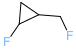

FCC1CC1F
Entry
CHOF_G4
FCC1CC1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.223,122.706,144.413,162.956,192.234,213.169,242.406],'J/(mol*K)'), H298=(-342.036,'kJ/mol'), S298=(327.721,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.9877,50.5458,60.3836,68.8868,82.7212,92.2519,104.226],'J/(mol*K)'), H298=(-122.473,'kJ/mol'), S298=(140.131,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsF1sHH) + ring(Cs(C-F)-Cs-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.9877,50.5458,60.3836,68.8868,82.7212,92.2519,104.226],'J/(mol*K)'), H298=(-122.473,'kJ/mol'), S298=(140.131,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + group(CsCsCsFH) + 

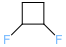

FC1CCC1F
Entry
CHOF_G4
FC1CCC1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.1054,118.917,141.622,161.028,191.432,212.913,242.328],'J/(mol*K)'), H298=(-381.555,'kJ/mol'), S298=(312.669,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.5575,60.8069,73.0048,83.1246,98.6397,109.475,123.407],'J/(mol*K)'), H298=(-334.722,'kJ/mol'), S298=(240.265,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + group(CsCsCsFH) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs(F)-Cs-Cs-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.5575,60.8069,73.0048,83.1246,98.6397,109.475,123.407],'J/(mol*K)'), H298=(-334.722,'kJ/mol'), S298=(240.265,'J/(mol

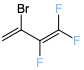

C=C(Br)C(F)=C(F)F
Entry
CHOFBr_G4
CDC(Br)C(F)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([122.144,141.608,156.008,167.253,184.386,195.971,210.322],'J/(mol*K)'), H298=(-405.246,'kJ/mol'), S298=(390.732,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([64.5202,73.9659,79.3814,83.3413,88.673,91.5045,92.7302],'J/(mol*K)'), H298=(-72.7778,'kJ/mol'), S298=(118.395,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CdBrCC) + longDistanceInteraction_noncyclic(Cds(Val7)-Cds(Val7)) + group(CdCCF) + longDistanceInteraction_noncyclic(Cds(Val7)-Cds(Val7)) + missing(Cd-CdHH) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(F)2=Cds(F))""")

missing
['Cds-CdsHH_Cd-CdHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.8417,72.043,77.0555,81.5605,88.318,91.8108,92.2451],'J

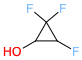

OC1C(F)C1(F)F
Entry
CHOF_G4
OC1C(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.136,127.953,143.834,156.938,177.115,190.951,208.726],'J/(mol*K)'), H298=(-644.423,'kJ/mol'), S298=(345.567,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.2491,52.5408,63.9321,72.8635,85.9382,95.1983,108.597],'J/(mol*K)'), H298=(-24.3623,'kJ/mol'), S298=(149.498,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(Cs-CsCsOsH) + group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs-Cs(F)(F)-Cs(O2))""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.2491,52.5408,63.9321,72.8635,85.9382,95.1983,108.597],'J/(mol*K)'), H298=(-24.3623,'kJ/mol'

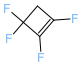

FC1=C(F)C(F)(F)C1
Entry
CHOF_G4
FC1DC(F)C(F)(F)C1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.215,130.843,147.634,161.379,182.196,196.055,212.695],'J/(mol*K)'), H298=(-633.763,'kJ/mol'), S298=(341.557,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.46458,14.4719,22.1449,28.3206,37.8727,45.1688,58.137],'J/(mol*K)'), H298=(152.702,'kJ/mol'), S298=(170.552,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + group(Cs-(Cds-Cds)CsHH) + missing(Cd-CdCsF1s) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cs(F)2-Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cd-Cs-Cs(F)(F)-Cd)""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CdCsCdF_Cd-CdCsF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.46458,

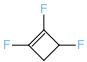

FC1=C(F)C(F)C1
Entry
CHOF_G4
FC1DC(F)C(F)C1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.4304,118.556,136.037,150.499,172.822,188.179,207.931],'J/(mol*K)'), H298=(-416.57,'kJ/mol'), S298=(331.756,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([36.8506,51.0285,63.8373,74.5623,90.5859,102.281,116.913],'J/(mol*K)'), H298=(-58.5315,'kJ/mol'), S298=(221.262,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCFH) + group(Cs-(Cds-Cds)CsHH) + missing(Cd-CdCsF1s) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cd(F)-Cd-Cs-Cs)""")

missing
['CdCsCdF_Cd-CdCsF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([36.8506,51.0285,63.8373,74.5623,90.5859,102.281,11

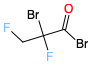

O=C(Br)C(F)(Br)CF
Entry
CHOFBr_G4
ODC(Br)C(F)(Br)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.545,155.027,168.443,178.477,192.698,202.092,213.076],'J/(mol*K)'), H298=(-532.25,'kJ/mol'), S298=(419.706,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([100.426,109.842,116.01,120.473,126.627,130.084,132.735],'J/(mol*K)'), H298=(-310.688,'kJ/mol'), S298=(278.28,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCF) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Val7)2-CO) + missing(Cs-CsF1sHH) + group(COBrCsO)""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.9303,107.951,114.47,119.64,126.882,130.667,131.929],'J/(mol*K)'), H298=(-342.868,'kJ/mol'), S298=(275.155,'J/(mol*K)'), comment="""Thermo group additivit

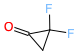

O=C1CC1(F)F
Entry
CHOF_G4
ODC1CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.7059,103.98,116.709,126.753,142.106,152.515,165.66],'J/(mol*K)'), H298=(-338.495,'kJ/mol'), S298=(312.281,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.7762,24.1845,29.4556,33.1857,39.6157,45.0373,55.951],'J/(mol*K)'), H298=(237.547,'kJ/mol'), S298=(181.863,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-O2d)CsHH) + missing(Cs-COCsF1sF1s) + missing(CO-CsCsO2d) + longDistanceInteraction_cyclic(Cs(F)2-CO) + ring(Cs(F)(F)-Cs-CO(O2d))""")

missing
['CsCCFF_Cs-COCsF1sF1s', 'Cds-OdCsCs_CO-CsCsO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.7762,24.1845,29.4556,33.1857,39.6157,45.0373,55.951],'J/(mol*K)'), H298=(237.547,'kJ/mol'), S298=(181.863,'J/(mol*K)'), comment="""Thermo group additivity est

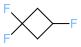

FC1CC(F)(F)C1
Entry
CHOF_G4
FC1CC(F)(F)C1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.471,132.172,154.838,173.134,201.44,221.132,247.308],'J/(mol*K)'), H298=(-611.779,'kJ/mol'), S298=(330.771,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([10.8686,19.6,27.6514,34.0312,44.0277,51.1554,60.586],'J/(mol*K)'), H298=(-117.817,'kJ/mol'), S298=(182.316,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + ring(Cs-Cs-Cs(F)(F)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([10.8686,19.6,27.6514,34.0312,44.0277,51.1554,60.586],'J/(mol*K)'), H298=(-117.817,'kJ/mol'), S298=(182.316,'J/(mol*K)'), comment="""Thermo group additivity estimation: g

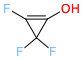

OC1=C(F)C1(F)F
Entry
CHOF_G4
OC1DC(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.2594,114.96,126.514,135.883,149.829,158.851,169.128],'J/(mol*K)'), H298=(-471.592,'kJ/mol'), S298=(330.864,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([22.4166,27.9179,32.6877,36.7359,43.5798,48.8161,57.6727],'J/(mol*K)'), H298=(149.869,'kJ/mol'), S298=(211.095,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdCdF1sF1s) + group(Cds-CdsCsOs) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cds(F)) + longDistanceInteraction_cyclic(Cd(F)=CdOs) + ring(Cs(F)(F)-Cd-Cd(O2))""")

missing
['CsCCFF_Cs-CdCdF1sF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([22.4166,27.9179,32.6877,36.7359,43.5798,48.8161,57.6727],'J/(mol*K)'), H298=(149.869

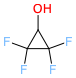

OC1C(F)(F)C1(F)F
Entry
CHOF_G4
OC1C(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([118.433,139.592,155.301,167.423,185.836,198.243,213.472],'J/(mol*K)'), H298=(-831.366,'kJ/mol'), S298=(367.414,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([3.56399,10.287,17.152,22.4522,29.9223,35.879,45.9593],'J/(mol*K)'), H298=(236.354,'kJ/mol'), S298=(97.5313,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(Cs-CsCsOsH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + ring(Cs-Cs(F)(F)-Cs(O2))""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([3.56399,10.287,17.152,22.4522,29.9223,35.879,45.95

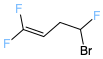

FC(F)=CCC(F)Br
Entry
CHOFBr_G4
FC(F)DCCC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.372,151.8,170.841,186.845,211.215,227.611,247.848],'J/(mol*K)'), H298=(-564.176,'kJ/mol'), S298=(416.613,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.189,88.7556,100.289,109.623,123.221,132.346,143.693],'J/(mol*K)'), H298=(-221.899,'kJ/mol'), S298=(219.3,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + group(CsBrCFH) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.189,88.7556,100.289,109.623,123.221,132.346,143.693],'J/(mol*K)'), H298=(-221.899,'kJ/mol'), S298=(219.3,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + group(CsBrCFH)""")

GAE

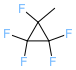

CC1(F)C(F)(F)C1(F)F
Entry
CHOF_G4
CC1(F)C(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.437,160.046,179.371,195.575,220.157,236.602,256.757],'J/(mol*K)'), H298=(-892.075,'kJ/mol'), S298=(377.478,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([11.7698,15.4575,21.346,26.2767,32.815,38.1143,48.3256],'J/(mol*K)'), H298=(83.6777,'kJ/mol'), S298=(128.26,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['CsCsCsFF_Cs-

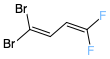

FC(F)=CC=C(Br)Br
Entry
CHOFBr_G4
FC(F)DCCDC(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.549,146.789,162.709,175.146,192.368,202.962,215.441],'J/(mol*K)'), H298=(-231.975,'kJ/mol'), S298=(407.807,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([87.0736,101.282,112.462,120.223,131.73,139.336,149.539],'J/(mol*K)'), H298=(133.666,'kJ/mol'), S298=(252.43,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + missing(Cd-CdF1sF1s) + group(CdBrBrC)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([87.0736,101.282,112.462,120.223,131.73,139.336,149.539],'J/(mol*K)'), H298=(133.666,'kJ/mol'), S298=(252.43,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + grou

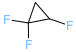

FC1CC1(F)F
Entry
CHOF_G4
FC1CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([87.1139,107.401,123.551,136.122,155.239,168.29,185.06],'J/(mol*K)'), H298=(-503.201,'kJ/mol'), S298=(315.479,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(207.862,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.8133,23.6407,29.6929,35.1418,43.5193,49.7625,58.7329],'J/(mol*K)'), H298=(-35.2192,'kJ/mol'), S298=(205.837,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs(F)-Cs-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.8133,23.6407,29.6929,35.1418,43.5193,49.7625,58.7329],'J/(mol*K)'), H298=(-35.2192,'kJ/mol'), S298=(205.837,'J/(mol*K)')

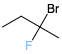

CCC(C)(F)Br
Entry
CHOFBr_G4
CCC(C)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.803,150.157,172.113,191.036,221.135,242.938,274.34],'J/(mol*K)'), H298=(-329.165,'kJ/mol'), S298=(349.61,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([55.3384,61.2826,64.4177,66.767,69.7615,70.869,69.264],'J/(mol*K)'), H298=(-206.444,'kJ/mol'), S298=(85.9841,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsBrCCF) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([55.3384,61.2826,64.4177,66.767,69.7615,70.869,69.264],'J/(mol*K)'), H298=(-206.444,'kJ/mol'), S298=(85.9841,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCF)""")

GAE with fitted GAV
Th

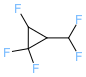

FC(F)C1C(F)C1(F)F
Entry
CHOF_G4
FC(F)C1C(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.64,153.686,175.641,193.494,218.505,234.651,256.845],'J/(mol*K)'), H298=(-928.685,'kJ/mol'), S298=(387.05,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.0756,46.7314,58.9327,68.4903,82.2697,92.2009,108.049],'J/(mol*K)'), H298=(-25.6767,'kJ/mol'), S298=(151.859,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.0756,46.7314,58.9327,68.4903,82.2697,92.2009,108.049],'J/(mol*K)'), H298=(-2

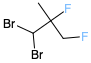

CC(F)(CF)C(Br)Br
Entry
CHOFBr_G4
CC(F)(CF)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.476,182.098,205.436,224.267,251.257,268.274,290.771],'J/(mol*K)'), H298=(-469.075,'kJ/mol'), S298=(426.197,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.8866,102.547,111.853,118.852,128.384,133.439,136.82],'J/(mol*K)'), H298=(-198.491,'kJ/mol'), S298=(167.723,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrBrCsH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.8261,104.654,112.747,119.218,128.376,132.896,134.439],'J/(mol*K

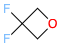

FC1(F)COC1
Entry
CHOF_G4
FC1(F)COC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.1546,107.973,126.501,141.867,165.673,182.2,204.009],'J/(mol*K)'), H298=(-504.472,'kJ/mol'), S298=(306.055,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-12.0458,-10.5236,-6.62809,-2.93778,3.38802,8.40258,15.8121],'J/(mol*K)'), H298=(24.6397,'kJ/mol'), S298=(166.798,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsO2sHH) + missing(Cs-CsO2sHH) + ring(Cs-O2s-Cs-Cs(F)(F))""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'Cs-CsOsHH_Cs-CsO2sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-12.0458,-10.5236,-6.62809,-2.93778,3.38802,8.40258,15.8121],'J/(mol*K)'), H298=(24.6397,'kJ/mol'), S298=(166.798,'J/(mol*K)'), comment="""Thermo group additivity e

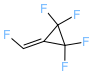

FC=C1C(F)(F)C1(F)F
Entry
CHOF_G4
FCDC1C(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([122.567,144.53,161.673,174.558,191.991,203.637,217.946],'J/(mol*K)'), H298=(-723.412,'kJ/mol'), S298=(375.083,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([2.84402,5.0691,8.42707,10.6103,13.9598,16.8524,24.7569],'J/(mol*K)'), H298=(320.616,'kJ/mol'), S298=(101.664,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + missing(Cs-CdCsF1sF1s) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + ring(Cs-Cs(F)(F)-Cd(Cd))""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CsCCFF_Cs-CdCsF1sF1s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([2.84402,5.0691,8.42707,10.6103,13.9598,16.8524

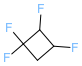

FC1CC(F)(F)C1F
Entry
CHOF_G4
FC1CC(F)(F)C1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.185,143.335,164.493,182.135,209.335,228.019,252.028],'J/(mol*K)'), H298=(-790.36,'kJ/mol'), S298=(354.52,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.8636,58.7965,72.0337,82.3352,97.8419,109.086,125.484],'J/(mol*K)'), H298=(-300.46,'kJ/mol'), S298=(246.301,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + group(CsCsCsFH) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + ring(Cs-Cs-Cs(F)(F)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.863

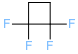

FC1(F)CCC1(F)F
Entry
CHOF_G4
FC1(F)CCC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.802,144.456,165.771,183.331,210.299,228.705,252.095],'J/(mol*K)'), H298=(-819.884,'kJ/mol'), S298=(347.882,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-26.0027,-23.3205,-19.456,-16.8751,-12.8994,-9.04187,-1.17753],'J/(mol*K)'), H298=(147.956,'kJ/mol'), S298=(136.124,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + ring(Cs-Cs-Cs(F)(F)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-26.0027,-23.3205,-19.456,-1

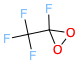

FC(F)(F)C1(F)OO1
Entry
CHOF_G4
FC(F)(F)C1(F)OO1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.726,123.595,136.494,145.727,159.13,167.437,175.566],'J/(mol*K)'), H298=(-887.674,'kJ/mol'), S298=(347.029,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([15.9453,17.9367,19.9933,22.446,27.1806,30.6563,39.3671],'J/(mol*K)'), H298=(128.346,'kJ/mol'), S298=(216.367,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + missing(Cs-CsF1sO2sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + ring(Cs(C-FFF)-O2s-O2s)""")

missing
['CsCFOO_Cs-CsF1sO2sO2s', 'CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([15.6249,17.1188,19.0321,21.5658,26.5472,30.1448,38.3093],'J/(mol*K)'), H298=(100.535,'kJ/mol'), S298=(217.224,'J/(mol*K)'), comme

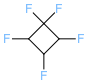

FC1C(F)C(F)(F)C1F
Entry
CHOF_G4
FC1C(F)C(F)(F)C1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.849,153.28,175.161,192.057,217.332,234.725,256.845],'J/(mol*K)'), H298=(-959.39,'kJ/mol'), S298=(368.161,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.8587,97.9929,116.416,130.639,151.656,167.017,190.381],'J/(mol*K)'), H298=(-483.104,'kJ/mol'), S298=(310.285,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + group(CsCsCsFH) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)

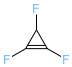

FC1=C(F)C1F
Entry
CHOF_G4
FC1DC(F)C1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([79.5052,94.1015,104.877,113.524,126.602,135.29,145.656],'J/(mol*K)'), H298=(-256.083,'kJ/mol'), S298=(309.538,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(157.975,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([20.0891,27.9183,34.3571,39.09,45.4218,50.1317,56.9429],'J/(mol*K)'), H298=(80.688,'kJ/mol'), S298=(214.157,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCFH) + missing(Cd-CdCsF1s) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cd-Cs(F)-Cd)""")

missing
['CdCsCdF_Cd-CdCsF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([20.0891,27.9183,34.3571,39.09,45.4218,50.1

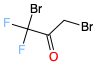

O=C(CBr)C(F)(F)Br
Entry
CHOFBr_G4
ODC(CBr)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.624,145.118,158.003,168.738,184.834,195.381,207.735],'J/(mol*K)'), H298=(-524.654,'kJ/mol'), S298=(435.063,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.275,121.381,130.261,137.361,147.961,155.03,163.477],'J/(mol*K)'), H298=(-391.452,'kJ/mol'), S298=(369.469,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCHH) + longDistanceInteraction_noncyclic(Cs(Br)-CO) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-CO) + missing(CO-CsCsO2d)""")

missing
['Cds-OdCsCs_CO-CsCsO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.676,116.419,126.913,135.567,148.132,156.445,164.455],'J/(mol*K)'), H298=(-432.718,'kJ/mol'), S298=(366.831,'J/(mol*K)'), comment="""Thermo group additivity 

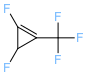

FC1=C(C(F)(F)F)C1F
Entry
CHOF_G4
FC1DC(C(F)(F)F)C1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.135,141.941,159.602,173.428,191.848,203.22,217.851],'J/(mol*K)'), H298=(-758.712,'kJ/mol'), S298=(389.009,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([36.03,44.4275,53.0976,60.443,70.5397,76.8444,86.1092],'J/(mol*K)'), H298=(99.6506,'kJ/mol'), S298=(161.053,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCFH) + missing(Cs-CdF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + group(Cds-CdsCsCs) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + ring(Cs-Cd(C)-Cd(F))""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.5503,46.3058,53.9825,60.7568,70.5616,76.7532,85.4746],'J/(mol*K)'), H298=(94.0809,'

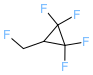

FCC1C(F)(F)C1(F)F
Entry
CHOF_G4
FCC1C(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.132,154.975,176.546,193.965,218.402,234.575,256.778],'J/(mol*K)'), H298=(-901.614,'kJ/mol'), S298=(385.371,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.60947,4.47769,12.1526,18.079,26.2538,32.8816,45.4116],'J/(mol*K)'), H298=(235.04,'kJ/mol'), S298=(99.8917,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sHH) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.60947,4.47769,12.1526,18.079,26.2538,3

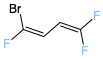

FC(F)=CC=C(F)Br
Entry
CHOFBr_G4
FC(F)DCCDC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([122.169,143.856,160.626,173.054,189.507,200.349,213.36],'J/(mol*K)'), H298=(-442.536,'kJ/mol'), S298=(386.943,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.2131,97.9324,109.602,117.81,129.704,137.59,148.415],'J/(mol*K)'), H298=(-72.4719,'kJ/mol'), S298=(231.843,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + missing(Cd-CdF1sF1s) + group(CdBrCF)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([82.2131,97.9324,109.602,117.81,129.704,137.59,148.415],'J/(mol*K)'), H298=(-72.4719,'kJ/mol'), S298=(231.843,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + group(

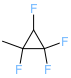

CC1(F)C(F)C1(F)F
Entry
CHOF_G4
CC1(F)C(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.593,148.835,168.638,185.402,211.266,229.071,252.175],'J/(mol*K)'), H298=(-707.741,'kJ/mol'), S298=(366.357,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([47.4997,58.1907,68.717,77.2064,89.1111,97.6419,111.088],'J/(mol*K)'), H298=(-189.263,'kJ/mol'), S298=(182.368,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-

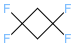

FC1(F)CC(F)(F)C1
Entry
CHOF_G4
FC1(F)CC(F)(F)C1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.617,145.419,167.395,184.717,211.245,229.317,252.313],'J/(mol*K)'), H298=(-837.552,'kJ/mol'), S298=(344.96,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-24.66,-22.1316,-18.6839,-16.0417,-11.799,-8.26616,-2.76558],'J/(mol*K)'), H298=(112.935,'kJ/mol'), S298=(133.085,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + ring(Cs-Cs-Cs(F)(F)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-24.66,-22.1316,-18.6839,-16.0417,-11.799,-8.26616,-2.76558],'J/(mol*K)'), H298=(112.935,'kJ/mol'), S298=(133.085,'J/(mol*K

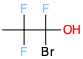

CC(F)(F)C(O)(F)Br
Entry
CHOFBr_G4
CC(F)(F)C(O)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([147.2,167.102,183.2,196.629,216.837,230.198,246.446],'J/(mol*K)'), H298=(-890.243,'kJ/mol'), S298=(404.328,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([51.5804,58.9225,64.0221,67.4259,71.3516,73.0442,72.8595],'J/(mol*K)'), H298=(-216.815,'kJ/mol'), S298=(87.1578,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + group(CsBrCFO) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([53.9903,62.2738,66.9837,70.1996,73.7033,74.7271,72.3635],'J/(mol*K)'), H298=(-232

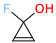

OC1(F)C=C1
Entry
CHOF_G4
OC1(F)CDC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.9332,96.2121,109.916,120.291,135.828,146.486,160.622],'J/(mol*K)'), H298=(-120.149,'kJ/mol'), S298=(297.941,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-10.7446,-10.4456,-8.94066,-8.42059,-8.2893,-7.37346,-4.7093],'J/(mol*K)'), H298=(239.811,'kJ/mol'), S298=(154.33,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CdCdF1sO2s) + missing(Cd-CdCsH) + missing(Cd-CdCsH) + ring(Cs(F)(O2)-Cd-Cd)""")

missing
['O2s-CsH_O2s-CsH', 'CsCCFO_Cs-CdCdF1sO2s', 'Cds-CdsCsH_Cd-CdCsH', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-10.7446,-10.4456,-8.94066,-8.42059,-8.2893,-7.37346,-4.7093],'J/(mol*K)'), H298=(239.811,'kJ/mol'), S298=(154.33,'J/(mol*K)'), comment="""Thermo group a

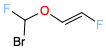

FC=COC(F)Br
Entry
CHOFBr_G4
FCDCOC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([115.779,136.202,152.478,165.001,181.689,192.594,206.591],'J/(mol*K)'), H298=(-464.096,'kJ/mol'), S298=(383.64,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.067,105.593,117.497,126.043,136.469,142.195,148.479],'J/(mol*K)'), H298=(-314.295,'kJ/mol'), S298=(233.97,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrFHO) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.6578,109.369,121.582,129.378,138.35,142.956,149.118],'J/(mol*K)'), H298=(-341.063,'kJ/mol'), S298=(227.72,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsB

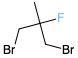

CC(F)(CBr)CBr
Entry
CHOFBr_G4
CC(F)(CBr)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([146.1,173.191,194.539,212.568,240.34,259.428,284.28],'J/(mol*K)'), H298=(-300.426,'kJ/mol'), S298=(407.443,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.54,137.773,153.167,165.535,183.997,195.965,210.138],'J/(mol*K)'), H298=(-260.338,'kJ/mol'), S298=(289.711,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.972,139.768,154.605,166.855,185.2

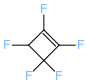

FC1=C(F)C(F)(F)C1F
Entry
CHOF_G4
FC1DC(F)C(F)(F)C1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([118.616,141.331,157.877,170.906,190.407,203.099,217.392],'J/(mol*K)'), H298=(-814.081,'kJ/mol'), S298=(366.628,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([13.8812,22.5751,29.9404,35.6808,44.1535,50.789,61.4693],'J/(mol*K)'), H298=(-7.23619,'kJ/mol'), S298=(193.215,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + group(CsCCFH) + missing(Cd-CdCsF1s) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cds(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cd-Cs-Cs(F)(F)-Cd)""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CdCsCdF_Cd

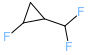

FC(F)C1CC1F
Entry
CHOF_G4
FC(F)C1CC1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.172,133.307,154.559,172.546,200.662,220.427,247.063],'J/(mol*K)'), H298=(-570.348,'kJ/mol'), S298=(345.51,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.694,49.7959,60.1857,69.0678,83.2129,92.6777,104.232],'J/(mol*K)'), H298=(-130.408,'kJ/mol'), S298=(135.585,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsF1sF1sH) + ring(Cs-Cs(C-FF)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.694,49.7959,60.1857,69.0678,83.2129,92.6777,104.232],'J/(mol*K)'), H298=(-130.408,'kJ/mol'), S298=(135.585,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + group(CsC

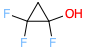

OC1(F)CC1(F)F
Entry
CHOF_G4
OC1(F)CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([106.152,129.031,145.547,158.463,178.186,191.552,208.546],'J/(mol*K)'), H298=(-688.619,'kJ/mol'), S298=(337.105,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-18.2695,-18.2208,-16.6232,-14.9894,-11.8485,-8.4933,-1.86491],'J/(mol*K)'), H298=(231.489,'kJ/mol'), S298=(152.317,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sO2s) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs-Cs(F)(F)-Cs(O2))""")

missing
['O2s-CsH_O2s-CsH', 'CsCCFO_Cs-CsCsF1sO2s', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-18.2695,-18.2208,-16.6232,-14.989

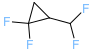

FC(F)C1CC1(F)F
Entry
CHOF_G4
FC(F)C1CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.598,143.439,166.076,184.11,209.867,227.9,252.321],'J/(mol*K)'), H298=(-771.942,'kJ/mol'), S298=(365.038,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.108324,6.86193,14.2936,19.8553,27.6631,33.7189,44.154],'J/(mol*K)'), H298=(168.077,'kJ/mol'), S298=(96.1395,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sF1sH) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.108324,6.86193,14.2936,19.8553,27.6631,33.7189,44.154],'J/(mol*K)'), H298=(168.077,'kJ/mol'), S298=(96.1395,'J/(mol*K)'), comment="""Thermo group additivity

FC=C1CC1
Entry
CHOF_G4
FCDC1CC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([81.4865,101.728,119.393,134.516,158.307,175.244,198.912],'J/(mol*K)'), H298=(5.92277,'kJ/mol'), S298=(297.372,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([48.552,65.0159,79.1485,90.7664,108.657,121.559,141.391],'J/(mol*K)'), H298=(185.53,'kJ/mol'), S298=(179.034,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + group(Cs-(Cds-Cds)CsHH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH) + ring(Cd(Cd-F)-Cs-Cs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([48.552,65.0159,79.1485,90.7664,108.657,121.559,141.391],'J/(mol*K)'), H298=(185.53,'kJ/mol'), S298=(179.034,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + group(Cs-(Cds-Cds)CsHH) + grou

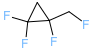

FCC1(F)CC1(F)F
Entry
CHOF_G4
FCC1(F)CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.445,145.88,167.695,184.897,210.292,228.214,252.377],'J/(mol*K)'), H298=(-720.01,'kJ/mol'), S298=(364.688,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([13.9935,19.3857,25.2438,29.7387,35.7813,40.3321,47.2636],'J/(mol*K)'), H298=(-13.1166,'kJ/mol'), S298=(117.998,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.6156,19.7038,25

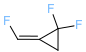

FC=C1CC1(F)F
Entry
CHOF_G4
FCDC1CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.352,123.388,140.871,154.487,175.344,189.834,208.761],'J/(mol*K)'), H298=(-370.588,'kJ/mol'), S298=(335.511,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([25.7672,36.1556,45.379,52.0927,62.3137,69.9061,83.5816],'J/(mol*K)'), H298=(233.737,'kJ/mol'), S298=(138.915,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + missing(Cs-CdCsF1sF1s) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH) + ring(Cs-Cs(F)(F)-Cd(Cd))""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([25.7672,36.1556,45.379,52.0927,62.3137,69.9061,83.5816],'J/(mol*K)'), H298=(233.737,'kJ/mol'), S298=(138.915,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)

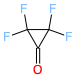

O=C1C(F)(F)C1(F)F
Entry
CHOF_G4
ODC1C(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([107.205,123.73,136.419,145.892,158.091,165.749,174.889],'J/(mol*K)'), H298=(-661.431,'kJ/mol'), S298=(352.305,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.31203,-7.76506,-7.13582,-7.46289,-8.53831,-8.2614,-1.30795],'J/(mol*K)'), H298=(357.51,'kJ/mol'), S298=(154.512,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-COCsF1sF1s) + missing(Cs-COCsF1sF1s) + missing(CO-CsCsO2d) + longDistanceInteraction_cyclic(Cs(F)2-CO) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)2-CO) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + ring(Cs(F)(F)-Cs-CO(O2d))""")

missing
['CsCCFF_Cs-COCsF1sF1s', 'CsCCFF_Cs-COCsF1sF1s', 'Cds-OdCsCs_CO-CsCsO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,6

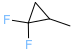

CC1CC1(F)F
Entry
CHOF_G4
CC1CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([100.881,126.493,147.649,165.527,193.814,214.115,242.734],'J/(mol*K)'), H298=(-369.611,'kJ/mol'), S298=(325.911,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.108324,6.86193,14.2936,19.8553,27.6631,33.7189,44.154],'J/(mol*K)'), H298=(168.077,'kJ/mol'), S298=(96.1395,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.108324,6.86193,14.2936,19.8553,27.6631,33.7189,44.154],'J/(mol*K)'), H298=(168.077,'kJ/mol'), S298=(96.1395,'J/(mol*K)'), comment="""Thermo group additivity estimation:

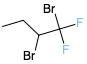

CCC(Br)C(F)(F)Br
Entry
CHOFBr_G4
CCC(Br)C(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([154.029,180.444,201.482,218.406,243.731,261.636,286.787],'J/(mol*K)'), H298=(-493.113,'kJ/mol'), S298=(432.436,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([102.954,115.439,124.737,132.064,142.556,148.511,153.293],'J/(mol*K)'), H298=(-421.401,'kJ/mol'), S298=(273.215,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsBrCsCsH) + missing(Cs-CsHHH) + group(CsBrCFF) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.094,116.611,125.61,132.756,143.028,148.76,152.133],'J/(mol*K)'), H298=(-433.658,'kJ/mol'), S298=(269.588,'J/(mol*K)'), comment="""Thermo group additivity esti

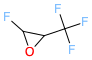

FC1OC1C(F)(F)F
Entry
CHOF_G4
FC1OC1C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.102,131.123,149.699,163.79,183.468,196.889,213.752],'J/(mol*K)'), H298=(-940.82,'kJ/mol'), S298=(356.728,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([54.1052,69.0685,81.7955,91.5558,105.612,115.397,128.604],'J/(mol*K)'), H298=(-234.01,'kJ/mol'), S298=(181.247,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(Cs-CsCsOsH) + group(CsCFHO) + missing(Cs-CsF1sF1sF1s) + ring(O2s-Cs-Cs(C-FFF))""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([54.1052,69.0685,81.7955,91.5558,105.612,115.397,128.604],'J/(mol*K)'), H298=(-234.01,'kJ/mol'), S298=(181.247,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(Cs-CsCsOsH) + group(Cs

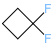

FC1(F)CCC1
Entry
CHOF_G4
FC1(F)CCC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.4103,120.477,143.25,162.636,192.821,213.952,242.54],'J/(mol*K)'), H298=(-415.217,'kJ/mol'), S298=(312.739,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-24.66,-22.1316,-18.6839,-16.0417,-11.799,-8.26616,-2.76558],'J/(mol*K)'), H298=(112.935,'kJ/mol'), S298=(133.085,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + ring(Cs-Cs-Cs(F)(F)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-24.66,-22.1316,-18.6839,-16.0417,-11.799,-8.26616,-2.76558],'J/(mol*K)'), H298=(112.935,'kJ/mol'), S298=(133.085,'J/(mol*K)'), comment="""Ther

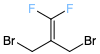

FC(F)=C(CBr)CBr
Entry
CHOFBr_G4
FC(F)DC(CBr)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([139.417,165.259,185.152,199.97,220.636,234.621,251.932],'J/(mol*K)'), H298=(-358.967,'kJ/mol'), S298=(411.929,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.5469,114.267,127.843,139.204,156.473,168.484,183.406],'J/(mol*K)'), H298=(13.0163,'kJ/mol'), S298=(277.801,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCHH) + group(CsBrCHH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.5469,114.267,127.843,139.204,156.473,168.484,183.406],'J/(mol*K)'), H298=(13.0163,'kJ/mol'), S298=(277.801,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCHH) + group(CsBrCHH) + group(Cds-CdsCsCs)""")

GAE with fitted

FC=C1CO1
Entry
CHOF_G4
FCDC1CO1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([73.7462,89.8615,103.284,114.328,131.568,143.705,160.228],'J/(mol*K)'), H298=(-99.5742,'kJ/mol'), S298=(292.429,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.015,51.1895,59.753,67.0897,78.9327,87.5533,99.7089],'J/(mol*K)'), H298=(77.655,'kJ/mol'), S298=(169.25,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(Cs-(Cds-Cds)OsHH) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + ring(Cd(Cd-F)-Cs-O2s)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.015,51.1895,59.753,67.0897,78.9327,87.5533,99.7089],'J/(mol*K)'), H298=(77.655,'kJ/mol'), S298=(169.25,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(Cs-(Cds-Cds)OsHH) + group(Cds-

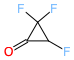

O=C1C(F)C1(F)F
Entry
CHOF_G4
ODC1C(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.8437,112.541,125.622,135.442,149.289,158.684,170.298],'J/(mol*K)'), H298=(-478.787,'kJ/mol'), S298=(342.07,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([27.4368,33.1414,38.1011,41.465,46.7798,51.302,60.5501],'J/(mol*K)'), H298=(96.3107,'kJ/mol'), S298=(207.151,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCFH) + missing(Cs-COCsF1sF1s) + missing(CO-CsCsO2d) + longDistanceInteraction_cyclic(Cs(F)-CO) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)2-CO) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + ring(Cs(F)(F)-Cs-CO(O2d))""")

missing
['CsCCFF_Cs-COCsF1sF1s', 'Cds-OdCsCs_CO-CsCsO2d']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([27.4368,33.1414,38.1011

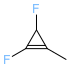

CC1=C(F)C1F
Entry
CHOF_G4
CC1DC(F)C1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.8553,113.159,130.099,144.374,165.846,181.273,203.653],'J/(mol*K)'), H298=(-147.747,'kJ/mol'), S298=(332.637,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.5503,46.3058,53.9825,60.7568,70.5616,76.7532,85.4746],'J/(mol*K)'), H298=(94.0809,'kJ/mol'), S298=(158.978,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCFH) + missing(Cs-CdHHH) + group(Cds-CdsCsCs) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + ring(Cs-Cd(C)-Cd(F))""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdCs)CdHHH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.5503,46.3058,53.9825,60.7568,70.5616,76.7532,85.4746],'J/(mol*K)'), H298=(94.0809,'kJ/mol'), S298=(158.978,'J/(mol*K)'), comment="""Thermo group

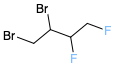

FCC(F)C(Br)CBr
Entry
CHOFBr_G4
FCC(F)C(Br)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([153.553,180.595,202.579,220.568,247.717,266.319,290.083],'J/(mol*K)'), H298=(-460.04,'kJ/mol'), S298=(435.756,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([115.114,136.486,153.585,166.93,186.123,198.449,213.319],'J/(mol*K)'), H298=(-238.406,'kJ/mol'), S298=(277.373,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrCsCsH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br)) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsBrCsHH) + longDistanceInteraction_noncyclic(Cs(Br)-Cs(Br))""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
T

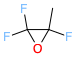

CC1(F)OC1(F)F
Entry
CHOF_G4
CC1(F)OC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.48,125.482,141.688,155.289,176.199,190.504,208.834],'J/(mol*K)'), H298=(-743.147,'kJ/mol'), S298=(338.061,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.50081,-9.57889,-8.10066,-5.9537,-1.79657,3.05,14.3176],'J/(mol*K)'), H298=(80.4112,'kJ/mol'), S298=(199.266,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-CsCsF1sO2s) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsHHH) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs(C)-Cs(F)(F)-O2s)""")

missing
['CsCCFO_Cs-CsCsF1sO2s', 'CsCFFO_Cs-CsF1sF1sO2s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-6.50081,-9.57889,-8.10066,-5.9537,-1.79657,3.05,14.3176],'J/(m

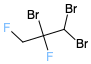

FCC(F)(Br)C(Br)Br
Entry
CHOFBr_G4
FCC(F)(Br)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([147.742,169.902,186.208,198.178,213.809,223.427,235.036],'J/(mol*K)'), H298=(-394.029,'kJ/mol'), S298=(436.372,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.995,121.306,130.602,137.595,147.165,152.582,156.54],'J/(mol*K)'), H298=(-170.154,'kJ/mol'), S298=(294.547,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCCF) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsF1sHH) + group(CsBrBrCsH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([113.101,126.129,134.579,141.231,150.183,154.603,155.141],'J/(mol*K)'), H298=(-195.728,'k

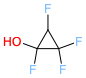

OC1(F)C(F)C1(F)F
Entry
CHOF_G4
OC1(F)C(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.816,138.931,154.275,166.941,185.974,198.491,213.249],'J/(mol*K)'), H298=(-835.851,'kJ/mol'), S298=(358.543,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.6146,20.2662,26.9105,32.7262,41.8181,49.2573,62.6982],'J/(mol*K)'), H298=(62.5091,'kJ/mol'), S298=(216.665,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sO2s) + group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs-Cs(F)(F)-Cs(O2))""")

missing
['O2s-CsH_O2s-CsH', 'CsCCFO_Cs-

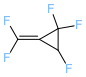

FC(F)=C1C(F)C1(F)F
Entry
CHOF_G4
FC(F)DC1C(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.602,142.243,159.741,173.457,191.827,203.166,217.839],'J/(mol*K)'), H298=(-735.435,'kJ/mol'), S298=(382.286,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([36.5417,45.3757,53.6026,59.9119,69.2159,75.8667,86.3981],'J/(mol*K)'), H298=(72.8443,'kJ/mol'), S298=(154.824,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCFH) + missing(Cs-CdCsF1sF1s) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs-Cs(F)(F)-Cd(Cd))""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([36.5417,45.3757,53.6026,59.9119,69.2159,75.8667,86.3981],'J/(mol*K)'), H298=(72.84

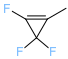

CC1=C(F)C1(F)F
Entry
CHOF_G4
CC1DC(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.687,124.728,141.362,154.752,174.706,188.9,208.419],'J/(mol*K)'), H298=(-361.24,'kJ/mol'), S298=(344.152,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.86284,6.8523,8.84257,11.3063,15.2873,17.546,23.0005],'J/(mol*K)'), H298=(327.845,'kJ/mol'), S298=(105.022,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCdF1sF1s) + missing(Cs-CdHHH) + group(Cds-CdsCsCs) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cds(F)) + ring(Cs-Cd(C)-Cd(F))""")

missing
['CsCCFF_Cs-CdCdF1sF1s', 'Cs-(Cds-Cds)HHH_Cs-(CdCs)CdHHH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.86284,6.8523,8.84257,11.3063,15.2873,17.546,23.0005],'J/(mol*K)'), H298=(327.845,'kJ/mol'), S298=(105.02

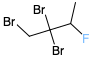

CC(F)C(Br)(Br)CBr
Entry
CHOFBr_G4
CC(F)C(Br)(Br)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([158.424,187.323,210.712,229.507,256.501,273.709,295.531],'J/(mol*K)'), H298=(-265.714,'kJ/mol'), S298=(438.9,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([132.694,152.568,167.778,179.682,196.946,207.492,218.639],'J/(mol*K)'), H298=(-223.943,'kJ/mol'), S298=(315.624,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + group(CsBrBrCsCs) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Br)2-Cs(Br)) + missing(Cs-CsHHH) + group(CsBrCsHH)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.621,156.087,170.111,181.458,198.16,208.032,216.953],'J/(mol*K)'), H298=(-243.724,'kJ/mol'), S298=(314.649,'J/(mol*K)'), comment=""

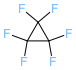

FC1(F)C(F)(F)C1(F)F
Entry
CHOF_G4
FC1(F)C(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([121.842,141.071,154.387,165.094,180.608,190.101,199.186],'J/(mol*K)'), H298=(-1023.3,'kJ/mol'), S298=(351.372,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(207.862,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-22.5048,-22.8916,-20.0693,-17.9658,-15.1034,-11.4244,-1.85784],'J/(mol*K)'), H298=(367.965,'kJ/mol'), S298=(156.621,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + ring(Cs-Cs(F)(F)-Cs)""")

missing
[

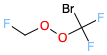

FCOOC(F)(F)Br
Entry
CHOFBr_G4
FCOOC(F)(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.935,145.066,160.77,173.488,191.584,202.295,211.828],'J/(mol*K)'), H298=(-743.563,'kJ/mol'), S298=(379.879,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.9731,103.94,110.875,116.41,125.544,132.178,134.339],'J/(mol*K)'), H298=(-492.62,'kJ/mol'), S298=(275.73,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + missing(Cs-F1sO2sHH) + group(CsBrFFO)""")

missing
['CsFHHO_Cs-F1sO2sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.9731,103.94,110.875,116.41,125.544,132.178,134.339],'J/(mol*K)'), H298=(-492.62,'kJ/mol'), S298=(275.73,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + group(CsBrFFO)""")

GAE with fitted GAV
ThermoDa

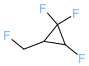

FCC1C(F)C1(F)F
Entry
CHOF_G4
FCC1C(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.979,143.261,165.147,183.353,209.618,227.154,252.061],'J/(mol*K)'), H298=(-708.603,'kJ/mol'), S298=(368.423,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.0756,46.7314,58.9327,68.4903,82.2697,92.2009,108.049],'J/(mol*K)'), H298=(-25.6767,'kJ/mol'), S298=(151.859,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sHH) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.0756,46.7314,58.9327,68.4903,82.2697,92.2009,108.049],'J/(mol*K)'), H298=(-25.6767,'

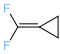

FC(F)=C1CC1
Entry
CHOF_G4
FC(F)DC1CC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.2637,112.421,129.513,143.799,166.181,181.985,203.534],'J/(mol*K)'), H298=(-195.398,'kJ/mol'), S298=(310.477,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.3941,66.1659,80.4964,92.1135,109.317,121.712,141.723],'J/(mol*K)'), H298=(182.649,'kJ/mol'), S298=(181.114,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + group(Cs-(Cds-Cds)CsHH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s) + ring(Cs-Cd(Cd-FF)-Cs)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.3941,66.1659,80.4964,92.1135,109.317,121.712,141.723],'J/(mol*K)'), H298=(182.649,'kJ/mol'), S298=(181.114,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + group(Cs-(Cds-

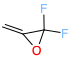

C=C1OC1(F)F
Entry
CHOF_G4
CDC1OC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([83.6165,101.762,115.701,126.124,141.698,152.147,165.173],'J/(mol*K)'), H298=(-359.75,'kJ/mol'), S298=(305.145,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.6184,20.7848,23.9408,26.5281,31.2235,34.9224,40.7232],'J/(mol*K)'), H298=(136.083,'kJ/mol'), S298=(131.231,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-CdF1sF1sO2s) + group(Cds-CdsCsOs) + missing(Cd-CdHH) + ring(O2s-Cs(F)(F)-Cd(Cd))""")

missing
['CsCFFO_Cs-CdF1sF1sO2s', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([17.6184,20.7848,23.9408,26.5281,31.2235,34.9224,40.7232],'J/(mol*K)'), H298=(136.083,'kJ/mol'), S298=(131.231,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-C

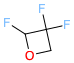

FC1OCC1(F)F
Entry
CHOF_G4
FC1OCC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.22,118.781,136.649,151.284,173.779,189.141,208.567],'J/(mol*K)'), H298=(-719.657,'kJ/mol'), S298=(333.525,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([24.6863,32.5231,40.5525,47.4758,58.5757,67.0565,79.4296],'J/(mol*K)'), H298=(-238.419,'kJ/mol'), S298=(232.175,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-CsCsF1sF1s) + group(CsCFHO) + missing(Cs-CsO2sHH) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(O2s-Cs-Cs-Cs(F))""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([24.6863,32.5231,40.5525,47.4758,58.5757,67.0565,79.4296],'J/(mol*K)'), H298=(-238.419,'kJ/mol'), S298=(23

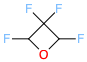

FC1OC(F)C1(F)F
Entry
CHOF_G4
FC1OC(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([105.045,128.294,147.246,161.701,181.934,195.778,213.294],'J/(mol*K)'), H298=(-928.744,'kJ/mol'), S298=(344.177,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.8813,74.8482,89.5564,101.13,118.007,130.135,146.586],'J/(mol*K)'), H298=(-473.746,'kJ/mol'), S298=(280.599,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-CsCsF1sF1s) + group(CsCFHO) + group(CsCFHO) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(O2s-Cs-Cs-Cs(F))""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.8813,74.8482,89.5564,101.13,118.

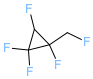

FCC1(F)C(F)C1(F)F
Entry
CHOF_G4
FCC1(F)C(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([130.166,155.545,176.78,194.101,218.777,234.682,256.805],'J/(mol*K)'), H298=(-865.707,'kJ/mol'), S298=(386.695,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([46.8776,57.8727,68.7775,77.4543,89.4479,98.0827,111.827],'J/(mol*K)'), H298=(-182.097,'kJ/mol'), S298=(182.346,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs(F)(F)-Cs(C)-Cs)"

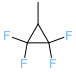

CC1C(F)(F)C1(F)F
Entry
CHOF_G4
CC1C(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.389,148.283,168.163,184.91,210.83,228.756,252.16],'J/(mol*K)'), H298=(-729.524,'kJ/mol'), S298=(359.106,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.60947,4.47769,12.1526,18.079,26.2538,32.8816,45.4116],'J/(mol*K)'), H298=(235.04,'kJ/mol'), S298=(99.8917,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-1.60947,4.47769,12.1526,18.079,26.2538,32.8816,4

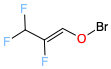

FC(=COBr)C(F)F
Entry
CHOFBr_G4
FC(DCOBr)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([122.435,138.986,152.966,164.637,182.195,193.754,207.327],'J/(mol*K)'), H298=(-548.4,'kJ/mol'), S298=(418.512,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.8014,59.5305,64.949,69.3064,75.1463,79,84.5209],'J/(mol*K)'), H298=(50.955,'kJ/mol'), S298=(194.22,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + missing(Cs-CdF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cds(F)) + missing(Cd-CdCsF1s) + longDistanceInteraction_noncyclic(Cd(F)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCFFH_Cs-CdF1sF1sH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([54.4271,62.9589,68.6628,72.342,76.7218,79.3255,83.5423],'J/(mol*K)'), H298=(7.59318,'kJ/mol'), S298=(188.255,'J/(mol*K)'), comme

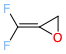

FC(F)=C1CO1
Entry
CHOF_G4
FC(F)DC1CO1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.688,100.808,113.283,123.703,139.745,150.743,164.845],'J/(mol*K)'), H298=(-281.704,'kJ/mol'), S298=(311.707,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.1232,53.3254,61.5148,68.4744,79.6213,87.899,100.001],'J/(mol*K)'), H298=(95.6449,'kJ/mol'), S298=(175.618,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(Cs-(Cds-Cds)OsHH) + group(Cds-CdsCsOs) + missing(Cd-CdF1sF1s) + ring(O2s-Cs-Cd(Cd-FF))""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([43.1232,53.3254,61.5148,68.4744,79.6213,87.899,100.001],'J/(mol*K)'), H298=(95.6449,'kJ/mol'), S298=(175.618,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(Cs-(Cds-Cds)Os

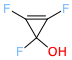

OC1(F)C(F)=C1F
Entry
CHOF_G4
OC1(F)C(F)DC1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([100.441,116.245,127.467,136.523,150.115,159.025,169.404],'J/(mol*K)'), H298=(-442.875,'kJ/mol'), S298=(345.77,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-12.3644,-12.9666,-12.607,-11.3634,-10.0961,-8.21773,-3.03973],'J/(mol*K)'), H298=(337.21,'kJ/mol'), S298=(161.945,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CdCdF1sO2s) + missing(Cd-CdCsF1s) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cd-Cd(F)-Cs(O2))""")

missing
['O2s-CsH_O2s-CsH', 'CsCCFO_Cs-CdCdF1sO2s', 'CdCsCdF_Cd-CdCsF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=(

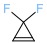

FC1(F)C=C1
Entry
CHOF_G4
FC1(F)CDC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([69.9274,84.9755,97.5203,107.259,121.378,130.662,141.835],'J/(mol*K)'), H298=(-148.519,'kJ/mol'), S298=(277.925,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(157.975,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-10.0129,-8.75799,-7.01945,-6.73051,-6.99569,-6.74377,-5.08519],'J/(mol*K)'), H298=(223.719,'kJ/mol'), S298=(146.793,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCdF1sF1s) + missing(Cd-CdCsH) + missing(Cd-CdCsH) + ring(Cd-Cd-Cs(F)(F))""")

missing
['CsCCFF_Cs-CdCdF1sF1s', 'Cds-CdsCsH_Cd-CdCsH', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-10.0129,-8.75799,-7.01945,-6.73051,-6.99569,-6.74377,-5.08519],'J/(mol*K)'), H298=(223.719,'kJ/mol'), S298=(146.793,'J/(mol*K)'), comment="""Thermo group additivity estimation: ring(Cd-Cd-

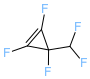

FC1=C(F)C1(F)C(F)F
Entry
CHOF_G4
FC1DC(F)C1(F)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([121.647,142.682,159.604,172.94,191.183,202.454,217.355],'J/(mol*K)'), H298=(-679.414,'kJ/mol'), S298=(379.012,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.2075,25.8168,29.7998,32.5963,36.6418,39.0077,42.3016],'J/(mol*K)'), H298=(130.112,'kJ/mol'), S298=(125.704,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + missing(Cd-CdCsF1s) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cs-Cd(F)-Cd)""")

missing
['CsCsFFH_Cs-CsF1sF1sH', 'CdCsCdF_Cd-CdCsF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estima

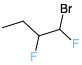

CCC(F)C(F)Br
Entry
CHOFBr_G4
CCC(F)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.791,159.937,181.609,200.186,229.453,250.318,279.364],'J/(mol*K)'), H298=(-491.124,'kJ/mol'), S298=(383.073,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.6002,100.314,110.798,119.128,131.438,139.213,147.866],'J/(mol*K)'), H298=(-422.967,'kJ/mol'), S298=(230.045,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsHHH) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([88.2955,101.785,111.814,119.99,132.104,139.551,146.963],'J/(mol*K)'), H298=(-432.735,'kJ/mol'), S298=(227.528,'J/(mol*K)'), comment="""Thermo group additivity estimation: 

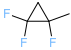

CC1(F)CC1(F)F
Entry
CHOF_G4
CC1(F)CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([113.638,138.98,159.256,176.46,203.311,222.16,247.636],'J/(mol*K)'), H298=(-551.03,'kJ/mol'), S298=(344.048,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.6156,19.7038,25.1833,29.4908,35.4445,39.8913,46.5246],'J/(mol*K)'), H298=(-20.2827,'kJ/mol'), S298=(118.02,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([14.6156,19.7038,25.1833,29.4908,35.4445,39.8913,46.5246],'J/(mol*K)'), H298

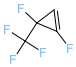

FC1=CC1(F)C(F)(F)F
Entry
CHOF_G4
FC1DCC1(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.143,146.376,162.77,175.061,193.333,205.129,218.17],'J/(mol*K)'), H298=(-774.273,'kJ/mol'), S298=(375.966,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([22.9606,28.174,32.2465,34.8754,38.6095,40.432,42.3922],'J/(mol*K)'), H298=(85.7542,'kJ/mol'), S298=(118.774,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cds(F)) + missing(Cd-CdCsF1s) + missing(Cd-CdCsH) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + ring(Cs-Cd(F)-Cd)""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s', 'CdCsCdF_Cd-CdCsF1s', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([25.1605,29.2344,3

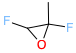

CC1(F)OC1F
Entry
CHOF_G4
CC1(F)OC1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.1971,113.881,130.64,144.856,167.11,182.801,204.107],'J/(mol*K)'), H298=(-530.044,'kJ/mol'), S298=(321.628,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.887,32.891,40.4918,47.1667,57.0711,65.1121,78.7285],'J/(mol*K)'), H298=(-196.765,'kJ/mol'), S298=(247.698,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-CsCsF1sO2s) + group(CsCFHO) + missing(Cs-CsHHH) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs(F)(C)-Cs-O2s)""")

missing
['CsCCFO_Cs-CsCsF1sO2s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([26.887,32.891,40.4918,47.1667,57.0711,65.1121,78.7285],'J/(mol*K)'), H298=(-196.765,'kJ/mol'), S298=(247.698,'J/(mol*

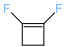

FC1=C(F)CC1
Entry
CHOF_G4
FC1DC(F)CC1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([85.6068,107.217,125.585,140.838,164.545,181.099,203.244],'J/(mol*K)'), H298=(-226.765,'kJ/mol'), S298=(300.455,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([27.2004,41.7727,55.1941,66.3526,83.2326,95.9019,114.458],'J/(mol*K)'), H298=(124.74,'kJ/mol'), S298=(204.724,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-(Cds-Cds)CsHH) + group(Cs-(Cds-Cds)CsHH) + missing(Cd-CdCsF1s) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cd(F)-Cd-Cs-Cs)""")

missing
['CdCsCdF_Cd-CdCsF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([27.2004,41.7727,55.1941,66.3526,83.2326,95.9019,114.458],'J/(mol*K)'), H298=(124.74,'kJ/mol'),

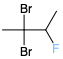

CC(F)C(C)(Br)Br
Entry
CHOFBr_G4
CC(F)C(C)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([143.632,167.724,188.487,206.284,234.326,254.327,282.227],'J/(mol*K)'), H298=(-292.93,'kJ/mol'), S298=(410.614,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.4716,104.635,113.086,119.545,128.857,133.901,137.553],'J/(mol*K)'), H298=(-210.307,'kJ/mol'), S298=(158.182,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + group(CsBrBrCsCs) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.1669,106.107,114.101,120.407,129.522,134.24,136.65],'J/(mol*K)'), H298=(-220.075,'kJ/mol'), S298=(155.665,'J/(mol*K)'), comment="""Thermo group additivity estimati

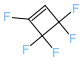

FC1=CC(F)(F)C1(F)F
Entry
CHOF_G4
FC1DCC(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.558,143.157,159.7,172.659,191.9,204.247,217.743],'J/(mol*K)'), H298=(-855.943,'kJ/mol'), S298=(356.971,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-17.0506,-14.4642,-12.2889,-11.2779,-9.28544,-7.00774,-0.405331],'J/(mol*K)'), H298=(164.077,'kJ/mol'), S298=(132.368,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + missing(Cs-CdCsF1sF1s) + missing(Cd-CdCsF1s) + missing(Cd-CdCsH) + longDistanceInteraction_cyclic(Cs(F)2-Cds(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + ring(Cd-Cs-Cs(F)(F)-Cd)""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CsCCFF_Cs-CdCsF1sF1s', 'CdCsCdF_Cd-CdCsF1s', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,

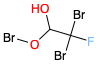

OC(OBr)C(F)(Br)Br
Entry
CHOFBr_G4
OC(OBr)C(F)(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([155.109,170.925,181.064,189.138,200.276,206.489,211.353],'J/(mol*K)'), H298=(-394.884,'kJ/mol'), S298=(430.248,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.9,141.269,152.686,159.699,168.882,174.727,175.813],'J/(mol*K)'), H298=(-236.428,'kJ/mol'), S298=(325.783,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(O2sBrC) + group(Cs-CsOsOsH) + group(CsBrBrCF) + longDistanceInteraction_noncyclic(Cs(Val7)3-CsOs)""")

missing
['O2s-CsH_O2s-CsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.62,141.066,152.571,159.109,167.388,173.248,173.705],'J/(mol*K)'), H298=(-237.873,'kJ/mol'), S298=(332.363,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sBrC) + group(Cs

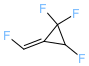

FC=C1C(F)C1(F)F
Entry
CHOF_G4
FCDC1C(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.397,132.941,150.499,164.188,183.21,196.226,213.251],'J/(mol*K)'), H298=(-533.111,'kJ/mol'), S298=(363.241,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([36.5417,45.3757,53.6026,59.9119,69.2159,75.8667,86.3981],'J/(mol*K)'), H298=(72.8443,'kJ/mol'), S298=(154.824,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCFH) + missing(Cs-CdCsF1sF1s) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + ring(Cs-Cs(F)(F)-Cd(Cd))""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([36.5417,45.3757,53.6026,59.9119,69.2159,75.8667,86.3981],'J/(mol*K)'), H298=(72.8443,'kJ/mol'

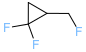

FCC1CC1(F)F
Entry
CHOF_G4
FCC1CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([106.832,132.847,155.439,173.919,201.032,220.382,247.545],'J/(mol*K)'), H298=(-548.65,'kJ/mol'), S298=(346.527,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.108324,6.86193,14.2936,19.8553,27.6631,33.7189,44.154],'J/(mol*K)'), H298=(168.077,'kJ/mol'), S298=(96.1395,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sHH) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-0.108324,6.86193,14.2936,19.8553,27.6631,33.7189,44.154],'J/(mol*K)'), H298=(168.077,'kJ/mol'), S298=(96.1395,'J/(mol*K)'), comment="""Thermo group additivity estimat

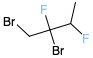

CC(F)C(F)(Br)CBr
Entry
CHOFBr_G4
CC(F)C(F)(Br)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([152.705,183.635,208.484,227.646,253.452,270.633,292.723],'J/(mol*K)'), H298=(-485.532,'kJ/mol'), S298=(420.838,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.93,150.052,164.733,176.166,192.895,203.406,214.725],'J/(mol*K)'), H298=(-441.309,'kJ/mol'), S298=(299.234,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + group(CsBrCCF) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsHHH) + group(CsBrCsHH)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.321,152.994,166.763,177.89,194.226,204.083,212.919],'J/(mol*K)'), H298=(-460.844,'kJ/mol'), S298=(294.2,'J/(mol*K)'), comment="""T

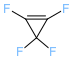

FC1=C(F)C1(F)F
Entry
CHOF_G4
FC1DC(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.6427,105.478,115.634,123.752,135.612,142.993,150.434],'J/(mol*K)'), H298=(-465.532,'kJ/mol'), S298=(320.126,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(157.975,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-13.4929,-12.7041,-11.5403,-10.741,-9.83547,-8.78204,-4.9117],'J/(mol*K)'), H298=(328.433,'kJ/mol'), S298=(154.185,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCdF1sF1s) + missing(Cd-CdCsF1s) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cds(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cd-Cd-Cs(F)(F))""")

missing
['CsCCFF_Cs-CdCdF1sF1s', 'CdCsCdF_Cd-CdCsF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,100

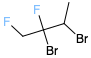

CC(Br)C(F)(Br)CF
Entry
CHOFBr_G4
CC(Br)C(F)(Br)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([158.584,182.867,203.285,220.457,246.672,264.445,287.192],'J/(mol*K)'), H298=(-467.937,'kJ/mol'), S298=(427.979,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.562,106.021,114.566,120.829,129.429,134.03,137.146],'J/(mol*K)'), H298=(-202.971,'kJ/mol'), S298=(159.244,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCsCsH) + group(CsBrCCF) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH)""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([96.9527,108.963,116.596,122.554,130.76,134.706,135.34],'J/(mol*K)'), H298=(-222.507,'kJ/mol'), S298=(154.21,

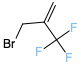

C=C(CBr)C(F)(F)F
Entry
CHOFBr_G4
CDC(CBr)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.838,150.135,169.019,184.893,209.089,225.426,245.986],'J/(mol*K)'), H298=(-635.742,'kJ/mol'), S298=(373.923,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.3507,66.7775,74.3606,80.606,90.3702,96.9613,105.008],'J/(mol*K)'), H298=(28.1395,'kJ/mol'), S298=(112.332,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCHH) + missing(Cs-CdF1sF1sF1s) + group(Cds-CdsCsCs) + missing(Cd-CdHH)""")

missing
['CsCdFFF_Cs-CdF1sF1sF1s', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.3507,66.7775,74.3606,80.606,90.3702,96.9613,105.008],'J/(mol*K)'), H298=(28.1395,'kJ/mol'), S298=(112.332,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrCHH) + group(Cds-CdsCsCs)""")



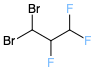

FC(F)C(F)C(Br)Br
Entry
CHOFBr_G4
FC(F)C(F)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([140.139,161.917,178.438,190.959,207.972,218.775,232.523],'J/(mol*K)'), H298=(-632.723,'kJ/mol'), S298=(423.445,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.3609,104.47,115.537,123.95,135.882,143.332,151.504],'J/(mol*K)'), H298=(-190.711,'kJ/mol'), S298=(252.919,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsF1sF1sH) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + group(CsBrBrCsH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['CsCsFFH_Cs-CsF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.2908,106.578,116.497,124.536,136.248,143.156,149.228],'J/(mol*K)'), H298=(-220.035,'kJ/mol'), S298=(249.59,'J/(mol*K)'), comment="""Thermo group ad

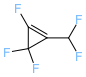

FC1=C(C(F)F)C1(F)F
Entry
CHOF_G4
FC1DC(C(F)F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.375,141.13,158.109,171.807,191.242,203.001,217.383],'J/(mol*K)'), H298=(-727.224,'kJ/mol'), S298=(388.134,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.86284,6.8523,8.84257,11.3063,15.2873,17.546,23.0005],'J/(mol*K)'), H298=(327.845,'kJ/mol'), S298=(105.022,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCdF1sF1s) + missing(Cs-CdF1sF1sH) + group(Cds-CdsCsCs) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cds(F)) + ring(Cs-Cd(C)-Cd(F))""")

missing
['CsCCFF_Cs-CdCdF1sF1s', 'CsCFFH_Cs-CdF1sF1sH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.86284,6.8523,8.84257,11.3063,15.2873,17.546,23.0005],'J/(mol*K)'), H298=(327.845,'kJ/mol'), S298=(105

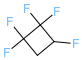

FC1CC(F)(F)C1(F)F
Entry
CHOF_G4
FC1CC(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.583,154.863,176.653,193.26,218.398,235.524,256.952],'J/(mol*K)'), H298=(-995.432,'kJ/mol'), S298=(371.601,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([8.29227,17.2585,26.0317,32.3483,41.8547,49.6204,63.0519],'J/(mol*K)'), H298=(-59.4615,'kJ/mol'), S298=(191.479,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + ring(Cs-Cs-Cs(F)(F)-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400

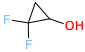

OC1CC1(F)F
Entry
CHOF_G4
OC1CC1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.11,117.957,134.251,147.916,169.176,184.03,203.983],'J/(mol*K)'), H298=(-485.475,'kJ/mol'), S298=(331.446,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.06513,12.6713,19.293,24.2285,31.3316,36.7163,44.7017],'J/(mol*K)'), H298=(169.392,'kJ/mol'), S298=(93.7791,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + group(Cs-CsCsOsH) + missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + ring(Cs-Cs(F)(F)-Cs(O2))""")

missing
['O2s-CsH_O2s-CsH', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([5.06513,12.6713,19.293,24.2285,31.3316,36.7163,44.7017],'J/(mol*K)'), H298=(169.392,'kJ/mol'), S298=(93.7791,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs

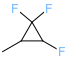

CC1C(F)C1(F)F
Entry
CHOF_G4
CC1C(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.927,136.894,157.447,174.717,201.876,221.15,247.549],'J/(mol*K)'), H298=(-533.464,'kJ/mol'), S298=(347.784,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.0756,46.7314,58.9327,68.4903,82.2697,92.2009,108.049],'J/(mol*K)'), H298=(-25.6767,'kJ/mol'), S298=(151.859,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cs-CsCsCsH) + group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsHHH) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + ring(Cs(F)(F)-Cs(C)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([34.0756,46.7314,58.9327,68.4903,82.2697,92.2009,108.049],'J/(mol*K)'), H298=(-25.6767,'kJ/mol

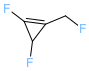

FCC1=C(F)C1F
Entry
CHOF_G4
FCC1DC(F)C1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([100.87,120.132,137.079,151.632,173.794,188.189,207.987],'J/(mol*K)'), H298=(-312.052,'kJ/mol'), S298=(353.466,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.5503,46.3058,53.9825,60.7568,70.5616,76.7532,85.4746],'J/(mol*K)'), H298=(94.0809,'kJ/mol'), S298=(158.978,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCFH) + missing(Cs-CdF1sHH) + group(Cds-CdsCsCs) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + ring(Cs-Cd(C)-Cd(F))""")

missing
['CsCFHH_Cs-CdF1sHH', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([38.5503,46.3058,53.9825,60.7568,70.5616,76.7532,85.4746],'J/(mol*K)'), H298=(94.0809,'kJ/mol'), S298=(158.978,'J/(mol*K)'), comment="""Thermo group additivit

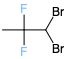

CC(F)(F)C(Br)Br
Entry
CHOFBr_G4
CC(F)(F)C(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.055,147.211,162.591,175.524,195.253,208.604,225.546],'J/(mol*K)'), H298=(-476.22,'kJ/mol'), S298=(397.086,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([55.3523,61.4948,67.1999,71.6899,78.0694,82.0515,86.3726],'J/(mol*K)'), H298=(26.5223,'kJ/mol'), S298=(206.045,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH) + group(CsBrBrCsH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.7622,64.8461,70.1615,74.4635,80.4211,83.7344,85.8766],'J/(mol*K)'), H298=(10.7159,'kJ/mol'), S298=(200.359,'J/(mol*

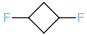

FC1CC(F)C1
Entry
CHOF_G4
FC1CC(F)C1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([92.7415,119.466,142.51,161.542,191.448,212.86,242.622],'J/(mol*K)'), H298=(-380.148,'kJ/mol'), S298=(307.737,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(282.692,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([47.8573,62.1895,74.1102,84.044,99.5797,110.206,122.739],'J/(mol*K)'), H298=(-359.496,'kJ/mol'), S298=(231.636,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsCsHH) + ring(Cs(F)-Cs-Cs-Cs)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([47.8573,62.1895,74.1102,84.044,99.5797,110.206,122.739],'J/(mol*K)'), H298=(-359.496,'kJ/mol'), S298=(231.636,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + group(CsCsCsFH) + ri

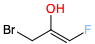

OC(=CF)CBr
Entry
CHOFBr_G4
OC(DCF)CBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.645,130.418,143.577,154.585,171.583,183.356,199.249],'J/(mol*K)'), H298=(-315.658,'kJ/mol'), S298=(364.225,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([80.2027,93.7448,103.354,111.405,123.406,131.318,140.842],'J/(mol*K)'), H298=(-150.664,'kJ/mol'), S298=(224.589,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsBrCHH) + longDistanceInteraction_noncyclic(Cs(Br)-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([79.8168,96.8683,107.09,113.923,123.828,130.469,139.142],'J/(mol*K)'), H298=(-190.546,'kJ/mol'), S298=(220.222,'J/(mol*K)'), comment="""Thermo group addit

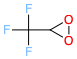

FC(F)(F)C1OO1
Entry
CHOF_G4
FC(F)(F)C1OO1
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.1861,111.233,125.204,135.412,149.874,159.518,170.894],'J/(mol*K)'), H298=(-667.161,'kJ/mol'), S298=(331.102,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(182.918,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.5909,46.8252,55.8932,61.523,69.6842,76.378,84.5425],'J/(mol*K)'), H298=(33.5908,'kJ/mol'), S298=(166.723,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + group(Cs-CsOsOsH) + missing(Cs-CsF1sF1sF1s) + ring(Cs(C-FFF)-O2s-O2s)""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.5909,46.8252,55.8932,61.523,69.6842,76.378,84.5425],'J/(mol*K)'), H298=(33.5908,'kJ/mol'), S298=(166.723,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + group(Cs-Cs

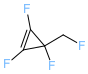

FCC1(F)C(F)=C1F
Entry
CHOF_G4
FCC1(F)C(F)DC1F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([112.218,132.572,149.456,163.122,182.499,195.189,212.707],'J/(mol*K)'), H298=(-465.601,'kJ/mol'), S298=(367.36,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([21.82,26.1348,29.805,32.5684,36.6789,38.9339,41.6683],'J/(mol*K)'), H298=(117.72,'kJ/mol'), S298=(124.87,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cd-CdCsF1s) + missing(Cd-CdCsF1s) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cs(F)-Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + longDistanceInteraction_cyclic(Cds(F)=Cds(F)) + ring(Cs-Cd(F)-Cd)""")

missing
['CsCsFHH_Cs-CsF1sHH', 'CdCsCdF_Cd-CdCsF1s', 'CdCsCdF_Cd-CdCsF1s']

GAE without estimated GAV
ThermoDa

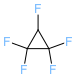

FC1C(F)(F)C1(F)F
Entry
CHOF_G4
FC1C(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.646,129.531,143.811,155.007,171.717,182.538,194.597],'J/(mol*K)'), H298=(-840.869,'kJ/mol'), S298=(348.781,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(207.862,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([13.3368,19.8843,27.1555,32.7839,41.1017,47.7926,60.0654],'J/(mol*K)'), H298=(77.2828,'kJ/mol'), S298=(211.324,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-Cs(F)) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)) + ring(Cs-Cs(F)(F)-Cs)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsCsFF_C

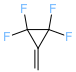

C=C1C(F)(F)C1(F)F
Entry
CHOF_G4
CDC1C(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.653,136.562,152.762,165.443,184.729,197.679,213.474],'J/(mol*K)'), H298=(-540.266,'kJ/mol'), S298=(347.427,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(232.805,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([2.84402,5.0691,8.42707,10.6103,13.9598,16.8524,24.7569],'J/(mol*K)'), H298=(320.616,'kJ/mol'), S298=(101.664,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdCsF1sF1s) + missing(Cs-CdCsF1sF1s) + group(Cds-CdsCsCs) + missing(Cd-CdHH) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(3ring-Cs(F)2-Cs(F)2) + ring(Cs-Cs(F)(F)-Cd(Cd))""")

missing
['CsCCFF_Cs-CdCsF1sF1s', 'CsCCFF_Cs-CdCsF1sF1s', 'Cds-CdsHH_Cd-CdHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([2.84402,5.0691,8.42707,10.6103,13.9598,16.8524,

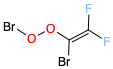

FC(F)=C(Br)OOBr
Entry
CHOFBr_G4
FC(F)DC(Br)OOBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.123,146.852,154.568,160.59,168.541,172.492,173.92],'J/(mol*K)'), H298=(-222.458,'kJ/mol'), S298=(420.83,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.2553,94.2346,96.7559,99.4422,103.735,105.069,105.536],'J/(mol*K)'), H298=(156.101,'kJ/mol'), S298=(279.867,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-Cd)) + group(O2sBrO) + group(CdBrCO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(Val7)2=Cds(Val7))""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.4367,91.7465,94.9806,97.9892,103.118,104.89,106.125],'J/(mol*K)'), H298=(138.8,'kJ/mol'), S298=(281.279,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-

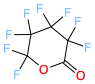

O=C1OC(F)(F)C(F)(F)C(F)(F)C1(F)F
Entry
CHOF_G4
ODC1OC(F)(F)C(F)(F)C(F)(F)C1(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([199.707,235.927,260.527,279.686,307.569,324.769,341.553],'J/(mol*K)'), H298=(-1960.4,'kJ/mol'), S298=(465.564,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(357.522,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([-22.2987,-18.6498,-11.4098,-6.64676,-4.06756,-0.292931,5.17762],'J/(mol*K)'), H298=(141.961,'kJ/mol'), S298=(98.2478,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsF1sF1s) + missing(Cs-COCsF1sF1s) + missing(Cs-CsF1sF1sO2s) + missing(CO-CsO2dO2s) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_

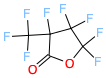

O=C1OC(F)(F)C(F)(F)C1(F)C(F)(F)F
Entry
CHOF_G4
ODC1OC(F)(F)C(F)(F)C1(F)C(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([196.974,234.624,261.42,280.233,306.991,324,341.726],'J/(mol*K)'), H298=(-2001.81,'kJ/mol'), S298=(467.335,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(357.522,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([12.2431,18.4646,25.8784,30.9226,36.0293,39.9553,61.552],'J/(mol*K)'), H298=(-83.9365,'kJ/mol'), S298=(94.3469,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-COCs) + group(CsCCCF) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsF1sF1sO2s) + missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)3-Cs(F)) + longDistanceInteraction_noncyclic(Cs(F)3-R-Cs(F)2) + missing(CO-CsO2dO2s) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)2) + longDistanceInteraction_cyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_cyclic(Cs(F)-

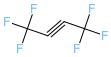

FC(F)(F)C#CC(F)(F)F
Entry
CHOF_G4
FC(F)(F)C#CC(F)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.563,149.26,164.772,176.15,192.805,203.246,213.869],'J/(mol*K)'), H298=(-1065.41,'kJ/mol'), S298=(372.472,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CtF1sF1sF1s) + missing(Cs-CtF1sF1sF1s) + missing(Ct-CsCt) + missing(Ct-CsCt)""")

missing
['CsCtFFF_Cs-CtF1sF1sF1s', 'CsCtFFF_Cs-CtF1sF1sF1s', 'Ct-CtCs_Ct-CsCt', 'Ct-CtCs_Ct-CsCt']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([0,0,0,0,0,0,0],'J/(mol*K)'), H298=(0,'kJ/mol'), S298=(0,'J/(mol*K)'))

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([129.236,152.191,168.509,180.602,196.799,206.606,217.241]

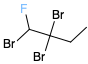

CCC(Br)(Br)C(F)Br
Entry
CHOFBr_G4
CCC(Br)(Br)C(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([160.036,183.513,203.59,220.686,247.236,265.683,289.856],'J/(mol*K)'), H298=(-247.856,'kJ/mol'), S298=(452.952,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.995,121.077,130.283,137.478,147.621,153.265,157.406],'J/(mol*K)'), H298=(-175.5,'kJ/mol'), S298=(290.417,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsBrBrCsCs) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH) + group(CsBrCFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.405,124.428,133.245,140.251,149.973,154.948,156.91],'J/(mol*K)'), H298=(-191.307,'kJ/mol'), S298=(28

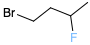

CC(F)CCBr
Entry
CHOFBr_G4
CC(F)CCBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.474,154.057,176.813,196.178,226.345,247.5,276.397],'J/(mol*K)'), H298=(-313.348,'kJ/mol'), S298=(375.989,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.9824,91.7116,102.345,111.123,124.464,133.214,143.655],'J/(mol*K)'), H298=(-254.4,'kJ/mol'), S298=(208.216,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + group(CsBrCsHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.9824,91.7116,102.345,111.123,124.464,133.214,143.655],'J/(mol*K)'), H298=(-254.4,'kJ/mol'), S298=(208.216,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + group(CsBrCsHH)""")

GAE with fitted GAV
ThermoD

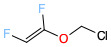

FC=C(F)OCCl
Entry
CHOFCl_G4
FCDC(F)OCCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([121.389,139.105,151.811,162.421,178.464,189.187,202.742],'J/(mol*K)'), H298=(-494.957,'kJ/mol'), S298=(369.057,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([85.6854,101.272,112.554,120.952,132.298,139.039,146.431],'J/(mol*K)'), H298=(-348.779,'kJ/mol'), S298=(227.097,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsClHHO) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.4883,100.564,112.148,120.639,132.166,139.019,146.938],'J/(mol*K)'), H298=(-373.963,'kJ/mol'), S298=(225.485,'J/(mol*K)'), comment="""Thermo group ad

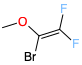

COC(Br)=C(F)F
Entry
CHOFBr_G4
COC(Br)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.864,130.957,144.638,156.191,173.951,186.132,202.078],'J/(mol*K)'), H298=(-435.324,'kJ/mol'), S298=(379.719,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([54.7116,61.1685,64.9164,67.4561,69.6088,70.2666,69.1743],'J/(mol*K)'), H298=(-54.5575,'kJ/mol'), S298=(95.7274,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-O2sHHH) + group(CdBrCO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(Val7)2=Cds(Val7))""")

missing
['Cs-OsHHH_Cs-O2sHHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([51.893,58.6804,63.1412,66.0031,68.9918,70.0871,69.7628],'J/(mol*K)'), H298=(-71.859,'kJ/mol'), S298=(97.1395,'J/(mol*K)'), comment="""Thermo group additivity es

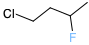

CC(F)CCCl
Entry
CHOFCl_G4
CC(F)CCCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([126.934,153.126,175.612,194.826,224.957,246.305,275.918],'J/(mol*K)'), H298=(-359.667,'kJ/mol'), S298=(360.806,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.2503,90.1179,100.858,109.733,123.264,132.084,142.866],'J/(mol*K)'), H298=(-301.232,'kJ/mol'), S298=(198.14,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + group(CsClCsHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.2503,90.1179,100.858,109.733,123.264,132.084,142.866],'J/(mol*K)'), H298=(-301.232,'kJ/mol'), S298=(198.14,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + group(CsClCsHH)""")

GAE with fitted GAV
The

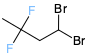

CC(F)(F)CC(Br)Br
Entry
CHOFBr_G4
CC(F)(F)CC(Br)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([150.274,175.044,196.099,213.873,241.174,259.872,284.23],'J/(mol*K)'), H298=(-509.138,'kJ/mol'), S298=(442.325,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.7622,64.8461,70.1615,74.4635,80.4211,83.7344,85.8766],'J/(mol*K)'), H298=(10.7159,'kJ/mol'), S298=(200.359,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + group(CsBrBrCsH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.7622,64.8461,70.1615,74.4635,80.4211,83.7344,85.8766],'J/(mol*K)'), H298=(10.7159,'kJ/mol'), S298=(200.359,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsBrBrCsH

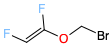

FC=C(F)OCBr
Entry
CHOFBr_G4
FCDC(F)OCBr
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.265,141.835,154.483,164.941,180.602,190.898,203.505],'J/(mol*K)'), H298=(-444.896,'kJ/mol'), S298=(383.716,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.9365,102.342,113.56,121.97,133.294,139.964,147.149],'J/(mol*K)'), H298=(-297.905,'kJ/mol'), S298=(239.1,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsBrHHO) + group(CdCFO) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(F)=Cds(F))""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([85.7394,101.634,113.154,121.657,133.162,139.944,147.656],'J/(mol*K)'), H298=(-323.09,'kJ/mol'), S298=(237.488,'J/(mol*K)'), comment="""Thermo group additiv

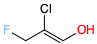

OC=C(Cl)CF
Entry
CHOFCl_G4
OCDC(Cl)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([103.632,124.812,141.428,154.515,174.44,187.919,204.452],'J/(mol*K)'), H298=(-356.361,'kJ/mol'), S298=(340.223,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.8962,86.3528,96.044,102.64,111.342,116.931,125.013],'J/(mol*K)'), H298=(-156.981,'kJ/mol'), S298=(201.804,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cds(Val7)) + group(CdCsCdCl) + longDistanceInteraction_noncyclic(Cd(Cl)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCFHH_Cs-CdF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.0881,92.145,101.7,107.239,113.692,117.605,124.314],'J/(mol*K)'), H298=(-185.925,'kJ/mol'), S298=(192.207,'J/(mol*K)'), comment="""Thermo group

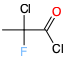

CC(F)(Cl)C(=O)Cl
Entry
CHOFCl_G4
CC(F)(Cl)C(DO)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.285,139.027,151.809,162.536,178.856,189.866,203.895],'J/(mol*K)'), H298=(-468.123,'kJ/mol'), S298=(373.659,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([97.2399,107.351,113.461,118.192,125.044,128.843,130.83],'J/(mol*K)'), H298=(-423.417,'kJ/mol'), S298=(249.721,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCClF) + longDistanceInteraction_noncyclic(Cs(Val7)2-CO) + missing(Cs-CsHHH) + group(COCsClO)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([93.0486,103.988,110.905,116.496,124.634,129.087,130.927],'J/(mol*K)'), H298=(-445.829,'kJ/mol'), S298=(249.112,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCClF) + group(COCsClO)""")

GAE wi

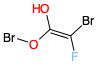

OC(OBr)=C(F)Br
Entry
CHOFBr_G4
OC(OBr)DC(F)Br
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([119.103,131.996,140.415,146.211,154.418,160.266,167.43],'J/(mol*K)'), H298=(-275.052,'kJ/mol'), S298=(405.661,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.188,130.826,138.105,143.898,153.083,159.057,165.298],'J/(mol*K)'), H298=(-252.081,'kJ/mol'), S298=(401.083,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(O2sBrC) + group(Cds-CdsCsCs) + group(CdBrCF) + longDistanceInteraction_noncyclic(Cd(Val7)2=CdOs)""")

missing
['Cds-CdsOsOs_Cd-CdO2sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([104.045,115.712,122.335,126.275,131.769,135.239,139.65],'J/(mol*K)'), H298=(-318.207,'kJ/mol'), S298=(447.07,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H

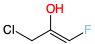

OC(=CF)CCl
Entry
CHOFCl_G4
OC(DCF)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.142,127.363,141.05,152.599,170.388,182.646,198.954],'J/(mol*K)'), H298=(-360.457,'kJ/mol'), S298=(349.59,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.0942,91.4601,101.101,109.328,121.827,130.118,140.012],'J/(mol*K)'), H298=(-192.951,'kJ/mol'), S298=(212.573,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsCClHH) + longDistanceInteraction_noncyclic(Cs(Cl)-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.1347,94.9909,105.248,112.167,122.446,129.365,138.259],'J/(mol*K)'), H298=(-235.041,'kJ/mol'), S298=(208.801,'J/(mol*K)'), comment="""Thermo group additi

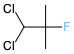

CC(C)(F)C(Cl)Cl
Entry
CHOFCl_G4
CC(C)(F)C(Cl)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([139.366,164.413,185.769,203.987,232.478,252.577,280.251],'J/(mol*K)'), H298=(-391.995,'kJ/mol'), S298=(385.156,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([87.5376,100.351,109.242,116.133,125.933,131.128,134.96],'J/(mol*K)'), H298=(-311.162,'kJ/mol'), S298=(145.121,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + missing(Cs-CsHHH) + missing(Cs-CsHHH) + group(CsCsClClH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.2329,101.822,110.258,116.995,126.599,131.467,134.057],'J/(mol*K)'), H298=(-320.929,'kJ/mol'), S298=(142.603,'J/(mol*K)'), comment="""Thermo group additivity estimatio

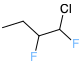

CCC(F)C(F)Cl
Entry
CHOFCl_G4
CCC(F)C(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.596,159.254,181.128,199.696,228.651,249.219,278.988],'J/(mol*K)'), H298=(-539.332,'kJ/mol'), S298=(384.741,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.1685,97.8878,108.348,116.694,129.296,137.451,146.838],'J/(mol*K)'), H298=(-475.147,'kJ/mol'), S298=(217.188,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsHHH) + group(CsCClFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([85.8638,99.3591,109.363,117.556,129.962,137.79,145.935],'J/(mol*K)'), H298=(-484.914,'kJ/mol'), S298=(214.671,'J/(mol*K)'), comment="""Thermo group additivity estimation: 

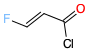

O=C(Cl)C=CF
Entry
CHOFCl_G4
ODC(Cl)CDCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.7359,104.126,116.286,126.418,141.469,151.146,163.911],'J/(mol*K)'), H298=(-319.287,'kJ/mol'), S298=(332.845,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.3944,70.7299,77.2183,82.7325,90.9613,96.3704,102.221],'J/(mol*K)'), H298=(-138.765,'kJ/mol'), S298=(204.139,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COCClO) + missing(Cd-CdF1sH)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.3944,70.7299,77.2183,82.7325,90.9613,96.3704,102.221],'J/(mol*K)'), H298=(-138.765,'kJ/mol'), S298=(204.139,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COCClO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,100

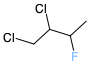

CC(F)C(Cl)CCl
Entry
CHOFCl_G4
CC(F)C(Cl)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([138.049,166.944,190.648,209.487,237.274,256.983,283.997],'J/(mol*K)'), H298=(-384.968,'kJ/mol'), S298=(385.134,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([112.49,133.461,149.868,162.989,182.443,194.963,210.245],'J/(mol*K)'), H298=(-345.301,'kJ/mol'), S298=(258.49,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsCsCsClH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Cl)-Cs(Cl)) + missing(Cs-CsHHH) + group(CsClCsHH) + longDistanceInteraction_noncyclic(Cs(Cl)-Cs(Cl))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([115.48,135.622,150.915,163.469,182.483,

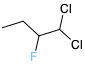

CCC(F)C(Cl)Cl
Entry
CHOFCl_G4
CCC(F)C(Cl)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([140.724,165.006,185.882,203.734,231.77,251.698,279.603],'J/(mol*K)'), H298=(-368.28,'kJ/mol'), S298=(392.841,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([88.0023,102.275,112.993,121.451,133.805,141.389,149.75],'J/(mol*K)'), H298=(-308.606,'kJ/mol'), S298=(229.46,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + missing(Cs-CsHHH) + group(CsCsClClH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.6976,103.746,114.008,122.313,134.471,141.727,148.847],'J/(mol*K)'), H298=(-318.374,'kJ/mol'), S298=(226.943,'J/(mol*K)'), comment="""Thermo group additivity estimation:

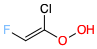

OOC(Cl)=CF
Entry
CHOFCl_G4
OOC(Cl)DCF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([108.844,123.455,131.598,138.016,147.523,153.676,161.167],'J/(mol*K)'), H298=(-232.303,'kJ/mol'), S298=(342.789,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([47.0335,51.6411,54.1599,57.1193,62.8013,65.4815,66.3624],'J/(mol*K)'), H298=(22.9905,'kJ/mol'), S298=(108.48,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-Cd)) + missing(O2s-O2sH) + group(CdCClO) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7))""")

missing
['O2s-OsH_O2s-O2sH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([45.4189,50.2982,53.2988,56.4689,62.5491,65.4763,67.1511],'J/(mol*K)'), H298=(8.55095,'kJ/mol'), S298=(108.703,'J/(mol*

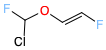

FC=COC(F)Cl
Entry
CHOFCl_G4
FCDCOC(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.727,135.515,151.341,163.06,180.069,191.569,205.676],'J/(mol*K)'), H298=(-519.029,'kJ/mol'), S298=(366.439,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.7574,103.661,115.882,124.64,135.431,141.532,148.408],'J/(mol*K)'), H298=(-369.948,'kJ/mol'), S298=(218.264,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsClFHO) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([88.3483,107.437,119.967,127.975,137.312,142.294,149.048],'J/(mol*K)'), H298=(-396.716,'kJ/mol'), S298=(212.014,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(

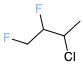

CC(Cl)C(F)CF
Entry
CHOFCl_G4
CC(Cl)C(F)CF
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([136.524,165.158,187.67,206.282,235.288,255.582,282.71],'J/(mol*K)'), H298=(-542.125,'kJ/mol'), S298=(374.883,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([72.2979,85.6022,95.7948,103.644,115.102,122.254,130.485],'J/(mol*K)'), H298=(-270.173,'kJ/mol'), S298=(110.606,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsClH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.7579,87.2355,96.

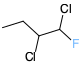

CCC(Cl)C(F)Cl
Entry
CHOFCl_G4
CCC(Cl)C(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([137.671,164.003,186.14,204.621,232.689,252.225,281.186],'J/(mol*K)'), H298=(-378.268,'kJ/mol'), S298=(391.602,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([87.8692,101.66,112.07,120.356,132.688,140.371,148.656],'J/(mol*K)'), H298=(-308.283,'kJ/mol'), S298=(225.951,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsClH) + missing(Cs-CsHHH) + group(CsCClFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.5645,103.131,113.086,121.218,133.353,140.709,147.753],'J/(mol*K)'), H298=(-318.051,'kJ/mol'), S298=(223.434,'J/(mol*K)'), comment="""Thermo group additivity estimation:

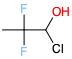

CC(F)(F)C(O)Cl
Entry
CHOFCl_G4
CC(F)(F)C(O)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([133.962,157.908,174.639,188.486,209.462,223.513,241.25],'J/(mol*K)'), H298=(-729.793,'kJ/mol'), S298=(367.923,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.3809,48.397,54.3701,58.4871,63.6623,66.4776,68.6001],'J/(mol*K)'), H298=(-64.5759,'kJ/mol'), S298=(54.1798,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + group(CsCClHO) + missing(Cs-CsHHH)""")

missing
['O2s-CsH_O2s-CsH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([41.0762,49.8683,55.3853,59.3492,64.3277,66.816,67.6971],'J/(mol*K)'), H298=(-74.3434,'kJ/mol'), S298=(51.6628,'J/(mol*K)'), comment="""Thermo g

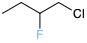

CCC(F)CCl
Entry
CHOFCl_G4
CCC(F)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([122.754,147.39,169.129,188.156,218.872,241.261,273.756],'J/(mol*K)'), H298=(-351.549,'kJ/mol'), S298=(368.879,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([75.0345,89.1207,100.139,109.073,122.648,131.694,143.351],'J/(mol*K)'), H298=(-291.098,'kJ/mol'), S298=(201.565,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsClCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.2503,90.1179,100.858,109.733,123.264,132.084,142.866],'J/(mol*K)'), H298=(-301.232,'kJ/mol'), S298=(198.14,'J/(mol*K)'),

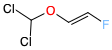

FC=COC(Cl)Cl
Entry
CHOFCl_G4
FCDCOC(Cl)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([117.379,138.181,154.791,167.57,184.277,194.754,208.009],'J/(mol*K)'), H298=(-329.196,'kJ/mol'), S298=(375.558,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([90.1372,107.133,119.381,128.045,138.307,143.846,149.794],'J/(mol*K)'), H298=(-181.963,'kJ/mol'), S298=(230.075,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsClClHO) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.7281,110.909,123.466,131.38,140.188,144.607,150.433],'J/(mol*K)'), H298=(-208.731,'kJ/mol'), S298=(223.825,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + gro

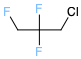

FCC(F)(F)CCl
Entry
CHOFCl_G4
FCC(F)(F)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.523,150.453,167.601,180.271,199.148,211.438,226.03],'J/(mol*K)'), H298=(-730.553,'kJ/mol'), S298=(358.504,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.7918,46.2789,53.5627,59.0742,67.072,72.8385,81.7898],'J/(mol*K)'), H298=(-41.1559,'kJ/mol'), S298=(152.236,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(F)2-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsF1sHH) + group(CsClCsHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.7217,48.3863,54.5225,59.6605,67.4377,72.6623,79.5144],'J/(mol*K)'), H298=(-70.4807,'kJ/mol'), S298=(148.908,'J/(mol*K)'), comme

FC=COCCl
Entry
CHOFCl_G4
FCDCOCCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.952,117.517,133.378,146.788,167.417,181.538,199.591],'J/(mol*K)'), H298=(-304.323,'kJ/mol'), S298=(357.856,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([75.6539,93.0222,106.067,115.482,127.261,134.345,143.779],'J/(mol*K)'), H298=(-163.745,'kJ/mol'), S298=(204.121,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsClHHO) + group(Cds-CdsOsH) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.2448,96.7982,110.151,118.817,129.143,135.106,144.418],'J/(mol*K)'), H298=(-190.513,'kJ/mol'), S298=(197.871,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsClH

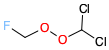

FCOOC(Cl)Cl
Entry
CHOFCl_G4
FCOOC(Cl)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([120.586,138.933,154.207,166.784,185.247,196.863,209.077],'J/(mol*K)'), H298=(-388.606,'kJ/mol'), S298=(369.301,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([85.4193,96.6266,104.733,111.025,121.132,128.623,132.483],'J/(mol*K)'), H298=(-138.512,'kJ/mol'), S298=(250.437,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + missing(Cs-F1sO2sHH) + group(CsClClHO)""")

missing
['CsFHHO_Cs-F1sO2sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([85.4193,96.6266,104.733,111.025,121.132,128.623,132.483],'J/(mol*K)'), H298=(-138.512,'kJ/mol'), S298=(250.437,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-OsCs) + group(O2s-OsCs) + group(CsClClHO)""")

GAE with fitted GAV
T

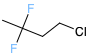

CC(F)(F)CCCl
Entry
CHOFCl_G4
CC(F)(F)CCCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([138.147,163.205,184.331,202.366,230.618,250.618,278.473],'J/(mol*K)'), H298=(-590.436,'kJ/mol'), S298=(380.463,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.7217,48.3863,54.5225,59.6605,67.4377,72.6623,79.5144],'J/(mol*K)'), H298=(-70.4807,'kJ/mol'), S298=(148.908,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + missing(Cs-CsCsHH) + missing(Cs-CsHHH) + group(CsClCsHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.7217,48.3863,54.5225,59.6605,67.4377,72.6623,79.5144],'J/(mol*K)'), H298=(-70.4807,'kJ/mol'), S298=(148.908,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsClCsHH)""")



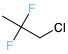

CC(F)(F)CCl
Entry
CHOFCl_G4
CC(F)(F)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.352,130.013,146.564,160.651,182.604,198,218.959],'J/(mol*K)'), H298=(-563.546,'kJ/mol'), S298=(346.092,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.0264,46.915,53.5074,58.7984,66.7722,72.3239,80.4174],'J/(mol*K)'), H298=(-60.7132,'kJ/mol'), S298=(151.425,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsHHH) + group(CsClCsHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.7217,48.3863,54.5225,59.6605,67.4377,72.6623,79.5144],'J/(mol*K)'), H298=(-70.4807,'kJ/mol'), S298=(148.908,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsClCsHH)"

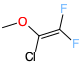

COC(Cl)=C(F)F
Entry
CHOFCl_G4
COC(Cl)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([113.264,129.486,143.296,154.973,172.964,185.351,201.666],'J/(mol*K)'), H298=(-484.906,'kJ/mol'), S298=(362.752,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([52.6635,59.9141,63.8073,66.4784,68.8758,69.716,68.8228],'J/(mol*K)'), H298=(-104.909,'kJ/mol'), S298=(83.8591,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-O2sHHH) + group(CdCClO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(Val7)2=Cds(Val7))""")

missing
['Cs-OsHHH_Cs-O2sHHH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([49.8449,57.4261,62.032,65.0253,68.2588,69.5365,69.4113],'J/(mol*K)'), H298=(-122.211,'kJ/mol'), S298=(85.2712,'J/(mol*K)'), comment="""Thermo group additivity es

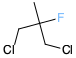

CC(F)(CCl)CCl
Entry
CHOFCl_G4
CC(F)(CCl)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([142.518,169.583,191.262,209.615,237.948,257.495,283.18],'J/(mol*K)'), H298=(-392.975,'kJ/mol'), S298=(382.11,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.076,134.586,150.193,162.755,181.597,193.705,208.561],'J/(mol*K)'), H298=(-354.001,'kJ/mol'), S298=(269.559,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsClCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + group(CsClCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.507,136.58,151.63,164.076,182.

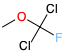

COC(F)(Cl)Cl
Entry
CHOFCl_G4
COC(F)(Cl)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([106.52,119.839,131.203,140.838,155.75,166.097,179.93],'J/(mol*K)'), H298=(-459.829,'kJ/mol'), S298=(353.979,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.1972,84.1535,88.7661,93.0243,99.9662,103.886,107.082],'J/(mol*K)'), H298=(-392.366,'kJ/mol'), S298=(237.586,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-O2sHHH) + group(CsClClFO)""")

missing
['Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([78.1972,84.1535,88.7661,93.0243,99.9662,103.886,107.082],'J/(mol*K)'), H298=(-392.366,'kJ/mol'), S298=(237.586,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(CsClClFO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1

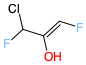

OC(=CF)C(F)Cl
Entry
CHOFCl_G4
OC(DCF)C(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([115.671,136.587,152.313,163.896,180.854,192.24,206.004],'J/(mol*K)'), H298=(-536.023,'kJ/mol'), S298=(368.12,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.2276,99.5728,109.74,117.988,129.859,137.378,145.292],'J/(mol*K)'), H298=(-372.238,'kJ/mol'), S298=(231.343,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CsCClFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-CdOs) + group(Cds-CdsCsOs) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cd(F)=CdOs)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([89.9558,107.007,116.636,122.808,131.86,137.315,143.326],'J/(mol*K)'), H298=(-429.585,'kJ/mol'), S298=(220.192,'J/(mol*K)'), comment="""Thermo group

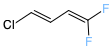

FC(F)=CC=CCl
Entry
CHOFCl_G4
FC(F)DCCDCCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.15,131.624,147.973,161.211,181.096,194.141,209.277],'J/(mol*K)'), H298=(-313.521,'kJ/mol'), S298=(353.081,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(228.648,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.1044,87.3879,99.6733,108.659,121.612,130.582,144.112],'J/(mol*K)'), H298=(50.2093,'kJ/mol'), S298=(198.754,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + missing(Cd-CdF1sF1s) + group(CdCClH)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.1044,87.3879,99.6733,108.659,121.612,130.582,144.112],'J/(mol*K)'), H298=(50.2093,'kJ/mol'), S298=(198.754,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)H) + group(Cds-Cds(Cds-Cds)H) + group(CdCC

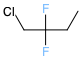

CCC(F)(F)CCl
Entry
CHOFCl_G4
CCC(F)(F)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([140.209,167.91,188.954,206.76,234.377,253.619,279.706],'J/(mol*K)'), H298=(-584.062,'kJ/mol'), S298=(372.924,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.0264,46.915,53.5074,58.7984,66.7722,72.3239,80.4174],'J/(mol*K)'), H298=(-60.7132,'kJ/mol'), S298=(151.425,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsHHH) + group(CsClCsHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.7217,48.3863,54.5225,59.6605,67.4377,72.6623,79.5144],'J/(mol*K)'), H298=(-70.4807,'kJ/mol'), S298=(148.908,'J/(mol*K)'), comment="""Ther

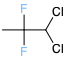

CC(F)(F)C(Cl)Cl
Entry
CHOFCl_G4
CC(F)(F)C(Cl)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.588,146.331,161.718,174.677,194.501,207.98,225.262],'J/(mol*K)'), H298=(-574.536,'kJ/mol'), S298=(372.845,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([51.759,58.6631,64.7108,69.4669,76.2925,80.6227,85.991],'J/(mol*K)'), H298=(-71.8158,'kJ/mol'), S298=(183.398,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH) + group(CsCsClClH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([54.169,62.0144,67.6724,72.2405,78.6441,82.3056,85.495],'J/(mol*K)'), H298=(-87.6222,'kJ/mol'), S298=(177.711,'J/(mol*K)

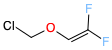

FC(F)=COCCl
Entry
CHOFCl_G4
FC(F)DCOCCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.882,128.359,143.806,156.621,175.802,188.491,204.419],'J/(mol*K)'), H298=(-496.115,'kJ/mol'), S298=(374.406,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.225,93.0641,105.949,115.43,127.194,134.463,144.386],'J/(mol*K)'), H298=(-154.973,'kJ/mol'), S298=(206.025,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + group(CsClHHO) + group(Cds-CdsOsH) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([77.2448,96.7982,110.151,118.817,129.143,135.106,144.418],'J/(mol*K)'), H298=(-190.513,'kJ/mol'), S298=(197.871,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + g

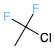

CC(F)(F)Cl
Entry
CHOFCl_G4
CC(F)(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.2515,105.571,116.587,125.838,140.018,149.677,161.999],'J/(mol*K)'), H298=(-533.539,'kJ/mol'), S298=(337.99,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.8542,66.5335,71.6941,75.6626,81.2579,84.5302,86.1774],'J/(mol*K)'), H298=(-474.771,'kJ/mol'), S298=(186.511,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsHHH) + group(CsCClFF)""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.8542,66.5335,71.6941,75.6626,81.2579,84.5302,86.1774],'J/(mol*K)'), H298=(-474.771,'kJ/mol'), S298=(186.511,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCClFF)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.7522,98.9109,1

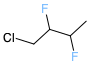

CC(F)C(F)CCl
Entry
CHOFCl_G4
CC(F)C(F)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.777,162.724,185.816,204.465,232.841,253.226,281.722],'J/(mol*K)'), H298=(-546.555,'kJ/mol'), S298=(379.283,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([109.319,130.216,146.595,159.642,179.148,191.997,208.18],'J/(mol*K)'), H298=(-507.518,'kJ/mol'), S298=(250.751,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsCsCsFH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + group(CsClCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([111.779,131.849,147.193,159.806,179.091,191.5

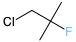

CC(C)(F)CCl
Entry
CHOFCl_G4
CC(C)(F)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.579,150.387,171.917,190.519,220.233,241.908,273.569],'J/(mol*K)'), H298=(-375.438,'kJ/mol'), S298=(357.92,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74.5698,87.197,96.3888,103.755,114.776,121.433,128.562],'J/(mol*K)'), H298=(-293.654,'kJ/mol'), S298=(117.226,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + missing(Cs-CsHHH) + group(CsClCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([75.7856,88.1942,97.1077,104.415,115.392,121.823,128.077],'J/(mol*K)'), H298=(-303.788,'kJ/mol'), S298=(113.8,'J/(mol*K)'), co

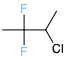

CC(Cl)C(C)(F)F
Entry
CHOFCl_G4
CC(Cl)C(C)(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([134.787,160.847,182.75,201.42,230.574,251.092,279.211],'J/(mol*K)'), H298=(-598.991,'kJ/mol'), S298=(373.529,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([37.534,44.0327,49.0422,52.8734,58.5528,62.0028,66.0734],'J/(mol*K)'), H298=(-54.12,'kJ/mol'), S298=(60.5119,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCsCsClH) + missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)) + missing(Cs-CsHHH) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.2293,45.5039,50.0574,53.7355,59.2182,62.3412,65.1704],'J/(mol*K)'), H298=(-63.8876,'kJ/mol'), S298=(57.9948,'J/(mol*K)'), comment="""Ther

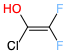

OC(Cl)=C(F)F
Entry
CHOFCl_G4
OC(Cl)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([91.8472,102.338,110.475,117.254,127.432,134.133,142.205],'J/(mol*K)'), H298=(-500.914,'kJ/mol'), S298=(337.181,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(153.818,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.1935,66.8941,71.0673,73.7084,76.6658,78.746,81.0728],'J/(mol*K)'), H298=(-169.109,'kJ/mol'), S298=(171.249,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CdCClO) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cds(Val7)2=Cds(Val7))""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([55.3749,64.4061,69.292,72.2553,76.0488,78.5665,81.6613],'J/(mol*K)'), H298=(-186.411,'kJ/mol'), S298=(172.661,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(CdCClO)

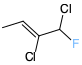

CC=C(Cl)C(F)Cl
Entry
CHOFCl_G4
CCDC(Cl)C(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([122.475,143.214,161.282,176.743,201.029,218.243,241.855],'J/(mol*K)'), H298=(-255.41,'kJ/mol'), S298=(386.825,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([79.8093,91.0536,99.4211,106.107,116.274,122.657,129.854],'J/(mol*K)'), H298=(-245.51,'kJ/mol'), S298=(227.287,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdHHH) + group(CsCClFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + missing(Cd-CdCsH) + group(CdCsCdCl)""")

missing
['Cs-(Cds-Cds)HHH_Cs-(CdH)CdHHH', 'Cds-CdsCsH_Cd-CdCsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([81.9493,92.4438,100.243,106.636,116.463,122.424,128.163],'J/(mol*K)'), H298=(-260.482,'kJ/mol'), S298=(225.405,'J/(mol*K)'), comment="""Thermo group additivi

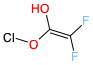

OC(OCl)=C(F)F
Entry
CHOFCl_G4
OC(OCl)DC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([112.85,124.06,133.35,140.962,152.036,158.9,165.944],'J/(mol*K)'), H298=(-496.755,'kJ/mol'), S298=(376.311,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([74,80.683,84.8567,88.2629,93.5951,97.1839,101.013],'J/(mol*K)'), H298=(-120.001,'kJ/mol'), S298=(211.181,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(O2sCCl) + group(Cds-CdsCsCs) + missing(Cd-CdF1sF1s) + longDistanceInteraction_noncyclic(Cd(F)2=CdOs)""")

missing
['Cds-CdsOsOs_Cd-CdO2sO2s', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([57.8654,65.1288,68.1806,69.6421,71.2766,72.3883,74.4344],'J/(mol*K)'), H298=(-198.804,'kJ/mol'), S298=(256.164,'J/(mol*K)'), comment="""Thermo group additivity estimation: grou

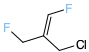

FC=C(CF)CCl
Entry
CHOFCl_G4
FCDC(CF)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([128.8,150.821,167.981,182.526,205.044,220.692,241.85],'J/(mol*K)'), H298=(-402.033,'kJ/mol'), S298=(370.284,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([55.6685,64.9001,72.5188,78.8496,88.9887,95.8571,104.126],'J/(mol*K)'), H298=(-16.3557,'kJ/mol'), S298=(100.911,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CdF1sHH) + group(CsCClHH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CsCFHH_Cs-CdF1sHH', 'CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([55.6685,64.9001,72.5188,78.8496,88.9887,95.8571,104.126],'J/(mol*K)'), H298=(-16.3557,'kJ/mol'), S298=(100.911,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCClHH) + group(Cds-CdsCsCs)""")

GAE with fitted GA

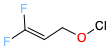

FC(F)=CCOCl
Entry
CHOFCl_G4
FC(F)DCCOCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.995,132.037,146.416,158.452,176.671,188.841,203.935],'J/(mol*K)'), H298=(-380.525,'kJ/mol'), S298=(373.99,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([54.6875,63.531,70.4715,76.1983,84.9311,91.0546,99.714],'J/(mol*K)'), H298=(-38.988,'kJ/mol'), S298=(190.867,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCCl) + group(Cs-(Cds-Cds)OsHH) + missing(Cd-CdCsH) + missing(Cd-CdF1sF1s)""")

missing
['Cds-CdsCsH_Cd-CdCsH', 'CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([54.6875,63.531,70.4715,76.1983,84.9311,91.0546,99.714],'J/(mol*K)'), H298=(-38.988,'kJ/mol'), S298=(190.867,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCCl) + group(Cs-(Cds-Cds)OsHH)""")

GAE with f

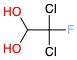

OC(O)C(F)(Cl)Cl
Entry
CHOFCl_G4
OC(O)C(F)(Cl)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([127.771,146.573,159.365,169.696,184.889,194.49,204.797],'J/(mol*K)'), H298=(-664.905,'kJ/mol'), S298=(368.081,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(220.334,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.9998,101.333,112.713,119.655,128.546,134.322,135.587],'J/(mol*K)'), H298=(-341.827,'kJ/mol'), S298=(139.185,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(O2s-CsH) + missing(O2s-CsH) + group(Cs-CsOsOsH) + group(CsCClClF) + longDistanceInteraction_noncyclic(Cs(Val7)3-CsOs)""")

missing
['O2s-CsH_O2s-CsH', 'O2s-CsH_O2s-CsH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([86.7193,101.13,112.597,119.065,127.053,132.842,133.478],'J/(mol*K)'), H298=(-343.272,'kJ/mol'), S298=(145.765,'J/(mol*K)'), comment="""Thermo group additivity estimation: group

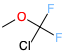

COC(F)(F)Cl
Entry
CHOFCl_G4
COC(F)(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([98.8508,113.588,126.036,136.568,152.808,164,178.738],'J/(mol*K)'), H298=(-670.37,'kJ/mol'), S298=(343.438,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(199.547,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([72.9158,79.6005,84.8691,89.5721,97.1805,101.62,105.741],'J/(mol*K)'), H298=(-601.308,'kJ/mol'), S298=(225.007,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + missing(Cs-O2sHHH) + group(CsClFFO)""")

missing
['Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([72.9158,79.6005,84.8691,89.5721,97.1805,101.62,105.741],'J/(mol*K)'), H298=(-601.308,'kJ/mol'), S298=(225.007,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-CsCs) + group(CsClFFO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500

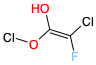

OC(OCl)=C(F)Cl
Entry
CHOFCl_G4
OC(OCl)DC(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.467,127.557,136.396,143.589,153.926,160.189,166.315],'J/(mol*K)'), H298=(-332.351,'kJ/mol'), S298=(380.769,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([116.1,127.499,135.25,141.476,151.368,157.846,164.768],'J/(mol*K)'), H298=(-313.168,'kJ/mol'), S298=(376.87,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + group(O2sCCl) + group(Cds-CdsCsCs) + group(CdCClF) + longDistanceInteraction_noncyclic(Cd(Val7)2=CdOs)""")

missing
['Cds-CdsOsOs_Cd-CdO2sO2s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.9569,112.385,119.48,123.853,130.053,134.027,139.121],'J/(mol*K)'), H298=(-379.294,'kJ/mol'), S298=(422.857,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) 

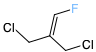

FC=C(CCl)CCl
Entry
CHOFCl_G4
FCDC(CCl)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([131.055,155.459,172.984,187.571,209.81,224.866,244.172],'J/(mol*K)'), H298=(-247.014,'kJ/mol'), S298=(376.494,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(274.378,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.1827,110.512,124.159,135.691,153.71,166.276,181.641],'J/(mol*K)'), H298=(-75.9739,'kJ/mol'), S298=(254.959,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCClHH) + group(CsCClHH) + group(Cds-CdsCsCs) + missing(Cd-CdF1sH)""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([94.1827,110.512,124.159,135.691,153.71,166.276,181.641],'J/(mol*K)'), H298=(-75.9739,'kJ/mol'), S298=(254.959,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCClHH) + group(CsCClHH) + group(Cds-CdsCsCs)""")

GAE with fitted GAV
Therm

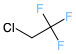

FC(F)(F)CCl
Entry
CHOFCl_G4
FC(F)(F)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([95.8183,111.241,123.877,133.989,147.948,156.224,167.018],'J/(mol*K)'), H298=(-748.529,'kJ/mol'), S298=(357.405,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([39.5818,47.2138,53.6496,58.9687,66.9662,72.4137,80.6739],'J/(mol*K)'), H298=(-58.2246,'kJ/mol'), S298=(152.535,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsF1sF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)3-Cs(Val7)) + group(CsClCsHH)""")

missing
['CsCsFFF_Cs-CsF1sF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.7217,48.3863,54.5225,59.6605,67.4377,72.6623,79.5144],'J/(mol*K)'), H298=(-70.4807,'kJ/mol'), S298=(148.908,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsClCsHH)""")

GAE with fitted GAV
ThermoData

FCCCCCl
Entry
CHOFCl_G4
FCCCCCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([130.891,155.523,176.774,195.033,223.944,244.766,274.684],'J/(mol*K)'), H298=(-337.506,'kJ/mol'), S298=(368.004,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.7217,48.3863,54.5225,59.6605,67.4377,72.6623,79.5144],'J/(mol*K)'), H298=(-70.4807,'kJ/mol'), S298=(148.908,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsCsHH) + missing(Cs-CsF1sHH) + group(CsClCsHH)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'Cs-CsCsHH_Cs-CsCsHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([40.7217,48.3863,54.5225,59.6605,67.4377,72.6623,79.5144],'J/(mol*K)'), H298=(-70.4807,'kJ/mol'), S298=(148.908,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsClCsHH)""")

GAE with fitte

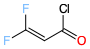

O=C(Cl)C=C(F)F
Entry
CHOFCl_G4
ODC(Cl)CDC(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([101.375,117.174,128.57,137.141,149.959,158.387,168.114],'J/(mol*K)'), H298=(-517.192,'kJ/mol'), S298=(352.579,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(178.761,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.3944,70.7299,77.2183,82.7325,90.9613,96.3704,102.221],'J/(mol*K)'), H298=(-138.765,'kJ/mol'), S298=(204.139,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COCClO) + missing(Cd-CdF1sF1s)""")

missing
['CdCFF_Cd-CdF1sF1s']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([62.3944,70.7299,77.2183,82.7325,90.9613,96.3704,102.221],'J/(mol*K)'), H298=(-138.765,'kJ/mol'), S298=(204.139,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(Cd-Cd(CO)H) + group(COCClO)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500,60

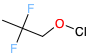

CC(F)(F)COCl
Entry
CHOFCl_G4
CC(F)(F)COCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([125.284,146.376,164.237,179.374,202.781,218.986,240.496],'J/(mol*K)'), H298=(-546.593,'kJ/mol'), S298=(377.436,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(270.22,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.2654,34.8288,35.6606,36.4921,37.9866,38.8383,39.4644],'J/(mol*K)'), H298=(-10.7041,'kJ/mol'), S298=(149.864,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCCl) + missing(Cs-CsCsF1sF1s) + missing(Cs-CsO2sHH) + missing(Cs-CsHHH)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsOsHH_Cs-CsO2sHH', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([33.2654,34.8288,35.6606,36.4921,37.9866,38.8383,39.4644],'J/(mol*K)'), H298=(-10.7041,'kJ/mol'), S298=(149.864,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCCl)""")

GAE

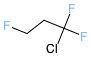

FCCC(F)(F)Cl
Entry
CHOFCl_G4
FCCC(F)(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([115.499,135.456,152.425,166.751,188.753,203.797,223.194],'J/(mol*K)'), H298=(-737.961,'kJ/mol'), S298=(341.856,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.8542,66.5335,71.6941,75.6626,81.2579,84.5302,86.1774],'J/(mol*K)'), H298=(-474.771,'kJ/mol'), S298=(186.511,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsHH) + missing(Cs-CsF1sHH) + group(CsCClFF)""")

missing
['Cs-CsCsHH_Cs-CsCsHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([58.8542,66.5335,71.6941,75.6626,81.2579,84.5302,86.1774],'J/(mol*K)'), H298=(-474.771,'kJ/mol'), S298=(186.511,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCClFF)""")

GAE with fitted GAV
ThermoData(Tdata=([300,400,500

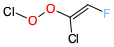

FC=C(Cl)OOCl
Entry
CHOFCl_G4
FCDC(Cl)OOCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([123.679,137.526,145.674,152.099,160.87,165.632,168.888],'J/(mol*K)'), H298=(-101.743,'kJ/mol'), S298=(375.88,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(174.604,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.6759,90.6806,93.6257,96.7053,102.183,104.12,104.719],'J/(mol*K)'), H298=(88.7517,'kJ/mol'), S298=(258.213,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-O2s(Cds-Cd)) + group(O2sClO) + group(CdCClO) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7)) + missing(Cd-CdF1sH) + longDistanceInteraction_noncyclic(Cds(Val7)=Cds(Val7))""")

missing
['CdCFH_Cd-CdF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([83.0613,89.3376,92.7646,96.0548,101.931,104.115,105.508],'J/(mol*K)'), H298=(74.3121,'kJ/mol'), S298=(258.436,'J/(mol*K)'), comment="""Therm

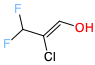

OC=C(Cl)C(F)F
Entry
CHOFCl_G4
OCDC(Cl)C(F)F
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([112.011,132.199,149.073,162.817,182.103,193.323,207.572],'J/(mol*K)'), H298=(-588.082,'kJ/mol'), S298=(363.516,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([71.7948,86.4958,96.3365,102.997,111.551,117.167,125.368],'J/(mol*K)'), H298=(-150.636,'kJ/mol'), S298=(200.054,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-(Cds-Cd)H) + missing(Cs-CdF1sF1sH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cds(Val7)) + group(CdCsCdCl) + longDistanceInteraction_noncyclic(Cd(Cl)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCFFH_Cs-CdF1sF1sH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([76.0881,92.145,101.7,107.239,113.692,117.605,124.314],'J/(mol*K)'), H298=(-185.925,'kJ/mol'), S298=(192.207,'J/(mol*K)'), comment="

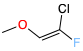

COC=C(F)Cl
Entry
CHOFCl_G4
COCDC(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([99.7839,116.107,130.513,142.916,162.592,176.76,196.763],'J/(mol*K)'), H298=(-288.353,'kJ/mol'), S298=(352.079,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([80.0245,93.4307,103.417,110.682,119.399,124.538,130.208],'J/(mol*K)'), H298=(-273.033,'kJ/mol'), S298=(218.694,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + missing(Cs-O2sHHH) + group(Cds-CdsOsH) + group(CdCClF) + longDistanceInteraction_noncyclic(Cd(Val7)2=CdOs)""")

missing
['Cs-OsHHH_Cs-O2sHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([81.0355,97.6048,108.525,115.067,122.351,126.158,131.171],'J/(mol*K)'), H298=(-295.897,'kJ/mol'), S298=(211.544,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2s-Cs(Cds-Cd)) + g

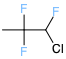

CC(F)(F)C(F)Cl
Entry
CHOFCl_G4
CC(F)(F)C(F)Cl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([124.101,143.757,159.24,172.309,192.383,206.132,224.049],'J/(mol*K)'), H298=(-747.58,'kJ/mol'), S298=(361.971,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(249.434,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([47.9252,54.2762,60.0666,64.7093,71.7834,76.6851,83.079],'J/(mol*K)'), H298=(-238.357,'kJ/mol'), S298=(171.126,'J/(mol*K)'), comment="""Thermo group additivity estimation: missing(Cs-CsCsF1sF1s) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2) + missing(Cs-CsHHH) + group(CsCClFH) + longDistanceInteraction_noncyclic(Cs(Val7)2-Cs(Val7)2)""")

missing
['CsCsCsFF_Cs-CsCsF1sF1s', 'Cs-CsHHH_Cs-CsHHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([50.3352,57.6275,63.0282,67.4829,74.135,78.368,82.583],'J/(mol*K)'), H298=(-254.163,'kJ/mol'), S298=(165.439,'J/(mol*K)'), c

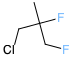

CC(F)(CF)CCl
Entry
CHOFCl_G4
CC(F)(CF)CCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([135.122,161.872,184.53,203.434,231.843,251.663,280.844],'J/(mol*K)'), H298=(-548.557,'kJ/mol'), S298=(378.781,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(320.107,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([73.3256,86.5609,96.5099,104.251,115.449,122.315,130.04],'J/(mol*K)'), H298=(-279.322,'kJ/mol'), S298=(117.18,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(CsCCCF) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7)) + missing(Cs-CsHHH) + missing(Cs-CsF1sHH) + longDistanceInteraction_noncyclic(Cs(F)-Cs(F)) + group(CsClCsHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cs(Val7))""")

missing
['Cs-CsHHH_Cs-CsHHH', 'CsCsFHH_Cs-CsF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([75.7856,88.1942,97.1077

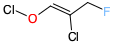

FCC(Cl)=COCl
Entry
CHOFCl_G4
FCC(Cl)DCOCl
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([114.996,132.004,146.431,158.546,176.967,189.333,204.536],'J/(mol*K)'), H298=(-195.559,'kJ/mol'), S298=(391.002,'J/(mol*K)'), Cp0=(33.2579,'J/(mol*K)'), CpInf=(224.491,'J/(mol*K)'))

GAE with estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([80.5616,90.8816,99.1846,105.982,116.039,122.219,129.508],'J/(mol*K)'), H298=(20.4146,'kJ/mol'), S298=(245.367,'J/(mol*K)'), comment="""Thermo group additivity estimation: group(O2sCCl) + missing(Cs-CdF1sHH) + longDistanceInteraction_noncyclic(Cs(Val7)-Cds(Val7)) + group(CdCsCdCl) + longDistanceInteraction_noncyclic(Cd(Cl)=CdOs) + group(Cds-CdsOsH)""")

missing
['CsCFHH_Cs-CdF1sHH']

GAE without estimated GAV
ThermoData(Tdata=([300,400,500,600,800,1000,1500],'K'), Cpdata=([84.7535,96.6738,104.841,110.581,118.389,122.894,128.809],'J/(mol*K)'), H298=(-8.52942,'kJ/mol'), S298=(235.771,'J/(mol*K)'), comment="""Thermo gro

In [18]:
for spc_index in bad_fit_spc_index_list:
    print("Warning: these are bad fits:")
    check_data(index=spc_index)
    print("===========================================================================")

# 4. Write fitted data to database

In [20]:
database_new = deepcopy(database)
duplicate = dict()

for group_str in missing_group_dict.keys():
    group = missing_group_dict[group_str]["group"][0]
    print(group.to_adjacency_list())
    group_atom = missing_group_dict[group_str]["atom"][0]
    molecule = missing_group_dict[group_str]["molecule"][0]
    entry_label = group_str.split("_")[-1]
    
    #Make sure there are no duplicate entry label
    if entry_label in database_new.groups['group'].entries:
        print('double')
        entry_data = database_new.groups['group'].entries[entry_label].data
        if entry_data is not None and not isinstance(entry_data,str):
            if not database_new.groups['group'].entries[entry_label].data.is_all_zeros():
                counter = 0
                while entry_label in database_new.groups['group'].entries:
                    print(entry_label)
                    if entry_label not in duplicate:
                        duplicate[entry_label] = dict()
                        duplicate[entry_label]["group"] = group
                        duplicate[entry_label]["atom"] = group_atom
                        duplicate[entry_label]["molecule"] = molecule
                    counter += 1
                    entry_label = entry_label.split('_')[0]
                    entry_label += '_{0}'.format(counter)
                    if entry_label not in duplicate:
                        duplicate[entry_label] = dict()
                        duplicate[entry_label]["group"] = group
                        duplicate[entry_label]["atom"] = group_atom
                        duplicate[entry_label]["molecule"] = molecule

    string = ''
    for ind in np.nonzero(A[:,missing_group_index_dict[group_str]])[0]:
        string += f'{all_data["entry"][ind].item.smiles} ({all_data["entry"][ind].label}) from {all_data["entry"][ind].short_desc}\n'
        
    node0 = database_new.groups['group'].descend_tree(molecule, {'*': group_atom}, None)
    
    # make L3 dummy node
    if node0.label in ["C", "O", "N", "S"]:
        print('in here')
        entry = Entry(index = len(database_new.groups['group'].entries)+1,
                        label = group_atom.atomtype.label,
                        item = Group().from_adjacency_list(f"""1 * {group_atom.atomtype.label} u0"""),
                        data = None,
                        short_desc = """Dummy L3 group added by Hao-Wei Pang""",
                        long_desc = f"""Dummy L3 group added by Hao-Wei Pang during fitting groups from thermo libraries""",
                        parent = node0)
        database_new.groups["group"].entries[group_atom.atomtype.label] = entry
        database_new.groups["group"].entries[node0.label].children.append(entry)
        node0 = database_new.groups["group"].entries[group_atom.atomtype.label]
        
    replace = False
    reason = ''
    if node0.data is None:
        reason = "None"
    elif isinstance(node0.data,str):
        reason = node0.data
    elif node0.data.is_all_zeros():
        reason = "all zeros"
        
    if reason:
        #if node0 data is missing, and the new group is the same as the parent group, 
        #then we replace the node0 data with the group data
        print(f'what was the reason: {reason}')
        if node0.item.is_isomorphic(group):
            print('was isomorphic')
            for atom in node0.item.atoms:
                if atom.label:
                    neighbors = ''.join(sorted([atom2.atomtype[0].label for atom2 in atom.edges.keys()
                                                if atom2.atomtype[0].label != 'H']))
                    neighbors += 'H' * len(['H' for atom2 in atom.edges.keys() if atom2.atomtype[0].label == 'H'])

                    node0_group_str = atom.atomtype[0].label

                    if neighbors:
                        node0_group_str += f'-{neighbors}'

                    if node0_group_str == entry_label:
                        replace = True
        
    missing_group_dict[group_str]["node0"] = node0
    
    if replace:
        #replace existing group entry
        database_new.groups['group'].entries[node0.label].data = fitted_group_data[group_str]
        database_new.groups['group'].entries[node0.label].short_desc = """Fitted from RMG thermo libraries by Hao-Wei Pang"""
        database_new.groups['group'].entries[node0.label].long_desc = f"""Previously contains {reason} as data. New data fitted from following species using Ridge regression

{string}

"""

        missing_group_dict[group_str]["entry"] = database_new.groups['group'].entries[node0.label]
        missing_group_dict[group_str]["replaced"] = True
    else:
        #make new group entry
        print('new')
        entry = Entry(index = len(database_new.groups['group'].entries)+1,
                        label = entry_label,
                        item = group,
                        data = fitted_group_data[group_str],
                        short_desc = """Group added & fitted from RMG thermo libraries by Hao-Wei Pang""",
                        long_desc = f"""Fitted from following species using Ridge regression

{string}

    """,
                         parent = node0)
        
        missing_group_dict[group_str]["entry"] = entry
        missing_group_dict[group_str]["replaced"] = False
        database_new.groups['group'].entries[entry_label] = entry
        database_new.groups["group"].entries[node0.label].children.append(entry)
        
        ################################ test #######################################
        #test that we can make sample molecule
        #test that the sample molecule descend to itself or its ancestors
        #test that node0 is an appropriate parent for its child entry
        try:
            sample_molecule = entry.item.make_sample_molecule()
            print('===============================================')
        except:
            logging.error("Problem making sample molecule for group {}\n{}".format(
                entryName, entry.item.to_adjacency_list()))
            raise
        # for now ignore sample atoms that use nitrogen types
        nitrogen = False
        for atm in sample_molecule.atoms:
            if atm.is_nitrogen():
                nitrogen = True

        if not nitrogen:
            atoms = sample_molecule.get_all_labeled_atoms()
            match = database_new.groups["group"].descend_tree(sample_molecule, atoms, strict=True)

            for entry_atom in entry.item.atoms:
                for match_atm in match.item.atoms:
                        if match_atm.atomtype == entry_atom.atomtype:
                            
                            #is it an atom we care about?
                            testing = [match_atm.is_fluorine(), 
                                    match_atm.is_carbon(), 
                                    match_atm.is_sulfur(), 
                                    match_atm.is_bromine(), 
                                    match_atm.is_fluorine(), 
                                    match_atm.is_oxygen()]
                            if True in testing: 
                                # print(match_atm.atomtype, entry_atom.atomtype)

                                #make sure the lps match 
                                if len(match_atm.lone_pairs)!=0:
                                    entry_atom.lone_pairs = match_atm.lone_pairs
                                else: 
                                    entry_atom.lone_pairs = []

                                #make sure charges match
                                if len(match_atm.charge)!=0:
                                    entry_atom.charge = match_atm.charge
                                else: 
                                    entry_atom.charge = []

            if entry not in [match] + database_new.groups["group"].ancestors(match):
                print(entry, entry.item.to_adjacency_list())
                print(match, match.item.to_adjacency_list())
                raise
                
        if not database_new.groups["group"].match_node_to_child(node0, entry):
            if database_new.groups["group"].match_node_to_node(node0, entry):
                print('identical nodes')
            else: 
                raise

1 * C2s u0 p1 {2,S} {3,S}
2   F1s u0 p3 {1,S}
3   H   u0 {1,S}

what was the reason: None
new
1 * Cs  u0 {2,S} {3,S} {4,S} {5,S}
2   F1s u0 {1,S}
3   H   u0 {1,S}
4   H   u0 {1,S}
5   H   u0 {1,S}

what was the reason: all zeros
was isomorphic
new
1 * C2s u0 p1 {2,S} {3,S}
2   F1s u0 p3 {1,S}
3   F1s u0 p3 {1,S}

what was the reason: None
was isomorphic
new
1 * Cs  u0 {2,S} {3,S} {4,S} {5,S}
2   F1s u0 {1,S}
3   F1s u0 {1,S}
4   H   u0 {1,S}
5   H   u0 {1,S}

what was the reason: all zeros
was isomorphic
new
1 * Cs  u0 {2,S} {3,S} {4,S} {5,S}
2   F1s u0 {1,S}
3   F1s u0 {1,S}
4   F1s u0 {1,S}
5   H   u0 {1,S}

what was the reason: all zeros
was isomorphic
new
1 * Cs  u0 {2,S} {3,S} {4,S} {5,S}
2   F1s u0 {1,S}
3   F1s u0 {1,S}
4   F1s u0 {1,S}
5   F1s u0 {1,S}

what was the reason: all zeros
was isomorphic
new
1 * O2s u0 {2,S} {3,S}
2   F1s u0 {1,S}
3   H   u0 {1,S}

what was the reason: all zeros
was isomorphic
new
1 * O2s u0 {2,S} {3,S}
2   F1s u0 {1,S}
3   F1s u0 {1,S}

what was the

# Debugging

In [21]:
# print(sample_molecule.to_adjacency_list())
for atm in sample_molecule.atoms:
    print(atm.atomtype, atm.lone_pairs)

<AtomType "Br1s"> 3
<AtomType "F1s"> 3
<AtomType "F1s"> 3
<AtomType "O2s"> 2
<AtomType "O2d"> 2
<AtomType "Cs"> 0
<AtomType "CO"> 0
<AtomType "H"> 0


In [22]:
len(sample_molecule.atoms)

8

In [23]:
entry.item.is_isomorphic(match.item)



True

In [24]:
entry.item.is_subgraph_isomorphic(match.item)

True

In [25]:
replace

False

In [26]:
atoms

{'*': <Atom 'O'>}

In [27]:
print(group.to_adjacency_list())

1   Cs   u0 {3,S} {4,S} {5,S} {6,S}
2   CO   u0 {3,S} {7,S} {8,D}
3 * O2s  u0 {1,S} {2,S}
4   F1s  u0 {1,S}
5   F1s  u0 {1,S}
6   H    u0 {1,S}
7   Br1s u0 {2,S}
8   O2d  u0 {2,D}



In [28]:
print(match.item.to_adjacency_list())

1   Cs   u0 {3,S} {4,S} {5,S} {6,S}
2   CO   u0 {3,S} {7,S} {8,D}
3 * O2s  u0 {1,S} {2,S}
4   F1s  u0 {1,S}
5   F1s  u0 {1,S}
6   H    u0 {1,S}
7   Br1s u0 {2,S}
8   O2d  u0 {2,D}



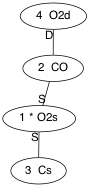

In [29]:
node0.item

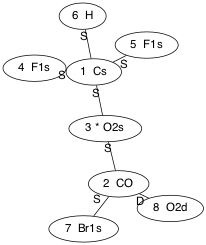

In [30]:
match.item

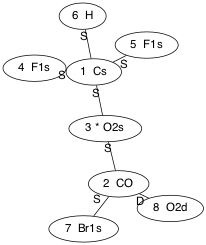

In [31]:
group

In [32]:
print(entry.item.to_adjacency_list())

1   Cs   u0 {3,S} {4,S} {5,S} {6,S}
2   CO   u0 {3,S} {7,S} {8,D}
3 * O2s  u0 {1,S} {2,S}
4   F1s  u0 {1,S}
5   F1s  u0 {1,S}
6   H    u0 {1,S}
7   Br1s u0 {2,S}
8   O2d  u0 {2,D}



In [33]:
print(match.item.to_adjacency_list())

1   Cs   u0 {3,S} {4,S} {5,S} {6,S}
2   CO   u0 {3,S} {7,S} {8,D}
3 * O2s  u0 {1,S} {2,S}
4   F1s  u0 {1,S}
5   F1s  u0 {1,S}
6   H    u0 {1,S}
7   Br1s u0 {2,S}
8   O2d  u0 {2,D}



In [34]:
for node in [match] + database_new.groups["group"].ancestors(match):
    print(node, node.item.to_adjacency_list())

O2s-(Br1sO2d)(F1sF1sH)COCs 1   Cs   u0 {3,S} {4,S} {5,S} {6,S}
2   CO   u0 {3,S} {7,S} {8,D}
3 * O2s  u0 {1,S} {2,S}
4   F1s  u0 {1,S}
5   F1s  u0 {1,S}
6   H    u0 {1,S}
7   Br1s u0 {2,S}
8   O2d  u0 {2,D}

O2s-Cs(Cds-O2d) 1 * O2s u0 {2,S} {3,S}
2   CO  u0 {1,S} {4,D}
3   Cs  u0 {1,S}
4   O2d u0 {2,D}

O2s-CdsCs 1 * O2s     u0 {2,S} {3,S}
2   [Cd,CO] u0 {1,S}
3   Cs      u0 {1,S}

O2s-CC 1 * O2s u0 {2,S} {3,S}
2   C   u0 {1,S}
3   C   u0 {1,S}

O2s 1 * O2s u0

O 1 * O u0

R 1 * R ux



# 5. Check that we land on the right node when using the new database

## 5.1 Estimate thermo using the new database

In [36]:
all_data["New GAE"] = list()
for entry in all_data["entry"]:
    molecule = entry.item
    all_data["New GAE"].append(database_new.estimate_thermo_via_group_additivity(molecule))

## 5.2 Parity plot for the library entry vs. new estimation

Text(0.5, 1.0, 'RMSE: 4.4, MAE: 3.1 kcal/mol')

<Figure size 1000x1000 with 0 Axes>

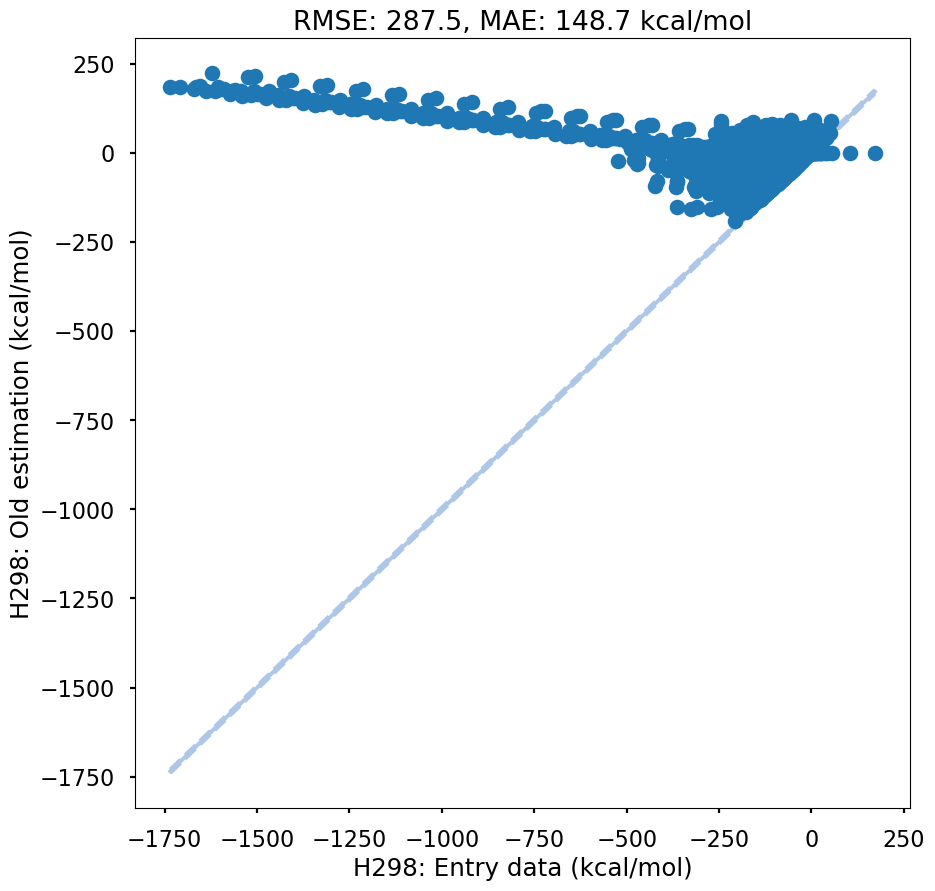

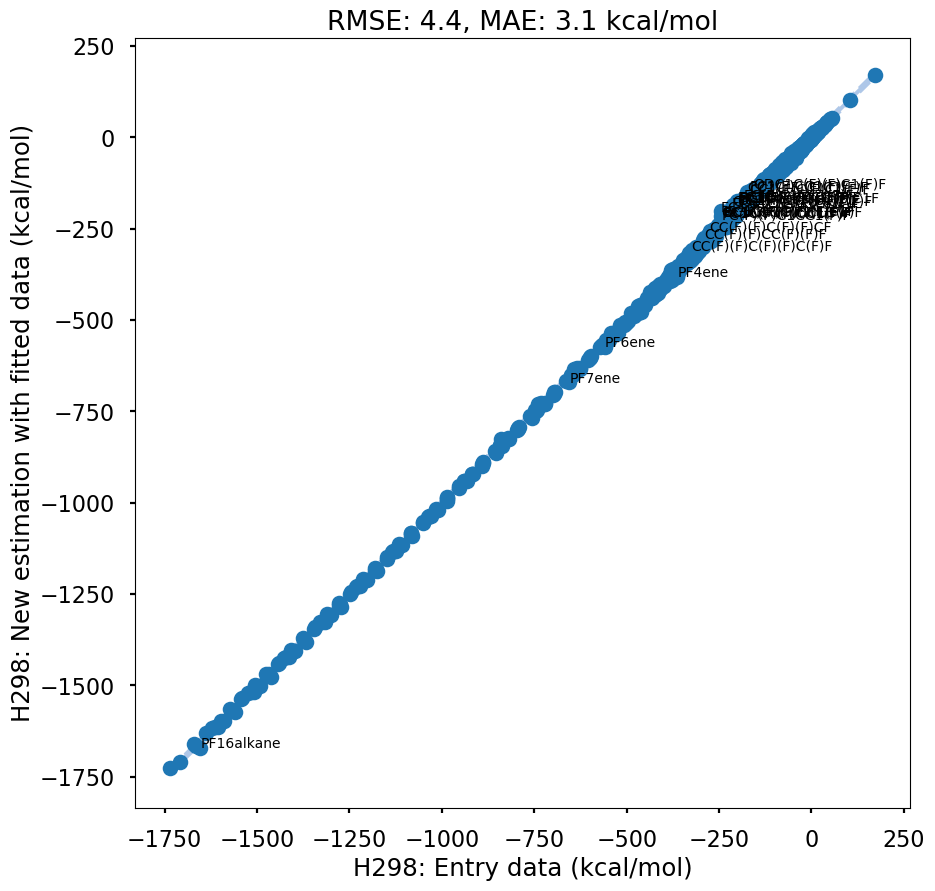

In [37]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()

for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.H298.value_si/4180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.H298.value_si/4180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.H298.value_si/4180)
    new_GAE_uncertainties.append(fitted_GAE.H298.uncertainty_si/4180)
    new_new_GAE_values.append(all_data["New GAE"][spc_index].H298.value_si/4180)
    
    
plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: Old estimation (kcal/mol)")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>15:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("H298: Entry data (kcal/mol)")
plt.ylabel("H298: New estimation with fitted data (kcal/mol)")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} kcal/mol')

Text(0.5, 1.0, 'RMSE: 2.5, MAE: 1.7 cal/(mol*K)')

<Figure size 1000x1000 with 0 Axes>

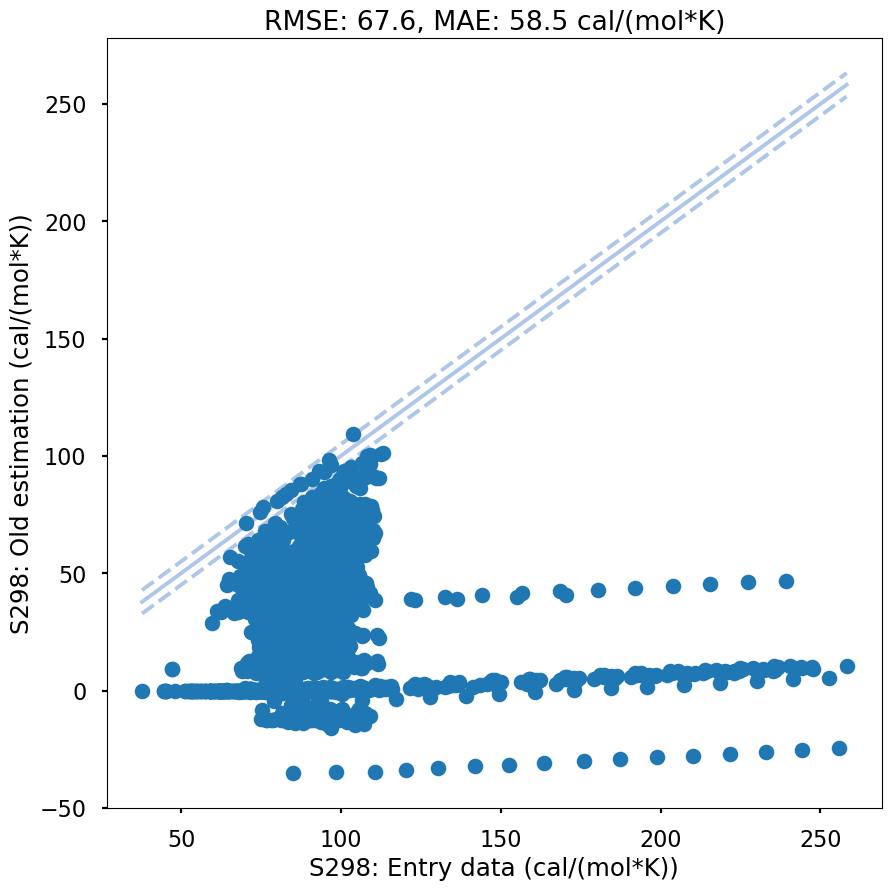

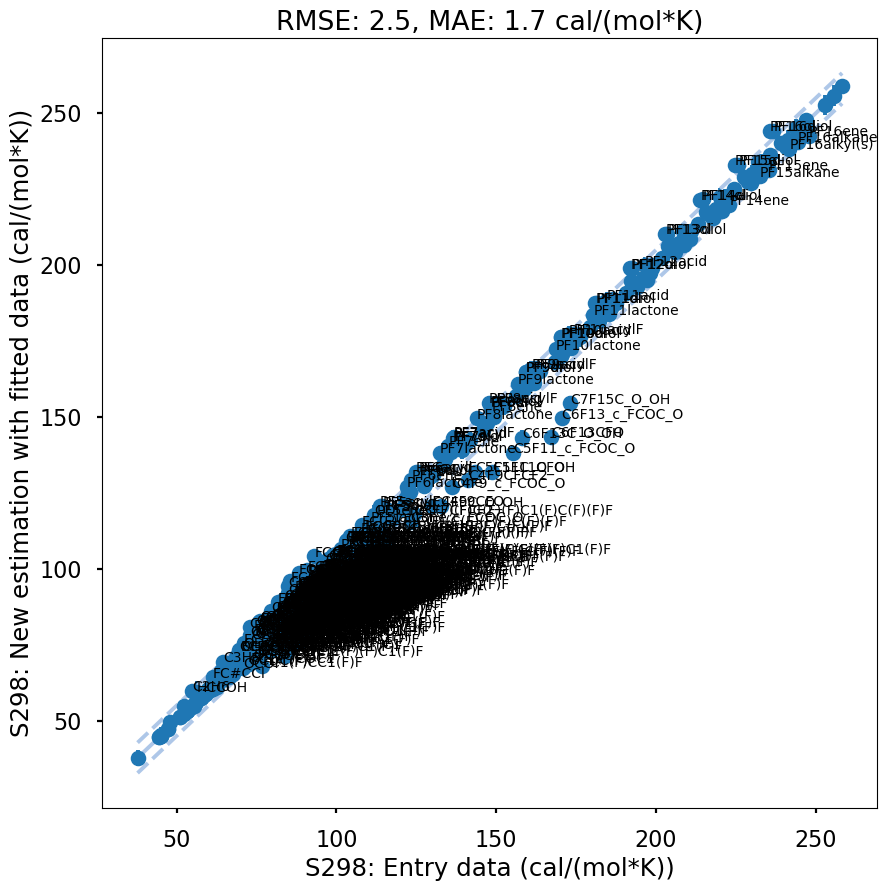

In [38]:
colormap = mpl.cm.tab20
plt.figure(figsize=(10,10))
entry_values = list()
old_GAE_values = list()
new_GAE_values = list()
new_GAE_uncertainties = list()
new_new_GAE_values = list()


for spc_index, entry_thermo in enumerate(all_data["entry thermo"]):
    entry_values.append(entry_thermo.S298.value_si/4.180)
    estimated_GAE = all_data["GAE with estimated GAV"][spc_index]
    old_GAE_values.append(estimated_GAE.S298.value_si/4.180)
    fitted_GAE = all_data["GAE with fitted GAV"][spc_index]
    new_GAE_values.append(fitted_GAE.S298.value_si/4.180)
    new_GAE_uncertainties.append(fitted_GAE.S298.uncertainty_si/4.180)
    new_new_GAE_values.append(all_data["New GAE"][spc_index].S298.value_si/4.180)

plt.figure(figsize=(10,10))
plt.errorbar(entry_values,old_GAE_values,fmt='o')
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
RMSE = mean_squared_error(entry_values,old_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,old_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: Old estimation (cal/(mol*K))")

plt.figure(figsize=(10,10))
plt.errorbar(x=entry_values,y=new_GAE_values,yerr=new_GAE_uncertainties,fmt='o')
for i, entry_value in enumerate(entry_values):
    if abs(entry_value - new_GAE_values[i])>3:
        plt.text(entry_value, new_GAE_values[i], s=all_data["entry"][i].label)
plt.plot([min(entry_values),max(entry_values)],[min(entry_values),max(entry_values)],'-', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)+5,max(entry_values)+5],'--', color=colormap(1))
plt.plot([min(entry_values),max(entry_values)],[min(entry_values)-5,max(entry_values)-5],'--', color=colormap(1))
plt.xlabel("S298: Entry data (cal/(mol*K))")
plt.ylabel("S298: New estimation with fitted data (cal/(mol*K))")
RMSE = mean_squared_error(entry_values,new_GAE_values,squared=False)
MAE = mean_absolute_error(entry_values,new_GAE_values)
plt.title(f'RMSE: {RMSE:.1f}, MAE: {MAE:.1f} cal/(mol*K)')

# 6. Make sure we pass database test

In [39]:
group_name = "group"
group = database.groups["group"]

entries_copy = copy(group.entries)
tst = []
for node_name, node_group in group.entries.items():
    del entries_copy[node_name]
    for node_name_other, node_group_other in entries_copy.items():
        group.match_node_to_node(node_group, node_group_other)
        tst.append((group.match_node_to_node(node_group, node_group_other),
                    "Node {node} in {group} group was found to be identical to node {node_other}".format(
                        node=node_name, group=group_name, node_other=node_name_other)))

boo = False
for i in range(len(tst)):
    if tst[i][0]:
        logging.error(tst[i][1])
        boo = True

if boo:
    raise ValueError("Error Occurred")
    
    

In [41]:
tst1 = []
tst2 = []
for node_name, child_node in group.entries.items():
    # top nodes and product nodes don't have parents by definition, so they get an automatic pass:
    if child_node in group.top:
        continue
    parent_node = child_node.parent
    # Check whether the node has proper parents unless it is the top reactant or product node
    # The parent should be more general than the child
    tst1.append((group.match_node_to_child(parent_node, child_node),
                 "In {group} group, node {parent} is not a proper parent of its child {child}.".format(
                     group=group_name, parent=parent_node, child=node_name)))

    # check that parentNodes which are LogicOr do not have an ancestor that is a Group
    # If it does, then the child_node must also be a child of the ancestor
    if isinstance(parent_node.item, LogicOr):
        ancestor_node = parent_node
        while ancestor_node not in group.top and isinstance(ancestor_node.item, LogicOr):
            ancestor_node = ancestor_node.parent
        if isinstance(ancestor_node.item, Group) and tst1[-1][0]:
            tst2.append((group.match_node_to_child(ancestor_node, child_node),
                         "In {group} group, node {ancestor} is not a proper ancestor of its child {child}."
                         "".format(group=group_name, ancestor=ancestor_node, child=node_name)))

boo = False
for i in range(len(tst1)):
    if not tst1[i][0]:
        logging.error(tst1[i][1])
        boo = True
for i in range(len(tst2)):
    if not tst2[i][0]:
        logging.error(tst2[i][1])
        boo = True

if boo:
    raise ValueError("Error Occurred")

# Save new database to file

In [45]:
database_new.groups["group"].save(os.path.join(settings["database.directory"],"thermo/groups/group.py"))

In [44]:
database_new.groups["group"].save('/Users/khalil.nor/Code/projects/PFAS/AIChE_2024/thermo/group.py')